# Prepare python environment

In [ ]:

!pip install import_ipynb
!pip install scikit-learn
!pip install pybiomart
!pip install mygene
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install pyDeseq2
!pip install Ensembl_converter
!pip install rnanorm

import json
import pandas as pd
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pybiomart import Server
import mygene
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from math import log
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from itertools import islice
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import argparse
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from Ensembl_converter import EnsemblConverter
from sklearn.inspection import permutation_importance
import os



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 

In [ ]:
import import_ipynb
from google.colab import drive
drive.flush_and_unmount()
drive.mount("mnt")

Drive not mounted, so nothing to flush and unmount.
Mounted at mnt


In [ ]:
# download GTF file
# https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/635/GCF_000001635.27_GRCm39/GCF_000001635.27_GRCm39_genomic.gtf.gz
# /content/mnt/MyDrive/NASA/RR9/MANUSCRIPT/MERGED_NOTEBOOK/Mus_musculus.GRCm39.115.gtf.gz'
import os
if not os.path.exists('/content/mnt/MyDrive/NASA/RR9/Mus_musculus.GRCm39.115.gtf.gz'):
  os.makedirs('/content/mnt/MyDrive/NASA/RR9/')
!curl -o GCF_000001635.27_GRCm39_genomic.gtf.gz https://ftp.ensembl.org/pub/release-115/gtf/mus_musculus/Mus_musculus.GRCm39.115.gtf.gz
!mv GCF_000001635.27_GRCm39_genomic.gtf.gz /content/mnt/MyDrive/NASA/RR9/Mus_musculus.GRCm39.115.gtf.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.7M  100 39.7M    0     0  11.0M      0  0:00:03  0:00:03 --:--:-- 11.0M


# Define data processing methods

In [ ]:
def results_dist_plot(df, targetGenes, plotName, includeText=False):
  import matplotlib.pyplot as plt
  import numpy as np
  import pandas as pd
  import mygene

  logBase = 2

  # convert id's to symbols
  gene_list=list(df.columns)[1:]
  symbol_list = list()
  mg = mygene.MyGeneInfo()
  ginfo = mg.querymany(gene_list, scopes='ensembl.gene')
  for g in ginfo:
    if not 'symbol' in g:
      symbol_list.append(g['query'])
    else:
      symbol_list.append(g['symbol'])

  df.columns = ['sample'] + symbol_list


  vars_list=list()
  means_list=list()
  if 'sample' in df.columns:
    df.drop(columns=['sample'], inplace=True)

  means_list = df.mean()
  vars_list = df.var()

  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_xlabel('mean', fontsize=30)
  ax.set_ylabel('variance', fontsize=30)
  #ax.tick_params(axis='both', labelsize=20)
  plt.xticks([])
  plt.yticks([])
  plot_title=os.path.basename(plotName)

  fig.suptitle(plot_title, fontsize=40)

  if logBase is None:
    plt.scatter(x=means_list, y=vars_list)
  elif logBase == 10:
    plt.scatter(x=np.log10([i+1 for i in means_list]), y=np.log10([j+1 for j in vars_list]))
  elif logBase == 2:
    plt.scatter(x=np.log2([i+1 for i in means_list]), y=np.log2([j+1 for j in vars_list]))


  x_genes = list()
  y_genes = list()

  means_vars_dict=dict()

  for gene in targetGenes:
    if not gene in df.columns:
      continue

    m = float(df[gene].mean())
    v = float(df[gene].var())
    if logBase is None:
      x_genes.append(m)
      y_genes.append(v)
      means_vars_dict[gene] = [m, v]
    elif logBase == 10:
      x_genes.append(np.log10(1+m))
      y_genes.append(np.log10(1+v))
      means_vars_dict[gene] = [np.log10(m), np.log10(v)]
    elif logBase == 2:
      x_genes.append(np.log2(1+m))
      y_genes.append(np.log2(1+v))
      means_vars_dict[gene] = [np.log2(m), np.log2(v)]

  plt.scatter(x=x_genes, y=y_genes, marker='*', color='red', s=100)


  # add labels?

  if includeText:
    # find 10 highest means
    sorted_items = sorted(means_vars_dict.items(), key=lambda item: item[1][0], reverse=True)
    top10 = sorted_items[:10]
    print('top 10: ', top10)
    for res in top10:
      plt.annotate(res[0], (float(res[1][0]), float(res[1][1])), fontsize=14)
      #plt.txt(float(top10[1][0]), float(top10[1][1]), gene)

  plt.savefig(plotName + '.png')
  plt.close()

In [ ]:
def set_maxdisplay(n=None):
  pd.set_option('display.max_rows', n)
  from notebook.services.config import ConfigManager
  cm = ConfigManager().update('notebook', {'limit_output': n})

In [ ]:
def read_meta_data(dataset):
  # dataset=255
  url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + str(dataset) + '/download?source=datamanager&file=OSD-' + dataset + '_metadata_OSD-' + dataset + '-ISA.zip'
  filename = dataset + '-meta.zip'
  urlretrieve(url, filename)
  !unzip -o {filename} > /dev/null
  df = pd.read_csv('s_OSD-' + dataset + '.txt', sep='\t', header=0)
  return df

In [ ]:
def read_rnaseq_data(data):
  # data = '255_rna_seq_Normalized_Counts'
  dataset = data.split('_')[0]
  url='https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + str(dataset) + '/download?source=datamanager&file=GLDS-' + data + '.csv'
  df = pd.read_csv(url)
  return df

In [ ]:
def read_phenotype_data(dataset, data):
  # dataset = '557'
  # data = 'LSDS-1_immunostaining_microscopy_PNAtr_Transformed_Reusable_Results'
  url='https://osdr.nasa.gov//geode-py/ws/studies/OSD-' + str(dataset) + '/download?source=datamanager&file=' + data + '.csv'
  df = pd.read_csv(url)
  return df

In [ ]:
def filter_cvs(df, thresh=0.5):

  # calculate coefficient of variation
  cvs=list()
  for i in range(len(df)):
    m=np.mean(df.iloc[i][1:])
    sd=np.std(df.iloc[i][1:])
    cvs.append(sd/m)

  # plot hist of dist of coev of variation
  fig, axs = plt.subplots()
  axs.hist(cvs, bins=20)

  # keep genes with cv > thresh
  indices = list()
  for i in range(len(cvs)):
    if cvs[i] > thresh:
      indices.append(i)
  return df.iloc[indices]

In [ ]:
def drop_nans(df):
  # drop NaN rows
  return df.dropna(inplace=False)


In [ ]:
def filterGenesByPercentLowCount(df, n=0, p=0):
    if n == 0 or p == 0:
        # this filtering assumes raw or normalized counts, not z-scores or log_xform
        pass
    else:
        df = df[(df.loc[:, df.columns != 'Unnamed: 0'] < n).sum(axis='columns') <= int(p * len(df.columns))]
    return df

In [ ]:
def custom_mutual_info_regression(X, y):
    from sklearn.feature_selection import  mutual_info_regression
    return mutual_info_regression(X, y, random_state=seed)

def filterNotCorrelated(df, y, k, seed):
  # remove non-correlated
  from sklearn.feature_selection import SelectKBest, mutual_info_regression
  if k == 0:
    return df
  # first transpose to samples x genes
  df_t = transpose_df(df, 'Unnamed: 0', 'sample')
  samples = list(df_t['sample'])
  X = df_t.drop(columns=['sample']).to_numpy()
  selector = SelectKBest(score_func=custom_mutual_info_regression, k=k)
  X_selected = selector.fit_transform(X, y)
  # get indices of remaining cols
  indices = selector.get_support(indices=True)
  return df.iloc[indices]

In [ ]:
def filter_genes(df, drop='non-coding'):
  # let's filter protein/ non-protein-coding genes
  if drop is None or drop == 0:
    return df
  server = Server(host='http://www.ensembl.org')
  dataset = (server.marts['ENSEMBL_MART_ENSEMBL'].datasets['mmusculus_gene_ensembl'])
  gene_info = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name', 'gene_biotype'])
  if drop=='non-coding':
    filter_genes=gene_info[gene_info['Gene type'] == 'protein_coding']['Gene stable ID']
  elif drop=='coding':
    filter_genes=gene_info[gene_info['Gene type'] != 'protein_coding']['Gene stable ID']
  else:
    return df
  df=df[df['Unnamed: 0'].isin(filter_genes)]
  return df

In [ ]:
def exclude_samples_by_prefix(df, prefix="V", colname="Source Name"):
  sample_names=list(df[colname].values)
  exclude_names=list()
  for sn in sample_names:
    if sn.startswith(prefix):
      exclude_names.append(sn)
  return exclude_names

In [ ]:
def intersect_samples(A_list, B_list):
  samples_A_dict = dict()
  samples_B_list = list()
  for i in range(len(A_list)):
    sample = A_list[i]
    num = ""
    for c in sample:
      if c.isdigit():
        num += str(c)
    if "G" in sample:
      samples_A_dict["GC" + num] = A_list[i]

    elif "F" in sample:
      samples_A_dict["F" + num] = A_list[i]
    else:
      continue

  for sample in B_list:
    num = ""
    for c in sample:
      if c.isdigit():
        num += str(c)
    if "G" in sample:
      samples_B_list.append("GC" + num)
    elif "F" in sample:
      samples_B_list.append("F" + num)
    else:
      continue
  # intersect A samples with B  samples
  samples_both=list(set(samples_A_dict.keys()) & set(samples_B_list))
  return samples_both

In [ ]:
def transpose_df(df, cur_index_col, new_index_col):
  df = df.set_index(cur_index_col).T
  df.reset_index(level=0, inplace=True)
  cols = [new_index_col] + list(df.columns)[1:]
  df.columns = cols
  return df

In [ ]:
# define method to convert gene ids to symbols
def get_symbol_from_id(gene_list):
  import mygene

  symbol_list = list()
  mg = mygene.MyGeneInfo()
  ginfo = mg.querymany(gene_list, scopes='ensembl.gene')
  seen_genes = list()
  for g in ginfo:
    if g['query'] in seen_genes:
      continue
    if not 'symbol' in g:
      symbol_list.append(g['query'])
    else:
      symbol_list.append(g['symbol'])
    seen_genes.append(g['query'])
  return symbol_list

In [ ]:
def convert_ids_to_names(gene_id_list):
  # Create an instance of EnsemblConverter
  converter = EnsemblConverter()

  # Convert Ensembl IDs to gene symbols
  result = converter.convert_ids(gene_id_list)

  # Print the resulting DataFrame
  gene_symbol_list = list()
  for i in range(len(result)):
    gene_symbol_list.append(result.iloc[i]['Symbol'])

  return gene_symbol_list

In [ ]:
def plotbox_and_stats(data_, sample_key, field, treatment, condition_1_value = None, condition_1_name='flight', condition_2_name='nonflight', exclude_samples=[]):
  print('field: ', field)
  print('excluding samples: ', exclude_samples)
  fieldValues = set(data_[field])
  value_dict=dict()
  results = dict()

  condition_1 = str(field) + '_' + condition_1_name
  condition_2= str(field) + '_' + condition_2_name
  results[field] = dict()
  value_dict[condition_1] = list()
  value_dict[condition_2] = list()
  for i in range(len(data_)):
    if data_.iloc[i][sample_key] in exclude_samples:
      continue
    elif treatment is None:
      if data_.iloc[i][sample_key].startswith('F'):
        value_dict[condition_1].append(data_.iloc[i][field])
      else:
        value_dict[condition_2].append(data_.iloc[i][field])
    else:
      if data_.iloc[i][treatment] == condition_1_value:
        value_dict[condition_1].append(data_.iloc[i][field])
      else:
        value_dict[condition_2].append(data_.iloc[i][field])


  if len(value_dict[condition_1]) != 0 and len(value_dict[condition_2]) != 0:
    results[field]['t-test p-value'] = float('%.5f' % (stats.ttest_ind(value_dict[condition_1], value_dict[condition_2], equal_var=False).pvalue))
    #results[field]['wilcoxon p-value'] = float('%.5f' % (stats.ranksums(value_dict[flight], value_dict[nonflight]).pvalue))
    #results[field]['ks-test p-value'] = float('%.5f' % (stats.kstest(value_dict[flight], value_dict[nonflight]).pvalue))


  print(results)
  print('n condition 1 = ', len(value_dict[condition_1]))
  print('n condition 2 = ', len(value_dict[condition_2]))
  fig,ax = plt.subplots()
  ax.boxplot(value_dict.values())
  ax.set_xticklabels(value_dict.keys())
  #plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
  plt.xticks(rotation=30, ha='right')



  plt.show()

In [ ]:
def map_samples_to_classes(dfT, y_classes):
  # map conditions to samples for comparison in DESeq2
  condition_dict=dict()
  for i in range(len(dfT)):
    if y_classes[i] == 0:
      condition_dict[dfT.iloc[i]['sample']] = '0'
    else:
      condition_dict[dfT.iloc[i]['sample']] = '1'


  dfT["condition"] = dfT["sample"].map(condition_dict)
  conditions=dfT[['sample', 'condition']]

  return conditions

In [ ]:
def map_samples_to_conditions(dfT, metadata, metadata_condition_param, condition_0, condition_1):
  # map conditions to samples for comparison in DESeq2
  condition_dict=dict()
  for sample in list(dfT['sample']):
    #val=metadata['255'][metadata['255']['Sample Name']==sample]['Factor Value[Spaceflight]'].values[0]
    val=metadata[metadata['Sample Name']==sample][metadata_condition_param].values[0]

    if val == condition_0:
      condition_dict[sample] = '0'
    else:
      condition_dict[sample] = '1'


  dfT["condition"] = dfT["sample"].map(condition_dict)
  conditions=dfT[['sample', 'condition']]

  return conditions

In [ ]:
def run_deseq2(df, metadata, y_classes):
  # transpose df
  dfT = df.T
  dfT.columns=dfT.iloc[0]
  dfT=dfT.iloc[1:]
  dfT.columns.name=None
  dfT = dfT.reset_index().rename(columns={"index":"sample"})

  # map conditions
  if y_classes is None:
    conditions = map_samples_to_conditions(dfT, metadata, 'Factor Value[Spaceflight]', 'Ground Control', 'Space Flight')
  else:
    conditions = map_samples_to_classes(dfT, y_classes)

  # get count data set up for DESeq2
  counts=dfT.drop(columns=['sample', 'condition']).reset_index(drop=True)
  counts.applymap(np.isreal)
  counts=counts.astype(int)

  # run DESeq2
  dds=DeseqDataSet(counts=counts, metadata=conditions, design_factors="condition")
  dds.deseq2()

  return dds

In [ ]:
def get_results(dds):
  # do DGEA
  stats_results=DeseqStats(dds, contrast = ('condition', '0', '1'))

  # run summary
  stats_results.summary()

  # get differentially expressed genes
  res = stats_results.results_df

  return res

In [ ]:
def get_sig_genes(res, pval=0.05, l2fc=0):
  sigs = res[(res.padj < pval) & (abs(res.log2FoldChange) > l2fc)]
  return sigs

In [ ]:
def get_dge_ranked_genes(res):
  # rank genes from most to least significantly differentially expressed
  ranking = res[['stat']].dropna().sort_values('stat', ascending=False)
  ranking_index=list(ranking.index)
  ranking_index_upper=[x.upper() for x in ranking_index]
  ranking.index=ranking_index_upper

  return ranking

In [ ]:
def filter_by_dgea(data, metadata,  y_classes=None, pval=0, l2fc=0):
  if pval == None or pval == 0:
    return data
  # run DESeq2
  dds = run_deseq2(data, metadata, y_classes)

  # get results
  res = get_results(dds)

  # get sig genes
  sig_genes_df = get_sig_genes(res, pval=pval, l2fc=l2fc)

  # get top sig genes
  top_genes = list(sig_genes_df.sort_values('padj').index)

  # filter data by topn_genes
  return data[data['Unnamed: 0'].isin(top_genes)]

In [ ]:
def permutation_feature_importance(model, X_, y_, genes = None, scoring='accuracy', n=20, random_state=0):
  # use sklearn permutation_importance on entire dataset
  r = permutation_importance(model, X_, y_, n_repeats=5, scoring=scoring, random_state=random_state)
  # identify up to top n most important features
  means = list()
  stds = list()
  mins = list()
  maxes = list()
  gene_list = list()
  for i in r.importances_mean.argsort()[::-1][:n]:
    #if r.importances_mean[i] -2 * r.importances_std[i] > 0:
    #print(X.columns[i], round(r.importances_mean[i], 2), round(r.importances_std[i], 2))
    #print('fi index i : ', i)
    gene_list.append(genes[i])
    means.append(round(r.importances_mean[i], 2))
    stds.append(round(r.importances_std[i], 2))
    mins.append(r.importances[i].min())
    maxes.append(r.importances[i].max())

  feat_imp_df = pd.DataFrame( {
      'feature': gene_list,
      'importance_mean': means,
      'importance_std': stds
  })

  return list(feat_imp_df.sort_values(by=['importance_mean'], ascending=False)['feature'])

In [ ]:
def read_data_and_metadata_hne(data, metadata, rna_seq):

  # read in phenotype data
  #data['iop'] = read_phenotype_data('583', 'LSDS-16_tonometry_maoTRANSFORMED')

  # use read_rnaseq_data() to read in the normalized transcriptomic counts from OSD-255
  data['255-normalized'] = transpose_df(read_rnaseq_data('255_rna_seq_Normalized_Counts'), cur_index_col='Unnamed: 0', new_index_col='sample')
  data['255-RSEM'] = transpose_df(read_rnaseq_data('255_rna_seq_RSEM_Unnormalized_Counts'), cur_index_col='Unnamed: 0', new_index_col='sample')
  data['255-STAR'] = transpose_df(read_rnaseq_data('255_rna_seq_STAR_Unnormalized_Counts'), cur_index_col='Unnamed: 0', new_index_col='sample')
  data['all'] = pd.concat([data['255-normalized'], data['255-RSEM'], data['255-STAR']], ignore_index=True)
  data['notnorm'] = pd.concat([data['255-RSEM'], data['255-STAR']], ignore_index=True)
  data['hne'] = read_phenotype_data('557', 'LSDS-1_immunostaining_microscopy_HNEtr_Transformed_Reusable_Results')

  # read in metadata
  metadata['255'] = read_meta_data('255')

  X_orig = data[rna_seq]

  #================================
  hne_samples=list()
  rna_samples=list()
  for i in range(len(metadata['255'])):
    rna_samples.append(metadata['255'].iloc[i]['Source Name'])

  hne_samples = list(data['hne']['Source Name'])

  samples_both=intersect_samples(rna_samples, hne_samples)
  print(samples_both)
  hne_data = data['hne'][data['hne']['Source Name'].isin(samples_both)]
  rna_sources = list()
  for name in samples_both:
    rna_sources.append(metadata['255'][metadata['255']['Source Name'] == name]['Sample Name'].values[0])
  X_orig = X_orig[X_orig['sample'].isin(rna_sources)]
  #============================================

  # sort the dataframe alphabetically by sample name to match the Y labels which will be likewise sorted
  X_orig = X_orig.sort_values(by=['sample'])

  # create metadata based on samples in X_orig
  metadata_orig = pd.DataFrame(columns=metadata['255'].columns)
  for i in range(len(X_orig)):
    metadata_orig = pd.concat([metadata_orig, metadata['255'][metadata['255']['Sample Name'] == X_orig.iloc[i]['sample']]], ignore_index=True)

  print('metadata_orig shape: ', metadata_orig.shape)
  print('X_orig shape: ', X_orig.shape)
  # if there are multiple samples by the same name, give them unique names
  sample_list = list(X_orig['sample'])
  counts = {}
  for i, name in enumerate(sample_list):
    if name in counts:
      counts[name] += 1
      sample_list[i] = f"{name}_{counts[name]}"
    else:
      counts[name] = 1

  X_orig['sample'] = sample_list
  metadata_orig['Sample Name'] = sample_list

  # now transpose X_orig back for subsequent processing
  X_orig = transpose_df(X_orig, cur_index_col='sample', new_index_col='Unnamed: 0')
  print("X shape to start with: ", X_orig.shape)
  print("metadata orig shape: ", metadata_orig.shape)

  return X_orig, metadata_orig, hne_data


In [ ]:
def read_data_and_metadata_tunel(data, metadata, rna_seq):

  # read in phenotype data
  #data['iop'] = read_phenotype_data('583', 'LSDS-16_tonometry_maoTRANSFORMED')

  # use read_rnaseq_data() to read in the normalized transcriptomic counts from OSD-255
  data['255-normalized'] = transpose_df(read_rnaseq_data('255_rna_seq_Normalized_Counts'), cur_index_col='Unnamed: 0', new_index_col='sample')
  data['255-RSEM'] = transpose_df(read_rnaseq_data('255_rna_seq_RSEM_Unnormalized_Counts'), cur_index_col='Unnamed: 0', new_index_col='sample')
  data['255-STAR'] = transpose_df(read_rnaseq_data('255_rna_seq_STAR_Unnormalized_Counts'), cur_index_col='Unnamed: 0', new_index_col='sample')
  data['all'] = pd.concat([data['255-normalized'], data['255-RSEM'], data['255-STAR']], ignore_index=True)
  data['notnorm'] = pd.concat([data['255-RSEM'], data['255-STAR']], ignore_index=True)
  data['tunel'] = read_phenotype_data('568', 'LSDS-5_immunostaining_microscopy_TUNELtr_TRANSFORMED')

  # read in metadata
  metadata['255'] = read_meta_data('255')

  X_orig = data[rna_seq]

  ###############################################
  # intersect tunel and 255
  # "Source Name" field based on sample name
  source_names = list()
  for sample in data['tunel']['Sample_Name']:
    num=sample.split("_")[0]
    source_names.append(num)
  data['tunel']['Source Name'] = source_names
  data['tunel'].head()

  samples_both=list(set(data['tunel']['Source Name']) & set(metadata['255']['Source Name']))
  print(samples_both)
  samples_255=list()
  samples_tunel = list()
  for i in range(len(metadata['255'])):
    if metadata['255']['Source Name'][i] in samples_both:
      samples_255.append(metadata['255'].iloc[i]['Sample Name'])
    if data['tunel'].iloc[i]['Source Name'] in samples_both:
      samples_tunel.append(data['tunel'].iloc[i]['Source Name'])
  print(samples_255)
  X_orig = transpose_df(X_orig, cur_index_col='sample', new_index_col='Unnamed: 0')

  X_orig = X_orig[['Unnamed: 0'] + samples_255]
  tunel_data = data['tunel'][data['tunel']['Source Name'].isin(samples_tunel)]

  ###########################################

  # transpose for subsequent processing
  X_orig = transpose_df(X_orig, cur_index_col='Unnamed: 0', new_index_col='sample')

  # sort the dataframe alphabetically by sample name to match the Y labels which will be likewise sorted
  X_orig = X_orig.sort_values(by=['sample'])

  # create metadata based on samples in X_orig
  metadata_orig = pd.DataFrame(columns=metadata['255'].columns)
  for i in range(len(X_orig)):
    metadata_orig = pd.concat([metadata_orig, metadata['255'][metadata['255']['Sample Name'] == X_orig.iloc[i]['sample']]], ignore_index=True)

  print('metadata_orig shape: ', metadata_orig.shape)
  print('X_orig shape: ', X_orig.shape)
  # if there are multiple samples by the same name, give them unique names
  sample_list = list(X_orig['sample'])
  counts = {}
  for i, name in enumerate(sample_list):
    if name in counts:
      counts[name] += 1
      sample_list[i] = f"{name}_{counts[name]}"
    else:
      counts[name] = 1

  X_orig['sample'] = sample_list
  metadata_orig['Sample Name'] = sample_list

  # now transpose X_orig back for subsequent processing
  X_orig = transpose_df(X_orig, cur_index_col='sample', new_index_col='Unnamed: 0')
  print("X shape to start with: ", X_orig.shape)
  print("metadata orig shape: ", metadata_orig.shape)

  return X_orig, metadata_orig, tunel_data


In [ ]:
def filter_data(df, y_vals, dropnans=False, dropgenes='non-coding', droplowcvs=0, correlation=0, seed=None):
  # drop NANs
  if dropnans:
    df = drop_nans(df)
  # drop non protein-coding genes
  if not dropgenes is None:
    df = filter_genes(df, drop=dropgenes)
    #df = filter_genes_new(df, drop=dropgenes)
  # drop low coef of var genes
  if droplowcvs != 0:
    df = filter_cvs(df, droplowcvs)
  # drop uncorrelated genes
  if correlation != 0:
    df = filterNotCorrelated(df, y_vals, correlation, seed)

  return df

In [ ]:
def run_filter_data(X_orig, y_vals, y_classes,cvs=0, alpha=0, lowcount=(0, 0), correlation=0, seed=None):
  # filter out nans
  X_orig = filter_data(X_orig, y_vals, dropnans=True, dropgenes=None, droplowcvs=0, correlation=0)
  print("X shape after filter nans: ", X_orig.shape)

  # drop low-count genes
  #X_orig = drop_lowcount(X_orig, threshold=lowcount)
  X_orig = filterGenesByPercentLowCount(X_orig, n=lowcount[0], p=lowcount[1])
  print("X shape after filter lowcount = ", str(lowcount), " ", X_orig.shape)

  # now filter out non-coding
  X_orig = filter_data(X_orig, y_vals, dropnans=False, dropgenes='non-coding', droplowcvs=0, correlation=0, seed=seed)
  print("X shape after filter non-coding: ", X_orig.shape)


  # filter genes to those significantly differentially expressed between
  # high and low or ground control and space flight
  X_orig = filter_by_dgea(X_orig, metadata_orig,  y_classes, pval=alpha, l2fc=0)
  print('X data shape after filter by DGEA: ', X_orig.shape)


  # now filter out lowcvs
  X_orig = filter_data(X_orig, y_vals, dropnans=False, dropgenes=None, droplowcvs=cvs, correlation=0, seed=seed)
  print("X shape after filter low cvs: ", X_orig.shape)

  # now filter out non-correlated genes
  X_orig = filter_data(X_orig, y_vals, dropnans=False, dropgenes=None, droplowcvs=0,
                       correlation=correlation, seed=seed)
  print("X shape after filter non-correlated: ", X_orig.shape)


  # create numpy array X_orig of rna-seq values
  X_orig = transpose_df(X_orig, 'Unnamed: 0', 'sample')


  X_array = np.array(X_orig.drop(columns=['sample']))

  return X_orig, X_array

In [ ]:
def run_create_Y(metadata_orig, pheno_data, pheno_var):
  # create dictionary Y_dict of condition values

  Y_dict = dict()

  Y_dict['condition'] = dict()
  Y_dict['pheno val'] = dict()
  Y_dict['pheno class'] = dict()

  # set value per sample
  for i in range(len(metadata_orig)):
    print('Sample Name in metadata_orig?: ', 'Sample Name' in list(metadata_orig.columns))
    sample = metadata_orig.iloc[i]['Sample Name']
    source = metadata_orig.iloc[i]['Source Name']
    if metadata_orig.iloc[i]['Factor Value[Spaceflight]'] == 'Space Flight':
      Y_dict['condition'][sample] = 1
    else:
      Y_dict['condition'][sample] = 0

    pheno_val=pheno_data[pheno_data['Source Name'] == source][pheno_var].values[0]
    Y_dict['pheno val'][sample] = pheno_val

  # set binary threshold for IOP per sample
  for sample in list(metadata_orig['Sample Name']):
    if Y_dict['pheno val'][sample] > np.median(list(Y_dict['pheno val'].values())):
      Y_dict['pheno class'][sample] = 1
    else:
      Y_dict['pheno class'][sample] = 0

  Y_dict_conditions = dict(sorted(Y_dict['condition'].items()))
  Y_dict_pheno_vals = dict(sorted(Y_dict['pheno val'].items()))
  Y_dict_pheno_classes = dict(sorted(Y_dict['pheno class'].items()))

  y_conditions = np.array(list(Y_dict_conditions.values()))
  y_classes = np.array(list(Y_dict_pheno_classes.values()))
  y_vals = np.array(list(Y_dict_pheno_vals.values()))

  print('y conditions = ', y_conditions)
  print('y classes = ', y_classes)
  print('y vals = ', y_vals)

  return y_conditions, y_classes, y_vals


In [ ]:
def run_create_groups(metadata_orig, X_orig):
  # create 2 groups:  space, ground
  y_conditions_groups = dict()

  y_conditions_groups['space'] = []
  y_conditions_groups['ground'] = []

  for i in range(len(metadata_orig)):
    sample = metadata_orig.iloc[i]['Sample Name']
    if metadata_orig.iloc[i]['Factor Value[Spaceflight]'] == 'Space Flight':
      y_conditions_groups['space'].append(sample)
    else:
      y_conditions_groups['ground'].append(sample)

  print(y_conditions_groups)

  # now subset X and y into these 2 groups

  X_space = X_orig[X_orig['sample'].isin(y_conditions_groups['space'])]
  X_ground = X_orig[X_orig['sample'].isin(y_conditions_groups['ground'])]

  X_space_array =  np.array(X_space.drop(columns=['sample']))
  X_ground_array =  np.array(X_ground.drop(columns=['sample']))

  return X_space, X_ground, X_space_array, X_ground_array


In [ ]:
def run_plots():
  # plot phenotype box plots
  # plotbox_and_stats(data_=metadata_orig, sample_key = 'Source Name', field='Parameter Value[Body Weight upon Euthanasia]', treatment='Factor Value[Age]', condition_1_value = '32', condition_1_name='old', condition_2_name='young', exclude_samples=[])

  plotbox_and_stats(data_=data['iop'], sample_key = 'Source Name', field='Avg_Left', treatment='Factor Value: Spaceflight', condition_1_value="Space Flight", condition_1_name = 'space', condition_2_name='ground', exclude_samples=[])
  plotbox_and_stats(data_=data['iop'], sample_key = 'Source Name', field='Avg_Right', treatment='Factor Value: Spaceflight', condition_1_value="Space Flight", condition_1_name = 'space', condition_2_name='ground', exclude_samples=[])

  # plot PCA of space vs ground
  # drop sample in preparation for PCA
  X_t = X_orig.drop(columns=['sample']).to_numpy()

  # create an array labels that represents whether the sample is ground control or spaceflight
  labels = np.array(list(metadata_orig['Factor Value[Spaceflight]']))
  target_names=np.array(['Ground Control', 'Space Flight'])

  # run PCA to reduce dimensions from 23,419 to 2!
  pca = PCA(n_components=2)
  X_r = pca.fit_transform(X_t)

  # Percentage of variance explained for each components
  print(
      "explained variance ratio (first two components): %s"
      % str(pca.explained_variance_ratio_)
  )

  # plot the pca plot
  plt.figure()
  colors = ["navy", "orange"]
  lw = 2
  for color, i, target_name in zip(colors, ['Ground Control', 'Space Flight'], target_names):
      plt.scatter(X_r[labels == i, 0], X_r[labels == i, 1], color=color, alpha=0.8, lw=lw, label=target_name)
  plt.legend(loc="best", shadow=False, scatterpoints=1)
  plt.title("PCA of all samples (ground vs space)")

  '''# show the last 3 digits of the sample name
  samples = list(X_orig['sample'])
  for i, txt in enumerate(samples):
      label = txt
      print(label)
      plt.annotate(label, (X_r[i][0], X_r[i][1]))'''
  plt.show()

In [ ]:
def full_transform(X, x_list):
  from sklearn.preprocessing import StandardScaler
  from sklearn.preprocessing import power_transform
  import numpy as np
  from rnanorm import TPM

  temp = X

  if 'tpm' in x_list:
    # TPM
    print('shape of df before tpm: ', temp.shape)
    # Provide a GTF annotation file (gene lengths will be computed)
    #gtf_filename = '/content/mnt/MyDrive/NASA/RR9/MANUSCRIPT/MERGED_NOTEBOOK/Mus_musculus.GRCm39.115.gtf.gz'
    gtf_filename = '/content/mnt/MyDrive/NASA/RR9/Mus_musculus.GRCm39.115.gtf.gz'
    tpm_calculator = TPM(gtf=gtf_filename)

    # Set output format (e.g., pandas DataFrame)
    tpm_calculator.set_output(transform="pandas")

    # Transform raw counts to TPM
    temp_tpm = tpm_calculator.fit_transform(temp)
    temp = temp_tpm

  if 'log' in x_list:
    # LOG
    # assumes genes x samples
    temp_t = temp.T
    print('shape of df before log: ', temp_t.shape)
    temp_log = np.log2(temp_t + 1)
    temp = temp_log.T

  if 'boxcox' in x_list:
    # assumes samples x genes
    # Box-Cox transformation
    temp = myboxcox(temp)

  if 'std' in x_list:
    # STD
    # assumes samples x genes
    print('shape of df before scaling: ', temp.shape)
    #scaler = StandardScaler()
    #scaled = scaler.fit_transform(temp)
    scaled = (temp - np.mean(temp, axis=0)) + 0.01 / (np.std(temp, axis=0) + 0.01)
    temp = scaled


  if 'power' in x_list:
    # assumes samples x genes
    temp_power = np.zeros((temp.shape[0], temp.shape[1]))
    for i in range(X.shape[1]):
      temp_power[:, i] = power_transform(temp[:, i].reshape(-1, 1), method='yeo-johnson', standardize=True).reshape(-1)
    temp = temp_power




  return temp

In [ ]:
def myboxcox(df):
  from scipy.stats import boxcox
  df1 = df + 1
  bcDF = pd.DataFrame()
  for i in range(len(df1)):
    bc_array, bc_lambda = boxcox(df1.iloc[i])
    bcDF = pd.concat([bcDF, pd.DataFrame(np.array(bc_array).reshape(1, -1))], ignore_index=True)
  #bcDF = bcDF.reset_index().drop(columns=['index'])

  return bcDF

# REGRESSION MODELS


## ELASTICNET


In [ ]:
def run_elasticnet(y, X_array, X_orig, n_genes, score, xform_list, cv, seed):
  from sklearn.linear_model import Perceptron
  from sklearn.model_selection import cross_validate
  from sklearn.model_selection import LeaveOneOut
  from sklearn.neural_network import MLPRegressor
  from sklearn.linear_model import ElasticNet
  from sklearn.model_selection import GridSearchCV
  from sklearn.model_selection import LeavePOut

  #X = full_transform(X_orig, xform_list)

  perfs = dict()

  # split the data
  X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=test_size, random_state=seed)

  # transform training data
  X_train = full_transform(X_train, xform_list)


  # find alpha
  param_grid = {'alpha': np.logspace(1, 10, 10)}
  elastic = ElasticNet(random_state=seed)
  grid_search = GridSearchCV(elastic, param_grid, cv=cv, scoring=score)
  grid_search.fit(X_train, y_train)
  best_alpha = grid_search.best_params_['alpha']
  print('elastic best alpha: ', best_alpha)

  # build model
  reg = ElasticNet(alpha=best_alpha, l1_ratio=0.5, random_state=seed)
  output = cross_validate(reg, X_train, y_train, cv=LeavePOut(p=2), scoring = score, return_estimator =True)
  best_estimator = output['estimator'][np.argmax(output['test_score'])]
  scores = output['test_score']
  avg_score = np.median(list(scores))
  print('average elastic kfold train score: ', avg_score)
  perfs['avg_train'] = avg_score

  # xform test data
  X_test = full_transform(X_test, xform_list)
  # test performance
  from sklearn.metrics import root_mean_squared_error, r2_score
  # Make predictions on the test data
  y_pred = best_estimator.predict(X_test)
  rmse = root_mean_squared_error(y_test, y_pred)
  print(f"EN test root Mean Squared Error (RMSE): {rmse:.2f}")
  perfs['test_rmse'] = rmse
  r2 = r2_score(y_test, y_pred)
  print(f"EN test R-squared (R2 Score): {r2:.2f}")
  perfs['test_r2'] = r2
  data = [(x, y) for x, y in zip(y_test, y_pred) ]
  df = pd.DataFrame(data, columns=['test', 'pred'])
  print(df)


  # feature importance
  elastic_genes=dict()

  elastic_genes['pfi'] = get_symbol_from_id(permutation_feature_importance(best_estimator, X_test, y_test,
                                                                    genes = list(X_orig.columns),
                                                                    scoring=score,
                                                                    n=n_genes,
                                                                    random_state=seed))
  print('elastic genes pfi: ', elastic_genes['pfi'])

  from sklearn.feature_selection import RFE
  selector = RFE(best_estimator, n_features_to_select=n_genes, step=0.25).fit(X_test, y_test)
  indices = selector.get_support(indices=True)
  elastic_genes['rfe'] = get_symbol_from_id([list(X_orig.columns)[i] for i in indices])
  print('elastic genes rfe: ', elastic_genes['rfe'])

  genes_coefs_dict = dict()
  genes_list = list(X_orig.columns)
  coefs_list = list(best_estimator.coef_)
  for i in range(len(genes_list)):
    genes_coefs_dict[genes_list[i]] = coefs_list[i]
  pos_genes_coefs_dict = {key: value for key, value in genes_coefs_dict.items() if value >= 0}
  pos_genes_coefs_sorted_dict = {k: v for k, v in sorted(pos_genes_coefs_dict.items(), key=lambda item: item[1], reverse=True)}
  pos_top_genes = list(islice(pos_genes_coefs_sorted_dict, n_genes))
  elastic_genes['pos'] = get_symbol_from_id(pos_top_genes)
  print('elastic genes pos: ', elastic_genes['pos'])
  neg_genes_coefs_dict = {key: value for key, value in genes_coefs_dict.items() if value <= 0}
  neg_genes_coefs_sorted_dict = {k: v for k, v in sorted(neg_genes_coefs_dict.items(), key=lambda item: item[1], reverse=False)}
  neg_top_genes = list(islice(neg_genes_coefs_sorted_dict, n_genes))
  elastic_genes['neg'] = get_symbol_from_id(neg_top_genes)
  print('elastic genes neg: ', elastic_genes['neg'])



  return elastic_genes, best_estimator, perfs


## SVM

In [ ]:
def run_svm(y, X_array, X_orig, n_genes, score, xform_list, cv, seed):
  from sklearn import svm
  from sklearn.model_selection import cross_validate
  from sklearn.model_selection import LeaveOneOut
  from sklearn.model_selection import GridSearchCV
  from sklearn.svm import SVR
  from sklearn.model_selection import LeavePOut

  perfs= dict()

  #X = full_transform(X_orig, xform_list)
  # split the data
  X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=test_size, random_state=seed)

  # transform training data
  X_train = full_transform(X_train, xform_list)

  # find alpha
  svr = svm.SVR(kernel='linear')
  param_grid = {'C': [0.1, 1, 10, 100, 1000]}
  grid_search = GridSearchCV(svr, param_grid, cv=cv, scoring=score)
  # Fit the GridSearchCV object to your data
  grid_search.fit(X_train, y_train)
  # Get the best parameters found
  best_C = grid_search.best_params_['C']
  print('svr best C: ', best_C)

  # build model
  reg = SVR(kernel="linear", C=best_C, gamma="auto")
  output = cross_validate(reg, X_train, y_train, cv=LeavePOut(p=2), scoring = score, return_estimator =True)
  best_estimator = output['estimator'][np.argmax(output['test_score'])]
  scores = output['test_score']
  avg_score = np.median(list(scores))
  perfs['avg_train'] = avg_score
  print('average svr kfold train score: ', avg_score)

  # xform test data
  X_test = full_transform(X_test, xform_list)
  # test performance
  from sklearn.metrics import root_mean_squared_error, r2_score
  # Make predictions on the test data
  y_pred = best_estimator.predict(X_test)
  rmse = root_mean_squared_error(y_test, y_pred)
  print(f"SVR test root Mean Squared Error (RMSE): {rmse:.2f}")
  perfs['test_rmse'] = rmse
  r2 = r2_score(y_test, y_pred)
  print(f"SVR test R-squared (R2): {r2:.2f}")
  perfs['test_r2'] = r2

  data = [(x, y) for x, y in zip(y_test, y_pred) ]
  df = pd.DataFrame(data, columns=['test', 'pred'])
  print(df)

  # feature importance
  svm_genes = dict()
  svm_genes['pfi'] = get_symbol_from_id(permutation_feature_importance(best_estimator, X_test, y_test,
                                                                    genes = list(X_orig.columns),
                                                                    scoring=score, n=n_genes,
                                                                    random_state=seed))
  print('svm genes pfi: ', svm_genes['pfi'])

  from sklearn.feature_selection import RFE
  selector = RFE(best_estimator, n_features_to_select=n_genes, step=0.25).fit(X_test, y_test)
  indices = selector.get_support(indices=True)
  svm_genes['rfe'] = get_symbol_from_id([list(X_orig.columns)[i] for i in indices])
  print('svm genes rfe: ', svm_genes['rfe'])

  coefs = list(best_estimator.coef_)
  features = pd.Series(list(coefs[0]), index=list(X_orig.columns))
  features.sort_values(ascending=False, inplace=True)
  top_genes = list(features.keys()[:n_genes])
  svm_genes['pos'] = get_symbol_from_id(top_genes)
  print('svm genes pos: ', svm_genes['pos'])
  features.sort_values(ascending=True, inplace=True)
  top_genes = list(features.keys()[:n_genes])
  svm_genes['neg'] = get_symbol_from_id(top_genes)
  print('svm genes neg: ', svm_genes['neg'])


  return svm_genes, best_estimator, perfs


## RIDGE

In [ ]:
def run_ridge_regression(y, X_array, X_orig, n_genes, score, xform_list, cv, seed):
  from sklearn.model_selection import cross_validate
  from sklearn.model_selection import GridSearchCV
  from sklearn.linear_model import Ridge
  from sklearn.model_selection import LeaveOneOut
  from sklearn.model_selection import LeavePOut


  perfs=dict()

  #X = full_transform(X_orig, xform_list)

  # split the data
  X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=test_size, random_state=seed)

  # transform training data
  X_train = full_transform(X_train, xform_list)

  # find alpha
  param_grid = {'alpha': np.logspace(1, 10, 10)} # Example range for alpha
  ridge = Ridge(random_state=seed)
  grid_search = GridSearchCV(ridge, param_grid, cv=cv, scoring=score)
  grid_search.fit(X_train, y_train)
  best_alpha = grid_search.best_params_['alpha']
  print('ridge best alpha: ', best_alpha)

  # build model
  reg = Ridge(alpha=best_alpha, random_state=seed)
  output = cross_validate(reg, X_train, y_train, cv=LeavePOut(p=2), scoring = score, return_estimator =True)
  best_estimator = output['estimator'][np.argmax(output['test_score'])]
  scores = output['test_score']
  avg_score = np.median(list(scores))
  perfs['avg_train'] = avg_score
  print('average ridge kfold train score: ', avg_score)

  # xform test data
  X_test = full_transform(X_test, xform_list)
  # test performance
  from sklearn.metrics import root_mean_squared_error, r2_score
  # Make predictions on the test data
  y_pred = best_estimator.predict(X_test)
  rmse = root_mean_squared_error(y_test, y_pred)
  perfs['test_rmse'] = rmse
  print(f"RIDGE test root Mean Squared Error (RMSE): {rmse:.2f}")
  r2 = r2_score(y_test, y_pred)
  perfs['test_r2'] = r2
  print(f"RIDGE test R-squared (R2 Score): {r2:.2f}")

  data = [(x, y) for x, y in zip(y_test, y_pred) ]
  df = pd.DataFrame(data, columns=['test', 'pred'])
  print(df)

  # feature importance
  ridge_genes = dict()
  ridge_genes['pfi'] = get_symbol_from_id(permutation_feature_importance(best_estimator,
                                                                       X_test,
                                                                       y_test,
                                                                      genes = list(X_orig.columns),
                                                                       scoring=score, n=n_genes,
                                                                      random_state=seed))
  print('ridge genes pfi: ', ridge_genes['pfi'])

  from sklearn.feature_selection import RFE
  selector = RFE(best_estimator, n_features_to_select=n_genes, step=0.25).fit(X_test, y_test)
  indices = selector.get_support(indices=True)
  ridge_genes['rfe'] = get_symbol_from_id([list(X_orig.columns)[i] for i in indices])
  print('ridge genes rfe: ', ridge_genes['rfe'])

  genes_coefs_dict = dict()
  genes_list = list(X_orig.columns)
  coefs_list = list(best_estimator.coef_)
  for i in range(len(genes_list)):
    genes_coefs_dict[genes_list[i]] = coefs_list[i]
  pos_genes_coefs_dict = {key: value for key, value in genes_coefs_dict.items() if value >= 0}
  pos_genes_coefs_sorted_dict = {k: v for k, v in sorted(pos_genes_coefs_dict.items(), key=lambda item: item[1], reverse=True)}
  pos_top_genes = list(islice(pos_genes_coefs_sorted_dict, n_genes))
  ridge_genes['pos'] = get_symbol_from_id(pos_top_genes)
  print('ridge genes pos: ', ridge_genes['pos'])
  neg_genes_coefs_dict = {key: value for key, value in genes_coefs_dict.items() if value <= 0}
  neg_genes_coefs_sorted_dict = {k: v for k, v in sorted(neg_genes_coefs_dict.items(), key=lambda item: item[1], reverse=False)}
  neg_top_genes = list(islice(neg_genes_coefs_sorted_dict, n_genes))
  ridge_genes['neg'] = get_symbol_from_id(neg_top_genes)
  print('ridge genes neg: ', ridge_genes['neg'])


  return ridge_genes, best_estimator, perfs


## LASSO

In [ ]:
def run_lasso_regression(y, X_array, X_orig, n_genes, score, xform_list, cv, seed):

  from sklearn.svm import SVR
  from sklearn.model_selection import cross_validate
  from sklearn.model_selection import LeaveOneOut
  from sklearn.model_selection import GridSearchCV
  from sklearn.linear_model import Lasso
  from sklearn.model_selection import LeavePOut


  perfs = dict()
  #X = full_transform(X_orig, xform_list)

  # split the data
  X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=test_size, random_state=seed)

  # transform training data
  X_train = full_transform(X_train, xform_list)

  # find alpha
  param_grid = {'alpha': np.logspace(1, 10, 10)} # Example range for alpha
  lasso = Lasso(random_state=seed)
  grid_search = GridSearchCV(lasso, param_grid, cv=cv, scoring=score)
  grid_search.fit(X_train, y_train)
  best_alpha = grid_search.best_params_['alpha']
  print('lasso best alpha: ', best_alpha)

  # build model
  reg = Lasso(alpha=best_alpha, random_state=seed)
  output = cross_validate(reg, X_train, y_train, cv=LeavePOut(p=2), scoring = score, return_estimator =True)
  best_estimator = output['estimator'][np.argmax(output['test_score'])]
  scores = output['test_score']
  avg_score = np.median(list(scores))
  perfs['avg_train'] = avg_score
  print('average lasso kfold train score: ', avg_score)

  # xform test data
  X_test = full_transform(X_test, xform_list)
  # test performance
  from sklearn.metrics import root_mean_squared_error, r2_score
  # Make predictions on the test data
  y_pred = best_estimator.predict(X_test)
  rmse = root_mean_squared_error(y_test, y_pred)
  perfs['test_rmse'] = rmse
  print(f"LASSO test root Mean Squared Error (RMSE): {rmse:.2f}")
  r2 = r2_score(y_test, y_pred)
  perfs['test_r2'] = r2
  print(f"LASSO test R-squared (R2 Score): {r2:.2f}")

  data = [(x, y) for x, y in zip(y_test, y_pred) ]
  df = pd.DataFrame(data, columns=['test', 'pred'])
  print(df)

  # feature importance
  lasso_genes = dict()
  lasso_genes['pfi'] = get_symbol_from_id(permutation_feature_importance(best_estimator,
                                                                    X_test,
                                                                    y_test,
                                                                    genes = list(X_orig.columns),
                                                                    scoring=score, n=n_genes,
                                                                    random_state=seed))
  print('lasso genes pfi: ', lasso_genes['pfi'])

  from sklearn.feature_selection import RFE
  selector = RFE(best_estimator, n_features_to_select=n_genes, step=0.25).fit(X_test, y_test)
  indices = selector.get_support(indices=True)
  lasso_genes['rfe'] = get_symbol_from_id([list(X_orig.columns)[i] for i in indices])
  print('lasso genes rfe: ', lasso_genes['rfe'])

  genes_coefs_dict = dict()
  genes_list = list(X_orig.columns)
  coefs_list = list(best_estimator.coef_)
  for i in range(len(genes_list)):
    genes_coefs_dict[genes_list[i]] = coefs_list[i]
  pos_genes_coefs_dict = {key: value for key, value in genes_coefs_dict.items() if value >= 0}
  pos_genes_coefs_sorted_dict = {k: v for k, v in sorted(pos_genes_coefs_dict.items(), key=lambda item: item[1], reverse=True)}
  pos_top_genes = list(islice(pos_genes_coefs_sorted_dict, n_genes))
  lasso_genes['pos'] = get_symbol_from_id(pos_top_genes)
  print('lasso genes pos: ', lasso_genes['pos'])
  neg_genes_coefs_dict = {key: value for key, value in genes_coefs_dict.items() if value <= 0}
  neg_genes_coefs_sorted_dict = {k: v for k, v in sorted(neg_genes_coefs_dict.items(), key=lambda item: item[1], reverse=False)}
  neg_top_genes = list(islice(neg_genes_coefs_sorted_dict, n_genes))
  lasso_genes['neg'] = get_symbol_from_id(neg_top_genes)
  print('lasso genes neg: ', lasso_genes['neg'])


  return lasso_genes, best_estimator, perfs


## LINEAR REGRESSION

In [ ]:
def run_linear_regression(y, X_array, X_orig, n_genes, score, xform_list, cv, seed):

  from sklearn.model_selection import cross_validate
  from sklearn.model_selection import LeaveOneOut
  from sklearn.model_selection import GridSearchCV
  from sklearn.linear_model import LinearRegression
  from sklearn.model_selection import LeavePOut

  perfs = dict()
  #X = full_transform(X_orig, xform_list)

  # split the data
  X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=test_size, random_state=seed)

  # transform training data
  X_train = full_transform(X_train, xform_list)

  # build model
  reg = LinearRegression(positive=False)
  output = cross_validate(reg, X_train, y_train, cv=LeavePOut(p=2), scoring = score, return_estimator =True)
  best_estimator = output['estimator'][np.argmax(output['test_score'])]
  scores = output['test_score']
  avg_score = np.median(list(scores))
  perfs['avg_train'] = avg_score
  print('average linear regression kfold train score: ', avg_score)

  # xform test data
  X_test = full_transform(X_test, xform_list)
  # test performance
  from sklearn.metrics import root_mean_squared_error, r2_score
  # Make predictions on the test data
  y_pred = best_estimator.predict(X_test)
  rmse = root_mean_squared_error(y_test, y_pred)
  perfs['test_rmse'] = rmse
  print(f"LINEAR REGRESSION test root Mean Squared Error (MSE): {rmse:.2f}")
  r2 = r2_score(y_test, y_pred)
  perfs['test_r2'] = r2
  print(f"LINEAR REGRESSION test R-squared (R2 Score): {r2:.2f}")

  data = [(x, y) for x, y in zip(y_test, y_pred) ]
  df = pd.DataFrame(data, columns=['test', 'pred'])
  print(df)

  # feature importance
  linear_genes = dict()
  linear_genes['pfi'] = get_symbol_from_id(permutation_feature_importance(best_estimator,
                                                                    X_test,
                                                                    y_test,
                                                                    genes = list(X_orig.columns),
                                                                    scoring=score, n=n_genes,
                                                                    random_state=seed))
  print('linear genes pfi: ', linear_genes['pfi'])

  from sklearn.feature_selection import RFE
  selector = RFE(best_estimator, n_features_to_select=n_genes, step=0.25).fit(X_test, y_test)
  indices = selector.get_support(indices=True)
  linear_genes['rfe'] = get_symbol_from_id([list(X_orig.columns)[i] for i in indices])
  print('linear genes rfe: ', linear_genes['rfe'])

  genes_coefs_dict = dict()
  genes_list = list(X_orig.columns)
  coefs_list = list(best_estimator.coef_)
  for i in range(len(genes_list)):
    genes_coefs_dict[genes_list[i]] = coefs_list[i]
  pos_genes_coefs_dict = {key: value for key, value in genes_coefs_dict.items() if value >= 0}
  pos_genes_coefs_sorted_dict = {k: v for k, v in sorted(pos_genes_coefs_dict.items(), key=lambda item: item[1], reverse=True)}
  pos_top_genes = list(islice(pos_genes_coefs_sorted_dict, n_genes))
  linear_genes['pos'] = get_symbol_from_id(pos_top_genes)
  print('linear genes pos: ', linear_genes['pos'])
  neg_genes_coefs_dict = {key: value for key, value in genes_coefs_dict.items() if value <= 0}
  neg_genes_coefs_sorted_dict = {k: v for k, v in sorted(neg_genes_coefs_dict.items(), key=lambda item: item[1], reverse=False)}
  neg_top_genes = list(islice(neg_genes_coefs_sorted_dict, n_genes))
  linear_genes['neg'] = get_symbol_from_id(neg_top_genes)
  print('linear genes neg: ', linear_genes['neg'])


  return linear_genes, best_estimator, perfs


# Intersect and union results

In [ ]:
def intersection_and_union(sgd_genes_1, sgd_genes_2, sgd_genes_3,
                           slp_genes_1, slp_genes_2, slp_genes_3,
                           lr_genes_1, lr_genes_2, lr_genes_3,
                           svm_genes_1, svm_genes_2, svm_genes_3):
  # find intersection of all models
  # TODO create "similar genes" intersection (e.g. Xirp1 and Xirp2) -> is there a rule of thumb like first 3 characters are always letters?
  # -> or maybe you can keep looking into the string left to right until you hit a number? (is that even a "rule"?)

  # TODO weight each model results using the test accuracy for that model

  sgd_cvfi_genes = set(sgd_genes_1)
  lr_cvfi_genes = set(lr_genes_1)
  slp_cvfi_genes = set(slp_genes_1)
  svm_cvfi_genes = set(svm_genes_1)

  sgd_pfi_genes = set(sgd_genes_2)
  lr_pfi_genes = set(lr_genes_2)
  slp_pfi_genes = set(slp_genes_2)
  svm_pfi_genes = set(svm_genes_2)

  sgd_coef_genes = set(sgd_genes_3)
  lr_coef_genes = set(lr_genes_3)
  slp_coef_genes = set(slp_genes_3)
  svm_coef_genes = set(svm_genes_3)

  intersection_sgd = sgd_cvfi_genes.intersection(sgd_pfi_genes).intersection(sgd_coef_genes)
  union_sgd = sgd_cvfi_genes.union(sgd_pfi_genes).union(sgd_coef_genes)

  intersection_slp = slp_cvfi_genes.intersection(slp_pfi_genes).intersection(slp_coef_genes)
  union_slp = slp_cvfi_genes.union(slp_pfi_genes).union(slp_coef_genes)

  intersection_lr = lr_cvfi_genes.intersection(lr_pfi_genes).intersection(lr_coef_genes)
  union_lr = lr_cvfi_genes.union(lr_pfi_genes).union(lr_coef_genes)

  intersection_svm = svm_cvfi_genes.intersection(svm_pfi_genes).intersection(svm_coef_genes)
  union_svm = svm_cvfi_genes.union(svm_pfi_genes).union(svm_coef_genes)

  intersection_all = set.intersection(union_sgd, union_lr, union_slp, union_svm)
  union_class = set.union(union_sgd, union_slp, union_svm, union_lr)
  union_all = set.union(union_sgd, union_slp, union_lr, union_svm)
  union_of_intersections = set.union(intersection_sgd, intersection_slp, intersection_lr, intersection_svm)
  majority_genes = set.intersection(union_sgd, union_slp, union_lr, union_svm)
  print('intersection sgd: ', intersection_sgd)
  print('intersection slp: ', intersection_slp)
  print('intersection lr: ', intersection_lr)
  print('intersection svm: ', intersection_svm)
  print('intersection all: ', intersection_all)

  print('union sgd: ', union_sgd)
  print('union slp: ', union_slp)
  print('union lr: ', union_lr)
  print('union svm: ', union_svm)
  print('union all: ', union_all)

  multiple_genes = set()
  for s1 in [union_sgd, union_slp, union_lr, union_svm]:
    for s2 in [union_sgd, union_slp, union_lr, union_svm]:
      if s1 != s2:
        multiple_genes = multiple_genes.union(s1.intersection(s2))


  pfi_genes_union = set.union(sgd_pfi_genes, slp_pfi_genes, lr_pfi_genes, svm_pfi_genes)
  cvfi_genes_union = set.union(sgd_cvfi_genes, slp_cvfi_genes, lr_cvfi_genes, svm_cvfi_genes)
  pfi_genes_intersection = set.intersection(sgd_pfi_genes, slp_pfi_genes, lr_pfi_genes, svm_pfi_genes)
  cvfi_genes_intersection = set.intersection(sgd_cvfi_genes, slp_cvfi_genes, lr_cvfi_genes, svm_cvfi_genes)



  gene_results = dict()
  gene_results['multiple genes'] = multiple_genes
  gene_results['union of unions'] = union_all
  gene_results['union of intersections'] = union_of_intersections
  gene_results['majority genes'] = majority_genes
  gene_results['pfi_genes_union'] = pfi_genes_union
  gene_results['cvfi_genes_union'] = cvfi_genes_union
  gene_results['pfi_genes_intersection'] = pfi_genes_intersection
  gene_results['cvfi_genes_intersection'] = cvfi_genes_intersection

  print('multiple genes: ', multiple_genes)
  print('union of unions: ', union_all)
  print('union of intersections: ', union_of_intersections)
  print('majority genes: ', majority_genes)
  print('pfi_genes_union: ', pfi_genes_union)
  print('cvfi_genes_union:', cvfi_genes_union)
  print('pfi_genes_intersection: ', pfi_genes_intersection)
  print('cvfi_genes_intersection: ', cvfi_genes_intersection)

  return gene_results


In [ ]:
def generate_counts(gene_dict):
  counts_dict = dict()
  for model in gene_dict:
    counts_dict[model] = dict()
    for fi in gene_dict[model]:
      counts_dict[model][fi] = gene_dict[model][fi]
      for gene in gene_dict[model][fi]:
        if gene in counts_dict:
          counts_dict[gene] += 1
        else:
          counts_dict[gene] = 1
  return counts_dict

In [ ]:
def union_all(gene_dict):
  union_set = set()
  for model in gene_dict:
    for fi in gene_dict[model]:
      for gene in gene_dict[model][fi]:
        union_set.add(gene)
  return union_set

In [ ]:
def majority_intersection_by_count(list_of_sets, list_of_models, n):
  from collections import Counter
  all_elements = Counter()
  for s in list_of_sets:
    for element in s:
      all_elements[element] += 1
  majority_elements = {element for element, count in all_elements.items() if count >= n}
  return majority_elements

def intersection_n(gene_dict, n, list_of_models, fi_type):
  model_genes = dict()
  for model in list_of_models:
    model_genes[model] = set()
    print('adding model: ', model)
    if fi_type == 'all':
      for fi in gene_dict[model]:
        for gene in gene_dict[model][fi]:
          model_genes[model].add(gene)
    elif fi_type in ['rfe', 'pfi']:
      for gene in gene_dict[model][fi_type]:
        model_genes[model].add(gene)
    elif fi_type in ['pos', 'neg']:
      if model == 'rf':
        continue
      for gene in gene_dict[model][fi_type]:
        model_genes[model].add(gene)


  # create dictionary of counts
  gene_lists = list()
  for model in list_of_models:
    if not model in model_genes:
      print("model ", model, " not in input file")
      continue
    gene_lists.append(set(model_genes[model]))

  result = majority_intersection_by_count(gene_lists, list_of_models, n)
  return result

# PLOTS and GRAPHS

In [ ]:
def plot_3d_pca(X, y, class_1_label, class_2_label, class_1_color, class_2_color):
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt

  from mpl_toolkits.mplot3d import Axes3D
  from sklearn.decomposition import PCA
  from sklearn import datasets
  from sklearn.preprocessing import StandardScaler
  # %matplotlib notebook


  if 'sample' in list(X.columns):
    X_t = X.drop(columns=['sample']).to_numpy()
  else:
      X_t = X.to_numpy()

  pca = PCA(n_components=3, random_state=0)
  X_pca = pca.fit_transform(X_t)

  ex_variance=np.var(X_pca,axis=0)
  ex_variance_ratio = ex_variance/np.sum(ex_variance)
  ex_variance_ratio


  Xax = X_pca[:,0]
  Yax = X_pca[:,1]
  Zax = X_pca[:,2]

  cdict = {0:class_1_color,1:class_2_color}
  labl = {0:class_1_label,1:class_2_label}
  marker = {0:'o',1:'o'}
  alpha = {0:.3, 1:.5}

  fig = plt.figure(figsize=(7,5))
  ax = fig.add_subplot(111, projection='3d')

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticklabels([])

  fig.patch.set_facecolor('white')
  for l in np.unique(y):
    ix=np.where(y==l)
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
            label=labl[l], marker=marker[l], alpha=alpha[l])
  # for loop ends
  ax.set_xlabel("PC1", fontsize=16)
  ax.set_ylabel("PC2", fontsize=16)
  ax.set_zlabel("PC3", fontsize=16)
  #ax.dist = 13
  ax.set_box_aspect(None, zoom=0.75)

  ax.legend(fontsize=12)
  #plt.tight_layout()
  return plt


In [ ]:
def plot_2d_pca(X, y, class_1_label, class_2_label, class_1_color, class_2_color):
  #target_names = np.array(['low ' + pheno_var, 'high ' + pheno_var])
  target_names=np.array([class_1_label, class_2_label])

  if 'sample' in list(X.columns):
    X_t = X.drop(columns=['sample']).to_numpy()
  else:
      X_t = X.to_numpy()

  # run PCA to reduce dimensions
  pca = PCA(n_components=2, random_state=0)
  X_r = pca.fit_transform(X_t)

  # Percentage of variance explained for each components
  print(
      "explained variance ratio for space samples young vs old (first two components): %s"
      % str(pca.explained_variance_ratio_)
  )

  # plot the pca plot
  fig = plt.figure()
  colors = [class_1_color, class_2_color]
  lw = 2
  for color, i, target_name in zip(colors, [0, 1], target_names):
      plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name)
  plt.legend(loc="best", shadow=False, scatterpoints=1, fontsize=12)
  plt.xticks([])
  plt.yticks([])
  '''fig = plt.gcf()
  return fig'''
  #plt.tight_layout()
  return plt


In [ ]:
def plotbox_and_stats(data_, sample_key, field, treatment, condition_1_value = None, condition_1_name='flight', condition_2_name='nonflight', exclude_samples=[]):
  print('field: ', field)
  print('excluding samples: ', exclude_samples)
  fieldValues = set(data_[field])
  value_dict=dict()
  results = dict()

  condition_1 = str(field) + '_' + condition_1_name
  condition_2= str(field) + '_' + condition_2_name
  results[field] = dict()
  value_dict[condition_1] = list()
  value_dict[condition_2] = list()
  for i in range(len(data_)):
    if data_.iloc[i][sample_key] in exclude_samples:
      continue
    elif treatment is None:
      if data_.iloc[i][sample_key].startswith('F'):
        value_dict[condition_1].append(data_.iloc[i][field])
      else:
        value_dict[condition_2].append(data_.iloc[i][field])
    else:
      if data_.iloc[i][treatment] == condition_1_value:
        value_dict[condition_1].append(data_.iloc[i][field])
      else:
        value_dict[condition_2].append(data_.iloc[i][field])


  print('value_dict: ', value_dict)
  if len(value_dict[condition_1]) != 0 and len(value_dict[condition_2]) != 0:
    results[field]['t-test p-value'] = float('%.5f' % (stats.ttest_ind(value_dict[condition_1], value_dict[condition_2], equal_var=False).pvalue))
    #results[field]['wilcoxon p-value'] = float('%.5f' % (stats.ranksums(value_dict[flight], value_dict[nonflight]).pvalue))
    #results[field]['ks-test p-value'] = float('%.5f' % (stats.kstest(value_dict[flight], value_dict[nonflight]).pvalue))


  print(results)
  print('n condition 1 = ', len(value_dict[condition_1]))
  print('n condition 2 = ', len(value_dict[condition_2]))
  fig,ax = plt.subplots()
  ax.boxplot(value_dict.values(), showfliers=False)
  ax.set_xticklabels(value_dict.keys())
  #plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
  plt.xticks(rotation=30, ha='right')


  return plt

In [ ]:
def store_results(genes, perfs, X_hne, X_tunel,  loc):
  import os
  if not os.path.exists(loc):
    os.makedirs(loc)

  with open(loc + '/genes.txt', 'w') as f:
    f.write(str(genes))
  f.close()

  with open(loc + '/perfs.txt', 'w') as f:
    f.write(str(perfs))
  f.close()

  X_hne.to_csv(loc + '/X_hne.csv')
  X_tunel.to_csv(loc + '/X_tunel.csv')



# MAIN LOOP

['GC19', 'F16', 'GC18', 'GC16', 'GC15', 'F19', 'GC17', 'F17', 'F20', 'F15', 'F18']
metadata_orig shape:  (22, 72)
X_orig shape:  (22, 56841)
X shape to start with:  (56840, 23)
metadata orig shape:  (22, 72)
now running run_create_Y
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_orig?:  True
Sample Name in metadata_ori

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['mt-Nd1', 'Prph2', 'Rs1', 'Selenow', 'Chgb', 'Dynlrb1', 'Sncb', 'Hspb6', 'Snap25', 'Pcare', 'Ldhb', 'Anp32a', 'Hsp90ab1', 'Nr2e3', 'B2m', 'Stmn3', 'Rsrp1', 'Clip3', 'Pcbp2', 'Cox7b', 'Cnga1', 'Efemp1', 'Rlbp1', 'Chchd10', 'Atp5me', 'Cnbp', 'Ndufc2', 'Mrpl34', 'Uqcr10', 'Syn1', 'Ndufs7', 'Rph3a', 'Stx3', 'Cplx1', 'Gpnmb', 'Kif1a', 'Atf4', 'Cox6a1', 'Car2', 'Tprg1l']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Hnrnpa2b1', 'Hnrnph1', 'Efemp1', 'Rgr', 'Hsp90ab1', 'Prph2', 'Dbi', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Rpe65', 'Ldhb', 'Mfge8', 'Ndufc2', 'Cox7b', 'Lsm4', 'Anp32a', 'Nr2e3', 'Atp6v0b', 'Cplx1', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Nenf', 'Rlbp1', 'Selenow', 'Atf4', 'Pcare', 'Dynlrb1', 'Scg2', 'Cfl1', 'Pcbp2', 'Uqcr10', 'B2m', 'Pclo', 'Lyar', 'H1f0']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Prph2', 'Cox7b', 'Selenow', 'Uqcr10', 'Efemp1', 'Mrpl54', 'Aqp1', 'Rgr', 'Nenf', 'Tprg1l', 'Mrpl34', 'Cnbp', 'Cnga1', 'Clta', 'Rps3', 'Atp5me', 'Rpe65', 'Ndufb11', 'Nicol1', 'B2m', 'H2az2', 'Dbnl', 'Slc6a9', 'Rs1', 'Ndufs7', 'Psmb2', 'Med11', 'Pqbp1', 'Pdcd4', 'Dctn3', 'Slc3a2', 'Hint1', 'H1f0', 'Anxa5', 'Utp3', 'Gpx1', 'Sar1b', 'Ubl5', 'Tmem11', 'Ubxn8']


INFO:biothings.client:Finished.


linear genes neg:  ['Chgb', 'Nr2e3', 'Stmn3', 'Hspb6', 'Sncb', 'Syn1', 'Rlbp1', 'Dynlrb1', 'Pcare', 'Ndufc2', 'Ldhb', 'Cplx1', 'Dbi', 'Rsrp1', 'Rph3a', 'Clip3', 'Tagln3', 'Pcbp2', 'Hnrnph1', 'Hsp90ab1', 'Snap25', 'Stac2', 'Hnrnpa2b1', 'Lsm4', 'Cend1', 'Rogdi', 'Atf4', 'Acadm', 'Chchd10', 'Smarcc2', 'Lyar', 'Hsbp1l1', 'Capzb', 'Car2', 'Nrsn2', 'Gabrr1', 'Ina', 'Fgf11', 'Pfn1', 'Atp5if1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  10.0
average elastic kfold train score:  0.0
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 1.39
EN test R-squared (R2 Score): 0.92
   test       pred
0    28  26.774565
1    24  22.594239
2    28  27.153949
3    19  18.125312
4    15  14.285705
5    28  26.675230
6    20  17.487868


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['mt-Nd1', 'Cst3', 'Prph2', 'Chgb', 'Hspb6', 'Rlbp1', 'Sncb', 'Nr2e3', 'Ldhb', 'Cox7b', 'Anp32a', 'Uqcr10', 'Pcbp2', 'Dynlrb1', 'Hsp90ab1', 'B3gat2', 'Ndufb3', 'Plekhb2', 'Mrpl44', 'Eif4e2', 'Inpp4a', 'Rev1', 'Tmem163', 'Chst10', 'Il1r1', 'Lancl1', 'Ndufs1', 'Slco5a1', 'Stau2', 'Snca', 'Hgs', 'Pgm1', 'Mettl26', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Gaa', 'Ptdss2', 'Ndufa10', 'Ptpra']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Arhgap31', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Paxbp1', 'Sncg', 'Prph2', 'Cox7b', 'Rs1', 'Anp32a', 'Sncb', 'Atf4', 'Uqcr10', 'mt-Nd1', 'Dda1', 'Zfp628', 'Arfgef2', 'Myh7b', 'Fndc10', 'Lcmt2', 'Scn2a', 'Dnlz', 'Msrb1', 'Selenoh', 'Mon1b', 'Hsbp1l1', 'Slc5a3', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Cox7b', 'Prph2', 'Uqcr10', 'Cst3', 'mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Pxmp4', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3']


INFO:biothings.client:Finished.


elastic genes neg:  ['Rlbp1', 'Nr2e3', 'Chgb', 'Hspb6', 'Sncb', 'Ldhb', 'Pcbp2', 'Anp32a', 'Dynlrb1', 'Hsp90ab1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Pxmp4', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.4689428325277424
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 1.31
SVR test R-squared (R2): 0.93
   test       pred
0    28  26.716534
1    24  22.642989
2    28  26.978363
3    19  17.921140
4    15  13.998297
5    28  26.879994
6    20  18.008288


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['mt-Nd1', 'Prph2', 'Sncb', 'Anp32a', 'Chgb', 'Selenow', 'Dynlrb1', 'Rs1', 'Snap25', 'Hspb6', 'Ldhb', 'Pcare', 'Hsp90ab1', 'Cst3', 'Nr2e3', 'Rsrp1', 'B2m', 'Stmn3', 'Clip3', 'Cox7b', 'Pcbp2', 'Atp5me', 'Uqcr10', 'Rlbp1', 'Efemp1', 'Mrpl34', 'Cnbp', 'Syn1', 'Ndufc2', 'Cnga1', 'Stx3', 'Car2', 'Rph3a', 'Cplx1', 'Atf4', 'Gpnmb', 'Kif1a', 'Tprg1l', 'Rgr', 'Ndufs7']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Hnrnpa2b1', 'Hnrnph1', 'Efemp1', 'Rgr', 'Hsp90ab1', 'Prph2', 'Dbi', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Rpe65', 'Ldhb', 'Mfge8', 'Ndufc2', 'Cox7b', 'Lsm4', 'Anp32a', 'Nr2e3', 'Atp6v0b', 'Cplx1', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Nenf', 'Rlbp1', 'Selenow', 'Atf4', 'Pcare', 'Dynlrb1', 'Scg2', 'Cfl1', 'Pcbp2', 'Uqcr10', 'B2m', 'Pclo', 'Lyar', 'H1f0']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Prph2', 'Cox7b', 'Uqcr10', 'Selenow', 'Efemp1', 'Rgr', 'Mrpl34', 'Mrpl54', 'Aqp1', 'Tprg1l', 'Atp5me', 'Clta', 'Cnbp', 'Nenf', 'Hint1', 'Rpe65', 'Cnga1', 'B2m', 'S100a1', 'Ndufb11', 'Dbnl', 'Nicol1', 'Pqbp1', 'H2az2', 'Slc6a9', 'Slc3a2', 'Med11', 'Sar1b', 'H1f0', 'Rps3', 'Gpnmb', 'Dctn3', 'Gpx1', 'Cadm4', 'Tmem11', 'Basp1', 'Pdcd4', 'Ubxn8', 'Ccdc90b', 'Rpp25']


INFO:biothings.client:Finished.


svm genes neg:  ['Sncb', 'Nr2e3', 'Chgb', 'Hspb6', 'Stmn3', 'Dynlrb1', 'Rlbp1', 'Syn1', 'Pcare', 'Ldhb', 'Anp32a', 'Rsrp1', 'Dbi', 'Hsp90ab1', 'Hnrnpa2b1', 'Ndufc2', 'Snap25', 'Pcbp2', 'Cplx1', 'Tagln3', 'Rph3a', 'Clip3', 'Atf4', 'Hnrnph1', 'Cend1', 'Car2', 'Lyar', 'Atp5f1a', 'Stac2', 'Lsm4', 'Rogdi', 'Acadm', 'Ndufb3', 'Hsbp1l1', 'Smarcc2', 'Fgf11', 'Capzb', 'Micos10', 'Cpt1a', 'Cfl1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  10.0
average lasso kfold train score:  0.026969968048091042
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 1.42
LASSO test R-squared (R2 Score): 0.91
   test       pred
0    28  26.594220
1    24  22.701916
2    28  26.914900
3    19  18.324350
4    15  14.352485
5    28  26.705825
6    20  17.394328


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['mt-Nd1', 'Chgb', 'Prph2', 'Cst3', 'Sncb', 'Ldhb', 'Cox7b', 'Nr2e3', 'Anp32a', 'Rlbp1', 'Pcbp2', 'Hsp90ab1', 'Uqcr10', 'Rev1', 'Inpp4a', 'Il1r1', 'Plekhb2', 'B3gat2', 'Mrpl44', 'Eif4e2', 'Ndufa10', 'Dars1', 'Chst10', 'Ndufb3', 'Lancl1', 'Ndufs1', 'Slco5a1', 'Stau2', 'Snca', 'Hgs', 'Pgm1', 'Mettl26', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Gaa', 'Ptdss2', 'Inpp5a', 'Tmem163', 'Ptpra']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Arhgap31', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Paxbp1', 'Sncg', 'Vwa5a', 'Prph2', 'Cox7b', 'Anp32a', 'Sncb', 'Uqcr10', 'mt-Nd1', 'Zfp628', 'Arfgef2', 'Myh7b', 'Fndc10', 'Lcmt2', 'Scn2a', 'Dnlz', 'Msrb1', 'Selenoh', 'Mon1b', 'Hsbp1l1', 'Slc5a3', 'Zfp994', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Cox7b', 'Prph2', 'Cst3', 'Uqcr10', 'mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Pxmp4', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3']


INFO:biothings.client:Finished.


lasso genes neg:  ['Nr2e3', 'Sncb', 'Ldhb', 'Chgb', 'Rlbp1', 'Anp32a', 'Pcbp2', 'Hspb6', 'Hsp90ab1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Pxmp4', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  10000000.0
average ridge kfold train score:  0.0
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 2.48
RIDGE test R-squared (R2 Score): 0.74
   test       pred
0    28  23.219854
1    24  21.835665
2    28  25.373862
3    19  18.890545
4    15  17.617305
5    28  27.426396
6    20  18.798976


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['mt-Nd1', 'Prph2', 'Sncb', 'Chgb', 'Anp32a', 'Dynlrb1', 'Cst3', 'Hspb6', 'Uqcr10', 'Selenow', 'Ldhb', 'Nr2e3', 'Syn1', 'Pcare', 'Cox7b', 'Stmn3', 'Snap25', 'Rlbp1', 'Clip3', 'Lyar', 'Hnrnpa2b1', 'Rs1', 'Rsrp1', 'Cnbp', 'Mrpl34', 'Dbi', 'Hint1', 'Tubb4a', 'Atp5f1a', 'S100a1', 'Rgr', 'Efemp1', 'Aqp1', 'Mrpl54', 'Pcbp2', 'Cplx1', 'Rph3a', 'Atf4', 'Atp5me', 'Tprg1l']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Hnrnpa2b1', 'Hnrnph1', 'Clip3', 'Rgr', 'Hsp90ab1', 'Prph2', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Rph3a', 'Gngt1', 'Cnbp', 'Ldhb', 'Ndufc2', 'Cox7b', 'Rs1', 'Anp32a', 'Nr2e3', 'Atp6v0b', 'Cplx1', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Nenf', 'Rlbp1', 'Selenow', 'Cox6a1', 'Dynlrb1', 'Cfl1', 'Pcbp2', 'Uqcr10', 'Tubb4a', 'mt-Nd1', 'Lyar', 'Hsbp1l1', 'H1f0']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Prph2', 'Uqcr10', 'Hint1', 'Cox7b', 'Efemp1', 'Mrpl34', 'Selenow', 'Cnbp', 'Atp5me', 'Ndufb11', 'Aqp1', 'Clta', 'S100a1', 'Tprg1l', 'H2az2', 'Sar1b', 'Pcp4l1', 'Rps3', 'Rgr', 'Mrpl54', 'B2m', 'Rnf126', 'Dbnl', 'H1f0', 'Cdc42', 'Rpe65', 'Nenf', 'Dctn3', 'Tceal9', 'Nicol1', 'Mllt11', 'Bcap31', 'mt-Nd1', 'Arhgdia', 'Pqbp1', 'Gnb3', 'Gpx1', 'Prxl2b', 'Stard10', 'Rnf113a2']


INFO:biothings.client:Finished.


ridge genes neg:  ['Chgb', 'Sncb', 'Dynlrb1', 'Nr2e3', 'Anp32a', 'Hspb6', 'Pcare', 'Stmn3', 'Syn1', 'Atp5f1a', 'Snap25', 'Clip3', 'Lyar', 'Ldhb', 'Rlbp1', 'Hnrnpa2b1', 'Rsrp1', 'Ndufb3', 'Cst3', 'Tubb4a', 'Rph3a', 'Atf4', 'Cend1', 'Dbi', 'Pcbp2', 'Smarcc2', 'Hnrnph1', 'Kif1a', 'Wbp2', 'Vgf', 'Cpt1a', 'Stx3', 'Cplx1', 'Rgs9bp', 'Tagln3', 'Rogdi', 'Ppp2r2b', 'Micos10', 'Stac2', 'Slc25a23']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.8656049  0.11691247]
['F15', 'GC19', 'F16', 'GC20', 'G

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Reep6', 'Rho', 'Pde6g', 'Prph2', 'Rom1', 'Gnat1', 'Dynlrb1', 'Mgarp', 'Cst3', 'Slc24a1', 'Rs1', 'Pdzph1', 'Vtn', 'Calb2', 'Stmn3', 'Nrl', 'Gabarapl1', 'Atp5f1a', 'Map1b', 'Calm1', 'Ip6k2', 'Nr2e3', 'Ddit4', 'Rlbp1', 'Tcf20', 'Chgb', 'Stk35', 'Sparcl1', 'Hint1', 'Chchd10', 'Dbi', 'Atp5f1c', 'Atf4', 'Cngb1', 'Cend1', 'Cfl1', 'Pcsk1n', 'Ndufb6', 'Enpp5', 'Smarca4']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Calm1', 'Psmb4', 'Aplp1', 'Vtn', 'Ddit4', 'Hint1', 'Mdh1', 'Nefl', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Pde6g', 'Atp5f1c', 'Cst3', 'Stmn3', 'Clta', 'Gngt1', 'Ndufb11', 'Rs1', 'Cox4i1', 'Hsbp1', 'Nr2e3', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Stk35', 'Rlbp1', 'Nrl', 'H2az2', 'Tcf20', 'Atf4', 'Pcare', 'Trnp1', 'Cend1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Reep6', 'Prph2', 'Nrl', 'Calm1', 'Mgarp', 'Pde6g', 'Cngb1', 'Slc24a1', 'Tcf20', 'Rom1', 'Map1b', 'Ddit4', 'Rtn3', 'Scg5', 'Mrpl34', 'Prcd', 'Fyco1', 'Stk35', 'Pea15a', 'Sgtb', 'Aplp1', 'Hnrnpl', 'Man2a2', 'Cox4i1', 'Mef2d', 'Nsf', 'Pcare', 'Snx3', 'Ndufb11', 'Syne2', 'Rs1', 'Apc', 'Ubxn4', 'Ik', 'Smarca4', 'Sdf2', 'Gpx1', 'Pfn2', 'Ppa1', 'Hsbp1']


INFO:biothings.client:Finished.


linear genes neg:  ['Calb2', 'Stmn3', 'Dynlrb1', 'Nr2e3', 'Pdzph1', 'Ip6k2', 'Hspb6', 'Atp5f1a', 'Gabarapl1', 'Rlbp1', 'Gnas', 'Chchd10', 'Eif3c', 'Capzb', 'Pcsk1n', 'Imp3', 'Vtn', 'Chgb', 'Cst3', 'Sparcl1', 'Thy1', 'Bzw1', 'Grina', 'Atp6ap1', 'Cend1', 'Rho', 'Dbi', 'Cfl1', 'Psmb4', 'Scg3', 'Enpp5', 'Ndufb6', 'Rab5c', 'Gabrr2', 'Coa3', 'Rab1b', 'Atg3', 'Snrnp27', 'Sh3bgrl3', 'Atp5f1c']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  1000000.0
average elastic kfold train score:  -0.6146849782573238
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 16.65
EN test R-squared (R2 Score): -0.17
        test       pred
0  30.437374  39.829918
1  43.684200  39.829918
2  46.999192  39.829918
3  23.160149  39.829918
4  66.397951  39.829918
5  56.770648  39.829918
6  34.140546  39.829918
7  67.415932  39.829918


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Ado', 'Brd9', 'Bak1', 'Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1', 'Tomm40']


INFO:biothings.client:Finished.


elastic genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1', 'Tomm40']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.0
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 7.87
SVR test R-squared (R2): 0.74
        test       pred
0  30.437374  20.938243
1  43.684200  37.027189
2  46.999192  40.370504
3  23.160149  16.449974
4  66.397951  58.043265
5  56.770648  50.998680
6  34.140546  23.706110
7  67.415932  59.689088


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Reep6', 'Rho', 'Pde6g', 'Prph2', 'Gnat1', 'Rom1', 'Dynlrb1', 'Slc24a1', 'Mgarp', 'Cst3', 'Pdzph1', 'Rs1', 'Vtn', 'Calb2', 'Nrl', 'Stmn3', 'Gabarapl1', 'Atp5f1a', 'Ddit4', 'Ip6k2', 'Map1b', 'Nr2e3', 'Calm1', 'Rlbp1', 'Chgb', 'Tcf20', 'Stk35', 'Sparcl1', 'Dbi', 'Atf4', 'Cend1', 'Hint1', 'Cngb1', 'Atp5f1c', 'Cfl1', 'Ndufb6', 'Chchd10', 'Enpp5', 'Smarca4', 'Pcare']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Calm1', 'Psmb4', 'Aplp1', 'Vtn', 'Ddit4', 'Hint1', 'Mdh1', 'Nefl', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Pde6g', 'Atp5f1c', 'Cst3', 'Stmn3', 'Clta', 'Gngt1', 'Ndufb11', 'Rs1', 'Cox4i1', 'Hsbp1', 'Nr2e3', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Stk35', 'Rlbp1', 'Nrl', 'H2az2', 'Tcf20', 'Atf4', 'Pcare', 'Trnp1', 'Cend1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Reep6', 'Prph2', 'Nrl', 'Slc24a1', 'Calm1', 'Pde6g', 'Mgarp', 'Cngb1', 'Tcf20', 'Rom1', 'Ddit4', 'Map1b', 'Rtn3', 'Mrpl34', 'Scg5', 'Stk35', 'Prcd', 'Fyco1', 'Pea15a', 'Hnrnpl', 'Sgtb', 'Aplp1', 'Man2a2', 'Mef2d', 'Cox4i1', 'Pcare', 'Nsf', 'Syne2', 'Ndufb11', 'Apc', 'Snx3', 'Smarca4', 'Ubxn4', 'Hsbp1', 'Rs1', 'Gpx1', 'Sdf2', 'Ik', 'Pfn2', 'Cct5']


INFO:biothings.client:Finished.


svm genes neg:  ['Calb2', 'Dynlrb1', 'Stmn3', 'Nr2e3', 'Pdzph1', 'Ip6k2', 'Atp5f1a', 'Hspb6', 'Rlbp1', 'Gabarapl1', 'Gnas', 'Chchd10', 'Capzb', 'Eif3c', 'Vtn', 'Imp3', 'Chgb', 'Sparcl1', 'Pcsk1n', 'Thy1', 'Grina', 'Cfl1', 'Cend1', 'Bzw1', 'Atp6ap1', 'Dbi', 'Rho', 'Cst3', 'Psmb4', 'Scg3', 'Ndufb6', 'Enpp5', 'Rab5c', 'Atg3', 'Coa3', 'Rab1b', 'Atf4', 'Gabrr2', 'Snrnp27', 'Arl8a']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  100000.0
average lasso kfold train score:  -0.6146849782573238
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 16.65
LASSO test R-squared (R2 Score): -0.17
        test       pred
0  30.437374  39.829918
1  43.684200  39.829918
2  46.999192  39.829918
3  23.160149  39.829918
4  66.397951  39.829918
5  56.770648  39.829918
6  34.140546  39.829918
7  67.415932  39.829918


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Ado', 'Brd9', 'Bak1', 'Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1', 'Tomm40']


INFO:biothings.client:Finished.


lasso genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1', 'Tomm40']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  10000000000.0
average ridge kfold train score:  -0.6279417487144959
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 17.19
RIDGE test R-squared (R2 Score): -0.24
        test       pred
0  30.437374  38.544689
1  43.684200  38.494610
2  46.999192  38.613930
3  23.160149  38.213172
4  66.397951  38.499288
5  56.770648  38.244080
6  34.140546  38.342415
7  67.415932  38.497579


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Gnat1', 'Rho', 'Vtn', 'Slc24a1', 'Pdzph1', 'Reep6', 'Nrl', 'Pde6g', 'Stmn3', 'Rlbp1', 'Mgarp', 'Ddit4', 'Grina', 'Calb2', 'Chgb', 'Atp5f1a', 'Stip1', 'Ip6k2', 'Cst3', 'Rs1', 'Tspyl4', 'Hspb6', 'Pea15a', 'Calm1', 'Dbi', 'Adcy1', 'Thy1', 'Scg5', 'Rph3a', 'Cend1', 'Sgtb', 'Gnas', 'Tubb4a', 'Mrpl34', 'Kif1a', 'Cngb1', 'Scg3', 'Atp6ap1', 'Capzb', 'Ap2a2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calm1', 'Aplp1', 'Pea15a', 'Vtn', 'Ddit4', 'Adcy1', 'Nefl', 'Ankrd33b', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Pde6g', 'Igfbp5', 'Chgb', 'Cst3', 'Stmn3', 'Gngt1', 'Gabarapl1', 'Rho', 'Rs1', 'Cox4i1', 'Hsbp1', 'Nr2e3', 'Slc24a1', 'Gnat1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Pcsk1n', 'Nrl', 'H2az2', 'Pcare', 'Trnp1', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Rom1', 'Rho', 'Gnat1', 'Prph2', 'Nrl', 'Slc24a1', 'Mgarp', 'Reep6', 'Gngt1', 'Dynlrb1', 'Trnp1', 'Calm1', 'Ddit4', 'Stip1', 'Hint1', 'Pea15a', 'Prcd', 'Mrpl34', 'H2az2', 'Hnrnpl', 'Cngb1', 'Ndufb11', 'Clta', 'Ppa1', 'Hsbp1', 'Ndufb1', 'Cox4i1', 'Rtn3', 'Sgtb', 'Atp5f1c', 'Arhgap5', 'Eif1b', 'Cct5', 'Scg5', 'Mef2d', 'Arl6ip5', 'Fyco1', 'Rack1', 'Azi2', 'Rab3a']


INFO:biothings.client:Finished.


ridge genes neg:  ['Rs1', 'Vtn', 'Cst3', 'Pdzph1', 'Grina', 'Calb2', 'Rlbp1', 'Stmn3', 'Atp5f1a', 'Chgb', 'Map1b', 'Adcy1', 'Hspb6', 'Ankrd33b', 'Ip6k2', 'Pcare', 'Tspyl4', 'Polr2a', 'Atp6ap1', 'Thy1', 'Acadm', 'Chchd10', 'Tcf20', 'Dbi', 'Rab5c', 'Kif1a', 'Spock2', 'Ddx3x', 'Atp1a1', 'Arl3', 'Eif3c', 'Pcsk1n', 'Capzb', 'Cops7a', 'Arl8a', 'Scg3', 'Ap2a2', 'Asns', 'Rnf187', 'Igfbp5']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64(28.256

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['mt-Nd1', 'Prph2', 'Chgb', 'Selenow', 'Anp32a', 'mt-Nd2', 'Nr2e3', 'Dynlrb1', 'Hspb6', 'Ldhb', 'Pcare', 'Rs1', 'Atp5f1a', 'Sncb', 'B2m', 'Arl6ip1', 'Rlbp1', 'Stmn3', 'Snap25', 'Hsp90ab1', 'Syn1', 'Rsrp1', 'Uqcr10', 'Ndufc2', 'mt-Cytb', 'Efemp1', 'Atp5me', 'Cnbp', 'Hnrnpa2b1', 'Mrpl34', 'Chchd10', 'Mrpl54', 'Stx3', 'Akr1a1', 'Cnga1', 'Kif1a', 'Tprg1l', 'Ndufs7', 'Hint1', 'Ndufa2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ddx3x', 'Aqp1', 'Clip3', 'Hint1', 'Dbnl', 'Sncg', 'Hsp90ab1', 'Prph2', 'Bin1', 'Atp5f1a', 'Ndufb3', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Rph3a', 'Gngt1', 'Ldhb', 'Ndufc2', 'Rs1', 'Nr2e3', 'Atp6v0b', 'Cplx1', 'Mrpl34', 'Sncb', 'Rnf126', 'Hspb6', 'Syn1', 'Tspyl4', 'Stx3', 'Pcare', 'Dynlrb1', 'Chchd10', 'Vsnl1', 'Nfic', 'Uqcr10', 'Cend1', 'Tubb4a', 'mt-Cytb', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Prph2', 'Arl6ip1', 'Efemp1', 'Uqcr10', 'Selenow', 'Akr1a1', 'Rgr', 'Aqp1', 'Mrpl54', 'Tprg1l', 'Cnga1', 'B2m', 'Mrpl34', 'Nenf', 'Atp5me', 'Hint1', 'Rpe65', 'Ndufb11', 'Nicol1', 'Cnbp', 'Dbnl', 'Gpnmb', 'H2az2', 'Pqbp1', 'Slc6a9', 'Slc3a2', 'H1f0', 'Ndufs7', 'Sar1b', 'Pdcd4', 'Tmem11', 'Med11', 'Dctn3', 'Rps3', 'Stom', 'Pcp4l1', 'Ubxn8', 'Gpx1', 'Tnfaip1', 'Ncdn']


INFO:biothings.client:Finished.


linear genes neg:  ['Nr2e3', 'Chgb', 'Stmn3', 'Rlbp1', 'Hspb6', 'Sncb', 'Syn1', 'Ldhb', 'Dynlrb1', 'Pcare', 'Atp5f1a', 'Hnrnpa2b1', 'Tagln3', 'Dbi', 'Hsp90ab1', 'Anp32a', 'Ndufc2', 'Rsrp1', 'Atf4', 'Rph3a', 'Cplx1', 'Snap25', 'Kif1a', 'Lyar', 'Cend1', 'Lsm4', 'Chchd10', 'Rogdi', 'Stac2', 'Acadm', 'Fgf11', 'Car2', 'Bzw1', 'Cox6a1', 'Micos10', 'Ndufa2', 'Capzb', 'Vgf', 'Idh3g', 'Cfl1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  100.0
average elastic kfold train score:  0.4158276138586876
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 1.91
EN test R-squared (R2 Score): 0.82
   test       pred
0    28  28.008751
1    15  16.955286
2    24  24.930076
3    20  16.397679
4    19  19.956881
5    24  22.274586
6    28  26.015775


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['mt-Nd1', 'Sncb', 'Anp32a', 'Chgb', 'Prph2', 'mt-Nd2', 'Cst3', 'Nr2e3', 'mt-Cytb', 'Hgs', 'Nop16', 'Snca', 'Stau2', 'Slco5a1', 'Ndufs1', 'Mettl26', 'Ndufb3', 'Il1r1', 'Chst10', 'Rev1', 'Inpp4a', 'Lancl1', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Plekhb2', 'Nptx1', 'Ptdss2', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'Chmp6', 'Smarcc2', 'Gdf11', 'Rptor', 'Fastkd1', 'Ssrp1', 'Nacc2', 'Psmd14', 'Stom']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Eny2', 'Rbx1', 'Tab1', 'Tomm22', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Prph2', 'Rs1', 'Dynlrb1', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Zfp449', 'Prob1', 'Dda1', 'Zfp865', 'Zfp628', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Slc5a3', 'H1f0', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Prph2', 'Cst3', 'mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Itpkc', 'Brinp2', 'Cavin1']


INFO:biothings.client:Finished.


elastic genes neg:  ['Sncb', 'Anp32a', 'Chgb', 'Nr2e3', 'mt-Nd2', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.6012217367808258
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 0.58
SVR test R-squared (R2): 0.98
   test       pred
0    28  27.864747
1    15  15.029556
2    24  23.621392
3    20  18.906707
4    19  18.937125
5    24  23.429915
6    28  27.204062


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['mt-Nd1', 'Prph2', 'Chgb', 'Selenow', 'Anp32a', 'Sncb', 'Dynlrb1', 'Hspb6', 'Nr2e3', 'Pcare', 'Ldhb', 'Atp5f1a', 'Rlbp1', 'Syn1', 'Snap25', 'Stmn3', 'Hsp90ab1', 'Arl6ip1', 'B2m', 'Uqcr10', 'Rsrp1', 'Atp5me', 'Ndufc2', 'Efemp1', 'mt-Cytb', 'Mrpl34', 'Hnrnpa2b1', 'Cnbp', 'Mrpl54', 'Stx3', 'Hint1', 'Akr1a1', 'Cend1', 'Clip3', 'Kif1a', 'Rph3a', 'Tprg1l', 'Lyar', 'Cplx1', 'Aqp1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Ddx3x', 'Aqp1', 'Clip3', 'Hint1', 'Dbnl', 'Sncg', 'Hsp90ab1', 'Prph2', 'Bin1', 'Atp5f1a', 'Ndufb3', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Rph3a', 'Gngt1', 'Cnbp', 'Ldhb', 'Ndufc2', 'Rs1', 'Nr2e3', 'Atp6v0b', 'Cplx1', 'Mrpl34', 'Sncb', 'Rnf126', 'Hspb6', 'Syn1', 'Tspyl4', 'Stx3', 'Pcare', 'Dynlrb1', 'Chchd10', 'Vsnl1', 'Uqcr10', 'Cend1', 'Tubb4a', 'mt-Cytb', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Prph2', 'Arl6ip1', 'Uqcr10', 'Selenow', 'Efemp1', 'Rgr', 'Akr1a1', 'Tprg1l', 'Aqp1', 'Hint1', 'Mrpl34', 'Mrpl54', 'Atp5me', 'Nenf', 'B2m', 'Cnga1', 'Rpe65', 'Cnbp', 'Ndufb11', 'Dbnl', 'Nicol1', 'Gpnmb', 'S100a1', 'Pqbp1', 'Sar1b', 'Slc3a2', 'H2az2', 'H1f0', 'Slc6a9', 'Med11', 'Dctn3', 'Tmem11', 'Pcp4l1', 'Gpx1', 'Cadm4', 'Rps3', 'Ubxn8', 'Pdcd4', 'Rpp25', 'Tnfaip1']


INFO:biothings.client:Finished.


svm genes neg:  ['Sncb', 'Nr2e3', 'Chgb', 'Hspb6', 'Rlbp1', 'Stmn3', 'Syn1', 'Dynlrb1', 'Pcare', 'Ldhb', 'Anp32a', 'Atp5f1a', 'Hnrnpa2b1', 'Dbi', 'Rsrp1', 'Hsp90ab1', 'Tagln3', 'Atf4', 'Snap25', 'Lyar', 'Rph3a', 'Ndufc2', 'Cplx1', 'Cend1', 'Lsm4', 'Car2', 'Stac2', 'Rogdi', 'Kif1a', 'Cfl1', 'Ndufb3', 'Acadm', 'Clip3', 'Fgf11', 'Micos10', 'Stx3', 'Chchd10', 'Smarcc2', 'Vgf', 'Cpt1a']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  100.0
average lasso kfold train score:  0.35032400462503743
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 2.26
LASSO test R-squared (R2 Score): 0.74
   test       pred
0    28  28.274409
1    15  17.971309
2    24  24.971734
3    20  16.076422
4    19  19.896644
5    24  21.840719
6    28  25.755720


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['mt-Nd1', 'Sncb', 'Anp32a', 'Prph2', 'Chgb', 'mt-Nd2', 'Nr2e3', 'Cst3', 'mt-Cytb', 'Hgs', 'Nop16', 'Snca', 'Stau2', 'Slco5a1', 'Ndufs1', 'Mettl26', 'Ndufb3', 'Il1r1', 'Chst10', 'Rev1', 'Inpp4a', 'Lancl1', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Plekhb2', 'Nptx1', 'Ptdss2', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'Chmp6', 'Smarcc2', 'Gdf11', 'Rptor', 'Fastkd1', 'Ssrp1', 'Nacc2', 'Psmd14', 'Stom']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Eny2', 'Rbx1', 'Tab1', 'Tomm22', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Prph2', 'Rs1', 'Dynlrb1', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Zfp449', 'Prob1', 'Dda1', 'Zfp865', 'Zfp628', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Slc5a3', 'H1f0', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Prph2', 'mt-Nd1', 'Cst3', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Itpkc', 'Brinp2', 'Cavin1']


INFO:biothings.client:Finished.


lasso genes neg:  ['Sncb', 'Anp32a', 'Chgb', 'Nr2e3', 'mt-Nd2', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  1000000.0
average ridge kfold train score:  0.3624374195605753
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 1.30
RIDGE test R-squared (R2 Score): 0.92
   test       pred
0    28  28.155756
1    15  16.791194
2    24  23.696900
3    20  18.469893
4    19  19.177839
5    24  22.225966
6    28  26.295042


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['mt-Nd1', 'Prph2', 'Anp32a', 'Chgb', 'Nr2e3', 'Dynlrb1', 'Sncb', 'Selenow', 'Hspb6', 'mt-Cytb', 'mt-Nd2', 'Uqcr10', 'Syn1', 'Rs1', 'Rlbp1', 'Atp5f1a', 'Atp5me', 'Ldhb', 'Pcare', 'Snap25', 'Rsrp1', 'Mrpl34', 'Stmn3', 'Clip3', 'Hnrnpa2b1', 'Efemp1', 'Cend1', 'Hsp90ab1', 'Lyar', 'B2m', 'Cnbp', 'Stx3', 'Rph3a', 'Arl6ip1', 'Mrpl54', 'Ndufb3', 'Ndufc2', 'Hint1', 'Car2', 'Cfl1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Ddx3x', 'Aqp1', 'Clip3', 'Kif1a', 'Hint1', 'Dbnl', 'Sncg', 'Hsp90ab1', 'Prph2', 'Bin1', 'Atp5f1a', 'Ndufb3', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Rph3a', 'Gngt1', 'Ldhb', 'Ndufc2', 'Rs1', 'Nr2e3', 'Atp6v0b', 'Cplx1', 'Mrpl34', 'Sncb', 'Rnf126', 'Hspb6', 'Syn1', 'Tspyl4', 'Stx3', 'Pcare', 'Dynlrb1', 'Chchd10', 'Vsnl1', 'Uqcr10', 'Cend1', 'Tubb4a', 'mt-Cytb', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Prph2', 'Uqcr10', 'Arl6ip1', 'Hint1', 'Efemp1', 'Selenow', 'Mrpl34', 'Atp5me', 'Rgr', 'Akr1a1', 'Tprg1l', 'S100a1', 'Aqp1', 'Cnbp', 'Ndufb11', 'B2m', 'Mrpl54', 'Nenf', 'Rpe65', 'Cnga1', 'Sar1b', 'H2az2', 'Gpnmb', 'Pcp4l1', 'Rps3', 'H1f0', 'Nicol1', 'Dbnl', 'Dctn3', 'Scd2', 'Pqbp1', 'Gpx1', 'Slc6a9', 'Slc3a2', 'Med11', 'Cadm4', 'Arhgdia', 'Tmem11', 'Rcn1', 'Rpp25']


INFO:biothings.client:Finished.


ridge genes neg:  ['Sncb', 'Chgb', 'Nr2e3', 'Hspb6', 'Pcare', 'Stmn3', 'Dynlrb1', 'Anp32a', 'Syn1', 'Rlbp1', 'Ldhb', 'Dbi', 'Hnrnpa2b1', 'Rsrp1', 'Atf4', 'Snap25', 'Lyar', 'Clip3', 'Atp5f1a', 'Ndufb3', 'Car2', 'Rph3a', 'Cend1', 'Tagln3', 'Stx3', 'Stac2', 'Cplx1', 'Lsm4', 'Hsp90ab1', 'Vgf', 'Rogdi', 'Cpt1a', 'Fgf11', 'Acadm', 'Smarcc2', 'Cox7a2', 'Cfl1', 'Micos10', 'Ppp2r2b', 'Kif1a']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.93348029 0.0534045 ]
['F15', 'GC19', 'F16', 'GC20', 'GC18'

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Prph2', 'Slc24a1', 'Pde6g', 'Reep6', 'Rho', 'Vtn', 'Nrl', 'Cst3', 'Gnat1', 'Dynlrb1', 'Pdzph1', 'Calb2', 'Grina', 'Rom1', 'Stmn3', 'Chgb', 'Ddit4', 'Rlbp1', 'Mgarp', 'Atp5f1a', 'Calm1', 'Ip6k2', 'Prcd', 'Cngb1', 'Hspb6', 'Stk35', 'Chchd10', 'Thy1', 'Rs1', 'Mef2d', 'Stip1', 'Pea15a', 'Atp6ap1', 'Tspyl4', 'Hnrnpl', 'Dbi', 'Gnas', 'Sparcl1', 'H2az2', 'Kif1a']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ift20', 'Calm1', 'Mef2d', 'Calb2', 'Eif1b', 'Pea15a', 'Hnrnpl', 'Coa3', 'Vtn', 'Sparc', 'Nefl', 'Scg5', 'Prph2', 'Pdzph1', 'Ik', 'Pde6g', 'Atp5f1a', 'Atp5f1c', 'Atp1b1', 'Chgb', 'Cst3', 'Stmn3', 'Cngb1', 'Nr2e3', 'Slc24a1', 'Gnat1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Stk35', 'Nrl', 'Tcf20', 'Pcare', 'Dynlrb1', 'Cfl1', 'Cend1', 'Ndufb6', 'Rom1', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Reep6', 'Slc24a1', 'Nrl', 'Prph2', 'Cngb1', 'Calm1', 'Mgarp', 'Prcd', 'Ddit4', 'Tcf20', 'Hnrnpl', 'Pde6g', 'Mrpl34', 'Rtn3', 'Fyco1', 'Cst3', 'Psmc3', 'Pea15a', 'Man2a2', 'Nsf', 'Mef2d', 'Stk35', 'Cox4i1', 'P4hb', 'Ppp1r9b', 'Ubxn4', 'Pfn2', 'Scg5', 'Tusc3', 'H2az2', 'Snx3', 'Zmym2', 'Fam193a', 'Sdf2', 'Clta', 'Map1b', 'Aplp1', 'Syne2', 'Sar1a', 'Apc']


INFO:biothings.client:Finished.


linear genes neg:  ['Stmn3', 'Dynlrb1', 'Calb2', 'Ip6k2', 'Vtn', 'Gabarapl1', 'Hspb6', 'Chgb', 'Grina', 'Nr2e3', 'Gm13889', 'Gnas', 'Sparcl1', 'Pdzph1', 'Imp3', 'Rlbp1', 'Thy1', 'Gtpbp1', 'Cfl1', 'Atp6ap1', 'Sh3bgrl3', 'Eif3c', 'Chchd10', 'Capzb', 'Smim10l1', 'Scg3', 'Igfbp5', 'Atp5f1a', 'Atp6v1e1', 'Psmb4', 'Enpp5', 'Rph3a', 'Atf4', 'Dner', 'Ift20', 'Cops7a', 'Cend1', 'Mtss2', 'Rab5c', 'Hcfc1r1']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  1000000.0
average elastic kfold train score:  -1.2976508802293416
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 17.69
EN test R-squared (R2 Score): -0.29
        test       pred
0  46.999192  43.938501
1  30.437374  43.938501
2  43.684200  43.938501
3  34.140546  43.938501
4  67.415932  43.938501
5  19.107724  43.938501
6  23.160149  43.938501
7  19.107724  43.938501


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Prmt1', 'Zfp383', 'Plac9', '2610021A01Rik', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Polr2g', 'Klf12']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Rpl7l1', 'Zkscan8', 'Dzip3', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1']


INFO:biothings.client:Finished.


elastic genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.0
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 8.30
SVR test R-squared (R2): 0.72
        test       pred
0  46.999192  56.196679
1  30.437374  36.312999
2  43.684200  52.790424
3  34.140546  39.758268
4  67.415932  74.707039
5  19.107724  28.872138
6  23.160149  31.944238
7  19.107724  28.701325


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Prph2', 'Rho', 'Pde6g', 'Reep6', 'Slc24a1', 'Vtn', 'Nrl', 'Gnat1', 'Dynlrb1', 'Cst3', 'Pdzph1', 'Rom1', 'Calb2', 'Stmn3', 'Grina', 'Chgb', 'Ddit4', 'Rlbp1', 'Mgarp', 'Atp5f1a', 'Calm1', 'Ip6k2', 'Prcd', 'Stk35', 'Rs1', 'Cngb1', 'Hspb6', 'Thy1', 'Stip1', 'Mef2d', 'Chchd10', 'Pea15a', 'Nr2e3', 'Tspyl4', 'Sparcl1', 'Atp6ap1', 'Dbi', 'Gnas', 'Hnrnpl', 'Sgtb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Ift20', 'Calm1', 'Mef2d', 'Calb2', 'Eif1b', 'Pea15a', 'Hnrnpl', 'Coa3', 'Vtn', 'Sparc', 'Nefl', 'Scg5', 'Prph2', 'Pdzph1', 'Ik', 'Atp5f1a', 'Atp5f1c', 'Igfbp5', 'Atp1b1', 'Chgb', 'Cst3', 'Stmn3', 'Cngb1', 'Nr2e3', 'Slc24a1', 'Gnat1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Stk35', 'Nrl', 'Tcf20', 'Pcare', 'Dynlrb1', 'Cfl1', 'Cend1', 'Ndufb6', 'Rom1', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Reep6', 'Slc24a1', 'Nrl', 'Prph2', 'Cngb1', 'Calm1', 'Mgarp', 'Ddit4', 'Tcf20', 'Prcd', 'Pde6g', 'Hnrnpl', 'Mrpl34', 'Rtn3', 'Fyco1', 'Pea15a', 'Psmc3', 'Man2a2', 'Stk35', 'Nsf', 'Cst3', 'Mef2d', 'Cox4i1', 'Scg5', 'P4hb', 'Ppp1r9b', 'Map1b', 'Ubxn4', 'Pfn2', 'Zmym2', 'Tusc3', 'Syne2', 'H2az2', 'Sdf2', 'Aplp1', 'Snx3', 'Rom1', 'Fam193a', 'Apc', 'Clta']


INFO:biothings.client:Finished.


svm genes neg:  ['Stmn3', 'Dynlrb1', 'Calb2', 'Ip6k2', 'Vtn', 'Gabarapl1', 'Hspb6', 'Chgb', 'Nr2e3', 'Grina', 'Pdzph1', 'Gm13889', 'Gnas', 'Sparcl1', 'Rlbp1', 'Imp3', 'Atp5f1a', 'Thy1', 'Cfl1', 'Capzb', 'Eif3c', 'Atp6ap1', 'Gtpbp1', 'Chchd10', 'Sh3bgrl3', 'Scg3', 'Smim10l1', 'Psmb4', 'Igfbp5', 'Enpp5', 'Atp6v1e1', 'Atf4', 'Rph3a', 'Dner', 'Cend1', 'Cops7a', 'Rab5c', 'Ift20', 'Rho', 'Dbi']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  100.0
average lasso kfold train score:  -0.4689867208048506
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 8.68
LASSO test R-squared (R2 Score): 0.69
        test       pred
0  46.999192  57.015270
1  30.437374  35.051446
2  43.684200  56.629074
3  34.140546  37.529719
4  67.415932  72.808989
5  19.107724  27.391858
6  23.160149  34.241928
7  19.107724  28.115991


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Pde6g', 'Slc24a1', 'Reep6', 'Gnat1', 'Rho', 'Prph2', 'Atp5f1a', 'Stmn3', 'Pdzph1', 'Nrl', 'Rom1', 'Dynlrb1', 'Jph3', 'Sbds', 'Chmp6', 'Shmt2', 'R3hdm2', 'Clns1a', 'Inpp5a', 'Cant1', 'Ube3a', 'Gnl3l', 'Hsd17b10', 'Actr1a', 'Gbf1', 'Cnnm1', 'P4hb', 'Gfra1', 'Nt5c2', 'Arl3', 'Prdx3', 'Mark2', 'Stip1', 'Men1', 'Smc5', 'Fyco1', 'Elk4', 'Arl8a', 'Dbi', 'Ubxn4']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Dnajc15', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Cpne6', 'Ankrd33b', 'Prph2', 'Cst3', 'Rho', 'Slc24a1', 'Gnat1', 'Reep6', 'Dynlrb1', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Polr2g', 'Klf12', 'Leng1', 'Smim13', '2610021A01Rik', 'Prmt1', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Reep6', 'Slc24a1', 'Pde6g', 'Prph2', 'Nrl', 'Rom1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2']


INFO:biothings.client:Finished.


lasso genes neg:  ['Stmn3', 'Atp5f1a', 'Pdzph1', 'Dynlrb1', 'Gnat1', 'Rho', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  10000000000.0
average ridge kfold train score:  -1.0035014773194315
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 17.68
RIDGE test R-squared (R2 Score): -0.29
        test       pred
0  46.999192  43.942518
1  30.437374  43.707123
2  43.684200  43.427873
3  34.140546  43.406215
4  67.415932  43.526421
5  19.107724  43.971611
6  23.160149  43.757259
7  19.107724  43.932922


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Rs1', 'Rho', 'Vtn', 'Cst3', 'Prph2', 'Rom1', 'Pdzph1', 'Slc24a1', 'Nrl', 'Grina', 'Gngt1', 'Hspb6', 'Stmn3', 'Dynlrb1', 'Calm1', 'Rlbp1', 'Calb2', 'Pea15a', 'Stip1', 'Trnp1', 'Nefl', 'Chchd10', 'Hint1', 'Adcy1', 'Ankrd33b', 'Pcare', 'Ndufb11', 'Hsbp1', 'H2az2', 'Cngb1', 'Map1b', 'Clta', 'Polr2a', 'Ddit4', 'Acadm', 'Pcsk1n', 'Arl3', 'Rab5c', 'Mrpl34', 'Spock2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calb2', 'Polr2a', 'Pea15a', 'Kif1a', 'Vtn', 'Rab5c', 'Ppa1', 'Ddit4', 'Adcy1', 'Ankrd33b', 'Grina', 'Prph2', 'Pdzph1', 'Stip1', 'Pde6g', 'Igfbp5', 'Cst3', 'Stmn3', 'Gngt1', 'Asns', 'Cops7a', 'Rho', 'Ndufb11', 'Rs1', 'Cngb1', 'Thy1', 'Atp1a1', 'Slc24a1', 'Gnat1', 'Reep6', 'Shank1', 'Rlbp1', 'Pcsk1n', 'Tspyl4', 'Nrl', 'Dynlrb1', 'Chchd10', 'Map1b', 'Spock2', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Rom1', 'Rho', 'Mgarp', 'Prph2', 'Nrl', 'Pde6g', 'Calm1', 'Trnp1', 'Slc24a1', 'Ddit4', 'Pea15a', 'Dynlrb1', 'Stip1', 'Gngt1', 'Mrpl34', 'Hint1', 'Rtn3', 'Prcd', 'Cox4i1', 'Scg5', 'Hsbp1', 'Fyco1', 'H2az2', 'Hnrnpl', 'Atp5f1c', 'Clta', 'Sparc', 'Nefl', 'Sgtb', 'Ndufb1', 'P4hb', 'Cngb1', 'Ndufb11', 'Rack1', 'Syne2', 'Pfn2', 'Snx3', 'Gabarapl1', 'Rab3a', 'Aplp1']


INFO:biothings.client:Finished.


ridge genes neg:  ['Gnat1', 'Rs1', 'Vtn', 'Cst3', 'Pdzph1', 'Grina', 'Hspb6', 'Chgb', 'Stmn3', 'Ip6k2', 'Atp5f1a', 'Rlbp1', 'Pcare', 'Calb2', 'Adcy1', 'Ankrd33b', 'Polr2a', 'Dbi', 'Tubb4a', 'Arl3', 'Chchd10', 'Ap2a2', 'Lyar', 'Capzb', 'Acadm', 'Ehd4', 'Atp6ap1', 'Eif3c', 'Arl8a', 'Ddx3x', 'Nr2e3', 'Scg3', 'Pcsk1n', 'Mtss2', 'Etf1', 'Atf4', 'Thy1', 'Cend1', 'Imp3', 'Gnas']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64(28.25637516), np

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Rs1', 'Snap25', 'Dynlrb1', 'Prph2', 'Chgb', 'Stmn3', 'Scg2', 'Ndufb3', 'Tprg1l', 'Arl6ip1', 'Efemp1', 'Ldhb', 'Aqp1', 'Akr1a1', 'Pcare', 'Nenf', 'Anp32a', 'S100a1', 'H2az2', 'Chga', 'Tagln3', 'Rrp1', 'Mrpl34', 'Cplx1', 'Bmyc', 'Rgr', 'Sar1b', 'Slc6a9', 'Rpe65', 'Vsnl1', 'Emc10', 'Hspa9', 'Ndufb11', 'Micos10', 'Nicol1', 'Pqbp1', 'Cnbp', 'Bcap31', 'Slc3a2', 'Stac2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Aqp1', 'Hnrnpa2b1', 'Clip3', 'Hint1', 'Efemp1', 'Rgr', 'Nefm', 'Gnb3', 'Prph2', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Rpe65', 'Akr1a1', 'Ldhb', 'Arl6ip1', 'Rps3', 'Rs1', 'Thy1', 'Cplx1', 'Wbp2', 'Sncb', 'Hspb6', 'Syn1', 'Vgf', 'Pcp4l1', 'Rlbp1', 'Pcsk1n', 'H2az2', 'Selenow', 'Atf4', 'Pcare', 'Scg2', 'Uqcr10', 'B2m', 'Tubb4a', 'Lyar', 'Rnf113a2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Rs1', 'Hint1', 'Selenow', 'Tprg1l', 'Tceal9', 'Scg2', 'Atp5me', 'Mrpl34', 'S100a1', 'Rnf126', 'Cnbp', 'Chga', 'Mrpl54', 'Mllt11', 'Dbnl', 'Arl6ip1', 'Ndufb11', 'Pqbp1', 'Itm2b', 'Rps3', 'Pcp4l1', 'Gabrr1', 'H2az2', 'Naa38', 'Dctn3', 'Stard10', 'Akr1a1', 'Aqp1', 'Efemp1', 'Psmb2', 'Sar1b', 'Rrp1', 'Lsm4', 'Bcap31', 'Nicol1', 'Pdcd4', 'Nenf', 'Tmem222', 'Necap1', 'Fkbp1a']


INFO:biothings.client:Finished.


linear genes neg:  ['Nr2e3', 'Chgb', 'Clip3', 'Dynlrb1', 'Hspb6', 'Syn1', 'Snap25', 'Sncg', 'Stmn3', 'Kif1a', 'Atp5f1a', 'Rsrp1', 'Ndufb3', 'Smarcc2', 'Rph3a', 'Ddx3x', 'D8Ertd738e', 'Pcare', 'Cend1', 'Vsnl1', 'Chchd10', 'Gucy2e', 'Polr2j', 'Hnrnpa2b1', 'Lyar', 'Pclo', 'Ina', 'Ppp2r2b', 'Cst3', 'Tspyl4', 'Hnrnph1', 'Nefm', 'Slc25a23', 'Ankrd33b', 'Wbp2', 'Stac2', 'Tubb4a', 'Scrt1', 'Tagln3', 'Pfn1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  10000.0
average elastic kfold train score:  0.0
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 5.09
EN test R-squared (R2 Score): -0.16
   test       pred
0    19  20.672296
1    19  20.405589
2    16  23.550963
3    24  22.931701
4    28  20.850023
5    28  21.032878
6    28  23.653073


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Drp2', 'Zfp33b', 'Lin54', 'Ndufb1', 'Gm10033', 'Rnf113a2', 'Tunar', 'Tmem151b', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Gprasp2', 'Uprt', 'Tmem185a', 'Zfp449', 'Prob1', 'Dda1', 'Zfp865', 'Zfp628', 'Arfgef2', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Msrb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Rrs1', 'Rrp1', 'Cxcl12', 'Tmem151a', 'Skic8', 'Pclo', 'Flot2', 'Rai1', 'Lancl2', 'Rpp25', 'Tubb4a', 'Ei24', 'Acadm', 'Ufc1', 'Rps4l', 'Nol7', 'Snrnp70', 'Rnf217', 'Gpx1', 'Tnnt1', 'Chi3l1', 'mt-Nd1', 'Aurkaip1', 'Cacng3', 'Hmgn3', 'Fbxl18', 'Jchain', 'Nipal1', 'Cnga1', 'Bmpr2', 'Lyar', 'Smim45', 'Aup1', 'D430041D05Rik', 'Zfyve19', 'Tmem167b', 'Sars1', 'Ndufb1', 'Lin54', 'Zfp33b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Pex19', 'Ciao1', 'Itpkc']


INFO:biothings.client:Finished.


elastic genes neg:  ['Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Pex19', 'Ciao1', 'Itpkc', 'Brinp2']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.9148094226192286
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 3.39
SVR test R-squared (R2): 0.49
   test       pred
0    19  20.201195
1    19  20.220431
2    16  16.376892
3    24  24.300107
4    28  21.814693
5    28  21.785312
6    28  28.482223


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Rs1', 'Prph2', 'Dynlrb1', 'Snap25', 'mt-Nd1', 'Chgb', 'Stmn3', 'Anp32a', 'Sncb', 'Ldhb', 'Scg2', 'Ndufb3', 'Arl6ip1', 'Efemp1', 'Tprg1l', 'Aqp1', 'Pcare', 'Akr1a1', 'Tagln3', 'S100a1', 'Mrpl34', 'H2az2', 'Chga', 'Nenf', 'Rgr', 'Bmyc', 'Ndufb11', 'Sar1b', 'Rrp1', 'Micos10', 'Emc10', 'Rlbp1', 'Cnbp', 'Rpe65', 'Hspa9', 'Cplx1', 'Bcap31', 'Slc6a9', 'Pqbp1', 'Hsp90ab1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Aqp1', 'Clip3', 'Hint1', 'Sar1b', 'Efemp1', 'Rgr', 'Gnb3', 'Prph2', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Akr1a1', 'Ldhb', 'Arl6ip1', 'Rps3', 'Rs1', 'Thy1', 'Anp32a', 'Atp6v0b', 'Cplx1', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Vgf', 'Pcp4l1', 'Rlbp1', 'Pcsk1n', 'H2az2', 'Selenow', 'Atf4', 'Pcare', 'Scg2', 'Uqcr10', 'B2m', 'Tubb4a', 'Lyar', 'Rnf113a2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Hint1', 'Rs1', 'Tprg1l', 'Selenow', 'Tceal9', 'Mrpl34', 'Cnbp', 'Ndufb11', 'Pcp4l1', 'S100a1', 'Atp5me', 'Rnf126', 'Scg2', 'Mllt11', 'Dbnl', 'Chga', 'Arl6ip1', 'Mrpl54', 'Pqbp1', 'Efemp1', 'Prph2', 'Aqp1', 'Itm2b', 'Dctn3', 'Gabrr1', 'H2az2', 'Bcap31', 'Rps3', 'Uqcr10', 'Stard10', 'Sar1b', 'Akr1a1', 'Naa38', 'Smdt1', 'Prxl2b', 'Lsm4', 'Necap1', 'Nicol1', 'Ndufa11', 'Tmem222']


INFO:biothings.client:Finished.


svm genes neg:  ['Nr2e3', 'Dynlrb1', 'Chgb', 'Clip3', 'Hspb6', 'Syn1', 'Atp5f1a', 'Kif1a', 'Snap25', 'Stmn3', 'Anp32a', 'Rsrp1', 'Sncg', 'Pcare', 'Smarcc2', 'Ndufb3', 'Rph3a', 'Ddx3x', 'Cend1', 'Lyar', 'Hnrnpa2b1', 'Sncb', 'Gucy2e', 'Polr2j', 'Pclo', 'Ppp2r2b', 'Chchd10', 'Ina', 'Tagln3', 'Ldhb', 'Ankrd33b', 'Vsnl1', 'Hnrnph1', 'Wbp2', 'Nefm', 'Tubb4a', 'Slc25a23', 'Tspyl4', 'Cpt1a', 'Stac2']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  10000.0
average lasso kfold train score:  0.0
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 5.07
LASSO test R-squared (R2 Score): -0.15
   test       pred
0    19  20.756386
1    19  20.511207
2    16  23.402699
3    24  22.833422
4    28  20.919768
5    28  21.087863
6    28  23.496568


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Drp2', 'Zfp33b', 'Lin54', 'Ndufb1', 'Gm10033', 'Rnf113a2', 'Tunar', 'Tmem151b', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Gprasp2', 'Uprt', 'Tmem185a', 'Zfp449', 'Prob1', 'Dda1', 'Zfp865', 'Zfp628', 'Arfgef2', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Msrb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Rrs1', 'Rrp1', 'Cxcl12', 'Tmem151a', 'Skic8', 'Pclo', 'Flot2', 'Rai1', 'Lancl2', 'Rpp25', 'Tubb4a', 'Ei24', 'Acadm', 'Ufc1', 'Rps4l', 'Nol7', 'Snrnp70', 'Rnf217', 'Gpx1', 'Tnnt1', 'Chi3l1', 'mt-Nd1', 'Aurkaip1', 'Cacng3', 'Hmgn3', 'Fbxl18', 'Jchain', 'Nipal1', 'Cnga1', 'Bmpr2', 'Lyar', 'Smim45', 'Aup1', 'D430041D05Rik', 'Zfyve19', 'Tmem167b', 'Sars1', 'Ndufb1', 'Lin54', 'Zfp33b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Pex19', 'Ciao1', 'Itpkc']


INFO:biothings.client:Finished.


lasso genes neg:  ['Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Pex19', 'Ciao1', 'Itpkc', 'Brinp2']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  1000000.0
average ridge kfold train score:  0.8455342247898772
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 3.21
RIDGE test R-squared (R2 Score): 0.54
   test       pred
0    19  20.003834
1    19  19.820578
2    16  16.885965
3    24  23.787606
4    28  22.036657
5    28  22.187718
6    28  28.407334


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Prph2', 'Rs1', 'mt-Nd1', 'Dynlrb1', 'Sncb', 'Chgb', 'Snap25', 'Anp32a', 'Stmn3', 'Ldhb', 'Efemp1', 'Arl6ip1', 'Pcare', 'Scg2', 'Ndufb3', 'Tprg1l', 'Aqp1', 'Akr1a1', 'Nr2e3', 'Mrpl34', 'Ndufb11', 'Cnbp', 'S100a1', 'H2az2', 'Tagln3', 'Rlbp1', 'Chga', 'Uqcr10', 'Sar1b', 'Micos10', 'Rgr', 'Bmyc', 'Selenow', 'Nenf', 'Bcap31', 'Syn1', 'Bin1', 'Hspa9', 'Emc10', 'Rpe65']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Aqp1', 'Clip3', 'Hint1', 'Sar1b', 'Efemp1', 'Rgr', 'Nefm', 'Ankrd33b', 'Gnb3', 'Prph2', 'Atp5f1a', 'Ndufb3', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Akr1a1', 'Ldhb', 'Arl6ip1', 'Rps3', 'Rs1', 'Anp32a', 'Atp6v0b', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Vgf', 'Pcp4l1', 'Rlbp1', 'Pcsk1n', 'H2az2', 'Selenow', 'Atf4', 'Pcare', 'Scg2', 'Uqcr10', 'Tubb4a', 'Lyar', 'Rnf113a2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Hint1', 'Rs1', 'Prph2', 'Selenow', 'Cnbp', 'Mrpl34', 'Ndufb11', 'Tprg1l', 'Tceal9', 'Pcp4l1', 'Atp5me', 'Uqcr10', 'Rnf126', 'Arl6ip1', 'Mllt11', 'Efemp1', 'Dbnl', 'Scg2', 'S100a1', 'Mrpl54', 'Chga', 'Aqp1', 'Itm2b', 'Dctn3', 'Pqbp1', 'Bcap31', 'Akr1a1', 'H2az2', 'Rps3', 'Stard10', 'Sar1b', 'mt-Nd1', 'Nrsn1', 'Prxl2b', 'Nudt2', 'Smdt1', 'Ndufa11', 'Necap1', 'Cdc42', 'Gabrr1']


INFO:biothings.client:Finished.


ridge genes neg:  ['Nr2e3', 'Dynlrb1', 'Chgb', 'Sncb', 'Clip3', 'Anp32a', 'Hspb6', 'Syn1', 'Atp5f1a', 'Snap25', 'Stmn3', 'Kif1a', 'Pcare', 'Rsrp1', 'Smarcc2', 'Rph3a', 'Sncg', 'Lyar', 'Cend1', 'Ddx3x', 'Ndufb3', 'Gucy2e', 'Tubb4a', 'Hnrnpa2b1', 'Ldhb', 'Ppp2r2b', 'Polr2j', 'Ankrd33b', 'Ina', 'Wbp2', 'Pclo', 'Ndufa2', 'Slc25a23', 'Tagln3', 'Gngt1', 'Nefm', 'Hnrnph1', 'Cpt1a', 'Rlbp1', 'Micos10']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.86354045 0.11953204]
['F15', 'GC19', 'F16', 'GC

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Rom1', 'Rho', 'Vtn', 'Slc24a1', 'Pde6g', 'Cst3', 'Nrl', 'Stmn3', 'Prph2', 'Pdzph1', 'Dynlrb1', 'Calb2', 'Hspb6', 'Gnat1', 'Nr2e3', 'Cngb1', 'Thy1', 'Calm1', 'Arl3', 'Rlbp1', 'Ddit4', 'Polr2a', 'Sparcl1', 'Atp5f1a', 'Ip6k2', 'Kif1a', 'Pea15a', 'Gnas', 'Gm13889', 'Tspyl4', 'Map1b', 'Rab5c', 'Hnrnpl', 'Cend1', 'Scg3', 'Capzb', 'Rtn3', 'Imp3', 'Prcd', 'Ppa1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Calm1', 'Hnrnpa2b1', 'Psmb4', 'Rab5c', 'Ddit4', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Gabarapl1', 'Cngb1', 'Hsbp1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'H2az2', 'Tcf20', 'Atf4', 'Fgf11', 'Pcare', 'Map1b', 'Cfl1', 'Trnp1', 'Acadm', 'Rom1', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Slc24a1', 'Nrl', 'Prph2', 'Rom1', 'Cngb1', 'Rs1', 'Hnrnpl', 'Hint1', 'Pcare', 'Tubb4a', 'Pde6g', 'Tcf20', 'Mrpl34', 'Nefl', 'Ddit4', 'P4hb', 'Man2a2', 'Gngt1', 'Ik', 'Chgb', 'Psmc3', 'Usp7', 'Calm1', 'Ptprn', 'Ndn', 'Ppp1r9b', 'Cwc15', 'Sdf2', 'Scarb1', 'Zmym2', 'Stk35', 'Usp6nl', 'Ubxn4', 'Nmt1', 'Dctn6', 'Rrp1b', 'Tusc3', 'Hook1', 'Grina', 'Mef2d']


INFO:biothings.client:Finished.


linear genes neg:  ['Vtn', 'Dynlrb1', 'Nr2e3', 'Calb2', 'Gabarapl1', 'Chchd10', 'Thy1', 'Hspb6', 'Gm13889', 'Stmn3', 'Polr2a', 'Rho', 'Rab5c', 'Eif3c', 'Atp6v1e1', 'Cst3', 'Reep6', 'Imp3', 'Ift20', 'Kif1a', 'Igfbp5', 'Map1b', 'Hcfc1r1', 'Gnas', 'Sparcl1', 'Capzb', 'Ppp2r1a', 'Arl3', 'Eif1b', 'Atg3', 'Atp5f1c', 'Sh3bgrl3', 'Atp6ap1', 'Smim13', 'Mgarp', 'Ip6k2', 'Scg3', 'Pdzph1', 'Tmem14c', 'Rtn4']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  10000.0
average elastic kfold train score:  -0.9444837046965224
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 17.67
EN test R-squared (R2 Score): 0.00
        test       pred
0  23.160149  42.337479
1  23.160149  41.473765
2  41.972868  44.770878
3  66.397951  42.021705
4  43.684200  36.022483
5  66.397951  42.748001
6  30.437374  42.211679
7  19.107724  39.963296


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Vtn', 'Nptx1', 'Cant1', 'Inpp5a', 'Clns1a', 'Atp5f1a', 'R3hdm2', 'Shmt2', 'Pde6g', 'Chmp6', 'Sbds', 'Ube3a', 'Gnl3l', 'Hsd17b10', 'Fyco1', 'Shisa5', 'Gbf1', 'Cnnm1', 'P4hb', 'Gfra1', 'Nt5c2', 'Arl3', 'Prdx3', 'Mark2', 'Stip1', 'Men1', 'Smc5', 'Lrp5', 'Rab1b', 'Sf3b2', 'Actr1a', 'Pycr2', 'Xpr1', 'Cdk18', 'Elk4', 'Arl8a', 'Dbi', 'Ubxn4', 'Tmem163', 'Cln8']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Cab39l', 'Dnajc15', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Cpne6', 'Ankrd33b', 'Tars1', 'Amacr', 'Dcaf13', 'Rho', 'Gnat1', 'Reep6', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'AI593442', 'Nbdy', 'Gm13889', 'Zfp111', 'Smim13', 'Zfp383', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']


INFO:biothings.client:Finished.


elastic genes neg:  ['Vtn', 'Rho', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.7788724285201755
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 15.03
SVR test R-squared (R2): 0.28
        test       pred
0  23.160149  42.316095
1  23.160149  42.587812
2  41.972868  47.465623
3  66.397951  44.247347
4  43.684200  50.701185
5  66.397951  45.775198
6  30.437374  35.635249
7  19.107724  25.497180


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Rom1', 'Rho', 'Slc24a1', 'Vtn', 'Cst3', 'Pde6g', 'Nrl', 'Prph2', 'Stmn3', 'Pdzph1', 'Dynlrb1', 'Calb2', 'Hspb6', 'Gnat1', 'Nr2e3', 'Cngb1', 'Thy1', 'Calm1', 'Ddit4', 'Arl3', 'Rlbp1', 'Atp5f1a', 'Polr2a', 'Sparcl1', 'Pea15a', 'Ip6k2', 'Kif1a', 'Tspyl4', 'Gnas', 'Map1b', 'Gm13889', 'Cend1', 'Hnrnpl', 'Rab5c', 'Rtn3', 'Scg3', 'Capzb', 'Sgtb', 'Imp3', 'Ppa1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Calm1', 'Hnrnpa2b1', 'Psmb4', 'Rab5c', 'Ddit4', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Gabarapl1', 'Cngb1', 'Hsbp1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'H2az2', 'Tcf20', 'Atf4', 'Pcare', 'Map1b', 'Cfl1', 'Trnp1', 'Acadm', 'Lyar', 'Rom1', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Slc24a1', 'Nrl', 'Prph2', 'Rom1', 'Cngb1', 'Rs1', 'Pde6g', 'Pcare', 'Hnrnpl', 'Hint1', 'Tubb4a', 'Tcf20', 'Nefl', 'Mrpl34', 'Ddit4', 'Gngt1', 'P4hb', 'Ik', 'Man2a2', 'Chgb', 'Calm1', 'Usp7', 'Psmc3', 'Ndn', 'Ppp1r9b', 'Ptprn', 'Cwc15', 'Sdf2', 'Stk35', 'Scarb1', 'Zmym2', 'Usp6nl', 'Pea15a', 'Ubxn4', 'Atp1b1', 'Tspyl1', 'Nmt1', 'Ppa1', 'Mef2d', 'Arhgap5']


INFO:biothings.client:Finished.


svm genes neg:  ['Vtn', 'Dynlrb1', 'Nr2e3', 'Calb2', 'Gabarapl1', 'Chchd10', 'Cst3', 'Stmn3', 'Thy1', 'Rho', 'Hspb6', 'Polr2a', 'Gm13889', 'Rab5c', 'Eif3c', 'Atp6v1e1', 'Kif1a', 'Imp3', 'Ift20', 'Gnas', 'Igfbp5', 'Map1b', 'Capzb', 'Reep6', 'Hcfc1r1', 'Sparcl1', 'Arl3', 'Atp5f1c', 'Ppp2r1a', 'Eif1b', 'Pdzph1', 'Atg3', 'Mgarp', 'Atp5f1a', 'Sh3bgrl3', 'Coa3', 'Atp6ap1', 'Cend1', 'Ip6k2', 'Scg3']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  100000.0
average lasso kfold train score:  -0.7462901830364619
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 18.05
LASSO test R-squared (R2 Score): -0.04
        test       pred
0  23.160149  42.895581
1  23.160149  42.895581
2  41.972868  42.895581
3  66.397951  42.895581
4  43.684200  42.895581
5  66.397951  42.895581
6  30.437374  42.895581
7  19.107724  42.895581


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Brd9', 'Bak1', 'Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Rpl7l1', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']


INFO:biothings.client:Finished.


lasso genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  10.0
average ridge kfold train score:  0.7849429886504456
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 15.01
RIDGE test R-squared (R2 Score): 0.28
        test       pred
0  23.160149  42.088990
1  23.160149  42.252660
2  41.972868  47.549689
3  66.397951  44.072466
4  43.684200  51.068732
5  66.397951  45.762712
6  30.437374  35.506434
7  19.107724  25.765737


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Rom1', 'Rho', 'Vtn', 'Slc24a1', 'Pde6g', 'Cst3', 'Nrl', 'Stmn3', 'Prph2', 'Pdzph1', 'Dynlrb1', 'Calb2', 'Hspb6', 'Gnat1', 'Nr2e3', 'Cngb1', 'Thy1', 'Calm1', 'Arl3', 'Rlbp1', 'Ddit4', 'Polr2a', 'Sparcl1', 'Atp5f1a', 'Ip6k2', 'Kif1a', 'Pea15a', 'Gnas', 'Gm13889', 'Tspyl4', 'Map1b', 'Rab5c', 'Hnrnpl', 'Cend1', 'Scg3', 'Capzb', 'Rtn3', 'Imp3', 'Prcd', 'Ppa1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calm1', 'Hnrnpa2b1', 'Psmb4', 'Rab5c', 'Ddit4', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Gabarapl1', 'Cngb1', 'Hsbp1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'H2az2', 'Tcf20', 'Atf4', 'Fgf11', 'Pcare', 'Map1b', 'Cfl1', 'Trnp1', 'Acadm', 'Rom1', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Slc24a1', 'Nrl', 'Prph2', 'Rom1', 'Cngb1', 'Rs1', 'Hnrnpl', 'Hint1', 'Pcare', 'Tubb4a', 'Pde6g', 'Tcf20', 'Mrpl34', 'Nefl', 'Ddit4', 'P4hb', 'Man2a2', 'Gngt1', 'Ik', 'Chgb', 'Psmc3', 'Usp7', 'Calm1', 'Ptprn', 'Ndn', 'Ppp1r9b', 'Cwc15', 'Sdf2', 'Scarb1', 'Zmym2', 'Stk35', 'Usp6nl', 'Ubxn4', 'Nmt1', 'Dctn6', 'Rrp1b', 'Tusc3', 'Hook1', 'Grina', 'Mef2d']


INFO:biothings.client:Finished.


ridge genes neg:  ['Vtn', 'Dynlrb1', 'Nr2e3', 'Calb2', 'Gabarapl1', 'Chchd10', 'Thy1', 'Hspb6', 'Gm13889', 'Stmn3', 'Polr2a', 'Rho', 'Rab5c', 'Eif3c', 'Atp6v1e1', 'Cst3', 'Reep6', 'Imp3', 'Ift20', 'Kif1a', 'Igfbp5', 'Map1b', 'Hcfc1r1', 'Gnas', 'Sparcl1', 'Capzb', 'Ppp2r1a', 'Arl3', 'Eif1b', 'Atg3', 'Atp5f1c', 'Sh3bgrl3', 'Atp6ap1', 'Smim13', 'Mgarp', 'Ip6k2', 'Scg3', 'Pdzph1', 'Tmem14c', 'Rtn4']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Prph2', 'Chgb', 'mt-Nd1', 'mt-Cytb', 'Anp32a', 'Stmn3', 'Pcare', 'Syn1', 'Selenow', 'Efemp1', 'Clip3', 'mt-Nd2', 'Sncb', 'Rlbp1', 'B2m', 'Nr2e3', 'Atp5me', 'Atp5f1a', 'Uqcr10', 'Cox7b', 'Hint1', 'Mrpl34', 'Cst3', 'Lyar', 'Aqp1', 'Kif1a', 'Rph3a', 'Snap25', 'Hspb6', 'Gngt1', 'H2az2', 'Cplx1', 'Vgf', 'Rps3', 'Cend1', 'Ankrd33b', 'Scg2', 'Ndufs7', 'Pcp4l1', 'Gpnmb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ddx3x', 'Hnrnpa2b1', 'Hnrnph1', 'Efemp1', 'Gucy2e', 'Rgr', 'Hsp90ab1', 'Prph2', 'Ndufb3', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Rpe65', 'Gabrr1', 'Gpnmb', 'Ldhb', 'Mfge8', 'Cox7b', 'Rs1', 'Lsm4', 'Anp32a', 'Cplx1', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Nenf', 'Rlbp1', 'Stx3', 'Atf4', 'Pcare', 'Rgs9bp', 'Uqcr10', 'Pclo', 'mt-Nd1', 'mt-Cytb', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Prph2', 'Cox7b', 'Uqcr10', 'Efemp1', 'Selenow', 'Cnga1', 'Rgr', 'Tprg1l', 'Hint1', 'Mrpl34', 'Aqp1', 'Clta', 'Nenf', 'Mrpl54', 'Cnbp', 'B2m', 'Ndufb11', 'Rpe65', 'Atp5me', 'Basp1', 'S100a1', 'Pqbp1', 'Dbnl', 'H2az2', 'Gpnmb', 'Nicol1', 'Med11', 'Slc6a9', 'Bhlhe41', 'Upf2', 'Dctn3', 'Rps3', 'Slc3a2', 'Pdcd4', 'Pcp4l1', 'Fgfbp3', 'Tmem11', 'Sar1b', 'Ccdc90b', 'Bmyc']


INFO:biothings.client:Finished.


linear genes neg:  ['Nr2e3', 'Chgb', 'Hspb6', 'Stmn3', 'Sncb', 'Anp32a', 'Pcare', 'Rlbp1', 'Syn1', 'Dynlrb1', 'Ldhb', 'Tagln3', 'Snap25', 'Dbi', 'Hnrnpa2b1', 'Rsrp1', 'Atf4', 'Atp5f1a', 'Chchd10', 'Hnrnph1', 'Hsp90ab1', 'Rph3a', 'Lsm4', 'Cend1', 'Cplx1', 'Cox6a1', 'Stac2', 'Kif1a', 'Ndufc2', 'Lyar', 'Rogdi', 'Stx3', 'Clip3', 'Car2', 'Fgf11', 'Ndufb3', 'Hsbp1l1', 'Acadm', 'Capzb', 'Micos10']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  10000.0
average elastic kfold train score:  -0.42159819727683523
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 4.29
EN test R-squared (R2 Score): 0.12
   test       pred
0    28  22.370705
1    20  22.357238
2    19  21.695205
3    15  22.160335
4    28  23.043565
5    19  21.864271
6    24  23.534703


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['mt-Nd1', 'Nmt2', 'Mark1', 'Rgs7', 'Efcab2', 'Rgs16', 'Lrrn2', 'Cdk18', 'Rassf5', 'Arl8a', 'Dbi', 'Dars1', 'Tmem163', 'Ndufa10', 'Eif4e2', 'Slc7a11', 'Dnajb2', 'B3gat2', 'Plekhb2', 'Inpp4a', 'Rev1', 'Chst10', 'Il1r1', 'Ndufb3', 'Lancl1', 'Ndufs1', 'Slco5a1', 'Snca', 'Hgs', 'Pgm1', 'Mrpl44', 'Exosc9', 'Anxa5', 'Ndufb5', 'Rab5if', 'Map1lc3a', 'Stmn3', 'Car2', 'Cst3', 'Napb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Paxbp1', 'Sncg', 'Vwa5a', 'Marchf5', 'Ache', 'Gnb3', 'mt-Nd1', 'mt-Cytb', 'Arfgef2', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Selenoh', 'Mon1b', 'Hsbp1l1', 'Slc5a3', 'H1f0', 'Zfp994', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Ilf2', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2', 'Cavin1', 'Cwc15']


INFO:biothings.client:Finished.


elastic genes neg:  ['mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Ilf2', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2', 'Cavin1', 'Cwc15']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.5234801605707783
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 0.88
SVR test R-squared (R2): 0.96
   test       pred
0    28  28.533949
1    20  19.805636
2    19  20.417203
3    15  15.851689
4    28  28.018192
5    19  20.510573
6    24  24.165857


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Prph2', 'mt-Nd1', 'Chgb', 'Anp32a', 'Sncb', 'Nr2e3', 'Stmn3', 'mt-Cytb', 'Pcare', 'Selenow', 'Atp5f1a', 'Syn1', 'Atp5me', 'Clip3', 'Uqcr10', 'Rlbp1', 'B2m', 'Efemp1', 'Cox7b', 'Hspb6', 'Snap25', 'Lyar', 'Mrpl34', 'Hint1', 'Stx3', 'Rph3a', 'Kif1a', 'Scg2', 'Cend1', 'Aqp1', 'Hnrnpa2b1', 'Cplx1', 'Gpnmb', 'mt-Nd2', 'Ppp2r2b', 'Ankrd33b', 'H1f0', 'Rs1', 'H2az2', 'Vgf']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Ddx3x', 'Hnrnpa2b1', 'Efemp1', 'Gucy2e', 'Rgr', 'Hsp90ab1', 'Prph2', 'Ndufb3', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Rpe65', 'Gabrr1', 'Gpnmb', 'Ldhb', 'Mfge8', 'Cox7b', 'Rs1', 'Lsm4', 'Anp32a', 'Cplx1', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Nenf', 'Rlbp1', 'Stx3', 'Atf4', 'Pcare', 'Rgs9bp', 'Uqcr10', 'B2m', 'Pclo', 'mt-Nd1', 'mt-Cytb', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Prph2', 'Cox7b', 'Uqcr10', 'Efemp1', 'Selenow', 'Rgr', 'Hint1', 'Tprg1l', 'Mrpl34', 'Clta', 'Atp5me', 'Mrpl54', 'Aqp1', 'Cnga1', 'Nenf', 'Cnbp', 'Rpe65', 'S100a1', 'B2m', 'Ndufb11', 'Basp1', 'Pqbp1', 'Dbnl', 'Gpnmb', 'Sar1b', 'Slc6a9', 'H2az2', 'Nicol1', 'Med11', 'Slc3a2', 'Bhlhe41', 'Dctn3', 'Ccdc90b', 'Tmem11', 'Fgfbp3', 'Pcp4l1', 'H1f0', 'Upf2', 'Cadm4', 'Rps3']


INFO:biothings.client:Finished.


svm genes neg:  ['Sncb', 'Nr2e3', 'Chgb', 'Hspb6', 'Anp32a', 'Stmn3', 'Dynlrb1', 'Rlbp1', 'Pcare', 'Syn1', 'Ldhb', 'Rsrp1', 'Hnrnpa2b1', 'Atp5f1a', 'Dbi', 'Tagln3', 'Snap25', 'Hsp90ab1', 'Atf4', 'Hnrnph1', 'Cend1', 'Lyar', 'Rph3a', 'Car2', 'Lsm4', 'Stac2', 'Cplx1', 'Stx3', 'Rogdi', 'Ndufc2', 'Clip3', 'Ndufb3', 'Chchd10', 'Fgf11', 'Cfl1', 'Kif1a', 'Hsbp1l1', 'Acadm', 'Cpt1a', 'Smarcc2']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  1000.0
average lasso kfold train score:  -0.6359787452664898
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 4.29
LASSO test R-squared (R2 Score): 0.12
   test       pred
0    28  22.655663
1    20  21.920123
2    19  20.628073
3    15  22.926940
4    28  23.404243
5    19  22.122444
6    24  24.176288


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['mt-Nd1', 'mt-Nd2', 'Efcab2', 'Rgs16', 'Lrrn2', 'Cdk18', 'Car2', 'Arl8a', 'Dbi', 'Dars1', 'Tmem163', 'Ndufa10', 'Eif4e2', 'Mrpl44', 'Dnajb2', 'B3gat2', 'Anxa5', 'Inpp4a', 'Rev1', 'Chst10', 'Il1r1', 'Ndufb3', 'Psmd14', 'Ndufs1', 'Slco5a1', 'Snca', 'Hgs', 'Pgm1', 'Mettl26', 'Marchf8', 'Plekhb2', 'Ndufb5', 'Rab5if', 'Map1lc3a', 'Stmn3', 'Slc6a9', 'Cst3', 'Napb', 'Dtd1', 'Polr1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Paxbp1', 'Sncg', 'Vwa5a', 'Marchf5', 'Ache', 'Prph2', 'mt-Nd1', 'mt-Cytb', 'Arfgef2', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Selenoh', 'Mon1b', 'Hsbp1l1', 'Slc5a3', 'H1f0', 'Zfp994', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['mt-Nd1', 'mt-Nd2', 'Prph2', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Ilf2', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2']


INFO:biothings.client:Finished.


lasso genes neg:  ['mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Ilf2', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2', 'Cavin1', 'Cwc15']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  10.0
average ridge kfold train score:  0.6688029571498095
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 1.01
RIDGE test R-squared (R2 Score): 0.95
   test       pred
0    28  28.489539
1    20  19.664195
2    19  20.794577
3    15  15.537690
4    28  27.929717
5    19  20.820252
6    24  24.033104


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Prph2', 'Chgb', 'mt-Nd1', 'mt-Cytb', 'Anp32a', 'Stmn3', 'Pcare', 'Syn1', 'Selenow', 'Efemp1', 'Clip3', 'mt-Nd2', 'Sncb', 'Rlbp1', 'B2m', 'Nr2e3', 'Atp5me', 'Atp5f1a', 'Uqcr10', 'Cox7b', 'Hint1', 'Mrpl34', 'Cst3', 'Lyar', 'Aqp1', 'Kif1a', 'Rph3a', 'Snap25', 'Hspb6', 'Gngt1', 'H2az2', 'Cplx1', 'Vgf', 'Rps3', 'Cend1', 'Ankrd33b', 'Scg2', 'Ndufs7', 'Pcp4l1', 'Gpnmb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Ddx3x', 'Hnrnpa2b1', 'Hnrnph1', 'Efemp1', 'Gucy2e', 'Rgr', 'Hsp90ab1', 'Prph2', 'Ndufb3', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Rpe65', 'Gabrr1', 'Gpnmb', 'Ldhb', 'Mfge8', 'Cox7b', 'Rs1', 'Lsm4', 'Anp32a', 'Cplx1', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Nenf', 'Rlbp1', 'Stx3', 'Atf4', 'Pcare', 'Rgs9bp', 'Uqcr10', 'Pclo', 'mt-Nd1', 'mt-Cytb', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Prph2', 'Cox7b', 'Uqcr10', 'Efemp1', 'Selenow', 'Cnga1', 'Rgr', 'Tprg1l', 'Hint1', 'Mrpl34', 'Aqp1', 'Clta', 'Nenf', 'Mrpl54', 'Cnbp', 'B2m', 'Ndufb11', 'Rpe65', 'Atp5me', 'Basp1', 'S100a1', 'Pqbp1', 'Dbnl', 'H2az2', 'Gpnmb', 'Nicol1', 'Med11', 'Slc6a9', 'Bhlhe41', 'Upf2', 'Dctn3', 'Rps3', 'Slc3a2', 'Pdcd4', 'Pcp4l1', 'Fgfbp3', 'Tmem11', 'Sar1b', 'Ccdc90b', 'Bmyc']


INFO:biothings.client:Finished.


ridge genes neg:  ['Nr2e3', 'Chgb', 'Hspb6', 'Stmn3', 'Sncb', 'Anp32a', 'Pcare', 'Rlbp1', 'Syn1', 'Dynlrb1', 'Ldhb', 'Tagln3', 'Snap25', 'Dbi', 'Hnrnpa2b1', 'Rsrp1', 'Atf4', 'Atp5f1a', 'Chchd10', 'Hnrnph1', 'Hsp90ab1', 'Rph3a', 'Lsm4', 'Cend1', 'Cplx1', 'Cox6a1', 'Stac2', 'Kif1a', 'Ndufc2', 'Lyar', 'Rogdi', 'Stx3', 'Clip3', 'Car2', 'Fgf11', 'Ndufb3', 'Hsbp1l1', 'Acadm', 'Capzb', 'Micos10']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.93175737 0.05495372]
['F15', 'GC19', 'F16', 'GC20', 

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Reep6', 'Pde6g', 'Prph2', 'Pdzph1', 'Nrl', 'Mgarp', 'Rlbp1', 'Calb2', 'Cst3', 'Rom1', 'Ddit4', 'Gnat1', 'Calm1', 'Hspb6', 'Rs1', 'Grina', 'Atp5f1a', 'Pea15a', 'Stip1', 'Cngb1', 'Ip6k2', 'Rho', 'Trnp1', 'Gngt1', 'Gnas', 'Capzb', 'Dynlrb1', 'Acadm', 'Imp3', 'Mrpl34', 'Atp6ap1', 'Smarca4', 'Sgtb', 'Tcf20', 'Rtn3', 'H2az2', 'Cend1', 'Nsf', 'Dbi', 'Ppa1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Calm1', 'Psmc3', 'Calb2', 'Pea15a', 'Hnrnpl', 'Vtn', 'Sparc', 'Ddit4', 'Hint1', 'Adcy1', 'Nefl', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Dbi', 'Atp1b1', 'Chgb', 'Cst3', 'Gngt1', 'Gabarapl1', 'Rho', 'Rs1', 'Cngb1', 'Cox4i1', 'Nr2e3', 'Slc24a1', 'Mrpl34', 'Hspb6', 'Mgarp', 'Nrl', 'Tcf20', 'Chchd10', 'Map1b', 'Cfl1', 'Ndufb6', 'Rom1', 'Prcd', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Reep6', 'Prph2', 'Map1b', 'Pde6g', 'Ddit4', 'Mgarp', 'Nrl', 'Fyco1', 'Trnp1', 'Calm1', 'Tcf20', 'Rab3a', 'Cngb1', 'Pea15a', 'Syne2', 'Stip1', 'Arhgap5', 'Rom1', 'Snx3', 'Ift20', 'Smarca4', 'Apc', 'Tspyl4', 'Rtn3', 'Son', 'Nsf', 'H2az2', 'Mamld1', 'Fam193a', 'Mrpl34', 'Kidins220', 'Gpx1', 'Ylpm1', 'Anapc13', 'Zfp292', 'Mef2d', 'Hcfc1', 'Ccdc92', 'Sdc3', 'Zbtb20']


INFO:biothings.client:Finished.


linear genes neg:  ['Chgb', 'Rlbp1', 'Ip6k2', 'Dbi', 'Atp5f1a', 'Calb2', 'Gabarapl1', 'Pdzph1', 'Hspb6', 'Atp6ap1', 'Eif3c', 'Atf4', 'Bzw1', 'Sparcl1', 'Acadm', 'Hnrnpa2b1', 'Imp3', 'Cfl1', 'Nefl', 'Gnas', 'Sparc', 'Capzb', 'Mdh1', 'Tubb4a', 'Kat2b', 'Ddx3x', 'Dynlrb1', 'Ptprn', 'Lyar', 'Scg3', 'Grina', 'Vsx2', 'Etf1', 'Arl8a', 'Cacng3', 'Psmb4', 'Dner', 'Mtss2', 'Atp1b1', 'Nhp2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  10.0
average elastic kfold train score:  0.4864401941674914
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 10.84
EN test R-squared (R2 Score): 0.68
        test       pred
0  56.770648  60.594115
1  34.140546  39.575401
2  67.415932  49.935983
3  30.437374  36.950772
4  67.415932  50.350513
5  23.160149  33.995536
6  19.107724  25.389044
7  23.160149  33.165148


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Reep6', 'Prph2', 'Pde6g', 'Hspb6', 'Rlbp1', 'Nrl', 'Atp5f1a', 'Calb2', 'Mgarp', 'Ip6k2', 'Rom1', 'Rs1', 'Trnp1', 'Calm1', 'Rho', 'Cst3', 'Sbds', 'Syvn1', 'Ube3a', 'Sf3b2', 'Rab1b', 'Lrp5', 'Jph3', 'Smc5', 'Men1', 'Gnl3l', 'Hsd17b10', 'Fyco1', 'Actr1a', 'Gbf1', 'Mark2', 'Prdx3', 'Cnnm1', 'Arl3', 'Nt5c2', 'P4hb', 'Gfra1', 'Stip1', 'Atg16l1', 'Ppp1r7']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Calm1', 'Vtn', 'Cab39l', 'Dnajc15', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Prph2', 'Pdzph1', 'Pde6g', 'Cst3', 'Gngt1', 'Rho', 'Rs1', 'Slc24a1', 'Gnat1', 'Mgarp', 'Nrl', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Polr2g', 'Smim1', 'Smim13', 'Zfp383']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Map1b', 'Prph2', 'Reep6', 'Trnp1', 'Mgarp', 'Pde6g', 'Nrl', 'Rom1', 'Calm1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2']


INFO:biothings.client:Finished.


elastic genes neg:  ['Ip6k2', 'Hspb6', 'Atp5f1a', 'Rlbp1', 'Chgb', 'Calb2', 'Rs1', 'Rho', 'Gnat1', 'Cst3', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.7451193416835747
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 9.98
SVR test R-squared (R2): 0.73
        test       pred
0  56.770648  60.034000
1  34.140546  38.503950
2  67.415932  51.595413
3  30.437374  36.441579
4  67.415932  52.311656
5  23.160149  34.243138
6  19.107724  24.581262
7  23.160149  33.156548


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Reep6', 'Pde6g', 'Prph2', 'Pdzph1', 'Nrl', 'Mgarp', 'Rlbp1', 'Cst3', 'Calb2', 'Gnat1', 'Rom1', 'Ddit4', 'Calm1', 'Hspb6', 'Rs1', 'Atp5f1a', 'Grina', 'Stip1', 'Rho', 'Pea15a', 'Cngb1', 'Ip6k2', 'Trnp1', 'Gnas', 'Capzb', 'Mrpl34', 'Acadm', 'Atp6ap1', 'Imp3', 'Gngt1', 'Dynlrb1', 'Sgtb', 'Smarca4', 'Rtn3', 'Cend1', 'Scg5', 'H2az2', 'Thy1', 'Tcf20', 'Dbi']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Calm1', 'Psmc3', 'Calb2', 'Pea15a', 'Hnrnpl', 'Vtn', 'Sparc', 'Ddit4', 'Hint1', 'Adcy1', 'Nefl', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Dbi', 'Atp1b1', 'Chgb', 'Cst3', 'Gngt1', 'Gabarapl1', 'Rho', 'Rs1', 'Cox4i1', 'Nr2e3', 'Slc24a1', 'Mrpl34', 'Hspb6', 'Mgarp', 'Pcsk1n', 'Nrl', 'Sgtb', 'Chchd10', 'Map1b', 'Cend1', 'Ndufb6', 'Rom1', 'Prcd', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Reep6', 'Prph2', 'Map1b', 'Pde6g', 'Ddit4', 'Mgarp', 'Nrl', 'Fyco1', 'Calm1', 'Trnp1', 'Tcf20', 'Cngb1', 'Rab3a', 'Stip1', 'Pea15a', 'Syne2', 'Arhgap5', 'Snx3', 'Rom1', 'Apc', 'Ift20', 'Smarca4', 'Rtn3', 'Son', 'Tspyl4', 'H2az2', 'Mamld1', 'Nsf', 'Mrpl34', 'Fam193a', 'Kidins220', 'Ylpm1', 'Zfp292', 'Gpx1', 'Anapc13', 'Hcfc1', 'Mef2d', 'Sdc3', 'Hsbp1', 'Ccdc92']


INFO:biothings.client:Finished.


svm genes neg:  ['Chgb', 'Rlbp1', 'Ip6k2', 'Dbi', 'Atp5f1a', 'Calb2', 'Gabarapl1', 'Hspb6', 'Pdzph1', 'Atp6ap1', 'Atf4', 'Eif3c', 'Sparcl1', 'Hnrnpa2b1', 'Bzw1', 'Acadm', 'Nefl', 'Cfl1', 'Imp3', 'Gnas', 'Capzb', 'Sparc', 'Tubb4a', 'Mdh1', 'Lyar', 'Kat2b', 'Dynlrb1', 'Ddx3x', 'Ptprn', 'Scg3', 'Arl8a', 'Psmb4', 'Grina', 'Atp1b1', 'Etf1', 'Vsx2', 'Dner', 'Thy1', 'Ppp2r1a', 'Rph3a']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  10.0
average lasso kfold train score:  0.6477052367901253
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 13.42
LASSO test R-squared (R2 Score): 0.51
        test       pred
0  56.770648  63.278177
1  34.140546  41.900257
2  67.415932  44.852012
3  30.437374  39.665448
4  67.415932  45.822930
5  23.160149  33.766570
6  19.107724  28.247352
7  23.160149  32.159396


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Reep6', 'Mgarp', 'Nrl', 'Prph2', 'Pde6g', 'Rlbp1', 'Chgb', 'Atp5f1a', 'Rho', 'Trnp1', 'Rs1', 'Pdzph1', 'Calm1', 'Rom1', 'Fyco1', 'Hsd17b10', 'Gnl3l', 'Jph3', 'Actr1a', 'Ube3a', 'Sbds', 'Chmp6', 'Gbf1', 'Cnnm1', 'Gfra1', 'Nt5c2', 'Arl3', 'Prdx3', 'Mark2', 'Stip1', 'Men1', 'Smc5', 'Lrp5', 'Rab1b', 'Sf3b2', 'Syvn1', 'Lipa', 'P4hb', 'Cln8', 'Atg16l1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Vtn', 'Zmym2', 'Cab39l', 'Dnajc15', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Pdzph1', 'Pde6g', 'Cst3', 'Rho', 'Rs1', 'Slc24a1', 'Gnat1', 'Mgarp', 'Nrl', 'Syt11', 'Ddx3y', 'Slc7a14', 'Gprin1', 'Nsmce3', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Polr2g', 'Smim1', 'Zfp111', 'Smim13', 'Zfp383', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Map1b', 'Mgarp', 'Reep6', 'Prph2', 'Trnp1', 'Nrl', 'Pde6g', 'Calm1', 'Rom1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2']


INFO:biothings.client:Finished.


lasso genes neg:  ['Chgb', 'Atp5f1a', 'Rlbp1', 'Rho', 'Slc24a1', 'Pdzph1', 'Rs1', 'Gnat1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  10.0
average ridge kfold train score:  0.7259675254940078
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 10.04
RIDGE test R-squared (R2 Score): 0.72
        test       pred
0  56.770648  60.469810
1  34.140546  38.776170
2  67.415932  51.421088
3  30.437374  36.785760
4  67.415932  52.056246
5  23.160149  33.853802
6  19.107724  24.577557
7  23.160149  32.883730


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Reep6', 'Pde6g', 'Prph2', 'Pdzph1', 'Nrl', 'Mgarp', 'Rlbp1', 'Calb2', 'Cst3', 'Rom1', 'Ddit4', 'Gnat1', 'Calm1', 'Hspb6', 'Rs1', 'Grina', 'Atp5f1a', 'Pea15a', 'Stip1', 'Cngb1', 'Ip6k2', 'Rho', 'Trnp1', 'Gngt1', 'Gnas', 'Capzb', 'Dynlrb1', 'Acadm', 'Imp3', 'Mrpl34', 'Atp6ap1', 'Smarca4', 'Sgtb', 'Tcf20', 'Rtn3', 'H2az2', 'Cend1', 'Nsf', 'Dbi', 'Ppa1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calm1', 'Psmc3', 'Calb2', 'Pea15a', 'Hnrnpl', 'Vtn', 'Sparc', 'Ddit4', 'Hint1', 'Adcy1', 'Nefl', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Dbi', 'Atp1b1', 'Chgb', 'Cst3', 'Gngt1', 'Gabarapl1', 'Rho', 'Rs1', 'Cngb1', 'Cox4i1', 'Nr2e3', 'Slc24a1', 'Mrpl34', 'Hspb6', 'Mgarp', 'Nrl', 'Tcf20', 'Chchd10', 'Map1b', 'Cfl1', 'Ndufb6', 'Rom1', 'Prcd', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Reep6', 'Prph2', 'Map1b', 'Pde6g', 'Ddit4', 'Mgarp', 'Nrl', 'Fyco1', 'Trnp1', 'Calm1', 'Tcf20', 'Rab3a', 'Cngb1', 'Pea15a', 'Syne2', 'Stip1', 'Arhgap5', 'Rom1', 'Snx3', 'Ift20', 'Smarca4', 'Apc', 'Tspyl4', 'Rtn3', 'Son', 'Nsf', 'H2az2', 'Mamld1', 'Fam193a', 'Mrpl34', 'Kidins220', 'Gpx1', 'Ylpm1', 'Anapc13', 'Zfp292', 'Mef2d', 'Hcfc1', 'Ccdc92', 'Sdc3', 'Zbtb20']


INFO:biothings.client:Finished.


ridge genes neg:  ['Chgb', 'Rlbp1', 'Ip6k2', 'Dbi', 'Atp5f1a', 'Calb2', 'Gabarapl1', 'Hspb6', 'Pdzph1', 'Atp6ap1', 'Eif3c', 'Atf4', 'Bzw1', 'Sparcl1', 'Acadm', 'Hnrnpa2b1', 'Imp3', 'Cfl1', 'Nefl', 'Gnas', 'Sparc', 'Capzb', 'Mdh1', 'Tubb4a', 'Kat2b', 'Ddx3x', 'Dynlrb1', 'Ptprn', 'Lyar', 'Scg3', 'Grina', 'Vsx2', 'Etf1', 'Arl8a', 'Cacng3', 'Psmb4', 'Dner', 'Mtss2', 'Atp1b1', 'Nhp2']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64(28.25637

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['mt-Nd1', 'Rs1', 'Snap25', 'Chgb', 'Hspb6', 'Clip3', 'Dynlrb1', 'Uqcr10', 'Syn1', 'Selenow', 'Cst3', 'Rsrp1', 'Nr2e3', 'Sncb', 'Hnrnpa2b1', 'Pcare', 'Ndufb3', 'Stmn3', 'Stx3', 'Hint1', 'Hsp90ab1', 'Vsnl1', 'Anp32a', 'Lyar', 'Ldhb', 'S100a1', 'Rph3a', 'Cnga1', 'Atp5f1a', 'Hnrnph1', 'Sncg', 'Atp5me', 'Mfge8', 'Rlbp1', 'Fgf11', 'Cfl1', 'Cend1', 'Luc7l3', 'Tagln3', 'Arl6ip1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Aqp1', 'Hnrnpa2b1', 'Hnrnph1', 'Efemp1', 'Gucy2e', 'Rgr', 'Itm2b', 'Tagln3', 'Hsp90ab1', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Rpe65', 'Akr1a1', 'Rph3a', 'Gngt1', 'Gpnmb', 'Ldhb', 'Ndufc2', 'Arl6ip1', 'Lsm4', 'Cplx1', 'Sncb', 'Hspb6', 'Syn1', 'Nenf', 'Rlbp1', 'Stx3', 'Selenow', 'Atf4', 'Tmem11', 'Pcare', 'Scg2', 'Vsnl1', 'Uqcr10', 'B2m', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Uqcr10', 'Arl6ip1', 'Selenow', 'Hint1', 'Nenf', 'Tprg1l', 'Cnga1', 'Rgr', 'Aqp1', 'Rs1', 'S100a1', 'Rpe65', 'Akr1a1', 'Efemp1', 'Basp1', 'Sar1b', 'Dctn3', 'H2az2', 'Nicol1', 'Scamp5', 'Gngt1', 'Slc3a2', 'Tmem11', 'H1f0', 'Gpnmb', 'Med11', 'Gucy2e', 'Rcn1', 'Dbnl', 'Pfn2', 'Atp6v0b', 'Atp5me', 'Atp6v1d', 'Slc6a9', 'Twf1', 'Gaa', 'Rnf126', 'Nfil3', 'Rps3', 'Pcp4l1']


INFO:biothings.client:Finished.


linear genes neg:  ['Chgb', 'Syn1', 'Snap25', 'Hspb6', 'Stmn3', 'Ldhb', 'Ndufb3', 'Hnrnpa2b1', 'Hsp90ab1', 'Sncb', 'Lyar', 'Nr2e3', 'Clip3', 'Pcare', 'Atf4', 'Dbi', 'Vsnl1', 'Dynlrb1', 'Cplx1', 'Atp5f1a', 'Rph3a', 'Rlbp1', 'Rsrp1', 'Tagln3', 'Stx3', 'Sncg', 'Fgf11', 'Hnrnph1', 'Nabp2', 'Cfl1', 'Itm2b', 'Nrsn2', 'Stac2', 'Mfge8', 'Lsm4', 'Thy1', 'Nefm', 'Cend1', 'Ubtd1', 'Gngt2']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  1000.0
average elastic kfold train score:  0.0
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 2.98
EN test R-squared (R2 Score): 0.55
   test       pred
0    28  26.721331
1    15  20.320920
2    19  20.098002
3    28  23.112228
4    23  22.300953
5    20  21.261483
6    24  21.739078


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Chgb', 'mt-Nd1', 'Dynlrb1', 'Sncb', 'Marchf8', 'Mettl26', 'Hgs', 'Nop16', 'Snca', 'Arhgef9', 'Slco5a1', 'Ndufs1', 'Lancl1', 'Ndufb3', 'Il1r1', 'Chst10', 'Rev1', 'Stau2', 'Ccdc51', 'Inpp4a', 'Nptx1', 'Gaa', 'Ptdss2', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'Smarcc2', 'Gdf11', 'Hsd17b10', 'Sacm1l', 'Parp6', 'Mfsd13a', 'Rptor', 'Nacc2', 'Psmd14', 'Stom', 'Psmd5', 'Crat', 'Ttf1', 'Odf2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Rbx1', 'Tab1', 'Tomm22', 'Twf1', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Chgb', 'Cst3', 'Sncb', 'mt-Nd1', 'Zfp449', 'Prob1', 'Dda1', 'Zfp865', 'Zfp628', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Ubl5', 'H1f0', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Ciao1', 'Itpkc', 'Brinp2', 'Cavin1', 'Cwc15', 'Ppan', 'Phb2']


INFO:biothings.client:Finished.


elastic genes neg:  ['Chgb', 'Dynlrb1', 'Sncb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Ciao1', 'Itpkc', 'Brinp2', 'Cavin1', 'Cwc15']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.4521044262027043
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 0.38
SVR test R-squared (R2): 0.99
   test       pred
0    28  27.454288
1    15  15.238293
2    19  18.586356
3    28  27.786477
4    23  23.079427
5    20  19.792917
6    24  23.355393


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['mt-Nd1', 'Rs1', 'Snap25', 'Chgb', 'Hspb6', 'Sncb', 'Anp32a', 'Dynlrb1', 'Uqcr10', 'Clip3', 'Syn1', 'Stmn3', 'Rsrp1', 'Nr2e3', 'Pcare', 'Selenow', 'Hnrnpa2b1', 'Hint1', 'Ndufb3', 'Hsp90ab1', 'Lyar', 'Vsnl1', 'Atp5f1a', 'Stx3', 'Rph3a', 'Hnrnph1', 'S100a1', 'Rlbp1', 'Ldhb', 'Cnga1', 'Atp5me', 'Kif1a', 'Ndufb11', 'Cend1', 'Arl6ip1', 'Sncg', 'Cfl1', 'Nefm', 'Cplx1', 'Mfge8']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Aqp1', 'Hnrnpa2b1', 'Hnrnph1', 'Efemp1', 'Gucy2e', 'Rgr', 'Itm2b', 'Tagln3', 'Hsp90ab1', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Rpe65', 'Akr1a1', 'Gngt1', 'Gpnmb', 'Ldhb', 'Ndufc2', 'Arl6ip1', 'Lsm4', 'Anp32a', 'Cplx1', 'Sncb', 'Hspb6', 'Syn1', 'Nenf', 'Rlbp1', 'Stx3', 'Selenow', 'Atf4', 'Tmem11', 'Pcare', 'Scg2', 'Vsnl1', 'Uqcr10', 'B2m', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Uqcr10', 'Arl6ip1', 'Cnga1', 'Hint1', 'Selenow', 'Tprg1l', 'Rgr', 'Aqp1', 'Nenf', 'Efemp1', 'Rs1', 'Akr1a1', 'Rpe65', 'S100a1', 'Sar1b', 'Basp1', 'H2az2', 'Nicol1', 'Scamp5', 'Ndufb11', 'Dbnl', 'H1f0', 'Med11', 'Tmem11', 'Slc3a2', 'Rnf126', 'Gpnmb', 'Gucy2e', 'Slc6a9', 'Dctn3', 'Rcn1', 'Mrpl54', 'Nol7', 'Gngt1', 'Nfil3', 'Atp5me', 'Nfic', 'Atp6v0b', 'Gaa', 'Rab9']


INFO:biothings.client:Finished.


svm genes neg:  ['Chgb', 'Snap25', 'Stmn3', 'Syn1', 'Ldhb', 'Sncb', 'Hspb6', 'Ndufb3', 'Hnrnpa2b1', 'Hsp90ab1', 'Dynlrb1', 'Dbi', 'Pcare', 'Nr2e3', 'Atf4', 'Lyar', 'Atp5f1a', 'Rlbp1', 'Vsnl1', 'Cplx1', 'Rsrp1', 'Clip3', 'Rph3a', 'Anp32a', 'Hnrnph1', 'Tagln3', 'Cfl1', 'Kif1a', 'Stac2', 'Itm2b', 'Nefm', 'Fgf11', 'Nrsn2', 'Mfge8', 'Lsm4', 'Nabp2', 'Cox6a1', 'Cend1', 'Thy1', 'Vgf']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  100.0
average lasso kfold train score:  0.11791139404495232
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 1.74
LASSO test R-squared (R2 Score): 0.85
   test       pred
0    28  28.657082
1    15  14.585119
2    19  20.491127
3    28  24.129702
4    23  21.479392
5    20  21.036723
6    24  24.254537


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['mt-Nd1', 'Sncb', 'Chgb', 'Snap25', 'Anp32a', 'Cst3', 'Nr2e3', 'Mettl26', 'Hgs', 'Nop16', 'Marchf8', 'Stau2', 'Slco5a1', 'Ndufs1', 'Lancl1', 'Ndufb3', 'Il1r1', 'Rev1', 'Snca', 'Arhgef9', 'Ccdc51', 'Rptor', 'Nptx1', 'Gaa', 'Ptdss2', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'Smarcc2', 'Gdf11', 'Hsd17b10', 'Sacm1l', 'Parp6', 'Chst10', 'Psmd14', 'Stom', 'Psmd5', 'Crat', 'Ttf1', 'Odf2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Tab1', 'Tomm22', 'Twf1', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Snap25', 'Cst3', 'Ldhb', 'Sncb', 'Rlbp1', 'Uqcr10', 'mt-Nd1', 'Tmem185a', 'Zfp449', 'Prob1', 'Dda1', 'Zfp865', 'Zfp628', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Ubl5', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Cst3', 'mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Ciao1', 'Itpkc', 'Brinp2', 'Cavin1', 'Cwc15', 'Ppan']


INFO:biothings.client:Finished.


lasso genes neg:  ['Sncb', 'Chgb', 'Snap25', 'Anp32a', 'Nr2e3', 'Dynlrb1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Ciao1', 'Itpkc']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  100000.0
average ridge kfold train score:  0.5359062983609173
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 0.32
RIDGE test R-squared (R2 Score): 0.99
   test       pred
0    28  27.656429
1    15  15.047853
2    19  18.645651
3    28  27.585229
4    23  23.016442
5    20  19.830139
6    24  23.492839


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['mt-Nd1', 'Rs1', 'Snap25', 'Chgb', 'Sncb', 'Hspb6', 'Anp32a', 'Dynlrb1', 'Stmn3', 'Uqcr10', 'Syn1', 'Clip3', 'Rsrp1', 'Pcare', 'Selenow', 'Nr2e3', 'Ldhb', 'Cnga1', 'Hnrnpa2b1', 'Hsp90ab1', 'Ndufb3', 'Hint1', 'Vsnl1', 'Atp5f1a', 'Rlbp1', 'Lyar', 'Rph3a', 'Stx3', 'S100a1', 'Hnrnph1', 'Arl6ip1', 'Cplx1', 'Atf4', 'Tprg1l', 'Tagln3', 'Atp5me', 'Dbi', 'Ndufb11', 'Akr1a1', 'Cend1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Aqp1', 'Hnrnpa2b1', 'Hnrnph1', 'Efemp1', 'Gucy2e', 'Rgr', 'Itm2b', 'Tagln3', 'Hsp90ab1', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Rpe65', 'Akr1a1', 'Rph3a', 'Gngt1', 'Gpnmb', 'Ldhb', 'Ndufc2', 'Arl6ip1', 'Lsm4', 'Cplx1', 'Sncb', 'Hspb6', 'Syn1', 'Nenf', 'Rlbp1', 'Stx3', 'Selenow', 'Atf4', 'Tmem11', 'Pcare', 'Scg2', 'Vsnl1', 'Uqcr10', 'B2m', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Uqcr10', 'Arl6ip1', 'Cnga1', 'Hint1', 'Tprg1l', 'Rgr', 'Aqp1', 'Selenow', 'Nenf', 'Efemp1', 'Akr1a1', 'Rs1', 'Rpe65', 'S100a1', 'Sar1b', 'H2az2', 'Basp1', 'Nicol1', 'Ndufb11', 'Scamp5', 'H1f0', 'Dbnl', 'Med11', 'Tmem11', 'Rnf126', 'Slc3a2', 'Slc6a9', 'Dctn3', 'Gpnmb', 'Rcn1', 'Mrpl54', 'Gucy2e', 'Cnbp', 'Nol7', 'Atp6v0b', 'Atp5me', 'Nfil3', 'Nfic', 'Plekhb2', 'Rgs16']


INFO:biothings.client:Finished.


ridge genes neg:  ['Chgb', 'Sncb', 'Snap25', 'Stmn3', 'Syn1', 'Ldhb', 'Hspb6', 'Ndufb3', 'Dynlrb1', 'Hsp90ab1', 'Hnrnpa2b1', 'Dbi', 'Pcare', 'Nr2e3', 'Atf4', 'Lyar', 'Rlbp1', 'Atp5f1a', 'Rsrp1', 'Clip3', 'Cplx1', 'Vsnl1', 'Rph3a', 'Anp32a', 'Hnrnph1', 'Tagln3', 'Stac2', 'Nefm', 'Cfl1', 'Kif1a', 'Nrsn2', 'Nabp2', 'Fgf11', 'Cend1', 'Lsm4', 'Cox6a1', 'Mfge8', 'Nap1l5', 'Itm2b', 'Vgf']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.86770027 0.11687799]
['F15', 'GC19', 'F16', 'GC20', 'GC18', 

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Rom1', 'Rho', 'Vtn', 'Prph2', 'Nrl', 'Calm1', 'Pdzph1', 'Mgarp', 'Nefl', 'Hspb6', 'Mrpl34', 'Gngt1', 'Slc24a1', 'Cox4i1', 'Ddit4', 'Hint1', 'Ip6k2', 'Cst3', 'Rtn3', 'Scg5', 'Tcf20', 'Sparc', 'Hsbp1', 'Pea15a', 'Aplp1', 'Atp5f1a', 'Cct5', 'Pfn2', 'H2az2', 'Sgtb', 'Hnrnpl', 'Atp1b1', 'Polr2a', 'Capzb', 'Pde6g', 'Imp3', 'Gpx1', 'Mdh1', 'Ndufb11', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Calm1', 'Calb2', 'Hnrnpa2b1', 'Pea15a', 'Hnrnpl', 'Ddit4', 'Hint1', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Arl3', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Clta', 'Sparcl1', 'Rph3a', 'Gngt1', 'Gabarapl1', 'Eif3c', 'Rs1', 'Cngb1', 'Imp3', 'Nr2e3', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Atf4', 'Pcare', 'Cfl1', 'Trnp1', 'Lyar', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Slc24a1', 'Nrl', 'Rom1', 'Cngb1', 'Nefl', 'Mrpl34', 'Tcf20', 'Pcare', 'Prph2', 'Calm1', 'Hnrnpl', 'Rs1', 'Gngt1', 'Atp1b1', 'Chgb', 'Ik', 'Tubb4a', 'Sgtb', 'Psmc3', 'Man2a2', 'Hsbp1', 'Pea15a', 'Cct5', 'Stk35', 'Grina', 'Sparc', 'Reep6', 'Ppa1', 'Ddit4', 'Pde6g', 'Rtn3', 'Aplp1', 'Sdf2', 'Hint1', 'Skida1', 'Pank4', 'Ccdc92', 'R3hdm2', 'Usp7', 'Ndn']


INFO:biothings.client:Finished.


linear genes neg:  ['Nr2e3', 'Dynlrb1', 'Calb2', 'Vtn', 'Chchd10', 'Polr2a', 'Gabarapl1', 'Hspb6', 'Cend1', 'Capzb', 'Coa3', 'Eif1b', 'Gnas', 'Ndufb6', 'Imp3', 'Pdzph1', 'Tmem14c', 'Atg3', 'Thy1', 'Ift20', 'Eif3c', 'Kif1a', 'Rab5c', 'Enpp5', 'Rtn4', 'Ip6k2', 'Scg3', 'Atp6v1e1', 'Gabrb3', 'Rab1b', 'Atp5f1a', 'Sh3bgrl3', 'Sparcl1', 'Gabrr2', 'Map1b', 'Gtpbp1', 'Glud1', 'Snrnp27', 'Rho', 'Atp5f1c']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  10000.0
average elastic kfold train score:  -0.8559966999156289
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 21.28
EN test R-squared (R2 Score): -0.69
        test       pred
0  56.770648  25.558913
1  28.256375  39.606327
2  66.397951  44.192632
3  30.437374  48.643121
4  56.770648  24.531552
5  23.160149  33.512080
6  66.397951  42.979720
7  43.684200  43.950722


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Vtn', 'Cst3', 'Cant1', 'Inpp5a', 'Clns1a', 'Atp5f1a', 'R3hdm2', 'Shmt2', 'Pde6g', 'Chmp6', 'Sbds', 'Ube3a', 'Gnl3l', 'Hsd17b10', 'Fyco1', 'Actr1a', 'Nptx1', 'Cnnm1', 'Gfra1', 'Nt5c2', 'Arl3', 'Prdx3', 'Mark2', 'Stip1', 'Men1', 'Smc5', 'Lrp5', 'Rab1b', 'Sf3b2', 'Syvn1', 'Rcl1', 'Gbf1', 'Pycr2', 'Xpr1', 'Cdk18', 'Elk4', 'Arl8a', 'Dbi', 'Ubxn4', 'Tmem163']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Cab39l', 'Dnajc15', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Cpne6', 'Cct5', 'Ankrd33b', 'Tars1', 'Rho', 'Rs1', 'Gnat1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'AI593442', 'Ctsf', 'Nbdy', 'Zfp111', 'Smim13', 'Zfp383', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Gnat1', 'Rho', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh']


INFO:biothings.client:Finished.


elastic genes neg:  ['Cst3', 'Vtn', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.9155346610641243
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 14.43
SVR test R-squared (R2): 0.22
        test       pred
0  56.770648  41.887889
1  28.256375  30.361752
2  66.397951  43.291721
3  30.437374  34.658441
4  56.770648  41.028656
5  23.160149  25.726859
6  66.397951  41.482128
7  43.684200  47.263109


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Rom1', 'Rho', 'Vtn', 'Prph2', 'Nrl', 'Pdzph1', 'Calm1', 'Mgarp', 'Nefl', 'Hspb6', 'Mrpl34', 'Gngt1', 'Slc24a1', 'Cst3', 'Ddit4', 'Scg5', 'Ip6k2', 'Hint1', 'Tcf20', 'Rtn3', 'Cox4i1', 'Sparc', 'Hsbp1', 'Pea15a', 'Atp5f1a', 'Pde6g', 'Aplp1', 'Sgtb', 'Cct5', 'Hnrnpl', 'Pfn2', 'Atp1b1', 'H2az2', 'Ndufb11', 'Imp3', 'Capzb', 'Prcd', 'Mdh1', 'Polr2a', 'Gpx1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Calm1', 'Calb2', 'Hnrnpa2b1', 'Pea15a', 'Hnrnpl', 'Ddit4', 'Hint1', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Arl3', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Clta', 'Sparcl1', 'Rph3a', 'Gngt1', 'Gabarapl1', 'Eif3c', 'Rs1', 'Cngb1', 'Imp3', 'Nr2e3', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Atf4', 'Pcare', 'Cfl1', 'Trnp1', 'Lyar', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Slc24a1', 'Nrl', 'Rom1', 'Cngb1', 'Tcf20', 'Prph2', 'Nefl', 'Pcare', 'Mrpl34', 'Calm1', 'Hnrnpl', 'Chgb', 'Gngt1', 'Atp1b1', 'Rs1', 'Reep6', 'Ik', 'Tubb4a', 'Man2a2', 'Sgtb', 'Stk35', 'Pea15a', 'Pde6g', 'Ddit4', 'Psmc3', 'Hsbp1', 'Sparc', 'Cct5', 'Hint1', 'Ppa1', 'Rtn3', 'Scg5', 'Grina', 'Skida1', 'Pank4', 'Sdf2', 'Ccdc92', 'Ndn', 'Mdh1', 'Dbi']


INFO:biothings.client:Finished.


svm genes neg:  ['Nr2e3', 'Dynlrb1', 'Calb2', 'Vtn', 'Chchd10', 'Polr2a', 'Hspb6', 'Gabarapl1', 'Cend1', 'Coa3', 'Pdzph1', 'Eif1b', 'Gnas', 'Capzb', 'Ndufb6', 'Thy1', 'Imp3', 'Atp5f1a', 'Atg3', 'Eif3c', 'Rtn4', 'Ip6k2', 'Ift20', 'Enpp5', 'Scg3', 'Atp6v1e1', 'Tmem14c', 'Rab5c', 'Gabrb3', 'Sparcl1', 'Atp5f1c', 'Kif1a', 'Rho', 'Rab1b', 'Rtn1', 'Tspyl4', 'Sh3bgrl3', 'Gtpbp1', 'Snrnp27', 'Map1b']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  10000.0
average lasso kfold train score:  -0.884775717879209
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 21.46
LASSO test R-squared (R2 Score): -0.72
        test       pred
0  56.770648  25.360528
1  28.256375  41.535618
2  66.397951  43.742033
3  30.437374  46.470065
4  56.770648  24.473616
5  23.160149  34.615960
6  66.397951  42.680057
7  43.684200  47.374028


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Cab39l', 'Dnajc15', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Cpne6', 'Cct5', 'Ankrd33b', 'Tars1', 'Amacr', 'Rho', 'Gnat1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'AI593442', 'Ctsf', 'Nbdy', 'Zfp111', 'Smim13', 'Zfp383', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Gnat1', 'Rho', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh']


INFO:biothings.client:Finished.


lasso genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  100000000.0
average ridge kfold train score:  -0.5017004445106329
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 19.86
RIDGE test R-squared (R2 Score): -0.47
        test       pred
0  56.770648  28.828077
1  28.256375  38.098845
2  66.397951  44.204225
3  30.437374  47.277749
4  56.770648  27.674160
5  23.160149  33.081435
6  66.397951  42.811315
7  43.684200  44.043610


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Rom1', 'Vtn', 'Prph2', 'Rs1', 'Pdzph1', 'Nrl', 'Calm1', 'Gngt1', 'Cst3', 'Grina', 'Nefl', 'Ddit4', 'Hint1', 'Hspb6', 'Stip1', 'Trnp1', 'Ndufb11', 'Mrpl34', 'Map1b', 'Ankrd33b', 'Pea15a', 'Cox4i1', 'H2az2', 'Polr2a', 'Adcy1', 'Hsbp1', 'Clta', 'Rlbp1', 'Rtn3', 'Mdh1', 'Prcd', 'Atp5f1a', 'Ip6k2', 'Rab3a', 'Arhgap5', 'Cct5', 'Hnrnpl', 'Snx3', 'Aplp1', 'Arl6ip5']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calm1', 'Calb2', 'Pea15a', 'Vtn', 'Ddit4', 'Hint1', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Pde6g', 'Atp5f1a', 'Atp5f1c', 'Dbi', 'Chgb', 'Cst3', 'Clta', 'Sparcl1', 'Rph3a', 'Gngt1', 'Rho', 'Rs1', 'Hsbp1', 'Ip6k2', 'Gnat1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Atf4', 'Pcare', 'Dynlrb1', 'Trnp1', 'Lyar', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Gnat1', 'Slc24a1', 'Rom1', 'Nrl', 'Prph2', 'Rho', 'Pde6g', 'Gngt1', 'Nefl', 'Ddit4', 'Ndufb11', 'Calm1', 'Stip1', 'Cngb1', 'Hnrnpa2b1', 'Pea15a', 'Mrpl34', 'Tcf20', 'Mdh1', 'Hint1', 'Hnrnpl', 'Ppa1', 'Hsbp1', 'Sgtb', 'Ik', 'Lyar', 'Atp1b1', 'Tubb4a', 'H2az2', 'Trnp1', 'Dnm1l', 'Clta', 'Cct5', 'Smarca4', 'Tspyl1', 'Sdf2', 'R3hdm2', 'Arhgap5', 'Ppp1cb', 'Zfp292']


INFO:biothings.client:Finished.


ridge genes neg:  ['Cst3', 'Vtn', 'Rs1', 'Pdzph1', 'Grina', 'Nr2e3', 'Calb2', 'Chchd10', 'Hspb6', 'Rlbp1', 'Atp5f1a', 'Dynlrb1', 'Tspyl4', 'Map1b', 'Rab5c', 'Polr2a', 'Thy1', 'Gnas', 'Cend1', 'Ankrd33b', 'Coa3', 'Kif1a', 'Adcy1', 'Capzb', 'Rtn1', 'Arl3', 'Cops7a', 'Ppp2r1a', 'Pcsk1n', 'Atp5f1c', 'Spock2', 'Shank1', 'Arl8a', 'Asns', 'Tmem14c', 'Mgarp', 'Ache', 'Sirpa', 'Atp6ap1', 'Rab1b']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64(

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['mt-Nd1', 'Prph2', 'mt-Cytb', 'Anp32a', 'Sncb', 'Selenow', 'Nr2e3', 'Chgb', 'Dynlrb1', 'Cst3', 'Cnga1', 'mt-Nd2', 'Snap25', 'B2m', 'Efemp1', 'Rsrp1', 'Mrpl34', 'Hspb6', 'Atp5me', 'Hint1', 'Tprg1l', 'Basp1', 'Cox7b', 'Rgs9bp', 'Gpnmb', 'Pcsk1n', 'Cnbp', 'Rgr', 'Arl6ip1', 'Pqbp1', 'Ncdn', 'Gaa', 'Stmn3', 'Stx3', 'Bmyc', 'Cacng7', 'S100a1', 'Slc6a9', 'Slc3a2', 'Rrp1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Clip3', 'Kif1a', 'Hint1', 'Efemp1', 'Gucy2e', 'Smdt1', 'Hsp90ab1', 'Prph2', 'Atp5f1a', 'Snap25', 'Chgb', 'Stmn3', 'Clta', 'Cnbp', 'Ndufb11', 'Pqbp1', 'Cox7b', 'Anp32a', 'Nr2e3', 'Atp6v0b', 'Wbp2', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Pcp4l1', 'Polr2j', 'Stx3', 'Tceal9', 'S100a1', 'Pcare', 'Dynlrb1', 'Chchd10', 'Atp5me', 'Mllt11', 'Rgs9bp', 'Uqcr10', 'Cend1', 'mt-Nd2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Prph2', 'Uqcr10', 'Selenow', 'Cox7b', 'Arl6ip1', 'Mrpl34', 'Hint1', 'Efemp1', 'Tprg1l', 'Rgr', 'Aqp1', 'Nenf', 'Mrpl54', 'Cnga1', 'Clta', 'Cnbp', 'S100a1', 'Dbnl', 'Med11', 'Dctn3', 'Rpe65', 'Pqbp1', 'Atp5me', 'Slc3a2', 'Slc6a9', 'B2m', 'Nicol1', 'Ccdc90b', 'Gpx1', 'Tmem11', 'Rnf126', 'Upf2', 'Pdcd4', 'Cacng7', 'Gpnmb', 'Bmyc', 'Slc1a3', 'Ndufa11', 'Ubxn8', 'Sar1b']


INFO:biothings.client:Finished.


linear genes neg:  ['Sncb', 'Hspb6', 'Nr2e3', 'Chgb', 'Anp32a', 'Stmn3', 'Ldhb', 'Syn1', 'Hsp90ab1', 'Rlbp1', 'Dynlrb1', 'Snap25', 'Pcare', 'Pcbp2', 'Dbi', 'Clip3', 'Rsrp1', 'Tagln3', 'Ndufc2', 'Hnrnpa2b1', 'Lyar', 'Cplx1', 'Cend1', 'Rph3a', 'Car2', 'Atp5f1a', 'Ndufb3', 'Stac2', 'Hnrnph1', 'Atf4', 'Lsm4', 'Sparcl1', 'Mfge8', 'Capzb', 'Kif1a', 'Smarcc2', 'Micos10', 'Fgf11', 'Rbx1', 'Cfl1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  10000.0
average elastic kfold train score:  -0.2736421582444437
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 4.76
EN test R-squared (R2 Score): -0.31
   test       pred
0    15  22.451757
1    19  22.261181
2    28  23.770270
3    24  23.864925
4    20  22.735006
5    16  23.681182
6    20  22.879905


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['mt-Nd1', 'Rgs16', 'Lrrn2', 'Rassf5', 'Arl8a', 'Dbi', 'Dars1', 'Tmem163', 'Ndufa10', 'Eif4e2', 'Mrpl44', 'Dnajb2', 'B3gat2', 'Col9a1', 'Plekhb2', 'Ndufb5', 'Rev1', 'Chst10', 'Il1r1', 'Ndufb3', 'Lancl1', 'Ndufs1', 'Slco5a1', 'Snca', 'Hgs', 'Pgm1', 'Mettl26', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Inpp4a', 'Rab5if', 'Map1lc3a', 'Stmn3', 'Car2', 'Cst3', 'Napb', 'Dtd1', 'Polr1b', 'Chgb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Paxbp1', 'Sncg', 'Marchf5', 'Ache', 'Gnb3', 'mt-Nd1', 'mt-Nd2', 'Prob1', 'Mob3b', 'Dda1', 'Zfp628', 'Arfgef2', 'Fndc10', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Tmem250', 'Plac9', 'Zfp994', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2', 'Cavin1', 'Cwc15', 'Ppan']


INFO:biothings.client:Finished.


elastic genes neg:  ['Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2', 'Cavin1', 'Cwc15', 'Ppan', 'Phb2']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.45074474732840264
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 2.93
SVR test R-squared (R2): 0.50
   test       pred
0    15  18.038380
1    19  22.023259
2    28  31.296551
3    24  26.803100
4    20  22.272618
5    16  19.164865
6    20  22.812347


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Prph2', 'mt-Nd1', 'Sncb', 'Anp32a', 'Chgb', 'Dynlrb1', 'Nr2e3', 'Selenow', 'Hspb6', 'Cst3', 'Cnga1', 'Efemp1', 'B2m', 'Atp5me', 'Stmn3', 'Rsrp1', 'Mrpl34', 'Snap25', 'Basp1', 'Hint1', 'Cox7b', 'Gpnmb', 'Pcare', 'Rgr', 'Tprg1l', 'Cnbp', 'Clta', 'Arl6ip1', 'Rgs9bp', 'Stx3', 'Aqp1', 'Pqbp1', 'Ndufb11', 'Gaa', 'Bmyc', 'Car2', 'Ncdn', 'Arhgdia', 'Rrp1', 'Cacng7']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Clip3', 'Kif1a', 'Hint1', 'Efemp1', 'Gucy2e', 'Smdt1', 'Hsp90ab1', 'Prph2', 'Atp5f1a', 'Snap25', 'Chgb', 'Stmn3', 'Clta', 'Cnbp', 'Ndufb11', 'Pqbp1', 'Cox7b', 'Anp32a', 'Nr2e3', 'Atp6v0b', 'Wbp2', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Pcp4l1', 'Polr2j', 'Stx3', 'Tceal9', 'S100a1', 'Pcare', 'Dynlrb1', 'Chchd10', 'Atp5me', 'Mllt11', 'Rgs9bp', 'Uqcr10', 'Cend1', 'mt-Nd2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Prph2', 'Uqcr10', 'Cox7b', 'Selenow', 'Arl6ip1', 'Efemp1', 'Mrpl34', 'Hint1', 'Rgr', 'Atp5me', 'Tprg1l', 'Aqp1', 'Clta', 'Mrpl54', 'Nenf', 'Cnbp', 'S100a1', 'Cnga1', 'Rpe65', 'B2m', 'Dbnl', 'Basp1', 'Ndufb11', 'Sar1b', 'Dctn3', 'Slc3a2', 'Nicol1', 'Gpnmb', 'Pqbp1', 'Med11', 'Slc6a9', 'Gpx1', 'Ccdc90b', 'H2az2', 'Cadm4', 'Tmem11', 'Cacng7', 'Rnf126', 'Arhgdia', 'Nfil3']


INFO:biothings.client:Finished.


svm genes neg:  ['Sncb', 'Chgb', 'Nr2e3', 'Hspb6', 'Stmn3', 'Dynlrb1', 'Syn1', 'Anp32a', 'Rlbp1', 'Ldhb', 'Pcare', 'Rsrp1', 'Dbi', 'Snap25', 'Hsp90ab1', 'Hnrnpa2b1', 'Pcbp2', 'Atp5f1a', 'Lyar', 'Ndufb3', 'Atf4', 'Car2', 'Cend1', 'Clip3', 'Ndufc2', 'Rph3a', 'Cplx1', 'Tagln3', 'Hnrnph1', 'Lsm4', 'Stac2', 'Cfl1', 'Fgf11', 'Mfge8', 'Micos10', 'Capzb', 'Kif1a', 'Smarcc2', 'Vgf', 'Stx3']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  10000.0
average lasso kfold train score:  -0.2752904078508125
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 4.83
LASSO test R-squared (R2 Score): -0.34
   test       pred
0    15  22.569667
1    19  22.389620
2    28  23.815332
3    24  23.904756
4    20  22.837266
5    16  23.731166
6    20  22.974160


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['mt-Nd1', 'Rgs16', 'Lrrn2', 'Rassf5', 'Arl8a', 'Dbi', 'Dars1', 'Tmem163', 'Ndufa10', 'Eif4e2', 'Mrpl44', 'Dnajb2', 'B3gat2', 'Col9a1', 'Plekhb2', 'Ndufb5', 'Rev1', 'Chst10', 'Il1r1', 'Ndufb3', 'Lancl1', 'Ndufs1', 'Slco5a1', 'Snca', 'Hgs', 'Pgm1', 'Mettl26', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Inpp4a', 'Rab5if', 'Map1lc3a', 'Stmn3', 'Car2', 'Cst3', 'Napb', 'Dtd1', 'Polr1b', 'Chgb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Paxbp1', 'Sncg', 'Marchf5', 'Ache', 'Gnb3', 'mt-Nd1', 'mt-Nd2', 'Prob1', 'Mob3b', 'Dda1', 'Zfp628', 'Arfgef2', 'Fndc10', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Tmem250', 'Plac9', 'Zfp994', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2', 'Cavin1', 'Cwc15', 'Ppan']


INFO:biothings.client:Finished.


lasso genes neg:  ['Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Bcap31', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2', 'Cavin1', 'Cwc15', 'Ppan', 'Phb2']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  1000000000.0
average ridge kfold train score:  -0.21826868553713585
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 4.77
RIDGE test R-squared (R2 Score): -0.31
   test       pred
0    15  22.428757
1    19  22.390389
2    28  23.735958
3    24  23.738770
4    20  22.725815
5    16  23.720226
6    20  22.723762


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['mt-Nd1', 'mt-Cytb', 'Cst3', 'Chgb', 'Rs1', 'Hspb6', 'Sncb', 'Clip3', 'Dynlrb1', 'Nr2e3', 'Pcare', 'Atp5f1a', 'Uqcr10', 'Syn1', 'Anp32a', 'Stmn3', 'Snap25', 'Hnrnpa2b1', 'Lyar', 'Cox7b', 'Tubb4a', 'Wbp2', 'Ndufb3', 'Chchd10', 'Rlbp1', 'Rgs9bp', 'Hint1', 'Stx3', 'Scg2', 'Pcbp2', 'Cfl1', 'Rsrp1', 'Itm2b', 'Ankrd33b', 'Pcsk1n', 'Atf4', 'Cend1', 'Atp5me', 'Cpt1a', 'Pcp4l1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Ddx3x', 'Clip3', 'Hint1', 'Gucy2e', 'Ankrd33b', 'Prph2', 'Ppp2r2b', 'Smarcc2', 'Atp5f1a', 'Ndufb3', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Cnbp', 'Ndufb11', 'Cox7b', 'Rs1', 'Anp32a', 'Nr2e3', 'Wbp2', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Pcp4l1', 'Pcsk1n', 'Stx3', 'Pcare', 'Dynlrb1', 'Atp5me', 'Rgs9bp', 'Uqcr10', 'Cend1', 'Tubb4a', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Cnga1', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['mt-Nd1', 'Prph2', 'mt-Cytb', 'Uqcr10', 'Cox7b', 'Hint1', 'Efemp1', 'Mrpl34', 'Arl6ip1', 'Ndufb11', 'Selenow', 'H2az2', 'Clta', 'Cnga1', 'Aqp1', 'Tprg1l', 'Sar1b', 'S100a1', 'Rgr', 'Pcp4l1', 'Rps3', 'Nenf', 'Cnbp', 'Gnb3', 'Atp5me', 'Rpe65', 'Nicol1', 'Ccdc90b', 'Ndufv2', 'Mrpl54', 'Dnajb2', 'Serinc1', 'Rnf126', 'B2m', 'Dbnl', 'Ndufs6', 'Rgs16', 'Acot13', 'Rnf113a2', 'Med11']


INFO:biothings.client:Finished.


ridge genes neg:  ['Chgb', 'mt-Nd2', 'Cst3', 'Hspb6', 'Pcare', 'Stmn3', 'Sncb', 'Rs1', 'Atp5f1a', 'Snap25', 'Syn1', 'Clip3', 'Anp32a', 'Nr2e3', 'Dynlrb1', 'Hnrnpa2b1', 'Lyar', 'Atf4', 'Pcbp2', 'Ldhb', 'Ndufb3', 'Cox6a1', 'Dbi', 'Chchd10', 'Stx3', 'Rlbp1', 'Hnrnph1', 'Vgf', 'Scg2', 'Rsrp1', 'Thy1', 'Vsnl1', 'Rph3a', 'Tubb4a', 'Cfl1', 'Wbp2', 'Kif1a', 'Cpt1a', 'Itm2b', 'Nefm']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.93074944 0.05569952]
['F15', 'GC19', 'F16', 'GC20', 'GC18', 'GC16',

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Rho', 'Reep6', 'Slc24a1', 'Prph2', 'Nrl', 'Pdzph1', 'Vtn', 'Cst3', 'Gnat1', 'Pde6g', 'Dynlrb1', 'Rom1', 'Grina', 'Chgb', 'Ip6k2', 'Tcf20', 'Mgarp', 'Calb2', 'Ddit4', 'Rlbp1', 'Map1b', 'Nr2e3', 'Calm1', 'Hspb6', 'Mrpl34', 'Gabarapl1', 'Hint1', 'Atp5f1a', 'Gngt1', 'Stip1', 'Rph3a', 'Atf4', 'Cox4i1', 'Trnp1', 'Sparcl1', 'Lyar', 'Clta', 'Pea15a', 'Imp3', 'Rtn3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Calb2', 'Coa3', 'Vtn', 'Ddit4', 'Grina', 'Prph2', 'Pdzph1', 'Fyco1', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Gnas', 'Capzb', 'Sparcl1', 'Gabarapl1', 'Cngb1', 'Hsbp1', 'Thy1', 'Smarca4', 'Imp3', 'Nr2e3', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Stk35', 'Man2a2', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Pcare', 'Dynlrb1', 'Map1b', 'Cfl1', 'Cend1', 'Syne2', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Reep6', 'Nrl', 'Slc24a1', 'Prph2', 'Calm1', 'Ddit4', 'Tcf20', 'Cngb1', 'Prcd', 'Pea15a', 'Rom1', 'Hnrnpl', 'Rtn3', 'Mrpl34', 'Map1b', 'Stk35', 'Stip1', 'Pde6g', 'Mgarp', 'Man2a2', 'Fyco1', 'Nsf', 'Mef2d', 'Smarca4', 'Cst3', 'Psmc3', 'Pcare', 'Hint1', 'Ppp1r9b', 'Snx3', 'Clta', 'Syne2', 'Apc', 'Tusc3', 'H2az2', 'Ccdc92', 'Gpx1', 'Sar1a', 'Zmym2', 'Arhgap5']


INFO:biothings.client:Finished.


linear genes neg:  ['Dynlrb1', 'Calb2', 'Pdzph1', 'Ip6k2', 'Grina', 'Nr2e3', 'Hspb6', 'Cfl1', 'Atp5f1a', 'Rlbp1', 'Chgb', 'Gabarapl1', 'Sparcl1', 'Gnas', 'Vtn', 'Gm13889', 'Imp3', 'Thy1', 'Cend1', 'Capzb', 'Scg3', 'Gtpbp1', 'Cops7a', 'Eif3c', 'Cacng3', 'Atp6ap1', 'Nhp2', 'Bzw1', 'Enpp5', 'Psmb4', 'Atf4', 'Rph3a', 'Dner', 'Sh3bgrl3', 'Dbi', 'Chchd10', 'Atp5f1c', 'Arl8a', 'Rho', 'Ndufb6']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  100000.0
average elastic kfold train score:  -1.0924156996592431
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 18.13
EN test R-squared (R2 Score): -0.08
        test       pred
0  30.437374  42.646426
1  33.225837  42.646426
2  23.160149  42.646426
3  67.415932  42.646426
4  19.107724  42.646426
5  66.397951  42.646426
6  28.256375  42.646426
7  34.140546  42.646426


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Bak1', 'Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Rpl7l1', 'Zkscan8', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']


INFO:biothings.client:Finished.


elastic genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.0
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 4.84
SVR test R-squared (R2): 0.92
        test       pred
0  30.437374  36.839460
1  33.225837  36.929024
2  23.160149  28.238954
3  67.415932  72.971115
4  19.107724  23.198652
5  66.397951  70.806089
6  28.256375  33.150428
7  34.140546  38.117377


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Rho', 'Reep6', 'Slc24a1', 'Prph2', 'Nrl', 'Vtn', 'Gnat1', 'Pdzph1', 'Pde6g', 'Cst3', 'Dynlrb1', 'Rom1', 'Mgarp', 'Tcf20', 'Ip6k2', 'Grina', 'Chgb', 'Calb2', 'Ddit4', 'Rlbp1', 'Map1b', 'Nr2e3', 'Calm1', 'Mrpl34', 'Hspb6', 'Atp5f1a', 'Gabarapl1', 'Hint1', 'Gngt1', 'Stip1', 'Cox4i1', 'Rph3a', 'Atf4', 'Imp3', 'Sparcl1', 'Scg5', 'Trnp1', 'Lyar', 'Clta', 'Rtn3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Calb2', 'Coa3', 'Vtn', 'Ddit4', 'Grina', 'Prph2', 'Pdzph1', 'Fyco1', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Gnas', 'Capzb', 'Sparcl1', 'Gabarapl1', 'Cngb1', 'Hsbp1', 'Thy1', 'Smarca4', 'Imp3', 'Nr2e3', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Stk35', 'Man2a2', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Pcare', 'Dynlrb1', 'Map1b', 'Cfl1', 'Cend1', 'Syne2', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Reep6', 'Nrl', 'Slc24a1', 'Prph2', 'Calm1', 'Ddit4', 'Tcf20', 'Cngb1', 'Prcd', 'Pea15a', 'Rom1', 'Hnrnpl', 'Mrpl34', 'Pde6g', 'Rtn3', 'Map1b', 'Stk35', 'Mgarp', 'Stip1', 'Man2a2', 'Fyco1', 'Mef2d', 'Nsf', 'Smarca4', 'Pcare', 'Psmc3', 'Ppp1r9b', 'Cst3', 'Syne2', 'Apc', 'Hint1', 'Snx3', 'Clta', 'Tusc3', 'Gpx1', 'H2az2', 'Ccdc92', 'Zmym2', 'Sar1a', 'Sgtb']


INFO:biothings.client:Finished.


svm genes neg:  ['Dynlrb1', 'Calb2', 'Pdzph1', 'Ip6k2', 'Nr2e3', 'Atp5f1a', 'Grina', 'Hspb6', 'Rlbp1', 'Cfl1', 'Chgb', 'Gabarapl1', 'Sparcl1', 'Vtn', 'Gnas', 'Gm13889', 'Imp3', 'Thy1', 'Cend1', 'Capzb', 'Scg3', 'Eif3c', 'Cops7a', 'Gtpbp1', 'Atp6ap1', 'Enpp5', 'Bzw1', 'Atf4', 'Cacng3', 'Psmb4', 'Rph3a', 'Nhp2', 'Dner', 'Dbi', 'Chchd10', 'Rho', 'Arl8a', 'Sh3bgrl3', 'Ndufb6', 'Clptm1']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  100000.0
average lasso kfold train score:  -1.0924156996592431
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 18.13
LASSO test R-squared (R2 Score): -0.08
        test       pred
0  30.437374  42.646426
1  33.225837  42.646426
2  23.160149  42.646426
3  67.415932  42.646426
4  19.107724  42.646426
5  66.397951  42.646426
6  28.256375  42.646426
7  34.140546  42.646426


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Bak1', 'Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Rpl7l1', 'Zkscan8', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']


INFO:biothings.client:Finished.


lasso genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  10000000000.0
average ridge kfold train score:  -1.0964032366881082
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 18.07
RIDGE test R-squared (R2 Score): -0.07
        test       pred
0  30.437374  42.797705
1  33.225837  42.651335
2  23.160149  42.369803
3  67.415932  42.569301
4  19.107724  42.527460
5  66.397951  42.733411
6  28.256375  42.657989
7  34.140546  42.383182


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Rho', 'Vtn', 'Rs1', 'Cst3', 'Slc24a1', 'Pdzph1', 'Rom1', 'Nrl', 'Reep6', 'Pde6g', 'Grina', 'Mgarp', 'Rlbp1', 'Prph2', 'Gngt1', 'Calb2', 'Chgb', 'Calm1', 'Stip1', 'Ddit4', 'Trnp1', 'Atp5f1a', 'Map1b', 'Pea15a', 'Hspb6', 'Adcy1', 'Ip6k2', 'Ankrd33b', 'Pcare', 'Tspyl4', 'Dbi', 'Hint1', 'Rab5c', 'Hsbp1', 'Acadm', 'Ppa1', 'H2az2', 'Mrpl34', 'Arl3', 'Cngb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calm1', 'Calb2', 'Pea15a', 'Vtn', 'Atp6ap1', 'Rab5c', 'Ppa1', 'Ddit4', 'Adcy1', 'Ankrd33b', 'Grina', 'Pdzph1', 'Stip1', 'Arl3', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Gngt1', 'Rho', 'Rs1', 'Cngb1', 'Thy1', 'Ip6k2', 'Slc24a1', 'Gnat1', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Tspyl4', 'Nrl', 'Atf4', 'Sgtb', 'Pcare', 'Trnp1', 'Cend1', 'Acadm', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Rho', 'Rom1', 'Prph2', 'Slc24a1', 'Nrl', 'Mgarp', 'Reep6', 'Calm1', 'Gngt1', 'Trnp1', 'Stip1', 'Pea15a', 'Pde6g', 'Prcd', 'Ddit4', 'Cngb1', 'Hint1', 'Rtn3', 'H2az2', 'Scg5', 'Dynlrb1', 'Cox4i1', 'Ndufb11', 'Hsbp1', 'Ppa1', 'Clta', 'Mrpl34', 'Ndufb1', 'Arhgap5', 'Pfn2', 'Hnrnpl', 'Sgtb', 'Nefl', 'Aplp1', 'Arl6ip5', 'Tpd52', 'Rack1', 'Sec62', 'Fyco1', 'Apc']


INFO:biothings.client:Finished.


ridge genes neg:  ['Cst3', 'Vtn', 'Rs1', 'Gnat1', 'Pdzph1', 'Grina', 'Chgb', 'Hspb6', 'Rlbp1', 'Calb2', 'Ankrd33b', 'Adcy1', 'Atp5f1a', 'Pcare', 'Tspyl4', 'Chchd10', 'Pcsk1n', 'Thy1', 'Acadm', 'Map1b', 'Ip6k2', 'Polr2a', 'Igfbp5', 'Rab5c', 'Arl3', 'Cops7a', 'Spock2', 'Dbi', 'Atp6ap1', 'Atf4', 'Gnas', 'Shank1', 'Gm13889', 'Asns', 'Capzb', 'Klhdc3', 'Scg3', 'Arl8a', 'Ap2a2', 'Fscn1']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64(28.256

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Prph2', 'Pdzph1', 'Chgb', 'Vtn', 'Selenow', 'Pcare', 'Atp5f1a', 'Hspb6', 'mt-Nd1', 'Stmn3', 'Hint1', 'Ldhb', 'Efemp1', 'Arl6ip1', 'Aqp1', 'Mrpl34', 'Clta', 'Lyar', 'Syn1', 'Uqcr10', 'Ssb', 'Pcp4l1', 'H2az2', 'Hnrnpa2b1', 'Atp5me', 'Rlbp1', 'Akr1a1', 'Tprg1l', 'Sar1b', 'Cnbp', 'Mrpl54', 'Rs1', 'Rgr', 'Nicol1', 'Nenf', 'Gnb3', 'S100a1', 'Rpe65', 'Rps3', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ddx3x', 'Aqp1', 'Vtn', 'Efemp1', 'Rgr', 'Itm2b', 'Prph2', 'Pdzph1', 'Ubtd1', 'Scd2', 'Nabp2', 'Ndufb3', 'Dbi', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Akr1a1', 'Gngt1', 'Arl6ip1', 'Rps3', 'Rs1', 'Lsm4', 'Anp32a', 'Cplx1', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Vgf', 'Rlbp1', 'H2az2', 'Atf4', 'Pcare', 'Chchd10', 'Atp5me', 'Nap1l5', 'Uqcr10', 'Cnga1', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Rs1', 'Hint1', 'Atp5me', 'Prph2', 'Selenow', 'Tprg1l', 'Rnf126', 'Mrpl34', 'Tceal9', 'Ssb', 'Clta', 'Efemp1', 'S100a1', 'Mrpl54', 'Dbnl', 'Pqbp1', 'Pcp4l1', 'Sar1b', 'Gabrr1', 'Ndufb11', 'Arl6ip1', 'Mllt11', 'Aqp1', 'Lsm4', 'Sncb', 'Tmem160', 'Cnbp', 'Nicol1', 'Chga', 'H2az2', 'Tfpt', 'Nudt2', 'Prxl2b', 'Akr1a1', 'Ndufa11', 'Ccdc51', 'Necap1', 'Nol7', 'Rrp1', 'Ndufa10']


INFO:biothings.client:Finished.


linear genes neg:  ['Atp5f1a', 'Dynlrb1', 'Chgb', 'Nr2e3', 'Kif1a', 'Sncg', 'Syn1', 'Pdzph1', 'Snap25', 'Ndufb3', 'Stmn3', 'Clip3', 'Hnrnpa2b1', 'Hspb6', 'Ldhb', 'Rsrp1', 'Rph3a', 'Ddx3x', 'Cend1', 'Rgs9bp', 'Pcare', 'Vtn', 'Lyar', 'Anp32a', 'Vsnl1', 'Tspyl4', 'Pclo', 'Smarcc2', 'Chchd10', 'Ankrd33b', 'Ppp2r2b', 'Polr2j', 'Snrpd1', 'Thy1', 'Ina', 'Scd2', 'Gucy2e', 'Micos10', 'Ddx46', 'Slc25a23']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  10.0
average elastic kfold train score:  0.0
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 3.60
EN test R-squared (R2 Score): 0.22
   test       pred
0    19  20.105286
1    24  24.815514
2    24  24.462197
3    23  23.950123
4    28  21.443178
5    28  21.374720
6    16  16.884862


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Chgb', 'Hint1', 'Pdzph1', 'Syn1', 'Atp5f1a', 'Prph2', 'mt-Nd1', 'Il1r1', 'Chst10', 'Rev1', 'Inpp4a', 'Plekhb2', 'Imp4', 'Pax6', 'Trim44', 'Eif4e2', 'Ndufa10', 'Ndufb3', 'Lancl1', 'Ndufs1', 'Slco5a1', 'Snca', 'Hgs', 'Mettl26', 'Marchf8', 'Nmt2', 'Mark1', 'Rptor', 'Nptx1', 'Irf7', 'Ptdss2', 'Inpp5a', 'Pam', 'Gclm', 'Mettl14', 'Mtx2', 'Fastkd1', 'Ssrp1', 'Grin1', 'Nacc2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Vtn', 'Itm2b', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Prph2', 'Pdzph1', 'Cst3', 'Rs1', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Prob1', 'Zfp791', 'Dda1', 'Zfp628', 'Arfgef2', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Selenoh', 'Slc5a3', 'Zfp994', 'Tpbgl', 'Tmem151b', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Hint1', 'Rs1', 'Cst3', 'Prph2', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Tbx2', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3']


INFO:biothings.client:Finished.


elastic genes neg:  ['Dynlrb1', 'Kif1a', 'Syn1', 'Chgb', 'Atp5f1a', 'Nr2e3', 'Clip3', 'Pdzph1', 'Tbx2', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.40467589055674746
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 3.09
SVR test R-squared (R2): 0.43
   test       pred
0    19  19.564676
1    24  24.239978
2    24  24.079518
3    23  23.761456
4    28  22.302789
5    28  22.293898
6    16  16.889717


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Prph2', 'Pdzph1', 'Vtn', 'Chgb', 'mt-Nd1', 'Selenow', 'Pcare', 'Hspb6', 'Stmn3', 'Atp5f1a', 'Hint1', 'Ldhb', 'Uqcr10', 'Arl6ip1', 'Efemp1', 'Mrpl34', 'Aqp1', 'Rs1', 'Clta', 'Lyar', 'Syn1', 'Pcp4l1', 'H2az2', 'Rlbp1', 'Ssb', 'Akr1a1', 'Hnrnpa2b1', 'Sncb', 'Tprg1l', 'Atp5me', 'Cnbp', 'Sar1b', 'Mrpl54', 'Ndufb11', 'Rps3', 'Nicol1', 'H1f0', 'S100a1', 'Rgr', 'Nenf']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Aqp1', 'Clip3', 'Vtn', 'Efemp1', 'Rgr', 'Itm2b', 'Prph2', 'Pdzph1', 'Ubtd1', 'Scd2', 'Nabp2', 'Ndufb3', 'Dbi', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Akr1a1', 'Gngt1', 'Arl6ip1', 'Rps3', 'Rs1', 'Lsm4', 'Anp32a', 'Cplx1', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Vgf', 'Rlbp1', 'H2az2', 'Atf4', 'Pcare', 'Chchd10', 'Atp5me', 'Nap1l5', 'Uqcr10', 'Cnga1', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Rs1', 'Hint1', 'Prph2', 'Selenow', 'Tprg1l', 'Mrpl34', 'Atp5me', 'Tceal9', 'Rnf126', 'Ndufb11', 'Clta', 'Cnbp', 'Efemp1', 'Ssb', 'Mrpl54', 'Dbnl', 'Arl6ip1', 'Pcp4l1', 'S100a1', 'Mllt11', 'Pqbp1', 'Uqcr10', 'Aqp1', 'Sar1b', 'Chga', 'Lsm4', 'H2az2', 'Gabrr1', 'Nicol1', 'Akr1a1', 'Prxl2b', 'Tmem160', 'Nudt2', 'Ndufa11', 'Scg2', 'Dctn3', 'Tfpt', 'Nrsn1', 'Necap1', 'Ccdc51']


INFO:biothings.client:Finished.


svm genes neg:  ['Atp5f1a', 'Dynlrb1', 'Nr2e3', 'Chgb', 'Pdzph1', 'Kif1a', 'Syn1', 'Anp32a', 'Snap25', 'Vtn', 'Stmn3', 'Sncg', 'Clip3', 'Hspb6', 'Ldhb', 'Rsrp1', 'Rgs9bp', 'Hnrnpa2b1', 'Ddx3x', 'Rph3a', 'Ndufb3', 'Pcare', 'Cend1', 'Lyar', 'Smarcc2', 'Pclo', 'Ankrd33b', 'Vsnl1', 'Tspyl4', 'Tubb4a', 'Polr2j', 'Gucy2e', 'Ina', 'Ndufa2', 'Ppp2r2b', 'Chchd10', 'Slc25a23', 'Nefm', 'Micos10', 'Thy1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  100000.0
average lasso kfold train score:  -0.3786982248520707
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 4.39
LASSO test R-squared (R2 Score): -0.15
   test       pred
0    19  21.538462
1    24  21.538462
2    24  21.538462
3    23  21.538462
4    28  21.538462
5    28  21.538462
6    16  21.538462


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Tbx2', 'Zfp33b', 'Lin54', 'Ndufb1', 'Gm10033', 'Rnf113a2', 'Tunar', 'Tmem151b', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Gm12258', 'Gprasp2', 'Tmem185a', 'Zfp449', 'Prob1', 'Zfp791', 'Dda1', 'Zfp628', 'Arfgef2', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Selenoh']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Skic8', 'Pclo', 'Dlgap4', 'Flot2', 'Zfp119b', 'Rai1', 'Lancl2', 'Rpp25', 'Tubb4a', 'Ei24', 'Acadm', 'Kdr', 'Ufc1', 'Rps4l', 'Nol7', 'Snrnp70', 'Rnf217', 'Chi3l1', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Aurkaip1', 'Cacng3', 'Ipo7', 'Hmgn3', 'Fbxl18', 'Hes6', 'Jchain', 'Nipal1', 'Cnga1', 'Lyar', 'Smim45', 'Aup1', 'D430041D05Rik', 'Zfyve19', 'Sars1', 'Ssb', 'Ndufb1', 'Lin54', 'Zfp33b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Tbx2', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3', 'Ciao1', 'Itpkc', 'Brinp2', 'Cavin1', 'Cwc15', 'Ppan']


INFO:biothings.client:Finished.


lasso genes neg:  ['Tbx2', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Tulp3', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3', 'Ciao1', 'Itpkc', 'Brinp2', 'Cavin1', 'Cwc15', 'Ppan']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  10.0
average ridge kfold train score:  0.49697944302015173
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 3.24
RIDGE test R-squared (R2 Score): 0.37
   test       pred
0    19  19.625726
1    24  24.502316
2    24  24.291086
3    23  23.760840
4    28  22.069102
5    28  21.982861
6    16  16.874978


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Prph2', 'Pdzph1', 'Chgb', 'Vtn', 'Selenow', 'Pcare', 'Atp5f1a', 'Hspb6', 'mt-Nd1', 'Stmn3', 'Hint1', 'Ldhb', 'Efemp1', 'Arl6ip1', 'Aqp1', 'Mrpl34', 'Clta', 'Lyar', 'Syn1', 'Uqcr10', 'Ssb', 'Pcp4l1', 'H2az2', 'Hnrnpa2b1', 'Atp5me', 'Rlbp1', 'Akr1a1', 'Tprg1l', 'Sar1b', 'Cnbp', 'Mrpl54', 'Rs1', 'Rgr', 'Nicol1', 'Nenf', 'Gnb3', 'S100a1', 'Rpe65', 'Rps3', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Ddx3x', 'Aqp1', 'Vtn', 'Efemp1', 'Rgr', 'Itm2b', 'Prph2', 'Pdzph1', 'Ubtd1', 'Scd2', 'Nabp2', 'Ndufb3', 'Dbi', 'Chgb', 'Cst3', 'Car2', 'Stmn3', 'Akr1a1', 'Gngt1', 'Arl6ip1', 'Rps3', 'Rs1', 'Lsm4', 'Anp32a', 'Cplx1', 'Mrpl34', 'Sncb', 'Hspb6', 'Syn1', 'Vgf', 'Rlbp1', 'H2az2', 'Atf4', 'Pcare', 'Chchd10', 'Atp5me', 'Nap1l5', 'Uqcr10', 'Cnga1', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Rs1', 'Hint1', 'Atp5me', 'Prph2', 'Selenow', 'Tprg1l', 'Rnf126', 'Mrpl34', 'Tceal9', 'Ssb', 'Clta', 'Efemp1', 'S100a1', 'Mrpl54', 'Dbnl', 'Pqbp1', 'Pcp4l1', 'Sar1b', 'Gabrr1', 'Ndufb11', 'Arl6ip1', 'Mllt11', 'Aqp1', 'Lsm4', 'Sncb', 'Tmem160', 'Cnbp', 'Nicol1', 'Chga', 'H2az2', 'Tfpt', 'Nudt2', 'Prxl2b', 'Akr1a1', 'Ndufa11', 'Ccdc51', 'Necap1', 'Nol7', 'Rrp1', 'Ndufa10']


INFO:biothings.client:Finished.


ridge genes neg:  ['Atp5f1a', 'Dynlrb1', 'Chgb', 'Nr2e3', 'Kif1a', 'Sncg', 'Syn1', 'Pdzph1', 'Snap25', 'Ndufb3', 'Stmn3', 'Clip3', 'Hnrnpa2b1', 'Hspb6', 'Ldhb', 'Rsrp1', 'Rph3a', 'Ddx3x', 'Cend1', 'Rgs9bp', 'Pcare', 'Vtn', 'Lyar', 'Anp32a', 'Vsnl1', 'Tspyl4', 'Pclo', 'Smarcc2', 'Chchd10', 'Ankrd33b', 'Ppp2r2b', 'Polr2j', 'Snrpd1', 'Thy1', 'Ina', 'Scd2', 'Gucy2e', 'Micos10', 'Ddx46', 'Slc25a23']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.92809795 0.05810823]
['F15', 'GC19', 'F16', 'GC

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Rom1', 'Rho', 'Gnat1', 'Vtn', 'Reep6', 'Slc24a1', 'Cst3', 'Nrl', 'Mgarp', 'Pdzph1', 'Pde6g', 'Calb2', 'Stmn3', 'Calm1', 'Hspb6', 'Nr2e3', 'Ip6k2', 'Cngb1', 'Scg5', 'Tcf20', 'Pea15a', 'Mrpl34', 'Chchd10', 'Sgtb', 'Imp3', 'Pcsk1n', 'Rtn3', 'Gabarapl1', 'Cend1', 'Ddit4', 'Capzb', 'Gnas', 'Ppa1', 'Hsbp1', 'Rab5c', 'Hnrnpl', 'Tspyl4', 'Thy1', 'Scg3', 'Dynlrb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ddx3x', 'Calm1', 'Calb2', 'Polr2a', 'Pea15a', 'Kif1a', 'Hnrnpl', 'Vtn', 'Ddit4', 'Hint1', 'Adcy1', 'Grina', 'Pdzph1', 'Rtn3', 'Stip1', 'Atp5f1a', 'Chgb', 'Cst3', 'Stmn3', 'Clta', 'Sparcl1', 'Eif3c', 'Rs1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Sgtb', 'Pcare', 'Dynlrb1', 'Chchd10', 'Map1b', 'Trnp1', 'Rom1', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Nrl', 'Rom1', 'Slc24a1', 'Cngb1', 'Tcf20', 'Mgarp', 'Prph2', 'Mrpl34', 'Calm1', 'Pcare', 'Chgb', 'Nefl', 'Scg5', 'Reep6', 'Hnrnpl', 'Rs1', 'Pde6g', 'Ik', 'Stk35', 'P4hb', 'Psmc3', 'Sgtb', 'Ypel3', 'Pfn2', 'Atp1b1', 'Ppp1r9b', 'Tubb4a', 'Pea15a', 'Man2a2', 'Cox4i1', 'Ppa1', 'Aplp1', 'Grina', 'Rtn3', 'Sparc', 'Pank4', 'Gngt1', 'Mef2d', 'Hsbp1', 'R3hdm2']


INFO:biothings.client:Finished.


linear genes neg:  ['Dynlrb1', 'Calb2', 'Nr2e3', 'Vtn', 'Chchd10', 'Pdzph1', 'Hspb6', 'Cst3', 'Imp3', 'Gm13889', 'Capzb', 'Gnas', 'Stmn3', 'Gabarapl1', 'Ndufb6', 'Pcsk1n', 'Cend1', 'Rtn4', 'Atp6v1e1', 'Ip6k2', 'Eif3c', 'Rho', 'Atp5f1c', 'Eif1b', 'Atg3', 'Ift20', 'Thy1', 'Enpp5', 'Polr2a', 'Scg3', 'Sh3bgrl3', 'Coa3', 'Gtpbp1', 'Tspyl4', 'Rab5c', 'Snrnp27', 'Rab1b', 'Rab3a', 'Rragc', 'Glud1']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  10.0
average elastic kfold train score:  -0.30636176842618457
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 15.56
EN test R-squared (R2 Score): 0.11
        test       pred
0  66.397951  37.776358
1  66.397951  37.702754
2  23.160149  16.190698
3  43.684200  36.736041
4  56.770648  49.483165
5  41.972868  35.677628
6  67.415932  60.010251
7  28.256375  21.238585


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Calb2', 'Nrl', 'Slc24a1', 'Mgarp', 'Dynlrb1', 'Pdzph1', 'Vtn', 'Nr2e3', 'Rom1', 'Rho', 'Calm1', 'Tcf20', 'Actr1a', 'Sbds', 'Fyco1', 'P4hb', 'Gbf1', 'Hsd17b10', 'Cnnm1', 'Ppp1r7', 'Atg16l1', 'Cndp2', 'Nt5c2', 'Arl3', 'Prdx3', 'Mark2', 'Stip1', 'Men1', 'Smc5', 'Atp5f1c', 'Sdc3', 'Sf3b2', 'Syvn1', 'Rcl1', 'Lipa', 'Rtn3', 'Gfra1', 'Crls1', 'Ptprn', 'Igfbp5']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Vtn', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Prph2', 'Pdzph1', 'Atp5f1a', 'Chgb', 'Cst3', 'Stmn3', 'Rho', 'Rs1', 'Gnat1', 'Reep6', 'Map1b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'AI593442', 'Zfp111', 'Smim13', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Nrl', 'Slc24a1', 'Prph2', 'Mgarp', 'Tcf20', 'Calm1', 'Rom1', 'Chgb', 'Rs1', 'Nefl', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g']


INFO:biothings.client:Finished.


elastic genes neg:  ['Calb2', 'Nr2e3', 'Dynlrb1', 'Pdzph1', 'Vtn', 'Rho', 'Gnat1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.04288895726887104
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 16.44
SVR test R-squared (R2): 0.01
        test       pred
0  66.397951  35.072320
1  66.397951  35.614858
2  23.160149  17.500812
3  43.684200  36.827335
4  56.770648  49.825670
5  41.972868  36.800396
6  67.415932  61.313742
7  28.256375  21.722633


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Rom1', 'Rho', 'Reep6', 'Slc24a1', 'Vtn', 'Gnat1', 'Cst3', 'Pdzph1', 'Nrl', 'Mgarp', 'Pde6g', 'Calb2', 'Stmn3', 'Calm1', 'Hspb6', 'Nr2e3', 'Ip6k2', 'Cngb1', 'Scg5', 'Tcf20', 'Pea15a', 'Mrpl34', 'Sgtb', 'Pcsk1n', 'Rtn3', 'Imp3', 'Chchd10', 'Ddit4', 'Cend1', 'Dynlrb1', 'Gabarapl1', 'Atp5f1a', 'Capzb', 'Gnas', 'Hnrnpl', 'Tspyl4', 'Ppa1', 'Rab5c', 'Thy1', 'Hsbp1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Ddx3x', 'Calm1', 'Calb2', 'Polr2a', 'Pea15a', 'Kif1a', 'Hnrnpl', 'Vtn', 'Ddit4', 'Hint1', 'Adcy1', 'Grina', 'Pdzph1', 'Rtn3', 'Stip1', 'Atp5f1a', 'Chgb', 'Cst3', 'Stmn3', 'Clta', 'Sparcl1', 'Eif3c', 'Rs1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Sgtb', 'Pcare', 'Dynlrb1', 'Chchd10', 'Map1b', 'Trnp1', 'Rom1', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Nrl', 'Rom1', 'Slc24a1', 'Cngb1', 'Prph2', 'Tcf20', 'Mgarp', 'Mrpl34', 'Calm1', 'Pcare', 'Chgb', 'Nefl', 'Reep6', 'Hnrnpl', 'Scg5', 'Pde6g', 'Stk35', 'Rs1', 'Ik', 'Psmc3', 'P4hb', 'Sgtb', 'Pfn2', 'Man2a2', 'Pea15a', 'Ypel3', 'Atp1b1', 'Ppp1r9b', 'Tubb4a', 'Cox4i1', 'Aplp1', 'Ppa1', 'Rtn3', 'Mef2d', 'Sparc', 'Pank4', 'Grina', 'R3hdm2', 'Skida1', 'Gngt1']


INFO:biothings.client:Finished.


svm genes neg:  ['Dynlrb1', 'Calb2', 'Nr2e3', 'Vtn', 'Pdzph1', 'Chchd10', 'Hspb6', 'Cst3', 'Stmn3', 'Imp3', 'Capzb', 'Gm13889', 'Gnas', 'Ndufb6', 'Cend1', 'Gabarapl1', 'Pcsk1n', 'Rtn4', 'Atp6v1e1', 'Rho', 'Ip6k2', 'Atg3', 'Atp5f1c', 'Thy1', 'Eif1b', 'Enpp5', 'Ift20', 'Eif3c', 'Coa3', 'Sh3bgrl3', 'Scg3', 'Tspyl4', 'Gtpbp1', 'Polr2a', 'Rab5c', 'Snrnp27', 'Rab1b', 'Rragc', 'Rab3a', 'Glud1']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  10.0
average lasso kfold train score:  -0.26390960897891225
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 15.97
LASSO test R-squared (R2 Score): 0.06
        test       pred
0  66.397951  35.849443
1  66.397951  37.444505
2  23.160149  16.681936
3  43.684200  35.947578
4  56.770648  50.732961
5  41.972868  36.139708
6  67.415932  59.914333
7  28.256375  21.983593


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Slc24a1', 'Calb2', 'Nrl', 'Mgarp', 'Dynlrb1', 'Rho', 'Rom1', 'Pdzph1', 'Nr2e3', 'Vtn', 'Gnat1', 'Tcf20', 'Gnl3l', 'Cnnm1', 'Atg16l1', 'Hsd17b10', 'Fyco1', 'Sbds', 'Chmp6', 'Actr1a', 'Gbf1', 'Shmt2', 'P4hb', 'Gfra1', 'Nt5c2', 'Arl3', 'Prdx3', 'Mark2', 'Stip1', 'Men1', 'Smc5', 'Atp5f1c', 'Rab1b', 'Sf3b2', 'Syvn1', 'Lipa', 'Pde6g', 'Tmem163', 'Cln8', 'Idh3b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Dnajc15', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Atp5f1a', 'Chgb', 'Cst3', 'Stmn3', 'Rho', 'Rs1', 'Gnat1', 'Map1b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'AI593442', 'Zfp111', 'Smim13', 'Zfp383', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Slc24a1', 'Nrl', 'Mgarp', 'Prph2', 'Rom1', 'Tcf20', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2']


INFO:biothings.client:Finished.


lasso genes neg:  ['Calb2', 'Dynlrb1', 'Nr2e3', 'Pdzph1', 'Rho', 'Vtn', 'Gnat1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  10000.0
average ridge kfold train score:  0.018107999731557634
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 16.38
RIDGE test R-squared (R2 Score): 0.01
        test       pred
0  66.397951  35.182832
1  66.397951  35.784135
2  23.160149  17.425804
3  43.684200  36.885607
4  56.770648  50.000950
5  41.972868  36.399205
6  67.415932  61.234296
7  28.256375  21.796691


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Rom1', 'Rho', 'Reep6', 'Slc24a1', 'Vtn', 'Gnat1', 'Cst3', 'Pdzph1', 'Nrl', 'Mgarp', 'Pde6g', 'Calb2', 'Stmn3', 'Calm1', 'Hspb6', 'Nr2e3', 'Ip6k2', 'Cngb1', 'Tcf20', 'Pea15a', 'Scg5', 'Mrpl34', 'Sgtb', 'Ddit4', 'Imp3', 'Rtn3', 'Pcsk1n', 'Chchd10', 'Atp5f1a', 'Cend1', 'Gabarapl1', 'Dynlrb1', 'Capzb', 'Gnas', 'Hnrnpl', 'Rab5c', 'Tspyl4', 'Ppa1', 'Thy1', 'Hsbp1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Ddx3x', 'Calm1', 'Calb2', 'Polr2a', 'Pea15a', 'Kif1a', 'Hnrnpl', 'Vtn', 'Ddit4', 'Hint1', 'Adcy1', 'Grina', 'Pdzph1', 'Rtn3', 'Stip1', 'Atp5f1a', 'Chgb', 'Cst3', 'Stmn3', 'Clta', 'Sparcl1', 'Eif3c', 'Rs1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Sgtb', 'Pcare', 'Dynlrb1', 'Chchd10', 'Map1b', 'Trnp1', 'Rom1', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Nrl', 'Rom1', 'Slc24a1', 'Cngb1', 'Prph2', 'Mgarp', 'Tcf20', 'Mrpl34', 'Pcare', 'Calm1', 'Chgb', 'Reep6', 'Nefl', 'Hnrnpl', 'Pde6g', 'Scg5', 'Stk35', 'Rs1', 'Ik', 'Psmc3', 'P4hb', 'Sgtb', 'Man2a2', 'Pfn2', 'Pea15a', 'Ppp1r9b', 'Atp1b1', 'Ypel3', 'Tubb4a', 'Cox4i1', 'Aplp1', 'Rtn3', 'Ppa1', 'Mef2d', 'Sparc', 'Pank4', 'Grina', 'Skida1', 'Ddit4', 'R3hdm2']


INFO:biothings.client:Finished.


ridge genes neg:  ['Dynlrb1', 'Nr2e3', 'Calb2', 'Vtn', 'Pdzph1', 'Chchd10', 'Hspb6', 'Stmn3', 'Capzb', 'Imp3', 'Gm13889', 'Cst3', 'Gnas', 'Ndufb6', 'Cend1', 'Gabarapl1', 'Rtn4', 'Atp6v1e1', 'Pcsk1n', 'Rho', 'Atg3', 'Ip6k2', 'Eif1b', 'Thy1', 'Enpp5', 'Atp5f1c', 'Eif3c', 'Ift20', 'Coa3', 'Sh3bgrl3', 'Scg3', 'Tspyl4', 'Gtpbp1', 'Rab5c', 'Polr2a', 'Rab1b', 'Snrnp27', 'Rragc', 'Gabrb3', 'Rtn1']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float6

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['mt-Nd1', 'Prph2', 'Sncb', 'Anp32a', 'Selenow', 'Chgb', 'Nr2e3', 'mt-Nd2', 'mt-Cytb', 'Pcare', 'Dynlrb1', 'Uqcr10', 'Hspb6', 'Clip3', 'Stmn3', 'Snap25', 'Rlbp1', 'B2m', 'Hsp90ab1', 'Rsrp1', 'Syn1', 'Atp5me', 'Efemp1', 'Atp5f1a', 'Stx3', 'Hint1', 'Arl6ip1', 'Scg2', 'Cend1', 'Rph3a', 'Trf', 'Car2', 'Akr1a1', 'Ldhb', 'Atf4', 'Tprg1l', 'Hnrnpa2b1', 'Lyar', 'Cox6a1', 'Sparcl1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ddx3x', 'Kif1a', 'Hint1', 'Gucy2e', 'Itm2b', 'Prph2', 'Ndufb3', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Gngt1', 'Ldhb', 'Mfge8', 'Ndufc2', 'Rs1', 'Lsm4', 'Anp32a', 'Trf', 'Cplx1', 'Sncb', 'Hspb6', 'Syn1', 'Cplx3', 'Selenow', 'Atf4', 'Tceal9', 'Pcare', 'Dynlrb1', 'Vsnl1', 'Rgs9bp', 'Naa38', 'Uqcr10', 'B2m', 'Pclo', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Uqcr10', 'Prph2', 'Selenow', 'Trf', 'Arl6ip1', 'Hint1', 'Efemp1', 'Mrpl54', 'Rgr', 'Tprg1l', 'Akr1a1', 'S100a1', 'Cnbp', 'Clta', 'Nenf', 'Aqp1', 'Atp5me', 'B2m', 'Rpe65', 'Dbnl', 'Ndufb11', 'Slc3a2', 'Sar1b', 'Med11', 'Dctn3', 'Cnga1', 'Slc6a9', 'Ccdc90b', 'Pqbp1', 'Gpx1', 'Cadm4', 'Nicol1', 'Pclo', 'Cacng7', 'mt-Nd1', 'Atp6v0b', 'Gpnmb', 'Fgfbp3', 'Tmem11', 'Rgs16']


INFO:biothings.client:Finished.


linear genes neg:  ['Sncb', 'Anp32a', 'Chgb', 'Hspb6', 'Nr2e3', 'Dynlrb1', 'Syn1', 'Ldhb', 'Stmn3', 'Rlbp1', 'Hsp90ab1', 'Pcare', 'Hnrnpa2b1', 'Rsrp1', 'Snap25', 'Atp5f1a', 'Lyar', 'Dbi', 'Clip3', 'Ndufc2', 'Cend1', 'Cplx1', 'Atf4', 'Ndufb3', 'Rph3a', 'Car2', 'Tagln3', 'Stac2', 'Cfl1', 'Lsm4', 'Mfge8', 'Fgf11', 'Gngt1', 'Micos10', 'Smarcc2', 'Sparcl1', 'Stx3', 'Cpt1a', 'Capzb', 'Idh3g']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  10.0
average elastic kfold train score:  0.03683508185372508
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 1.24
EN test R-squared (R2 Score): 0.92
   test       pred
0    24  24.252411
1    20  18.100611
2    20  20.309043
3    15  15.379924
4    28  28.895757
5    23  20.621638
6    28  27.432315


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['mt-Nd1', 'Sncb', 'mt-Nd2', 'Chgb', 'Cst3', 'Anp32a', 'Dynlrb1', 'Ldhb', 'Uqcr10', 'Selenow', 'mt-Cytb', 'Inpp4a', 'Rev1', 'Chst10', 'Il1r1', 'Ndufb3', 'Lancl1', 'Grin1', 'Ndufs1', 'Slco5a1', 'Snca', 'Hgs', 'Mettl26', 'Mtx2', 'Arhgef9', 'Ssrp1', 'Ccdc51', 'Rptor', 'Smyd2', 'Ptdss2', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'Chmp6', 'Smarcc2', 'Gdf11', 'Fastkd1', 'Aimp1', 'Marchf8', 'Crat']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Prph2', 'Cst3', 'Rs1', 'Anp32a', 'Sncb', 'Dynlrb1', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Tmem185a', 'Zfp449', 'Prob1', 'Dda1', 'Zfp628', 'Arfgef2', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Selenoh', 'Slc5a3', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Uqcr10', 'Cst3', 'mt-Nd1', 'Prph2', 'Selenow', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3', 'Ciao1', 'Brinp2', 'Cavin1']


INFO:biothings.client:Finished.


elastic genes neg:  ['Sncb', 'Chgb', 'Ldhb', 'Dynlrb1', 'Anp32a', 'mt-Nd2', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3', 'Ciao1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.04859484778294432
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 0.69
SVR test R-squared (R2): 0.97
   test       pred
0    24  23.742348
1    20  19.036569
2    20  19.944939
3    15  15.163786
4    28  28.149474
5    23  21.840585
6    28  27.043629


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['mt-Nd1', 'Prph2', 'Sncb', 'Anp32a', 'Selenow', 'Chgb', 'mt-Cytb', 'Nr2e3', 'Dynlrb1', 'mt-Nd2', 'Pcare', 'Hspb6', 'Hsp90ab1', 'Rlbp1', 'Uqcr10', 'Rsrp1', 'Snap25', 'Syn1', 'Clip3', 'B2m', 'Stmn3', 'Atp5me', 'Arl6ip1', 'Trf', 'Stx3', 'Efemp1', 'Ldhb', 'Hint1', 'Hnrnpa2b1', 'Rph3a', 'Cend1', 'Atp5f1a', 'Car2', 'Scg2', 'Lyar', 'Tprg1l', 'Akr1a1', 'Cox6a1', 'Atf4', 'Rgr']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Ddx3x', 'Kif1a', 'Hint1', 'Gucy2e', 'Rgr', 'Itm2b', 'Prph2', 'Ndufb3', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Gabrr1', 'Gngt1', 'Ldhb', 'Mfge8', 'Ndufc2', 'Rs1', 'Lsm4', 'Anp32a', 'Trf', 'Cplx1', 'Sncb', 'Hspb6', 'Syn1', 'Selenow', 'Atf4', 'Tceal9', 'Dynlrb1', 'Vsnl1', 'Rgs9bp', 'Naa38', 'Uqcr10', 'B2m', 'Pclo', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Uqcr10', 'Prph2', 'Selenow', 'Trf', 'Arl6ip1', 'Hint1', 'Efemp1', 'Tprg1l', 'Mrpl54', 'Rgr', 'Clta', 'Cnbp', 'Akr1a1', 'S100a1', 'Atp5me', 'Nenf', 'Aqp1', 'B2m', 'Rpe65', 'Dbnl', 'Dctn3', 'Slc3a2', 'Med11', 'Ndufb11', 'Sar1b', 'Gpx1', 'Slc6a9', 'Cadm4', 'Pqbp1', 'mt-Nd1', 'Pclo', 'Gpnmb', 'Ccdc90b', 'Fgfbp3', 'Cnga1', 'Nicol1', 'Atp6v0b', 'Tmem11', 'Cacng7', 'Rnf126']


INFO:biothings.client:Finished.


svm genes neg:  ['Sncb', 'Anp32a', 'Chgb', 'Hspb6', 'Dynlrb1', 'Nr2e3', 'Ldhb', 'Syn1', 'Stmn3', 'Rlbp1', 'Hsp90ab1', 'Atp5f1a', 'Pcare', 'Snap25', 'Hnrnpa2b1', 'Rsrp1', 'Dbi', 'Lyar', 'Clip3', 'Cfl1', 'Cend1', 'Ndufc2', 'Cplx1', 'Atf4', 'Rph3a', 'Tagln3', 'Ndufb3', 'Stac2', 'Car2', 'Lsm4', 'Mfge8', 'Smarcc2', 'Fgf11', 'Gngt1', 'Sparcl1', 'Micos10', 'Stx3', 'Capzb', 'Tubb4a', 'Idh3g']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  10.0
average lasso kfold train score:  0.0
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 1.23
LASSO test R-squared (R2 Score): 0.92
   test       pred
0    24  24.192726
1    20  18.091216
2    20  20.321982
3    15  15.402060
4    28  28.907222
5    23  20.657795
6    28  27.377487


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['mt-Nd1', 'Sncb', 'mt-Nd2', 'Chgb', 'Cst3', 'Anp32a', 'Dynlrb1', 'Ldhb', 'Uqcr10', 'mt-Cytb', 'Snca', 'Ndufs1', 'Lancl1', 'Ndufb3', 'Il1r1', 'Chst10', 'Rev1', 'Inpp4a', 'Mtx2', 'B3gat2', 'Eif4e2', 'Slco5a1', 'Hgs', 'Mettl26', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Rptor', 'Smyd2', 'Ptdss2', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'Chmp6', 'Smarcc2', 'Mrpl44', 'Pax6', 'Aimp1', 'Fastkd1', 'Ssrp1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Prph2', 'Cst3', 'Rs1', 'Sncb', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Tmem185a', 'Zfp449', 'Prob1', 'Dda1', 'Zfp628', 'Arfgef2', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Selenoh', 'Slc5a3', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Uqcr10', 'Cst3', 'mt-Nd1', 'Prph2', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3', 'Ciao1', 'Brinp2', 'Cavin1', 'Cwc15']


INFO:biothings.client:Finished.


lasso genes neg:  ['Sncb', 'Chgb', 'Ldhb', 'Anp32a', 'Dynlrb1', 'mt-Nd2', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3', 'Ciao1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  10.0
average ridge kfold train score:  0.0759077373428323
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 0.62
RIDGE test R-squared (R2 Score): 0.98
   test       pred
0    24  23.746262
1    20  18.837549
2    20  20.003937
3    15  14.938909
4    28  27.977961
5    23  22.098060
6    28  27.343673


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['mt-Nd1', 'Prph2', 'Sncb', 'Anp32a', 'Selenow', 'Chgb', 'Nr2e3', 'mt-Nd2', 'mt-Cytb', 'Pcare', 'Dynlrb1', 'Uqcr10', 'Hspb6', 'Clip3', 'Stmn3', 'Snap25', 'Rlbp1', 'B2m', 'Hsp90ab1', 'Rsrp1', 'Syn1', 'Atp5me', 'Efemp1', 'Atp5f1a', 'Stx3', 'Hint1', 'Arl6ip1', 'Scg2', 'Cend1', 'Rph3a', 'Trf', 'Car2', 'Akr1a1', 'Ldhb', 'Atf4', 'Tprg1l', 'Hnrnpa2b1', 'Lyar', 'Cox6a1', 'Sparcl1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Ddx3x', 'Kif1a', 'Hint1', 'Gucy2e', 'Itm2b', 'Prph2', 'Ndufb3', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Gngt1', 'Ldhb', 'Mfge8', 'Ndufc2', 'Rs1', 'Lsm4', 'Anp32a', 'Trf', 'Cplx1', 'Sncb', 'Hspb6', 'Syn1', 'Cplx3', 'Selenow', 'Atf4', 'Tceal9', 'Pcare', 'Dynlrb1', 'Vsnl1', 'Rgs9bp', 'Naa38', 'Uqcr10', 'B2m', 'Pclo', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Cnga1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Uqcr10', 'Prph2', 'Selenow', 'Trf', 'Arl6ip1', 'Hint1', 'Efemp1', 'Mrpl54', 'Rgr', 'Tprg1l', 'Akr1a1', 'S100a1', 'Cnbp', 'Clta', 'Nenf', 'Aqp1', 'Atp5me', 'B2m', 'Rpe65', 'Dbnl', 'Ndufb11', 'Slc3a2', 'Sar1b', 'Med11', 'Dctn3', 'Cnga1', 'Slc6a9', 'Ccdc90b', 'Pqbp1', 'Gpx1', 'Cadm4', 'Nicol1', 'Pclo', 'Cacng7', 'mt-Nd1', 'Atp6v0b', 'Gpnmb', 'Fgfbp3', 'Tmem11', 'Rgs16']


INFO:biothings.client:Finished.


ridge genes neg:  ['Sncb', 'Anp32a', 'Chgb', 'Hspb6', 'Nr2e3', 'Dynlrb1', 'Syn1', 'Ldhb', 'Stmn3', 'Rlbp1', 'Hsp90ab1', 'Pcare', 'Hnrnpa2b1', 'Rsrp1', 'Snap25', 'Atp5f1a', 'Lyar', 'Dbi', 'Clip3', 'Ndufc2', 'Cend1', 'Cplx1', 'Atf4', 'Ndufb3', 'Rph3a', 'Car2', 'Tagln3', 'Stac2', 'Cfl1', 'Lsm4', 'Mfge8', 'Fgf11', 'Gngt1', 'Micos10', 'Smarcc2', 'Sparcl1', 'Stx3', 'Cpt1a', 'Capzb', 'Idh3g']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.9307796  0.05582127]
['F15', 'GC19', 'F16', 'GC20', 'GC1

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Vtn', 'Cst3', 'Rho', 'Nrl', 'Reep6', 'Slc24a1', 'Prph2', 'Pdzph1', 'Dynlrb1', 'Pde6g', 'Tcf20', 'Gnat1', 'Hspb6', 'Rlbp1', 'Stmn3', 'Calm1', 'Rom1', 'Calb2', 'Mgarp', 'Map1b', 'Ip6k2', 'Cngb1', 'Chgb', 'Rs1', 'Atp5f1a', 'Nr2e3', 'Ddit4', 'Gabarapl1', 'Cfl1', 'Rab5c', 'Grina', 'Dbi', 'Rtn3', 'Thy1', 'Pea15a', 'Imp3', 'Chchd10', 'Igfbp5', 'Scg5', 'Gnas']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Calm1', 'Hnrnpa2b1', 'Psmb4', 'Vtn', 'Rab5c', 'Ddit4', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Gabarapl1', 'Cngb1', 'Hsbp1', 'Imp3', 'Nr2e3', 'Ip6k2', 'Slc24a1', 'Gnat1', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Pcare', 'Dynlrb1', 'Map1b', 'Cfl1', 'Trnp1', 'Acadm', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Nrl', 'Reep6', 'Cngb1', 'Calm1', 'Tcf20', 'Slc24a1', 'Prph2', 'Mgarp', 'Cst3', 'Ddit4', 'Prcd', 'Mrpl34', 'Hnrnpl', 'Man2a2', 'Map1b', 'Fyco1', 'Rtn3', 'Scg5', 'Cox4i1', 'Pde6g', 'Rom1', 'Pea15a', 'Ppp1r9b', 'Psmc3', 'Stk35', 'Aplp1', 'Apc', 'Syne2', 'H2az2', 'Kidins220', 'Arhgap5', 'Zmym2', 'Fam193a', 'Sdf2', 'Nsf', 'Ubxn4', 'Tusc3', 'P4hb', 'Pcare', 'Ndufv2']


INFO:biothings.client:Finished.


linear genes neg:  ['Vtn', 'Calb2', 'Dynlrb1', 'Stmn3', 'Ip6k2', 'Nr2e3', 'Rlbp1', 'Hspb6', 'Pdzph1', 'Gabarapl1', 'Sparcl1', 'Thy1', 'Imp3', 'Eif3c', 'Cfl1', 'Atp5f1a', 'Chchd10', 'Capzb', 'Chgb', 'Gnas', 'Scg3', 'Polr2a', 'Rab5c', 'Atp6ap1', 'Enpp5', 'Ndufb6', 'Atg3', 'Ndufb11', 'Bzw1', 'Hcfc1r1', 'Atf4', 'Gabrr2', 'Rab1b', 'Rtn4', 'Gtpbp1', 'Rph3a', 'Smim13', 'Smim10l1', 'Cend1', 'Tmem14c']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  10.0
average elastic kfold train score:  0.4739019855514735
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 5.90
EN test R-squared (R2 Score): 0.89
        test       pred
0  34.140546  43.293068
1  66.397951  68.107775
2  34.140546  43.109536
3  28.256375  32.099856
4  30.437374  34.277420
5  67.415932  70.943906
6  19.107724  24.897342
7  19.107724  25.081510


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Ip6k2', 'Calm1', 'Nrl', 'Slc24a1', 'Calb2', 'Dynlrb1', 'Tcf20', 'Stmn3', 'Prph2', 'Vtn', 'Gnat1', 'Reep6', 'Cngb1', 'Pde6g', 'Nr2e3', 'Atp5f1a', 'Pdzph1', 'Men1', 'Stip1', 'R3hdm2', 'Stag2', 'Prdx3', 'Arl3', 'Nt5c2', 'Shmt2', 'Gfra1', 'Ubxn4', 'Chmp6', 'Sbds', 'Ube3a', 'Jph3', 'Gnl3l', 'Hsd17b10', 'P4hb', 'Fyco1', 'Cnnm1', 'Gbf1', 'Actr1a', 'Clns1a', 'Dbi']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Vtn', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Cpne6', 'Ankrd33b', 'Tars1', 'Prph2', 'Pdzph1', 'Pde6g', 'Atp5f1a', 'Cst3', 'Rho', 'Rs1', 'Ip6k2', 'Slc24a1', 'Gnat1', 'Reep6', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Prcd', 'Zfp111', 'Smim13', 'Zfp383']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Calm1', 'Nrl', 'Tcf20', 'Cngb1', 'Slc24a1', 'Prph2', 'Reep6', 'Mgarp', 'Pde6g', 'Rom1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2']


INFO:biothings.client:Finished.


elastic genes neg:  ['Ip6k2', 'Calb2', 'Dynlrb1', 'Stmn3', 'Nr2e3', 'Atp5f1a', 'Vtn', 'Rho', 'Gnat1', 'Pdzph1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.7618528471192096
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 5.47
SVR test R-squared (R2): 0.91
        test       pred
0  34.140546  41.059509
1  66.397951  70.262877
2  34.140546  39.658423
3  28.256375  33.164885
4  30.437374  36.389571
5  67.415932  71.892623
6  19.107724  25.238084
7  19.107724  24.481736


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Rho', 'Vtn', 'Cst3', 'Nrl', 'Reep6', 'Slc24a1', 'Prph2', 'Pdzph1', 'Pde6g', 'Dynlrb1', 'Gnat1', 'Tcf20', 'Hspb6', 'Rlbp1', 'Rom1', 'Mgarp', 'Stmn3', 'Calm1', 'Calb2', 'Ip6k2', 'Map1b', 'Chgb', 'Cngb1', 'Rs1', 'Atp5f1a', 'Ddit4', 'Nr2e3', 'Gabarapl1', 'Grina', 'Cfl1', 'Dbi', 'Rab5c', 'Thy1', 'Rtn3', 'Imp3', 'Mrpl34', 'Pea15a', 'Scg5', 'Chchd10', 'Gnas']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Calm1', 'Hnrnpa2b1', 'Psmb4', 'Vtn', 'Rab5c', 'Ddit4', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Gabarapl1', 'Rho', 'Cngb1', 'Hsbp1', 'Imp3', 'Ip6k2', 'Slc24a1', 'Gnat1', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Pcare', 'Dynlrb1', 'Map1b', 'Cfl1', 'Trnp1', 'Acadm', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Nrl', 'Reep6', 'Cngb1', 'Calm1', 'Tcf20', 'Slc24a1', 'Prph2', 'Mgarp', 'Ddit4', 'Prcd', 'Cst3', 'Mrpl34', 'Hnrnpl', 'Man2a2', 'Map1b', 'Rtn3', 'Pde6g', 'Fyco1', 'Scg5', 'Rom1', 'Cox4i1', 'Pea15a', 'Stk35', 'Ppp1r9b', 'Psmc3', 'Apc', 'Aplp1', 'Syne2', 'Arhgap5', 'Zmym2', 'H2az2', 'Nsf', 'Pcare', 'Kidins220', 'Sdf2', 'Ubxn4', 'Stip1', 'Fam193a', 'P4hb', 'Tusc3']


INFO:biothings.client:Finished.


svm genes neg:  ['Calb2', 'Vtn', 'Dynlrb1', 'Stmn3', 'Ip6k2', 'Nr2e3', 'Rlbp1', 'Pdzph1', 'Hspb6', 'Gabarapl1', 'Sparcl1', 'Atp5f1a', 'Thy1', 'Imp3', 'Cfl1', 'Eif3c', 'Chgb', 'Gnas', 'Chchd10', 'Capzb', 'Scg3', 'Atp6ap1', 'Rab5c', 'Enpp5', 'Polr2a', 'Atg3', 'Ndufb6', 'Bzw1', 'Atf4', 'Rtn4', 'Hcfc1r1', 'Rab1b', 'Gtpbp1', 'Rph3a', 'Cend1', 'Gabrr2', 'Ndufb11', 'Smim10l1', 'Grina', 'Dner']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  100.0
average lasso kfold train score:  -0.06795799989595863
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 7.78
LASSO test R-squared (R2 Score): 0.81
        test       pred
0  34.140546  32.781067
1  66.397951  73.600966
2  34.140546  28.635051
3  28.256375  39.008148
4  30.437374  43.287567
5  67.415932  69.935200
6  19.107724  25.814681
7  19.107724  27.344854


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Gnat1', 'Reep6', 'Rho', 'Nrl', 'Pde6g', 'Slc24a1', 'Prph2', 'Atp5f1a', 'Cant1', 'Sf3b2', 'Inpp5a', 'Clns1a', 'R3hdm2', 'Shmt2', 'Ubxn4', 'Chmp6', 'Sbds', 'Ube3a', 'Jph3', 'Gnl3l', 'Fyco1', 'Actr1a', 'Lrp5', 'Gbf1', 'Cnnm1', 'P4hb', 'Smc5', 'Gfra1', 'Nt5c2', 'Men1', 'Arl3', 'Stip1', 'Prdx3', 'Stag2', 'Hsd17b10', 'Elk4', 'Arl8a', 'Dbi', 'Cst3', 'Tmem163']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Cpne6', 'Ankrd33b', 'Tars1', 'Amacr', 'Dcaf13', 'Eny2', 'Prph2', 'Cst3', 'Rho', 'Gnat1', 'Reep6', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Prcd', 'Nbdy', 'Zfp111', 'Smim13', 'Zfp383', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Nrl', 'Reep6', 'Slc24a1', 'Prph2', 'Pde6g', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3']


INFO:biothings.client:Finished.


lasso genes neg:  ['Stmn3', 'Atp5f1a', 'Dynlrb1', 'Pdzph1', 'Gnat1', 'Rho', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  100000.0
average ridge kfold train score:  0.7715292983434258
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 5.53
RIDGE test R-squared (R2 Score): 0.90
        test       pred
0  34.140546  39.185570
1  66.397951  71.568880
2  34.140546  37.212155
3  28.256375  34.557198
4  30.437374  38.113246
5  67.415932  71.831630
6  19.107724  24.922126
7  19.107724  24.651569


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Rho', 'Reep6', 'Slc24a1', 'Prph2', 'Pde6g', 'Nrl', 'Gnat1', 'Vtn', 'Mgarp', 'Ip6k2', 'Rom1', 'Pdzph1', 'Calb2', 'Dynlrb1', 'Cst3', 'Ddit4', 'Rlbp1', 'Tcf20', 'Mrpl34', 'Atp5f1a', 'Rs1', 'Nr2e3', 'Stmn3', 'Gngt1', 'Cox4i1', 'Stip1', 'Gabarapl1', 'Pcare', 'Cend1', 'Rph3a', 'Hint1', 'Psmc3', 'Kif1a', 'Hnrnpl', 'Polr2a', 'Vsx2', 'Hsbp1', 'Rps19bp1', 'Capzb', 'Eif3c']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calm1', 'Hnrnpa2b1', 'Vtn', 'Rab5c', 'Ddit4', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Gabarapl1', 'Rho', 'Cngb1', 'Hsbp1', 'Imp3', 'Ip6k2', 'Slc24a1', 'Gnat1', 'Mrpl34', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Pcare', 'Dynlrb1', 'Map1b', 'Cfl1', 'Trnp1', 'Acadm', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Reep6', 'Nrl', 'Slc24a1', 'Prph2', 'Tcf20', 'Calm1', 'Cngb1', 'Mgarp', 'Pde6g', 'Ddit4', 'Map1b', 'Mrpl34', 'Hnrnpl', 'Prcd', 'Rom1', 'Stk35', 'Rtn3', 'Pea15a', 'Scg5', 'Man2a2', 'Fyco1', 'Stip1', 'Pcare', 'Ppp1r9b', 'Mef2d', 'Syne2', 'Apc', 'Cox4i1', 'Smarca4', 'Sgtb', 'Nsf', 'Psmc3', 'Arhgap5', 'Hsbp1', 'Gpx1', 'Son', 'Zmym2', 'Ccdc92', 'Zfp292', 'Ubxn4']


INFO:biothings.client:Finished.


ridge genes neg:  ['Dynlrb1', 'Calb2', 'Stmn3', 'Atp5f1a', 'Pdzph1', 'Ip6k2', 'Nr2e3', 'Rlbp1', 'Vtn', 'Hspb6', 'Cfl1', 'Sparcl1', 'Thy1', 'Gabarapl1', 'Gnas', 'Chgb', 'Imp3', 'Eif3c', 'Capzb', 'Scg3', 'Cend1', 'Ndufb6', 'Atg3', 'Enpp5', 'Atp6ap1', 'Bzw1', 'Dbi', 'Rab5c', 'Grina', 'Atf4', 'Chchd10', 'Lyar', 'Rtn4', 'Rho', 'Psmb4', 'Arl8a', 'Rph3a', 'Dner', 'Hnrnpa2b1', 'Cacng3']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64(28.256375

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['mt-Nd1', 'Chgb', 'Hspb6', 'Rs1', 'mt-Cytb', 'Sncb', 'Stmn3', 'Pcare', 'Syn1', 'Snap25', 'Clip3', 'Cox6a1', 'Uqcr10', 'Selenow', 'Atp5f1a', 'Atf4', 'Ndufb3', 'Rlbp1', 'Nap1l5', 'Lyar', 'Itm2b', 'Vsnl1', 'Ldhb', 'Hnrnpa2b1', 'Cfl1', 'Aqp1', 'Dynlrb1', 'Cnga1', 'Hint1', 'Vgf', 'Dbi', 'Chchd10', 'Stx3', 'Rph3a', 'Efemp1', 'H2az2', 'Thy1', 'Kif1a', 'Nefm', 'Ubtd1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Aqp1', 'Clip3', 'Hint1', 'Nefm', 'Hsp90ab1', 'Bin1', 'Atp5f1a', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Gngt1', 'Ldhb', 'Ndufc2', 'Arl6ip1', 'Rs1', 'Anp32a', 'Atp6v0b', 'Cplx1', 'Hacd3', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Vgf', 'Pcp4l1', 'Rlbp1', 'Stx3', 'Selenow', 'Pcare', 'Scg2', 'Uqcr10', 'Pclo', 'Tubb4a', 'Acadm', 'Snrnp70', 'mt-Cytb', 'Lyar', 'Rnf113a2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Uqcr10', 'Cnga1', 'Arl6ip1', 'Selenow', 'Hint1', 'Tprg1l', 'Mrpl34', 'Rgr', 'Clta', 'Efemp1', 'Akr1a1', 'Aqp1', 'S100a1', 'Ndufb11', 'Nenf', 'Rpe65', 'H2az2', 'Cnbp', 'Rs1', 'Med11', 'Sar1b', 'Ccdc90b', 'Dctn3', 'Slc6a9', 'Rcn1', 'Nicol1', 'Tmem11', 'Gaa', 'Dbnl', 'Gpx1', 'Rnf126', 'Pcsk1n', 'Cadm4', 'Fam168b', 'Rgs9bp', 'Pclo', 'Gpnmb', 'Rgs16', 'Atp5me', 'Bmyc']


INFO:biothings.client:Finished.


linear genes neg:  ['Chgb', 'Sncb', 'Stmn3', 'Hspb6', 'Snap25', 'Ldhb', 'Syn1', 'Dynlrb1', 'Anp32a', 'Pcare', 'Nr2e3', 'Dbi', 'Atf4', 'Hsp90ab1', 'Hnrnpa2b1', 'Rsrp1', 'Rlbp1', 'Ndufb3', 'Cox6a1', 'Atp5f1a', 'Hnrnph1', 'Lyar', 'Tagln3', 'Vsnl1', 'Cplx1', 'Rph3a', 'Clip3', 'Naa38', 'Stac2', 'Cfl1', 'Nap1l5', 'Lsm4', 'Mfge8', 'Car2', 'Cend1', 'Fgf11', 'Nabp2', 'Stx3', 'Gabrr1', 'Vgf']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  10.0
average elastic kfold train score:  -0.18689421564238806
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 1.82
EN test R-squared (R2 Score): 0.81
   test       pred
0    20  19.108138
1    20  18.392670
2    28  25.195927
3    19  19.173742
4    19  19.796114
5    28  25.540014
6    28  25.709890


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Chgb', 'mt-Nd1', 'Sncb', 'Cnga1', 'Pcare', 'Atf4', 'Ldhb', 'Snap25', 'Cst3', 'Anp32a', 'Stmn3', 'Nr2e3', 'Rlbp1', 'mt-Nd2', 'Uqcr10', 'Rev1', 'Chst10', 'Il1r1', 'Ndufb3', 'Lancl1', 'Ndufs1', 'Psmd14', 'Slco5a1', 'Nacc2', 'Stau2', 'Snca', 'Hgs', 'Mettl26', 'Arhgef9', 'Ccdc51', 'Rptor', 'Ssrp1', 'Nptx1', 'Gaa', 'Ptdss2', 'Fastkd1', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'Pax6']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Twf1', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Slc15a2', 'Chgb', 'Cst3', 'Rs1', 'Selenow', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Zfp449', 'Prob1', 'Dda1', 'Zfp628', 'Arfgef2', 'Myh7b', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Msrb1', 'Selenoh', 'Tmem250', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Cnga1', 'Cst3', 'mt-Nd1', 'Uqcr10', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Ilf2', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Arrdc2', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1']


INFO:biothings.client:Finished.


elastic genes neg:  ['Sncb', 'Chgb', 'Nr2e3', 'Ldhb', 'Anp32a', 'Atf4', 'Snap25', 'Pcare', 'Stmn3', 'Rlbp1', 'mt-Nd2', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Ilf2', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.599828783407502
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 1.45
SVR test R-squared (R2): 0.88
   test       pred
0    20  19.211581
1    20  18.724688
2    28  25.945761
3    19  18.496835
4    19  18.653242
5    28  26.113403
6    28  25.918320


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['mt-Nd1', 'Chgb', 'Rs1', 'Sncb', 'Hspb6', 'Stmn3', 'Pcare', 'Clip3', 'Syn1', 'Snap25', 'Uqcr10', 'Atf4', 'Cox6a1', 'Ndufb3', 'Atp5f1a', 'Rlbp1', 'Lyar', 'Nap1l5', 'Hnrnpa2b1', 'Vsnl1', 'Stx3', 'Aqp1', 'Vgf', 'Hint1', 'Dbi', 'Ubtd1', 'Itm2b', 'Cnga1', 'Cfl1', 'Efemp1', 'Rph3a', 'H2az2', 'Nefm', 'Cpt1a', 'Hnrnpa0', 'Selenow', 'Thy1', 'Cplx1', 'Lsm4', 'Pcp4l1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Aqp1', 'Clip3', 'Hint1', 'Nefm', 'Hsp90ab1', 'Bin1', 'Atp5f1a', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Gngt1', 'Ldhb', 'Ndufc2', 'Arl6ip1', 'Rs1', 'Anp32a', 'Atp6v0b', 'Cplx1', 'Hacd3', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Vgf', 'Pcp4l1', 'Rlbp1', 'Stx3', 'Selenow', 'Pcare', 'Scg2', 'Uqcr10', 'Pclo', 'Tubb4a', 'Acadm', 'Snrnp70', 'mt-Cytb', 'Lyar', 'Rnf113a2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Uqcr10', 'Arl6ip1', 'Cnga1', 'Hint1', 'Mrpl34', 'Ndufb11', 'Tprg1l', 'Rgr', 'Akr1a1', 'Clta', 'S100a1', 'Efemp1', 'Selenow', 'Rs1', 'Aqp1', 'Nenf', 'Rpe65', 'Cnbp', 'H2az2', 'Sar1b', 'Med11', 'Ccdc90b', 'Rcn1', 'Slc6a9', 'Nicol1', 'Dctn3', 'Dbnl', 'Rps3', 'Tmem11', 'Cadm4', 'Pclo', 'Gpx1', 'Gaa', 'Rgs16', 'Gpnmb', 'Mrpl54', 'Pcsk1n', 'Atp5me', 'Fam168b', 'Nfil3']


INFO:biothings.client:Finished.


svm genes neg:  ['Sncb', 'Chgb', 'Stmn3', 'Snap25', 'Hspb6', 'Syn1', 'Dynlrb1', 'Anp32a', 'Ldhb', 'Pcare', 'Nr2e3', 'Dbi', 'Atf4', 'Rsrp1', 'Hnrnpa2b1', 'Ndufb3', 'Clip3', 'Rlbp1', 'Hsp90ab1', 'Lyar', 'Hnrnph1', 'Tagln3', 'Rph3a', 'Cplx1', 'Stac2', 'Stx3', 'Naa38', 'Cox6a1', 'Atp5f1a', 'Vsnl1', 'Lsm4', 'Nap1l5', 'Nabp2', 'Fgf11', 'Car2', 'Ubtd1', 'Cend1', 'C1ql1', 'Mfge8', 'Nefm']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  10.0
average lasso kfold train score:  0.0
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 1.72
LASSO test R-squared (R2 Score): 0.83
   test       pred
0    20  19.874360
1    20  18.841219
2    28  25.397026
3    19  18.567984
4    19  19.316367
5    28  25.441584
6    28  25.596346


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['mt-Nd1', 'Chgb', 'Sncb', 'Cst3', 'Anp32a', 'mt-Nd2', 'Cnga1', 'Nr2e3', 'mt-Cytb', 'Uqcr10', 'Pcare', 'Stmn3', 'Ldhb', 'Ndufs1', 'Mrpl44', 'Lancl1', 'Ndufb3', 'Il1r1', 'Chst10', 'Rev1', 'Inpp4a', 'Col9a1', 'Slco5a1', 'Stau2', 'Snca', 'Hgs', 'Mettl26', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Rptor', 'Nptx1', 'Gaa', 'Ptdss2', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'B3gat2', 'Meis2', 'Trim44']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Twf1', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Slc15a2', 'Pros1', 'Chgb', 'Cst3', 'Rs1', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Prob1', 'Dda1', 'Zfp628', 'Arfgef2', 'Myh7b', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Msrb1', 'Selenoh', 'Tmem250', 'Zfp994', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Cnga1', 'Cst3', 'Uqcr10', 'mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Ilf2', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Arrdc2', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1']


INFO:biothings.client:Finished.


lasso genes neg:  ['Sncb', 'Chgb', 'Anp32a', 'Nr2e3', 'Ldhb', 'Pcare', 'mt-Nd2', 'Stmn3', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Ilf2', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Arrdc2']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  10.0
average ridge kfold train score:  0.6978091952606994
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 1.37
RIDGE test R-squared (R2 Score): 0.89
   test       pred
0    20  19.058344
1    20  18.619406
2    28  26.274686
3    19  18.300806
4    19  18.462288
5    28  26.286929
6    28  26.064045


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['mt-Nd1', 'Chgb', 'Hspb6', 'Rs1', 'mt-Cytb', 'Sncb', 'Stmn3', 'Pcare', 'Syn1', 'Snap25', 'Clip3', 'Cox6a1', 'Uqcr10', 'Selenow', 'Atp5f1a', 'Atf4', 'Ndufb3', 'Rlbp1', 'Nap1l5', 'Lyar', 'Itm2b', 'Vsnl1', 'Ldhb', 'Hnrnpa2b1', 'Cfl1', 'Aqp1', 'Dynlrb1', 'Cnga1', 'Hint1', 'Vgf', 'Dbi', 'Chchd10', 'Stx3', 'Rph3a', 'Efemp1', 'H2az2', 'Thy1', 'Kif1a', 'Nefm', 'Ubtd1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Aqp1', 'Clip3', 'Hint1', 'Nefm', 'Hsp90ab1', 'Bin1', 'Atp5f1a', 'Dbi', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Gngt1', 'Ldhb', 'Ndufc2', 'Arl6ip1', 'Rs1', 'Anp32a', 'Atp6v0b', 'Cplx1', 'Hacd3', 'Sncb', 'Hspb6', 'Syn1', 'Rsrp1', 'Vgf', 'Pcp4l1', 'Rlbp1', 'Stx3', 'Selenow', 'Pcare', 'Scg2', 'Uqcr10', 'Pclo', 'Tubb4a', 'Acadm', 'Snrnp70', 'mt-Cytb', 'Lyar', 'Rnf113a2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Uqcr10', 'Cnga1', 'Arl6ip1', 'Selenow', 'Hint1', 'Tprg1l', 'Mrpl34', 'Rgr', 'Clta', 'Efemp1', 'Akr1a1', 'Aqp1', 'S100a1', 'Ndufb11', 'Nenf', 'Rpe65', 'H2az2', 'Cnbp', 'Rs1', 'Med11', 'Sar1b', 'Ccdc90b', 'Dctn3', 'Slc6a9', 'Rcn1', 'Nicol1', 'Tmem11', 'Gaa', 'Dbnl', 'Gpx1', 'Rnf126', 'Pcsk1n', 'Cadm4', 'Fam168b', 'Rgs9bp', 'Pclo', 'Gpnmb', 'Rgs16', 'Atp5me', 'Bmyc']


INFO:biothings.client:Finished.


ridge genes neg:  ['Chgb', 'Sncb', 'Stmn3', 'Hspb6', 'Snap25', 'Ldhb', 'Syn1', 'Dynlrb1', 'Anp32a', 'Pcare', 'Nr2e3', 'Dbi', 'Atf4', 'Hsp90ab1', 'Hnrnpa2b1', 'Rsrp1', 'Rlbp1', 'Ndufb3', 'Cox6a1', 'Atp5f1a', 'Hnrnph1', 'Lyar', 'Tagln3', 'Vsnl1', 'Cplx1', 'Rph3a', 'Clip3', 'Naa38', 'Stac2', 'Cfl1', 'Nap1l5', 'Lsm4', 'Mfge8', 'Car2', 'Cend1', 'Fgf11', 'Nabp2', 'Stx3', 'Gabrr1', 'Vgf']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.93909182 0.04902638]
['F15', 'GC19', 'F16', 'GC20', 'GC18', 

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Pde6g', 'Rho', 'Prph2', 'Reep6', 'Cst3', 'Rom1', 'Gnat1', 'Dynlrb1', 'Chgb', 'Pdzph1', 'Calb2', 'Slc24a1', 'Atp5f1a', 'Nrl', 'Cngb1', 'Calm1', 'Tspyl4', 'Thy1', 'Vtn', 'Gabarapl1', 'Pea15a', 'Grina', 'Hspb6', 'Rlbp1', 'Gnas', 'Ddit4', 'Sparcl1', 'Kif1a', 'Arl3', 'Rtn3', 'Gm13889', 'Atf4', 'Stk35', 'Cfl1', 'Scg5', 'Ip6k2', 'Mgarp', 'Atp6ap1', 'Hnrnpl', 'Mrpl34']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ddx3x', 'Calm1', 'Mef2d', 'Calb2', 'Pea15a', 'Hnrnpl', 'Serinc1', 'Ddit4', 'Hint1', 'Nefl', 'Prph2', 'Pdzph1', 'Rtn3', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Sparcl1', 'Rph3a', 'Gngt1', 'Gabarapl1', 'Eif3c', 'Rs1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Map1b', 'Cfl1', 'Trnp1', 'Tubb4a', 'Lyar', 'Rom1', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Reep6', 'Prph2', 'Pde6g', 'Tcf20', 'Nrl', 'Ddit4', 'Cngb1', 'Mrpl34', 'Rom1', 'Slc24a1', 'Map1b', 'Snx3', 'Calm1', 'Pea15a', 'Smarca4', 'Fam193a', 'Nsf', 'Hsbp1', 'Stip1', 'Hnrnpl', 'Arhgap5', 'P4hb', 'Ndufb11', 'Sgtb', 'Mdh1', 'Fyco1', 'Nefl', 'Trnp1', 'Rtn3', 'Syne2', 'Clta', 'Ppa1', 'Sdc3', 'Ppp1r9b', 'Slc25a11', 'Sar1a', 'Tspyl1', 'Stk35', 'Apc', 'Rps19bp1']


INFO:biothings.client:Finished.


linear genes neg:  ['Dynlrb1', 'Cst3', 'Ip6k2', 'Atp5f1a', 'Calb2', 'Gabarapl1', 'Chgb', 'Pdzph1', 'Rlbp1', 'Dbi', 'Nr2e3', 'Gnas', 'Atf4', 'Hspb6', 'Rho', 'Thy1', 'Imp3', 'Cend1', 'Grina', 'Capzb', 'Atp6ap1', 'Arl3', 'Chchd10', 'Atp5f1c', 'Sparcl1', 'Gm13889', 'Tspyl4', 'Rab5c', 'Psmb4', 'Arl8a', 'Kif1a', 'Ppp2r1a', 'Dner', 'Cfl1', 'Fgf11', 'Sh3bgrl3', 'Eif3c', 'Nhp2', 'Fscn1', 'Scg3']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  10.0
average elastic kfold train score:  0.058521333907423645
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 4.14
EN test R-squared (R2 Score): 0.92
        test       pred
0  34.140546  34.784003
1  28.256375  28.366925
2  66.397951  65.106573
3  23.160149  29.653627
4  23.160149  31.417950
5  46.999192  47.348542
6  56.770648  52.159296
7  43.684200  41.917869


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Prph2', 'Pde6g', 'Vtn', 'Calb2', 'Rho', 'Reep6', 'Dynlrb1', 'Gnat1', 'Atp5f1a', 'Tcf20', 'Pdzph1', 'Hspb6', 'Ddit4', 'Rom1', 'Gabarapl1', 'Ip6k2', 'Calm1', 'Chgb', 'Rs1', 'Slc24a1', 'Nrl', 'Cst3', 'Chmp6', 'Sbds', 'Shmt2', 'R3hdm2', 'Ube3a', 'Gnl3l', 'Hsd17b10', 'Actr1a', 'Gbf1', 'Cnnm1', 'P4hb', 'Gfra1', 'Nt5c2', 'Arl3', 'Prdx3', 'Mark2', 'Stip1', 'Men1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Vtn', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Pdzph1', 'Pde6g', 'Atp5f1a', 'Chgb', 'Rho', 'Rs1', 'Gnat1', 'Mgarp', 'Tcf20', 'Syt11', 'Ddx3y', 'Slc7a14', 'Gprin1', 'Nsmce3', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Polr2g', 'Smim1', 'Smim13', '2610021A01Rik', 'Prmt1', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Tcf20', 'Ddit4', 'Prph2', 'Pde6g', 'Reep6', 'Calm1', 'Nrl', 'Slc24a1', 'Rom1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3']


INFO:biothings.client:Finished.


elastic genes neg:  ['Calb2', 'Atp5f1a', 'Ip6k2', 'Vtn', 'Dynlrb1', 'Gabarapl1', 'Hspb6', 'Nr2e3', 'Pdzph1', 'Rho', 'Chgb', 'Gnat1', 'Cst3', 'Rs1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.8445397868685283
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 5.96
SVR test R-squared (R2): 0.84
        test       pred
0  34.140546  33.383825
1  28.256375  26.641560
2  66.397951  63.813131
3  23.160149  33.559433
4  23.160149  34.429155
5  46.999192  46.690586
6  56.770648  51.787865
7  43.684200  39.880135


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Rho', 'Prph2', 'Pde6g', 'Reep6', 'Rom1', 'Cst3', 'Gnat1', 'Dynlrb1', 'Chgb', 'Slc24a1', 'Pdzph1', 'Calb2', 'Atp5f1a', 'Nrl', 'Vtn', 'Cngb1', 'Calm1', 'Gabarapl1', 'Tspyl4', 'Thy1', 'Grina', 'Hspb6', 'Pea15a', 'Rlbp1', 'Gnas', 'Kif1a', 'Sparcl1', 'Arl3', 'Ddit4', 'Rtn3', 'Atf4', 'Stk35', 'Gm13889', 'Ip6k2', 'Hnrnpl', 'Capzb', 'Atp6ap1', 'Rs1', 'Cfl1', 'Mrpl34']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Ddx3x', 'Calm1', 'Mef2d', 'Calb2', 'Pea15a', 'Hnrnpl', 'Serinc1', 'Ddit4', 'Hint1', 'Nefl', 'Prph2', 'Pdzph1', 'Rtn3', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Sparcl1', 'Rph3a', 'Gngt1', 'Gabarapl1', 'Eif3c', 'Rs1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Map1b', 'Cfl1', 'Trnp1', 'Tubb4a', 'Lyar', 'Rom1', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Reep6', 'Prph2', 'Pde6g', 'Nrl', 'Tcf20', 'Slc24a1', 'Mrpl34', 'Ddit4', 'Cngb1', 'Rom1', 'Map1b', 'Calm1', 'Snx3', 'Pea15a', 'Hnrnpl', 'P4hb', 'Arhgap5', 'Fyco1', 'Stip1', 'Hsbp1', 'Ndufb11', 'Nsf', 'Fam193a', 'Smarca4', 'Rtn3', 'Sgtb', 'Trnp1', 'Syne2', 'Ppa1', 'Sdf2', 'Dnm1l', 'Stk35', 'Clta', 'Ppp1r9b', 'Sdc3', 'Tspyl1', 'Zmym2', 'Apc', 'Mdh1', 'Sar1a']


INFO:biothings.client:Finished.


svm genes neg:  ['Dynlrb1', 'Atp5f1a', 'Chgb', 'Ip6k2', 'Calb2', 'Gabarapl1', 'Cst3', 'Rlbp1', 'Dbi', 'Pdzph1', 'Hspb6', 'Nr2e3', 'Gnas', 'Atf4', 'Imp3', 'Capzb', 'Cend1', 'Rho', 'Grina', 'Thy1', 'Arl3', 'Atp6ap1', 'Chchd10', 'Gm13889', 'Rab5c', 'Sparcl1', 'Kif1a', 'Sh3bgrl3', 'Psmb4', 'Ppp2r1a', 'Arl8a', 'Tspyl4', 'Dner', 'Glud1', 'Cfl1', 'Cops7a', 'Snrnp27', 'Slc22a17', 'Vtn', 'Fgf11']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  10.0
average lasso kfold train score:  0.30226149458071305
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 4.14
LASSO test R-squared (R2 Score): 0.92
        test       pred
0  34.140546  35.646200
1  28.256375  29.111541
2  66.397951  64.010522
3  23.160149  29.186814
4  23.160149  31.041187
5  46.999192  47.863531
6  56.770648  52.206834
7  43.684200  40.753795


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Prph2', 'Pde6g', 'Vtn', 'Rho', 'Gnat1', 'Dynlrb1', 'Calb2', 'Reep6', 'Atp5f1a', 'Slc24a1', 'Pdzph1', 'Cst3', 'Ip6k2', 'Rs1', 'Tcf20', 'Chgb', 'Sf3b2', 'R3hdm2', 'Shmt2', 'Lrp5', 'Smc5', 'Men1', 'Chmp6', 'Sbds', 'Ube3a', 'Hsd17b10', 'Fyco1', 'Actr1a', 'Stip1', 'Gbf1', 'Mark2', 'Cnnm1', 'P4hb', 'Gfra1', 'Nt5c2', 'Arl3', 'Prdx3', 'Gnl3l', 'Ubxn4', 'Tmem163']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Prph2', 'Pdzph1', 'Pde6g', 'Atp5f1a', 'Chgb', 'Rho', 'Rs1', 'Gnat1', 'Mgarp', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Polr2g', 'Smim1', 'Zfp111', 'Smim13', '2610021A01Rik', 'Prmt1', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Tcf20', 'Prph2', 'Pde6g', 'Reep6', 'Slc24a1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc']


INFO:biothings.client:Finished.


lasso genes neg:  ['Calb2', 'Atp5f1a', 'Ip6k2', 'Dynlrb1', 'Vtn', 'Pdzph1', 'Nr2e3', 'Cst3', 'Rho', 'Chgb', 'Rs1', 'Gnat1', 'Gabarapl1', 'Rom1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  10.0
average ridge kfold train score:  0.8523026339865711
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 6.22
RIDGE test R-squared (R2 Score): 0.83
        test       pred
0  34.140546  33.632590
1  28.256375  26.560728
2  66.397951  64.003885
3  23.160149  33.869374
4  23.160149  34.983813
5  46.999192  46.867263
6  56.770648  51.162764
7  43.684200  39.817184


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Pde6g', 'Rho', 'Prph2', 'Reep6', 'Cst3', 'Rom1', 'Gnat1', 'Dynlrb1', 'Chgb', 'Pdzph1', 'Calb2', 'Slc24a1', 'Atp5f1a', 'Nrl', 'Cngb1', 'Calm1', 'Tspyl4', 'Thy1', 'Vtn', 'Gabarapl1', 'Pea15a', 'Grina', 'Hspb6', 'Rlbp1', 'Gnas', 'Ddit4', 'Sparcl1', 'Kif1a', 'Arl3', 'Rtn3', 'Atf4', 'Gm13889', 'Stk35', 'Cfl1', 'Scg5', 'Ip6k2', 'Mgarp', 'Atp6ap1', 'Hnrnpl', 'Mrpl34']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Ddx3x', 'Calm1', 'Mef2d', 'Calb2', 'Pea15a', 'Hnrnpl', 'Serinc1', 'Ddit4', 'Hint1', 'Nefl', 'Prph2', 'Pdzph1', 'Rtn3', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Sparcl1', 'Rph3a', 'Gngt1', 'Gabarapl1', 'Eif3c', 'Rs1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Map1b', 'Cfl1', 'Trnp1', 'Tubb4a', 'Lyar', 'Rom1', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Reep6', 'Prph2', 'Pde6g', 'Tcf20', 'Nrl', 'Ddit4', 'Cngb1', 'Mrpl34', 'Rom1', 'Slc24a1', 'Map1b', 'Snx3', 'Calm1', 'Pea15a', 'Smarca4', 'Fam193a', 'Nsf', 'Hsbp1', 'Stip1', 'Hnrnpl', 'Arhgap5', 'P4hb', 'Ndufb11', 'Sgtb', 'Mdh1', 'Fyco1', 'Nefl', 'Trnp1', 'Rtn3', 'Syne2', 'Clta', 'Ppa1', 'Sdc3', 'Ppp1r9b', 'Slc25a11', 'Sar1a', 'Tspyl1', 'Stk35', 'Apc', 'Rps19bp1']


INFO:biothings.client:Finished.


ridge genes neg:  ['Dynlrb1', 'Cst3', 'Ip6k2', 'Atp5f1a', 'Calb2', 'Gabarapl1', 'Chgb', 'Pdzph1', 'Rlbp1', 'Dbi', 'Nr2e3', 'Gnas', 'Atf4', 'Hspb6', 'Rho', 'Thy1', 'Imp3', 'Cend1', 'Grina', 'Capzb', 'Atp6ap1', 'Arl3', 'Chchd10', 'Atp5f1c', 'Sparcl1', 'Gm13889', 'Tspyl4', 'Rab5c', 'Psmb4', 'Arl8a', 'Kif1a', 'Ppp2r1a', 'Dner', 'Cfl1', 'Fgf11', 'Sh3bgrl3', 'Eif3c', 'Nhp2', 'Fscn1', 'Scg3']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64(28

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Prph2', 'mt-Cytb', 'mt-Nd1', 'Chgb', 'mt-Nd2', 'Rs1', 'Sncb', 'Selenow', 'Dynlrb1', 'Arl6ip1', 'Hspb6', 'Nr2e3', 'Ldhb', 'Uqcr10', 'Pcbp2', 'Aqp1', 'Cnbp', 'Rlbp1', 'B2m', 'Syn1', 'Pcare', 'Atp5f1a', 'Rgr', 'Anp32a', 'Akr1a1', 'Ndufc2', 'Mrpl54', 'Mrpl34', 'Cnga1', 'Dbi', 'Basp1', 'Efemp1', 'Lyar', 'Hnrnpa2b1', 'Atp6v0b', 'Hint1', 'Cplx1', 'Gucy2e', 'Stmn3', 'Hsp90ab1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Hnrnpa2b1', 'Rgr', 'Tagln3', 'Hsp90ab1', 'Prph2', 'Atp5f1a', 'Ndufb3', 'Dbi', 'Snap25', 'Chgb', 'Car2', 'Stmn3', 'Rpe65', 'Akr1a1', 'Gngt1', 'Ldhb', 'Mfge8', 'Ndufc2', 'Arl6ip1', 'Rs1', 'Lsm4', 'Anp32a', 'Nr2e3', 'Cplx1', 'Sncb', 'Mrpl54', 'Hspb6', 'Syn1', 'Rsrp1', 'Nenf', 'Rlbp1', 'Cox6a1', 'Atf4', 'S100a1', 'Pcare', 'Dynlrb1', 'Cfl1', 'Pcbp2', 'Uqcr10', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Prph2', 'Uqcr10', 'Efemp1', 'Arl6ip1', 'Atp5me', 'Akr1a1', 'Aqp1', 'Mrpl34', 'Rgr', 'B2m', 'Cnga1', 'Selenow', 'H2az2', 'Ndufb11', 'Basp1', 'Clta', 'Cnbp', 'Nenf', 'Hint1', 'Mrpl54', 'Gpnmb', 'Tprg1l', 'Sar1b', 'Nicol1', 'Rpe65', 'Rps3', 'Gngt1', 'Dbnl', 'Pcp4l1', 'Ndufs7', 'S100a1', 'Arhgdia', 'Emc6', 'Slc3a2', 'Pqbp1', 'Ndufs6', 'Dcn', 'Cdc42', 'Mgst3', 'Id3']


INFO:biothings.client:Finished.


linear genes neg:  ['Nr2e3', 'Chgb', 'Stmn3', 'Sncb', 'Dynlrb1', 'Pcare', 'Rlbp1', 'Syn1', 'Hspb6', 'Pcbp2', 'Snap25', 'Atf4', 'Hnrnpa2b1', 'Atp5f1a', 'Dbi', 'Rsrp1', 'Lyar', 'Ndufb3', 'Ldhb', 'Rph3a', 'Cox6a1', 'Lsm4', 'Cplx1', 'Cend1', 'Ndufc2', 'Kif1a', 'Stx3', 'Ndufa2', 'Clip3', 'Car2', 'Vgf', 'Rogdi', 'Fgf11', 'Tagln3', 'Hsbp1l1', 'Micos10', 'Atp5if1', 'Anp32a', 'Gabrr1', 'Acadm']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  100.0
average elastic kfold train score:  -0.3561873837070604
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 4.12
EN test R-squared (R2 Score): 0.26
   test       pred
0    28  25.896398
1    15  14.883911
2    28  24.617360
3    20  20.401962
4    28  20.748649
5    24  21.191591
6    28  21.503870


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['mt-Nd1', 'Sncb', 'mt-Nd2', 'Anp32a', 'Pcare', 'Cst3', 'Nr2e3', 'Prph2', 'Inpp4a', 'Plekhb2', 'B3gat2', 'Mrpl44', 'Eif4e2', 'Ndufa10', 'Pam', 'Dars1', 'Dbi', 'Arl8a', 'Rassf5', 'Tmem163', 'Rev1', 'Lrrn2', 'Il1r1', 'Ndufb3', 'Lancl1', 'Ndufs1', 'Slco5a1', 'Snca', 'Hgs', 'Pgm1', 'Mettl26', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Chst10', 'Car2', 'Phactr3', 'Napb', 'Dtd1', 'Polr1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Paxbp1', 'Sncg', 'Vwa5a', 'Marchf5', 'Ache', 'Gnb3', 'Prph2', 'Anp32a', 'Sncb', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Prob1', 'Zfp791', 'Dda1', 'Zfp628', 'Arfgef2', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Msrb1', 'Selenoh', 'Sertm2', 'Plac9', 'Zfp994', 'Tpbgl', 'Rnf113a2', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Cst3', 'Prph2', 'mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Arrdc2', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2']


INFO:biothings.client:Finished.


elastic genes neg:  ['Sncb', 'Anp32a', 'Pcare', 'Nr2e3', 'mt-Nd2', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Arrdc2', 'Ppp1r17', 'Timm44', 'Sh3gl1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.2903070962287173
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 3.22
SVR test R-squared (R2): 0.54
   test       pred
0    28  25.260399
1    15  12.687667
2    28  24.262062
3    20  17.758503
4    28  23.946227
5    24  20.624672
6    28  24.379440


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Prph2', 'mt-Nd1', 'mt-Cytb', 'Sncb', 'Chgb', 'Selenow', 'Hspb6', 'Dynlrb1', 'Nr2e3', 'Ldhb', 'Arl6ip1', 'Uqcr10', 'Rs1', 'Anp32a', 'Syn1', 'Pcare', 'Rlbp1', 'Atp5f1a', 'Pcbp2', 'Cnbp', 'Lyar', 'Aqp1', 'Hnrnpa2b1', 'Hint1', 'Clip3', 'Cst3', 'Mrpl54', 'Ndufc2', 'Tubb4a', 'Dbi', 'Mrpl34', 'mt-Nd2', 'Stmn3', 'Hsp90ab1', 'Rgr', 'Akr1a1', 'Cplx1', 'Atp6v0b', 'Dctn3', 'Tprg1l']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Hnrnpa2b1', 'Gucy2e', 'Rgr', 'Tagln3', 'Hsp90ab1', 'Prph2', 'Atp5f1a', 'Ndufb3', 'Dbi', 'Snap25', 'Chgb', 'Stmn3', 'Rpe65', 'Akr1a1', 'Gngt1', 'Ldhb', 'Mfge8', 'Ndufc2', 'Arl6ip1', 'Rs1', 'Lsm4', 'Anp32a', 'Nr2e3', 'Cplx1', 'Sncb', 'Mrpl54', 'Hspb6', 'Syn1', 'Rsrp1', 'Nenf', 'Rlbp1', 'Tspyl4', 'Atf4', 'Pcare', 'Dynlrb1', 'Rgs9bp', 'Cfl1', 'Pcbp2', 'Uqcr10', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Prph2', 'Uqcr10', 'Efemp1', 'Arl6ip1', 'Atp5me', 'Akr1a1', 'Rgr', 'Mrpl34', 'Aqp1', 'Cnbp', 'Hint1', 'Clta', 'Ndufb11', 'Selenow', 'B2m', 'Cnga1', 'Basp1', 'Mrpl54', 'H2az2', 'Tprg1l', 'Nenf', 'Sar1b', 'Rpe65', 'Gpnmb', 'Nicol1', 'S100a1', 'Pcp4l1', 'Dbnl', 'Rps3', 'Arhgdia', 'Slc3a2', 'Pqbp1', 'Cdc42', 'Emc6', 'Ndufs6', 'Gngt1', 'Mgst3', 'Slc6a9', 'Bhlhe41', 'Gpx1']


INFO:biothings.client:Finished.


svm genes neg:  ['Sncb', 'Nr2e3', 'Chgb', 'Dynlrb1', 'Pcare', 'Stmn3', 'Rlbp1', 'Syn1', 'Hspb6', 'Rsrp1', 'Atf4', 'Dbi', 'Hnrnpa2b1', 'Ndufb3', 'Lyar', 'Snap25', 'Anp32a', 'Ldhb', 'Car2', 'Pcbp2', 'Rph3a', 'Cend1', 'Atp5f1a', 'Lsm4', 'Clip3', 'Stx3', 'Cplx1', 'Rogdi', 'Fgf11', 'Vgf', 'Ndufc2', 'Hsbp1l1', 'Tagln3', 'Kif1a', 'Cox6a1', 'Micos10', 'Mtfp1', 'Acadm', 'Gabrr1', 'Cpt1a']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  100.0
average lasso kfold train score:  -0.2883673381547971
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 4.26
LASSO test R-squared (R2 Score): 0.21
   test       pred
0    28  26.464743
1    15  16.267527
2    28  23.349281
3    20  19.664015
4    28  20.760164
5    24  20.971019
6    28  21.718267


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['mt-Nd1', 'Sncb', 'Prph2', 'Nr2e3', 'Anp32a', 'Pcare', 'mt-Nd2', 'Cst3', 'Inpp4a', 'Plekhb2', 'B3gat2', 'Mrpl44', 'Eif4e2', 'Ndufa10', 'Pam', 'Dars1', 'Dbi', 'Arl8a', 'Rassf5', 'Tmem163', 'Rev1', 'Lrrn2', 'Il1r1', 'Ndufb3', 'Lancl1', 'Ndufs1', 'Slco5a1', 'Snca', 'Hgs', 'Pgm1', 'Mettl26', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Chst10', 'Car2', 'Phactr3', 'Napb', 'Dtd1', 'Polr1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Pros1', 'Clic6', 'Paxbp1', 'Sncg', 'Vwa5a', 'Marchf5', 'Ache', 'Gnb3', 'Prph2', 'Anp32a', 'Sncb', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Prob1', 'Zfp791', 'Dda1', 'Zfp628', 'Arfgef2', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Msrb1', 'Selenoh', 'Sertm2', 'Plac9', 'Zfp994', 'Tpbgl', 'Rnf113a2', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Prph2', 'Cst3', 'mt-Nd1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Arrdc2', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Pld3', 'Ciao1', 'Brinp2']


INFO:biothings.client:Finished.


lasso genes neg:  ['Sncb', 'Nr2e3', 'Pcare', 'Anp32a', 'mt-Nd2', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Arrdc2', 'Ppp1r17', 'Timm44', 'Sh3gl1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  100000.0
average ridge kfold train score:  0.23274878510971952
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 3.26
RIDGE test R-squared (R2 Score): 0.53
   test       pred
0    28  25.305507
1    15  12.912254
2    28  24.226164
3    20  18.068904
4    28  23.652741
5    24  20.659364
6    28  24.151079


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['mt-Nd1', 'Prph2', 'mt-Cytb', 'Sncb', 'Chgb', 'Hspb6', 'Dynlrb1', 'Selenow', 'Nr2e3', 'Uqcr10', 'Ldhb', 'Arl6ip1', 'Syn1', 'Anp32a', 'Pcare', 'Rlbp1', 'Atp5f1a', 'Lyar', 'Clip3', 'Cnbp', 'Cst3', 'Hnrnpa2b1', 'Pcbp2', 'Aqp1', 'Hint1', 'Tubb4a', 'Mrpl54', 'Rs1', 'Dbi', 'Stmn3', 'Ndufc2', 'Mrpl34', 'Hsp90ab1', 'Cplx1', 'Dctn3', 'Atp6v0b', 'Rgr', 'Akr1a1', 'S100a1', 'Pcp4l1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Hnrnpa2b1', 'Gucy2e', 'Rgr', 'Tagln3', 'Hsp90ab1', 'Prph2', 'Atp5f1a', 'Ndufb3', 'Dbi', 'Snap25', 'Chgb', 'Stmn3', 'Rpe65', 'Akr1a1', 'Gngt1', 'Ldhb', 'Mfge8', 'Ndufc2', 'Arl6ip1', 'Rs1', 'Lsm4', 'Anp32a', 'Nr2e3', 'Cplx1', 'Sncb', 'Mrpl54', 'Hspb6', 'Syn1', 'Rsrp1', 'Nenf', 'Rlbp1', 'Tspyl4', 'Selenow', 'Atf4', 'Dynlrb1', 'Rgs9bp', 'Cfl1', 'Pcbp2', 'Uqcr10', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Prph2', 'Uqcr10', 'Efemp1', 'Arl6ip1', 'Atp5me', 'Mrpl34', 'Akr1a1', 'Rgr', 'Aqp1', 'Hint1', 'Cnbp', 'Clta', 'Selenow', 'Ndufb11', 'Cnga1', 'B2m', 'Basp1', 'Tprg1l', 'S100a1', 'Sar1b', 'Mrpl54', 'H2az2', 'Nenf', 'Gpnmb', 'Rpe65', 'Pcp4l1', 'Dbnl', 'Nicol1', 'Rps3', 'Arhgdia', 'Pqbp1', 'Ndufs6', 'Slc3a2', 'Cdc42', 'Emc6', 'Mgst3', 'Gngt1', 'Gpx1', 'Slc6a9', 'Bhlhe41']


INFO:biothings.client:Finished.


ridge genes neg:  ['Sncb', 'Nr2e3', 'Chgb', 'Dynlrb1', 'Pcare', 'Rlbp1', 'Stmn3', 'Syn1', 'Hspb6', 'Rsrp1', 'Ndufb3', 'Atf4', 'Dbi', 'Hnrnpa2b1', 'Snap25', 'Anp32a', 'Lyar', 'Car2', 'Clip3', 'Cend1', 'Rph3a', 'Ldhb', 'Lsm4', 'Stx3', 'Atp5f1a', 'Cplx1', 'Rogdi', 'Pcbp2', 'Hsbp1l1', 'Fgf11', 'Vgf', 'Tagln3', 'Micos10', 'Kif1a', 'Ndufc2', 'Mtfp1', 'Cpt1a', 'Stac2', 'Ppp2r2b', 'Acadm']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.93159625 0.05522362]
['F15', 'GC19', 'F16', 'GC20', 'GC18', 

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Rho', 'Pde6g', 'Prph2', 'Dynlrb1', 'Tcf20', 'Map1b', 'Nr2e3', 'Reep6', 'Ip6k2', 'Mrpl34', 'Cfl1', 'Calm1', 'Sparcl1', 'Ddit4', 'Cend1', 'Hspb6', 'Imp3', 'Fyco1', 'Atp1a1', 'Gpx1', 'Hsbp1', 'Syne2', 'Atg3', 'Cwc15', 'Lyar', 'Smarca4', 'Ndufb6', 'P4hb', 'Ankrd33b', 'Rph3a', 'Eif1b', 'Capzb', 'Gngt1', 'Scg5', 'Mfap4', 'Psmc3', 'Rtn3', 'Gabarapl1', 'Scg3', 'Enpp5']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Calm1', 'Calb2', 'Hnrnpa2b1', 'Vtn', 'Atp6ap1', 'Rab5c', 'Ddit4', 'Scg5', 'Prph2', 'Pdzph1', 'Stip1', 'Arl3', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Gabarapl1', 'Rho', 'Cngb1', 'Rab3a', 'Imp3', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Fam193a', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Dynlrb1', 'Map1b', 'Cfl1', 'Trnp1', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Rom1', 'Nrl', 'Slc24a1', 'Pcare', 'Tcf20', 'Stk35', 'Cngb1', 'Man2a2', 'Ddit4', 'Hnrnpl', 'Pea15a', 'Prph2', 'Hnrnpa2b1', 'Prcd', 'Calm1', 'Pde6g', 'Mrpl34', 'Map1b', 'Smarca4', 'Mef2d', 'Pank4', 'Fyco1', 'Skida1', 'Stip1', 'Reep6', 'P4hb', 'Zfp292', 'Syne2', 'Son', 'Psmc3', 'Atp1a1', 'Ptpn2', 'R3hdm2', 'Ppp1r9b', 'Sgtb', 'Zmym2', 'Appl2', 'Ypel3', 'Usp6nl', 'Sdf2']


INFO:biothings.client:Finished.


linear genes neg:  ['Dynlrb1', 'Vtn', 'Calb2', 'Stmn3', 'Rs1', 'Nr2e3', 'Atp5f1a', 'Thy1', 'Cfl1', 'Tspyl4', 'Gnas', 'Cst3', 'Mgarp', 'Sparcl1', 'Pdzph1', 'Ndufb6', 'Rho', 'Rnf187', 'Atp5f1c', 'Enpp5', 'Rtn4', 'Eif1b', 'Cend1', 'Rtn1', 'Coa3', 'Scg3', 'Capzb', 'Trnp1', 'Atg3', 'Hspb6', 'Gabrb3', 'Cisd1', 'Cacng3', 'Tubb4a', 'Arl8a', 'Cyfip2', 'Elmod1', 'Slc32a1', 'Cops7a', 'Asns']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  1000000.0
average elastic kfold train score:  -0.4822464087710385
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 18.77
EN test R-squared (R2 Score): -0.07
        test       pred
0  46.999192  40.377914
1  30.437374  40.377914
2  67.415932  40.377914
3  34.140546  40.377914
4  66.397951  40.377914
5  19.107724  40.377914
6  66.397951  40.377914
7  30.437374  40.377914


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Brd9', 'Bak1', 'Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Rpl7l1', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1', 'Tomm40']


INFO:biothings.client:Finished.


elastic genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1', 'Tomm40']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.9664267243621749
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 17.00
SVR test R-squared (R2): 0.12
        test       pred
0  46.999192  40.502653
1  30.437374  46.939224
2  67.415932  60.091205
3  34.140546  27.394590
4  66.397951  38.379964
5  19.107724  11.314225
6  66.397951  38.830172
7  30.437374  47.503897


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Rho', 'Pde6g', 'Dynlrb1', 'Prph2', 'Tcf20', 'Map1b', 'Nr2e3', 'Reep6', 'Ip6k2', 'Mrpl34', 'Cfl1', 'Calm1', 'Sparcl1', 'Ddit4', 'Cend1', 'Hspb6', 'Fyco1', 'Imp3', 'Atp1a1', 'Syne2', 'Gpx1', 'Scg5', 'Hsbp1', 'Gabarapl1', 'Atg3', 'Cwc15', 'Smarca4', 'Rph3a', 'Ndufb6', 'Lyar', 'P4hb', 'Capzb', 'Ankrd33b', 'Eif1b', 'Mfap4', 'Eif3c', 'Gngt1', 'Psmc3', 'Rtn3', 'Enpp5']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Calm1', 'Calb2', 'Hnrnpa2b1', 'Vtn', 'Atp6ap1', 'Rab5c', 'Ddit4', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Gabarapl1', 'Rho', 'Cngb1', 'Rab3a', 'Imp3', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Dynlrb1', 'Map1b', 'Cfl1', 'Trnp1', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Rom1', 'Nrl', 'Slc24a1', 'Pcare', 'Stk35', 'Tcf20', 'Cngb1', 'Man2a2', 'Ddit4', 'Hnrnpl', 'Pea15a', 'Hnrnpa2b1', 'Prph2', 'Prcd', 'Pde6g', 'Calm1', 'Mrpl34', 'Map1b', 'Smarca4', 'Mef2d', 'Fyco1', 'Reep6', 'Pank4', 'Skida1', 'P4hb', 'Zfp292', 'Stip1', 'Son', 'Syne2', 'Atp1a1', 'Ptpn2', 'Psmc3', 'Sgtb', 'Ypel3', 'Appl2', 'R3hdm2', 'Ppp1r9b', 'Zmym2', 'Usp6nl', 'Sdf2']


INFO:biothings.client:Finished.


svm genes neg:  ['Dynlrb1', 'Calb2', 'Stmn3', 'Vtn', 'Rs1', 'Cst3', 'Nr2e3', 'Atp5f1a', 'Thy1', 'Gnas', 'Tspyl4', 'Sparcl1', 'Cfl1', 'Rho', 'Atp5f1c', 'Ndufb6', 'Mgarp', 'Pdzph1', 'Enpp5', 'Rtn4', 'Rnf187', 'Coa3', 'Eif1b', 'Cend1', 'Trnp1', 'Capzb', 'Scg3', 'Rtn1', 'Hspb6', 'Gabrb3', 'Atg3', 'Cisd1', 'Cacng3', 'Polr2a', 'Arl8a', 'Tubb4a', 'Slc32a1', 'Elmod1', 'Cyfip2', 'Ywhab']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  100000.0
average lasso kfold train score:  -0.4822464087710385
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 18.77
LASSO test R-squared (R2 Score): -0.07
        test       pred
0  46.999192  40.377914
1  30.437374  40.377914
2  67.415932  40.377914
3  34.140546  40.377914
4  66.397951  40.377914
5  19.107724  40.377914
6  66.397951  40.377914
7  30.437374  40.377914


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Brd9', 'Bak1', 'Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Rpl7l1', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1', 'Tomm40']


INFO:biothings.client:Finished.


lasso genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2', 'Clptm1', 'Tomm40']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  10000000000.0
average ridge kfold train score:  -0.5154336064805154
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 19.21
RIDGE test R-squared (R2 Score): -0.12
        test       pred
0  46.999192  39.039669
1  30.437374  38.875638
2  67.415932  38.782883
3  34.140546  38.653872
4  66.397951  38.849358
5  19.107724  38.826524
6  66.397951  38.845944
7  30.437374  38.861141


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Pde6g', 'Pdzph1', 'Vtn', 'Nrl', 'Mgarp', 'Slc24a1', 'Calm1', 'Ddit4', 'Rlbp1', 'Hspb6', 'Stip1', 'Stmn3', 'Grina', 'Trnp1', 'Scg5', 'Ip6k2', 'Atp5f1a', 'Mrpl34', 'Chgb', 'Pea15a', 'Rtn3', 'Calb2', 'Fyco1', 'Hsbp1', 'Tubb4a', 'Acadm', 'P4hb', 'Clta', 'Eif3c', 'Capzb', 'Atp6ap1', 'Mef2d', 'Arhgap5', 'Igfbp5', 'Sgtb', 'Aplp1', 'Rph3a', 'Rab3a', 'Sphkap', 'Cngb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calm1', 'Calb2', 'Hnrnpa2b1', 'Pea15a', 'Vtn', 'Rab5c', 'Ddit4', 'Grina', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Cst3', 'Stmn3', 'Gabarapl1', 'Rho', 'Ndufb11', 'Rs1', 'Cngb1', 'Hsbp1', 'Ip6k2', 'Slc24a1', 'Gnat1', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Pcare', 'Trnp1', 'Acadm', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Rom1', 'Prph2', 'Mgarp', 'Nrl', 'Rho', 'Dynlrb1', 'Slc24a1', 'Gngt1', 'Calm1', 'Pde6g', 'Hint1', 'Trnp1', 'Prcd', 'Gabarapl1', 'Stip1', 'Ddit4', 'Pea15a', 'Cox4i1', 'Mrpl34', 'Hnrnpa2b1', 'H2az2', 'Ndufb11', 'Ndufb1', 'Atp5f1c', 'Scg5', 'Pfn2', 'Hnrnpl', 'Rpl22', 'Rack1', 'Clta', 'Hsbp1', 'Rtn3', 'Arl6ip5', 'Ppa1', 'Cacybp', 'Azi2', 'Tpd52', 'Sgtb', 'Fyco1', 'Rabac1']


INFO:biothings.client:Finished.


ridge genes neg:  ['Gnat1', 'Rs1', 'Vtn', 'Cst3', 'Pdzph1', 'Map1b', 'Grina', 'Adcy1', 'Tcf20', 'Calb2', 'Ankrd33b', 'Stmn3', 'Polr2a', 'Hspb6', 'Reep6', 'Tspyl4', 'Rlbp1', 'Ap2a2', 'Spock2', 'Ddx3x', 'Pcsk1n', 'Chgb', 'Atp1a1', 'Pcare', 'Ip6k2', 'Atp6ap1', 'Acadm', 'Cops7a', 'Klhdc3', 'Scg3', 'Slc32a1', 'Capzb', 'Thy1', 'Rnf187', 'Atp5f1a', 'Mtss2', 'Eif3c', 'Igfbp5', 'Tubb4a', 'Asns']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64(2

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Prph2', 'mt-Nd1', 'mt-Cytb', 'Atp5f1a', 'Hspb6', 'Stmn3', 'Nr2e3', 'Pcare', 'Rlbp1', 'Sncb', 'Chgb', 'Scg2', 'Syn1', 'Cst3', 'Atp5me', 'Efemp1', 'Chchd10', 'Aqp1', 'Cend1', 'Dynlrb1', 'Ndufb3', 'Uqcr10', 'Vgf', 'Mrpl34', 'Car2', 'Kif1a', 'Hint1', 'Ppp2r2b', 'Clta', 'Ankrd33b', 'Cfl1', 'Clip3', 'Sncg', 'Cpt1a', 'Pcsk1n', 'Cnga1', 'Pcp4l1', 'H2az2', 'Acadm', 'Pigt']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ddx3x', 'Aqp1', 'Hnrnpa2b1', 'Clip3', 'Kif1a', 'Stac2', 'Hint1', 'Efemp1', 'Chga', 'Sncg', 'Prph2', 'Ppp2r2b', 'Ubtd1', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Dctn3', 'Clta', 'Tprg1l', 'Rph3a', 'Gngt1', 'Mfge8', 'Rps3', 'Rs1', 'Anp32a', 'Nr2e3', 'Mrpl34', 'Sncb', 'Syn1', 'Pcp4l1', 'Tspyl4', 'Polr2j', 'Pcare', 'Dynlrb1', 'Atp5me', 'Vsnl1', 'Cend1', 'mt-Nd2', 'mt-Cytb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Prph2', 'Selenow', 'Arl6ip1', 'Uqcr10', 'Rgr', 'Tprg1l', 'B2m', 'Efemp1', 'Clta', 'Atp5me', 'Sar1b', 'Rpe65', 'Akr1a1', 'Mrpl54', 'Nenf', 'Nicol1', 'Mrpl34', 'Cnga1', 'S100a1', 'Hint1', 'Gpnmb', 'Aqp1', 'Ascc1', 'H2az2', 'Ndufs6', 'Slc3a2', 'Cadm4', 'Rpp25', 'Dbnl', 'Dcn', 'Rgs16', 'Slc6a9', 'Atp6v0b', 'Nol7', 'Pdcd4', 'Tmem11', 'Pqbp1', 'Reep5', 'Tmem160', 'Alg2']


INFO:biothings.client:Finished.


linear genes neg:  ['Chgb', 'Atp5f1a', 'Hnrnpa2b1', 'Pcare', 'Hspb6', 'Syn1', 'Rlbp1', 'Hsp90ab1', 'Rsrp1', 'Ldhb', 'Atf4', 'Cfl1', 'Nr2e3', 'Stmn3', 'Sncb', 'Lyar', 'Scg2', 'Ndufb3', 'Dbi', 'Hnrnph1', 'Anp32a', 'Dynlrb1', 'Stx3', 'Rph3a', 'Snap25', 'Kif1a', 'Cplx1', 'Fgf11', 'Tagln3', 'Clip3', 'Mfge8', 'Vgf', 'Cend1', 'Chchd10', 'Mat2a', 'Acadm', 'Car2', 'Nefm', 'Rogdi', 'Micos10']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  10.0
average elastic kfold train score:  0.7202774604191897
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 2.95
EN test R-squared (R2 Score): -0.02
   test       pred
0    23  24.554679
1    24  20.998233
2    24  21.280402
3    16  19.437230
4    20  22.898068
5    24  27.321148
6    19  22.304412


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Prph2', 'Chgb', 'Sncb', 'Rlbp1', 'mt-Nd1', 'mt-Nd2', 'Pcare', 'Uqcr10', 'mt-Cytb', 'Mettl26', 'Snca', 'Stau2', 'Slco5a1', 'Ndufs1', 'Lancl1', 'Ndufb3', 'Il1r1', 'Chst10', 'Pax6', 'Hgs', 'Marchf8', 'Arhgef9', 'Cat', 'Gaa', 'Nmt2', 'Rgs7', 'Atp5f1a', 'Nabp2', 'Smarcc2', 'Gdf11', 'Sacm1l', 'Fbxl15', 'Scd2', 'Scd3', 'Ccdc51', 'Mettl14', 'Mtx2', 'Fastkd1', 'Ssrp1', 'Nacc2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Twf1', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Prph2', 'Stmn3', 'Rs1', 'Anp32a', 'Sncb', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Zfp449', 'Prob1', 'Rab18', 'Dda1', 'Zfp628', 'Arfgef2', 'Fndc10', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Msrb1', 'Sertm2', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Uqcr10', 'Prph2', 'Cst3', 'mt-Nd1', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Yju2', 'Pld3', 'Ciao1']


INFO:biothings.client:Finished.


elastic genes neg:  ['Chgb', 'Hnrnpa2b1', 'Rlbp1', 'Sncb', 'Hsp90ab1', 'Pcare', 'Stx3', 'Anp32a', 'mt-Nd2', 'Rsrp1', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.9079012039878763
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 1.80
SVR test R-squared (R2): 0.62
   test       pred
0    23  24.107276
1    24  23.171746
2    24  23.363536
3    16  18.454932
4    20  21.891357
5    24  26.276188
6    19  21.386874


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Prph2', 'mt-Nd1', 'mt-Cytb', 'Sncb', 'Atp5f1a', 'Hspb6', 'Nr2e3', 'Stmn3', 'Pcare', 'Chgb', 'Rlbp1', 'Syn1', 'Scg2', 'Atp5me', 'Efemp1', 'Dynlrb1', 'Aqp1', 'Uqcr10', 'Hint1', 'Mrpl34', 'Ndufb3', 'Cend1', 'Vgf', 'Cst3', 'Car2', 'Clip3', 'Chchd10', 'Clta', 'Ppp2r2b', 'Ankrd33b', 'Pcp4l1', 'Kif1a', 'Cpt1a', 'H2az2', 'Acadm', 'Rph3a', 'Cnga1', 'Tubb4a', 'Cfl1', 'Atf4']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Ddx3x', 'Aqp1', 'Hnrnpa2b1', 'Clip3', 'Kif1a', 'Stac2', 'Hint1', 'Efemp1', 'Chga', 'Sncg', 'Prph2', 'Ppp2r2b', 'Ubtd1', 'Smarcc2', 'Snap25', 'Chgb', 'Stmn3', 'Dctn3', 'Clta', 'Tprg1l', 'Rph3a', 'Gngt1', 'Mfge8', 'Rps3', 'Rs1', 'Anp32a', 'Nr2e3', 'Mrpl34', 'Sncb', 'Syn1', 'Pcp4l1', 'Tspyl4', 'Polr2j', 'Selenow', 'Pcare', 'Dynlrb1', 'Atp5me', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Prph2', 'Selenow', 'Uqcr10', 'Arl6ip1', 'Rgr', 'Efemp1', 'B2m', 'Tprg1l', 'Akr1a1', 'Sar1b', 'Clta', 'Rpe65', 'Atp5me', 'Mrpl34', 'Hint1', 'Mrpl54', 'Nenf', 'S100a1', 'Nicol1', 'Aqp1', 'Gpnmb', 'Cnga1', 'Ascc1', 'H2az2', 'Cadm4', 'Slc3a2', 'Ndufs6', 'Atp6v0b', 'Rgs16', 'Dbnl', 'Rpp25', 'Slc6a9', 'Cnbp', 'Tmem11', 'Alg2', 'Dcn', 'Ndufb11', 'Cpeb4', 'Cplx3', 'Mgst3']


INFO:biothings.client:Finished.


svm genes neg:  ['Chgb', 'Pcare', 'Hnrnpa2b1', 'Sncb', 'Atp5f1a', 'Hspb6', 'Rlbp1', 'Syn1', 'Anp32a', 'Ldhb', 'Rsrp1', 'Hsp90ab1', 'Nr2e3', 'Atf4', 'Lyar', 'Stmn3', 'Dynlrb1', 'Cfl1', 'Dbi', 'Ndufb3', 'Hnrnph1', 'Scg2', 'Stx3', 'Snap25', 'Clip3', 'Rph3a', 'Cplx1', 'Tagln3', 'Fgf11', 'Lsm4', 'Vgf', 'Mfge8', 'Cend1', 'Acadm', 'Car2', 'Kif1a', 'Cpt1a', 'Mat2a', 'Rogdi', 'Micos10']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  10.0
average lasso kfold train score:  0.4468639564647571
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 2.33
LASSO test R-squared (R2 Score): 0.36
   test       pred
0    23  24.033019
1    24  22.131650
2    24  22.615031
3    16  19.048903
4    20  22.553585
5    24  26.903323
6    19  21.724556


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Prph2', 'Rlbp1', 'Chgb', 'Sncb', 'mt-Nd1', 'mt-Cytb', 'mt-Nd2', 'Anp32a', 'Pcare', 'Hgs', 'Stau2', 'Slco5a1', 'Ndufs1', 'Lancl1', 'Ndufb3', 'Il1r1', 'Chst10', 'Rev1', 'Cat', 'Mrpl44', 'Snca', 'Mettl26', 'Marchf8', 'Arhgef9', 'Ccdc51', 'Gaa', 'Nmt2', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'Smarcc2', 'Gdf11', 'Sacm1l', 'Fbxl15', 'Scd2', 'B3gat2', 'Gabrr1', 'Rpe65', 'Pax6', 'Mtx2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Tab1', 'Tomm22', 'Twf1', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Slc15a2', 'Prph2', 'Rs1', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Prob1', 'Rab18', 'Dda1', 'Zfp628', 'Arfgef2', 'Fndc10', 'Lcmt2', 'B3galt5', 'Scn2a', 'Dnlz', 'Msrb1', 'Sertm2', 'Plac9', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Prph2', 'Cst3', 'mt-Nd1', 'mt-Cytb', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Yju2', 'Pld3', 'Ciao1', 'Itpkc']


INFO:biothings.client:Finished.


lasso genes neg:  ['Chgb', 'Rlbp1', 'Sncb', 'Hnrnpa2b1', 'Anp32a', 'Pcare', 'mt-Nd2', 'Drp2', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Pdzd4', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Timm44', 'Sh3gl1', 'Yju2']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  100000.0
average ridge kfold train score:  0.9076364020216687
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 1.74
RIDGE test R-squared (R2 Score): 0.64
   test       pred
0    23  24.021910
1    24  23.370328
2    24  23.501450
3    16  18.385548
4    20  21.873569
5    24  26.245816
6    19  21.304326


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Prph2', 'mt-Nd1', 'mt-Cytb', 'Sncb', 'Hspb6', 'Nr2e3', 'Pcare', 'Stmn3', 'Chgb', 'Rlbp1', 'Atp5f1a', 'Syn1', 'Dynlrb1', 'Efemp1', 'Atp5me', 'Scg2', 'Aqp1', 'Hint1', 'Uqcr10', 'Mrpl34', 'Clip3', 'Cend1', 'Ndufb3', 'Vgf', 'Car2', 'mt-Nd2', 'Pcp4l1', 'Ppp2r2b', 'Clta', 'Ankrd33b', 'Cpt1a', 'Tubb4a', 'H2az2', 'Kif1a', 'Acadm', 'Rph3a', 'Atf4', 'Ndufc2', 'Dbi', 'Chchd10']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Ddx3x', 'Aqp1', 'Hnrnpa2b1', 'Clip3', 'Kif1a', 'Stac2', 'Hint1', 'Efemp1', 'Chga', 'Sncg', 'Prph2', 'Ppp2r2b', 'Ubtd1', 'Smarcc2', 'Snap25', 'Chgb', 'Cst3', 'Stmn3', 'Dctn3', 'Clta', 'Tprg1l', 'Rph3a', 'Gngt1', 'Mfge8', 'Rps3', 'Rs1', 'Anp32a', 'Nr2e3', 'Mrpl34', 'Sncb', 'Syn1', 'Pcp4l1', 'Tspyl4', 'Polr2j', 'Selenow', 'Pcare', 'Dynlrb1', 'Atp5me', 'mt-Nd2', 'mt-Cytb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Prph2', 'Uqcr10', 'Selenow', 'Arl6ip1', 'Rgr', 'Efemp1', 'Akr1a1', 'Hint1', 'Mrpl34', 'B2m', 'Sar1b', 'Tprg1l', 'Clta', 'Rpe65', 'S100a1', 'Mrpl54', 'Aqp1', 'Atp5me', 'Nenf', 'Nicol1', 'Cnbp', 'Gpnmb', 'H2az2', 'Ascc1', 'Ndufs6', 'Atp6v0b', 'Cadm4', 'Slc3a2', 'Cnga1', 'Dbnl', 'Ndufb11', 'Rgs16', 'Slc6a9', 'Rpp25', 'Alg2', 'Rps3', 'Tmem11', 'Itm2b', 'Scd2', 'Cplx3']


INFO:biothings.client:Finished.


ridge genes neg:  ['Chgb', 'Sncb', 'Pcare', 'Hspb6', 'Anp32a', 'Hnrnpa2b1', 'Rlbp1', 'Syn1', 'Nr2e3', 'Ldhb', 'Atp5f1a', 'Rsrp1', 'Dynlrb1', 'Lyar', 'Hsp90ab1', 'Stmn3', 'Atf4', 'Dbi', 'Clip3', 'Ndufb3', 'Hnrnph1', 'Cfl1', 'Snap25', 'Stx3', 'Rph3a', 'Scg2', 'Cplx1', 'Lsm4', 'Tagln3', 'Vgf', 'Tubb4a', 'Fgf11', 'Car2', 'Cend1', 'Acadm', 'Mfge8', 'Cpt1a', 'Micos10', 'Rogdi', 'Stac2']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.93292371 0.05387366]
['F15', 'GC19', 'F16', 'GC20', 'GC18', '

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Reep6', 'Rho', 'Rom1', 'Pde6g', 'Prph2', 'Rs1', 'Nrl', 'Mgarp', 'Gnat1', 'Vtn', 'Dynlrb1', 'Slc24a1', 'Gabarapl1', 'Chgb', 'Calb2', 'Cst3', 'Calm1', 'Pdzph1', 'Nr2e3', 'Tcf20', 'Map1b', 'Stmn3', 'Sparcl1', 'Chchd10', 'Atp5f1a', 'Hnrnpa2b1', 'Stk35', 'Cngb1', 'Grina', 'Cfl1', 'Cend1', 'Pcare', 'Hspb6', 'Gnas', 'Enpp5', 'Rph3a', 'Rab3a', 'Coa3', 'Smim10l1', 'Atf4']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ddx3x', 'Calm1', 'Mef2d', 'Calb2', 'Polr2a', 'Pea15a', 'Kif1a', 'Vtn', 'Ddit4', 'Hint1', 'Mdh1', 'Adcy1', 'Ankrd33b', 'Grina', 'Prph2', 'Pdzph1', 'Stip1', 'Pde6g', 'Atp5f1a', 'Chgb', 'Cst3', 'Stmn3', 'Rho', 'Ndufb11', 'Rs1', 'Rab3a', 'Slc24a1', 'Gnat1', 'Arl6ip5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Tspyl4', 'Nrl', 'Tcf20', 'Map1b', 'Trnp1', 'Rom1', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Nrl', 'Reep6', 'Mgarp', 'Slc24a1', 'Tcf20', 'Calm1', 'Prph2', 'Cngb1', 'Mrpl34', 'Scg5', 'Hsbp1', 'Pde6g', 'Rs1', 'Rom1', 'Rtn3', 'Map1b', 'Pea15a', 'Cox4i1', 'Hnrnpl', 'Sgtb', 'Pfn2', 'H2az2', 'Ddit4', 'Ccdc92', 'Syne2', 'Ppp1r9b', 'Nsf', 'Fyco1', 'Arhgap5', 'Snx3', 'Stip1', 'Ppa1', 'Tpd52', 'Aplp1', 'Psmc3', 'Sdf2', 'Stk35', 'Prcd', 'Sparc', 'Trnp1']


INFO:biothings.client:Finished.


linear genes neg:  ['Ip6k2', 'Calb2', 'Hspb6', 'Chgb', 'Stmn3', 'Nr2e3', 'Gabarapl1', 'Dynlrb1', 'Atp5f1a', 'Gm13889', 'Gnas', 'Vtn', 'Pdzph1', 'Chchd10', 'Imp3', 'Hnrnpa2b1', 'Capzb', 'Scg3', 'Thy1', 'Lyar', 'Eif3c', 'Cend1', 'Atf4', 'Atp6ap1', 'Rlbp1', 'Cfl1', 'Gabrr2', 'Sparcl1', 'Tmem14c', 'Enpp5', 'Psmb4', 'Fgf11', 'Sh3bgrl3', 'Dbi', 'Rph3a', 'Smim10l1', 'Ndufb6', 'Gtpbp1', 'Snrnp27', 'Polr2a']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  100000.0
average elastic kfold train score:  -0.7830229777347073
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 16.02
EN test R-squared (R2 Score): -0.05
        test       pred
0  46.999192  37.355329
1  56.770648  37.355329
2  23.160149  37.355329
3  43.684200  37.355329
4  19.107724  37.355329
5  28.256375  37.355329
6  67.415932  37.355329
7  41.972868  37.355329


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Ado', 'Brd9', 'Bak1', 'Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']


INFO:biothings.client:Finished.


elastic genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.1754743073708827
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 0.98
SVR test R-squared (R2): 1.00
        test       pred
0  46.999192  47.955190
1  56.770648  58.170058
2  23.160149  22.561690
3  43.684200  42.046832
4  19.107724  18.110055
5  28.256375  28.438807
6  67.415932  67.162634
7  41.972868  42.837731


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Reep6', 'Rho', 'Prph2', 'Rom1', 'Pde6g', 'Rs1', 'Nrl', 'Gnat1', 'Mgarp', 'Dynlrb1', 'Vtn', 'Slc24a1', 'Gabarapl1', 'Chgb', 'Calb2', 'Pdzph1', 'Calm1', 'Nr2e3', 'Cst3', 'Tcf20', 'Map1b', 'Stmn3', 'Sparcl1', 'Atp5f1a', 'Stk35', 'Hnrnpa2b1', 'Cngb1', 'Chchd10', 'Cfl1', 'Pcare', 'Cend1', 'Gnas', 'Enpp5', 'Grina', 'Rph3a', 'Lyar', 'Coa3', 'Rab3a', 'Hspb6', 'Smim10l1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Ddx3x', 'Calm1', 'Mef2d', 'Calb2', 'Polr2a', 'Pea15a', 'Kif1a', 'Vtn', 'Ddit4', 'Hint1', 'Mdh1', 'Adcy1', 'Ankrd33b', 'Grina', 'Prph2', 'Pdzph1', 'Stip1', 'Pde6g', 'Atp5f1a', 'Chgb', 'Cst3', 'Stmn3', 'Rho', 'Ndufb11', 'Rs1', 'Rab3a', 'Slc24a1', 'Gnat1', 'Arl6ip5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Tspyl4', 'Nrl', 'Tcf20', 'Map1b', 'Trnp1', 'Rom1', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Reep6', 'Nrl', 'Slc24a1', 'Mgarp', 'Tcf20', 'Prph2', 'Calm1', 'Cngb1', 'Mrpl34', 'Pde6g', 'Scg5', 'Hsbp1', 'Rs1', 'Rom1', 'Rtn3', 'Map1b', 'Pea15a', 'Hnrnpl', 'Ddit4', 'Cox4i1', 'Sgtb', 'Pfn2', 'H2az2', 'Syne2', 'Ppp1r9b', 'Fyco1', 'Stip1', 'Ccdc92', 'Nsf', 'Arhgap5', 'Stk35', 'Psmc3', 'Ppa1', 'Snx3', 'Aplp1', 'Tpd52', 'Sdf2', 'Prcd', 'Trnp1', 'Man2a2']


INFO:biothings.client:Finished.


svm genes neg:  ['Ip6k2', 'Calb2', 'Hspb6', 'Stmn3', 'Chgb', 'Nr2e3', 'Atp5f1a', 'Dynlrb1', 'Gabarapl1', 'Gm13889', 'Pdzph1', 'Gnas', 'Vtn', 'Imp3', 'Chchd10', 'Hnrnpa2b1', 'Capzb', 'Thy1', 'Lyar', 'Scg3', 'Cend1', 'Rlbp1', 'Eif3c', 'Atf4', 'Cfl1', 'Atp6ap1', 'Sparcl1', 'Enpp5', 'Gabrr2', 'Psmb4', 'Tmem14c', 'Dbi', 'Fgf11', 'Ndufb6', 'Sh3bgrl3', 'Rph3a', 'Smim10l1', 'Rho', 'Gtpbp1', 'Snrnp27']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  100000.0
average lasso kfold train score:  -0.7830229777347073
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 16.02
LASSO test R-squared (R2 Score): -0.05
        test       pred
0  46.999192  37.355329
1  56.770648  37.355329
2  23.160149  37.355329
3  43.684200  37.355329
4  19.107724  37.355329
5  28.256375  37.355329
6  67.415932  37.355329
7  41.972868  37.355329


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Scmh1', 'Tusc3', 'Ndufb1', 'Chmp1b', 'Zfp383', 'Plac9', '2610021A01Rik', 'Smim13', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Usf3', 'D430041D05Rik', 'Tmem167b', 'Sars1', 'Syt11', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Rasal2', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Ado', 'Brd9', 'Bak1', 'Sdhc', 'Spock2', 'Rrp1b', 'Txndc9', 'Tmod3', 'Mamld1', 'Rp2', 'Pcnx2', 'Cend1', 'Caln1', 'Rnf14', 'Nr1h2', 'Rrs1', 'Zcchc14', 'Nol4l', 'Tmem151a', 'Skic8', 'Med9', 'Dlgap4', 'Flot2', 'Cttnbp2nl', 'Syt9', 'Tubb4a', 'Ncs1', 'Smim29', 'Ei24', 'Acadm', 'Kcnma1', 'Naa15', 'Mapk1', 'Syne2', 'D630045J12Rik', 'Klhdc3', 'Gpx1', 'Chmp1b', 'Ndufb1', 'Tusc3']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']


INFO:biothings.client:Finished.


lasso genes neg:  ['Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13', 'Rhoc', 'Ranbp3', 'Golga2', 'Adprh', 'Ap2a2']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  10000000000.0
average ridge kfold train score:  -0.814650049432138
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 15.56
RIDGE test R-squared (R2 Score): 0.01
        test       pred
0  46.999192  41.235540
1  56.770648  41.221120
2  23.160149  40.939431
3  43.684200  41.078817
4  19.107724  41.030187
5  28.256375  41.091074
6  67.415932  41.084847
7  41.972868  40.705845


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Gnat1', 'Vtn', 'Rs1', 'Rho', 'Rom1', 'Cst3', 'Pdzph1', 'Mgarp', 'Prph2', 'Nrl', 'Pde6g', 'Slc24a1', 'Grina', 'Calm1', 'Trnp1', 'Stip1', 'Rlbp1', 'Ddit4', 'Hspb6', 'Gngt1', 'Chgb', 'Hint1', 'Scg5', 'Pea15a', 'Atp5f1a', 'Cox4i1', 'Prcd', 'Ankrd33b', 'Adcy1', 'Mrpl34', 'Pcare', 'Stmn3', 'Rtn3', 'H2az2', 'Ndufb11', 'Acadm', 'Hsbp1', 'Dynlrb1', 'Arhgap5', 'Clta']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calm1', 'Calb2', 'Hnrnpa2b1', 'Polr2a', 'Pea15a', 'Vtn', 'Ddit4', 'Hint1', 'Adcy1', 'Ankrd33b', 'Grina', 'Prph2', 'Pdzph1', 'Stip1', 'Pde6g', 'Atp5f1a', 'Cst3', 'Stmn3', 'Gngt1', 'Gabarapl1', 'Rho', 'Ndufb11', 'Rs1', 'Slc24a1', 'Gnat1', 'Mrpl34', 'Hspb6', 'Mgarp', 'Rlbp1', 'Tspyl4', 'Nrl', 'H2az2', 'Tcf20', 'Pcare', 'Dynlrb1', 'Map1b', 'Trnp1', 'Spock2', 'Rom1', 'Prcd']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Rho', 'Pde6g', 'Prph2', 'Rom1', 'Slc24a1', 'Nrl', 'Mgarp', 'Reep6', 'Calm1', 'Ddit4', 'Trnp1', 'Stip1', 'Pea15a', 'Mrpl34', 'Rtn3', 'Scg5', 'Gngt1', 'Hsbp1', 'Hint1', 'Cngb1', 'Prcd', 'Fyco1', 'H2az2', 'Cox4i1', 'Arhgap5', 'Clta', 'Hnrnpl', 'Sgtb', 'Ndufb11', 'Syne2', 'Apc', 'Ppa1', 'Aplp1', 'Ndufb1', 'Cct5', 'Atp5f1c', 'Rack1', 'Snx3', 'Rab3a', 'Zfp292']


INFO:biothings.client:Finished.


ridge genes neg:  ['Vtn', 'Rs1', 'Cst3', 'Pdzph1', 'Gnat1', 'Grina', 'Chgb', 'Stmn3', 'Rlbp1', 'Hspb6', 'Atp5f1a', 'Ip6k2', 'Calb2', 'Dbi', 'Pcare', 'Arl3', 'Atf4', 'Acadm', 'Atp6ap1', 'Thy1', 'Adcy1', 'Ankrd33b', 'Capzb', 'Gnas', 'Rab5c', 'Tubb4a', 'Rph3a', 'Cend1', 'Scg3', 'Gm13889', 'Arl8a', 'Igfbp5', 'Imp3', 'Eif3c', 'Tspyl4', 'Ehd4', 'Cops7a', 'Psmb4', 'Sparcl1', 'Ap2a2']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64(28.25637516

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['mt-Nd1', 'Sncb', 'Prph2', 'Chgb', 'Selenow', 'Anp32a', 'Dynlrb1', 'Uqcr10', 'Snap25', 'Hspb6', 'Ldhb', 'Hsp90ab1', 'mt-Nd2', 'B2m', 'mt-Cytb', 'Syn1', 'Atp6v1f', 'Arl6ip1', 'Clip3', 'Hint1', 'Lyar', 'Stx3', 'Pcare', 'Mrpl34', 'Atp5me', 'Stmn3', 'Rs1', 'Atp5f1a', 'Cnbp', 'Cplx1', 'Efemp1', 'Atp6v0b', 'Ndufc2', 'Rph3a', 'Nr2e3', 'Akr1a1', 'Tubb4a', 'Mrpl54', 'Rlbp1', 'Cox6a1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Ddx3x', 'Atp6v1f', 'Aqp1', 'Clip3', 'Ndufs7', 'Hint1', 'Efemp1', 'Sncg', 'Prph2', 'Bin1', 'Ppp2r2b', 'Atp5f1a', 'Chgb', 'Stmn3', 'Ndufc2', 'Rs1', 'Anp32a', 'Atp6v0b', 'Cplx1', 'Wbp2', 'Mrpl34', 'Sncb', 'Syn1', 'Rsrp1', 'Rlbp1', 'Tspyl4', 'Stx3', 'Selenow', 'Cox6a1', 'Chchd10', 'Scg2', 'Atp5me', 'Naa38', 'Uqcr10', 'B2m', 'Tubb4a', 'Snrnp70', 'mt-Cytb', 'Cnga1', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Prph2', 'Arl6ip1', 'Uqcr10', 'Cox7b', 'Efemp1', 'Basp1', 'Clta', 'Selenow', 'Tprg1l', 'Hint1', 'Rgr', 'Aqp1', 'Mrpl54', 'Nenf', 'Akr1a1', 'Mrpl34', 'Atp6v1f', 'Rpe65', 'Atp5me', 'Dbnl', 'Ndufb11', 'B2m', 'Slc3a2', 'Cnbp', 'Cnga1', 'Pqbp1', 'Gpnmb', 'Slc6a9', 'H2az2', 'Dctn3', 'Bmyc', 'Med11', 'Ndufs7', 'Srprb', 'Bhlhe41', 'Nicol1', 'Gpx1', 'D8Ertd738e', 'Pcp4l1', 'Gaa']


INFO:biothings.client:Finished.


linear genes neg:  ['Sncb', 'Nr2e3', 'Dynlrb1', 'Chgb', 'Hspb6', 'Rlbp1', 'Syn1', 'Stmn3', 'Pcare', 'Ldhb', 'Anp32a', 'Snap25', 'Hsp90ab1', 'Rsrp1', 'Hnrnpa2b1', 'Dbi', 'Atp5f1a', 'Ndufa2', 'Atf4', 'Lyar', 'Cend1', 'Cplx1', 'Tagln3', 'Kif1a', 'Stx3', 'Ndufc2', 'Ndufb3', 'Rph3a', 'Stac2', 'Lsm4', 'Smarcc2', 'Clip3', 'Idh3g', 'Micos10', 'Fgf11', 'Acadm', 'Cfl1', 'Mat2a', 'Car2', 'Cpt1a']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
elastic best alpha:  100.0
average elastic kfold train score:  0.011431938161430288
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
EN test root Mean Squared Error (RMSE): 3.42
EN test R-squared (R2 Score): 0.08
   test       pred
0    28  26.322054
1    20  15.925382
2    23  22.210172
3    19  17.294344
4    24  21.514902
5    28  22.575821
6    28  23.145913


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['mt-Nd1', 'Sncb', 'mt-Nd2', 'Anp32a', 'Chgb', 'Cst3', 'mt-Cytb', 'Plekhb2', 'Inpp4a', 'Rev1', 'Grin1', 'Il1r1', 'Ndufb3', 'Lancl1', 'Ndufs1', 'Slco5a1', 'Snca', 'Nop16', 'Hgs', 'Mettl26', 'Arhgef9', 'Ccdc51', 'Rptor', 'Nptx1', 'Gaa', 'Efcab2', 'Inpp5a', 'Sacm1l', 'Gdf11', 'Atp5f1a', 'Nabp2', 'Smarcc2', 'Chmp6', 'Marchf8', 'Pax6', 'Ssrp1', 'Gar1', 'Nacc2', 'Psmd14', 'Stom']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Tab1', 'Tomm22', 'Twf1', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Prph2', 'Cst3', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Prob1', 'Zfp791', 'Dda1', 'Zfp865', 'Zfp628', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Msrb1', 'Tmem250', 'Noc2l', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Prph2', 'mt-Nd1', 'Cst3', 'Drp2', 'Dbt', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3', 'Ciao1', 'Itpkc', 'Brinp2']


INFO:biothings.client:Finished.


elastic genes neg:  ['Sncb', 'Anp32a', 'Rsrp1', 'Chgb', 'mt-Nd2', 'mt-Cytb', 'Drp2', 'Dbt', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
svr best C:  0.1
average svr kfold train score:  0.8078745877276817
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
SVR test root Mean Squared Error (RMSE): 3.03
SVR test R-squared (R2): 0.28
   test       pred
0    28  25.352129
1    20  16.762917
2    23  20.994795
3    19  16.620213
4    24  21.342223
5    28  24.067485
6    28  24.191109


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['mt-Nd1', 'Sncb', 'Selenow', 'Chgb', 'Anp32a', 'Prph2', 'Uqcr10', 'Hspb6', 'Dynlrb1', 'Ldhb', 'Hsp90ab1', 'Clip3', 'mt-Nd2', 'Syn1', 'Lyar', 'Hint1', 'Arl6ip1', 'Pcare', 'Atp6v1f', 'Mrpl34', 'Atp5f1a', 'Cnbp', 'B2m', 'Atp5me', 'Rlbp1', 'Nr2e3', 'Rph3a', 'Cplx1', 'Stmn3', 'mt-Cytb', 'Ndufc2', 'Snap25', 'Akr1a1', 'Mrpl54', 'Tubb4a', 'Hnrnpa2b1', 'Efemp1', 'Aqp1', 'Dctn3', 'Smarcc2']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Ddx3x', 'Atp6v1f', 'Aqp1', 'Clip3', 'D8Ertd738e', 'Ndufs7', 'Hint1', 'Efemp1', 'Sncg', 'Prph2', 'Bin1', 'Ppp2r2b', 'Atp5f1a', 'Chgb', 'Stmn3', 'Ndufc2', 'Rs1', 'Anp32a', 'Atp6v0b', 'Cplx1', 'Mrpl34', 'Sncb', 'Syn1', 'Rsrp1', 'Rlbp1', 'Tspyl4', 'Stx3', 'Selenow', 'Cox6a1', 'Chchd10', 'Scg2', 'Atp5me', 'Naa38', 'Uqcr10', 'B2m', 'Tubb4a', 'Snrnp70', 'mt-Cytb', 'Cnga1', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Prph2', 'Cox7b', 'Uqcr10', 'Arl6ip1', 'Selenow', 'Efemp1', 'Tprg1l', 'Mrpl34', 'Rgr', 'Hint1', 'Clta', 'Akr1a1', 'Basp1', 'Mrpl54', 'Aqp1', 'Nenf', 'Atp5me', 'Cnga1', 'Cnbp', 'Rpe65', 'Atp6v1f', 'Dbnl', 'S100a1', 'Ndufb11', 'Slc3a2', 'Pqbp1', 'Sar1b', 'Slc6a9', 'Nicol1', 'Gpnmb', 'Med11', 'B2m', 'Dctn3', 'Gaa', 'Pcp4l1', 'Bhlhe41', 'Bmyc', 'Gpx1', 'Scd2', 'Cadm4']


INFO:biothings.client:Finished.


svm genes neg:  ['Sncb', 'Nr2e3', 'Hspb6', 'Chgb', 'Dynlrb1', 'Rlbp1', 'Syn1', 'Pcare', 'Anp32a', 'Stmn3', 'Ldhb', 'Rsrp1', 'Hnrnpa2b1', 'Hsp90ab1', 'Dbi', 'Ndufb3', 'Snap25', 'Atf4', 'Lyar', 'Atp5f1a', 'Cend1', 'Car2', 'Rph3a', 'Tagln3', 'Clip3', 'Cplx1', 'Stac2', 'Lsm4', 'Ndufc2', 'Kif1a', 'Cfl1', 'Fgf11', 'Stx3', 'Mfge8', 'Smarcc2', 'Micos10', 'Cox7a2', 'Cpt1a', 'Acadm', 'Idh3g']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
lasso best alpha:  100.0
average lasso kfold train score:  0.2120294268018944
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
LASSO test root Mean Squared Error (RMSE): 3.42
LASSO test R-squared (R2 Score): 0.08
   test       pred
0    28  26.982034
1    20  15.813215
2    23  21.630207
3    19  17.185093
4    24  22.071501
5    28  22.318754
6    28  23.281577


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['mt-Nd1', 'Sncb', 'Anp32a', 'mt-Nd2', 'Cst3', 'mt-Cytb', 'Chgb', 'Nop16', 'Snca', 'Slco5a1', 'Ndufs1', 'Lancl1', 'Ndufb3', 'Il1r1', 'Hgs', 'Rev1', 'Inpp4a', 'Plekhb2', 'B3gat2', 'Grin1', 'Mettl26', 'Marchf8', 'Arhgef9', 'Mrpl44', 'Rptor', 'Nptx1', 'Gaa', 'Efcab2', 'Inpp5a', 'Atp5f1a', 'Nabp2', 'Chmp6', 'Smarcc2', 'Ccdc51', 'Pax6', 'Fastkd1', 'Ssrp1', 'Gar1', 'Nacc2', 'Psmd14']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Tab1', 'Tomm22', 'Twf1', 'Smdt1', 'Polr3h', 'Glyr1', 'Rogdi', 'Maf1', 'Gpaa1', 'Plec', 'Mapk8ip2', 'Tagln3', 'Rrn3', 'Cpox', 'Slc7a4', 'Lmln', 'Mrpl39', 'Ets2', 'Slc15a2', 'Prph2', 'mt-Nd1', 'mt-Nd2', 'mt-Cytb', 'Prob1', 'Zfp791', 'Dda1', 'Zfp865', 'Zfp628', 'Myh7b', 'Fndc10', 'Lcmt2', 'B3galt5', 'Dnlz', 'Tmem250', 'Plac9', 'Noc2l', 'Tpbgl', 'Tmem151b', 'Gm10033', 'Ndufb1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Prph2', 'mt-Nd1', 'Cst3', 'Drp2', 'Dbt', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3', 'Ciao1', 'Itpkc', 'Brinp2']


INFO:biothings.client:Finished.


lasso genes neg:  ['Sncb', 'Anp32a', 'Chgb', 'mt-Nd2', 'mt-Cytb', 'Drp2', 'Dbt', 'Acvr1b', 'Polr3d', 'Ddx3x', 'Zfp512b', 'Kctd10', 'Poldip2', 'Snrnp27', 'Sema6b', 'Fndc5', 'Ell2', 'Naglu', 'Folh1', 'Septin7', 'Trmt1', 'Nfix', 'Grik3', 'Idh3g', 'Sdf2', 'Psmc3', 'Paxip1', 'Dhrs1', 'Ncan', 'Ndufa11', 'Snrpd1', 'Tchp', 'Kdelr1', 'Btbd6', 'Lamb1', 'Ppp1r17', 'Sh3gl1', 'Pld3', 'Elavl3', 'Ciao1']
shape of df before tpm:  (15, 1000)
shape of df before scaling:  (15, 1000)
ridge best alpha:  10.0
average ridge kfold train score:  0.8666771812394558
shape of df before tpm:  (7, 1000)
shape of df before scaling:  (7, 1000)
RIDGE test root Mean Squared Error (RMSE): 3.00
RIDGE test R-squared (R2 Score): 0.30
   test       pred
0    28  25.139336
1    20  16.599872
2    23  20.972169
3    19  16.446016
4    24  21.301902
5    28  24.381584
6    28  24.519149


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['mt-Nd1', 'Sncb', 'Prph2', 'Chgb', 'Selenow', 'Anp32a', 'Dynlrb1', 'Uqcr10', 'Snap25', 'Hspb6', 'Ldhb', 'Hsp90ab1', 'mt-Nd2', 'B2m', 'mt-Cytb', 'Syn1', 'Atp6v1f', 'Arl6ip1', 'Clip3', 'Hint1', 'Lyar', 'Stx3', 'Pcare', 'Mrpl34', 'Atp5me', 'Stmn3', 'Rs1', 'Atp5f1a', 'Cnbp', 'Cplx1', 'Efemp1', 'Atp6v0b', 'Ndufc2', 'Rph3a', 'Nr2e3', 'Akr1a1', 'Tubb4a', 'Mrpl54', 'Rlbp1', 'Cox6a1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Ddx3x', 'Atp6v1f', 'Aqp1', 'Clip3', 'Ndufs7', 'Hint1', 'Efemp1', 'Sncg', 'Prph2', 'Bin1', 'Ppp2r2b', 'Atp5f1a', 'Chgb', 'Stmn3', 'Ndufc2', 'Rs1', 'Anp32a', 'Atp6v0b', 'Cplx1', 'Wbp2', 'Mrpl34', 'Sncb', 'Syn1', 'Rsrp1', 'Rlbp1', 'Tspyl4', 'Stx3', 'Selenow', 'Cox6a1', 'Chchd10', 'Scg2', 'Atp5me', 'Naa38', 'Uqcr10', 'B2m', 'Tubb4a', 'Snrnp70', 'mt-Cytb', 'Cnga1', 'Lyar']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Prph2', 'Arl6ip1', 'Uqcr10', 'Cox7b', 'Efemp1', 'Basp1', 'Clta', 'Selenow', 'Tprg1l', 'Hint1', 'Rgr', 'Aqp1', 'Mrpl54', 'Nenf', 'Akr1a1', 'Mrpl34', 'Atp6v1f', 'Rpe65', 'Atp5me', 'Dbnl', 'Ndufb11', 'B2m', 'Slc3a2', 'Cnbp', 'Cnga1', 'Pqbp1', 'Gpnmb', 'Slc6a9', 'H2az2', 'Dctn3', 'Bmyc', 'Med11', 'Ndufs7', 'Srprb', 'Bhlhe41', 'Nicol1', 'Gpx1', 'D8Ertd738e', 'Pcp4l1', 'Gaa']


INFO:biothings.client:Finished.


ridge genes neg:  ['Sncb', 'Nr2e3', 'Dynlrb1', 'Chgb', 'Hspb6', 'Rlbp1', 'Syn1', 'Stmn3', 'Pcare', 'Ldhb', 'Anp32a', 'Snap25', 'Hsp90ab1', 'Rsrp1', 'Hnrnpa2b1', 'Dbi', 'Atp5f1a', 'Ndufa2', 'Atf4', 'Lyar', 'Cend1', 'Cplx1', 'Tagln3', 'Kif1a', 'Stx3', 'Ndufc2', 'Ndufb3', 'Rph3a', 'Stac2', 'Lsm4', 'Smarcc2', 'Clip3', 'Idh3g', 'Micos10', 'Fgf11', 'Acadm', 'Cfl1', 'Mat2a', 'Car2', 'Cpt1a']
field:  sumEC
excluding samples:  []
value_dict:  {'sumEC_space': [np.int64(24), np.int64(24), np.int64(28), np.int64(28), np.int64(28), np.int64(28), np.int64(23), np.int64(23), np.int64(15), np.int64(15), np.int64(28), np.int64(28)], 'sumEC_ground': [np.int64(24), np.int64(24), np.int64(20), np.int64(20), np.int64(16), np.int64(16), np.int64(19), np.int64(19), np.int64(20), np.int64(20)]}
{'sumEC': {'t-test p-value': 0.0129}}
n condition 1 =  12
n condition 2 =  10
explained variance ratio for space samples young vs old (first two components): [0.93098313 0.05573744]
['F15', 'GC19', 'F16', 'GC20', 'GC18

INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pfi:  ['Dynlrb1', 'Prph2', 'Rom1', 'Rho', 'Vtn', 'Gnat1', 'Pde6g', 'Slc24a1', 'Nrl', 'Pdzph1', 'Stmn3', 'Calm1', 'Hspb6', 'Nr2e3', 'Stk35', 'Tcf20', 'Rs1', 'Cfl1', 'Ddit4', 'Reep6', 'Atp5f1a', 'Rlbp1', 'Cend1', 'Pea15a', 'Rtn3', 'Gnas', 'Grina', 'Scg5', 'Man2a2', 'Atp5f1c', 'Cngb1', 'Mef2d', 'Igfbp5', 'Imp3', 'Stip1', 'Nsf', 'Atp1a1', 'Smarca4', 'Mgarp', 'Capzb']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes rfe:  ['Calm1', 'Calb2', 'Hnrnpa2b1', 'Ddit4', 'Nefl', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Stmn3', 'Sparcl1', 'Gabarapl1', 'Eif3c', 'Rs1', 'Hsbp1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Pcare', 'Dynlrb1', 'Map1b', 'Cfl1', 'Trnp1', 'Acadm', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


linear genes pos:  ['Nrl', 'Slc24a1', 'Rom1', 'Prph2', 'Calm1', 'Tcf20', 'Pcare', 'Cngb1', 'Mrpl34', 'Nefl', 'Man2a2', 'Stk35', 'Pea15a', 'Prcd', 'Atp1b1', 'Hnrnpl', 'Psmc3', 'Chgb', 'Ddit4', 'Aplp1', 'Rtn3', 'Mef2d', 'R3hdm2', 'Ppp1r9b', 'Pfn2', 'Sparc', 'Cct5', 'Pank4', 'Sgtb', 'Ik', 'Gpx1', 'Rs1', 'Scg5', 'Sdf2', 'Atp1a1', 'Dbi', 'Slc22a17', 'Sphkap', 'Hnrnpa2b1', 'Pde6g']


INFO:biothings.client:Finished.


linear genes neg:  ['Dynlrb1', 'Nr2e3', 'Vtn', 'Calb2', 'Pdzph1', 'Stmn3', 'Hspb6', 'Ndufb6', 'Cfl1', 'Capzb', 'Gnas', 'Cend1', 'Grina', 'Gm13889', 'Chchd10', 'Rho', 'Imp3', 'Ift20', 'Rtn1', 'Enpp5', 'Atp5f1c', 'Sh3bgrl3', 'Cops7a', 'Rab1b', 'Trnp1', 'Coa3', 'Cacng3', 'Rtn4', 'Polr2a', 'Gtpbp1', 'Atp5f1a', 'Atp6v1e1', 'Pcsk1n', 'Igfbp5', 'Thy1', 'Cisd1', 'Cwc15', 'Gabrb3', 'Tspyl4', 'Kin']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
elastic best alpha:  100.0
average elastic kfold train score:  0.3831144317389755
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
EN test root Mean Squared Error (RMSE): 13.94
EN test R-squared (R2 Score): 0.38
        test       pred
0  46.999192  50.949334
1  23.160149  29.310035
2  34.140546  37.085202
3  56.770648  60.444687
4  66.397951  42.161049
5  66.397951  38.048614
6  19.107724  22.286579
7  30.437374  39.200894


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pfi:  ['Slc24a1', 'Nrl', 'Nr2e3', 'Rom1', 'Prph2', 'Dynlrb1', 'Rho', 'Gnat1', 'Actr1a', 'Fyco1', 'Hsd17b10', 'Gnl3l', 'Ube3a', 'Gbf1', 'Chmp6', 'Cln8', 'Shmt2', 'R3hdm2', 'Atp5f1a', 'Sbds', 'Cnnm1', 'Clns1a', 'Nt5c2', 'Arl3', 'Prdx3', 'Mark2', 'Stip1', 'Men1', 'Smc5', 'Lrp5', 'Rab1b', 'Sf3b2', 'Syvn1', 'Lipa', 'Gfra1', 'Ubxn4', 'Tmem163', 'Pcsk2', 'Atg16l1', 'Ppp1r7']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes rfe:  ['Zmym2', 'Cab39l', 'Dnajc15', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Slc22a17', 'Sub1', 'Prph2', 'Pde6g', 'Atp5f1a', 'Chgb', 'Gnat1', 'Reep6', 'Ddx3y', 'Slc7a14', 'Zbtb10', 'Gprin1', 'Nsmce3', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Polr2g', 'Smim1', 'Gm13889', 'Zfp111', 'Smim13', 'Zfp383', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


elastic genes pos:  ['Nrl', 'Slc24a1', 'Rom1', 'Prph2', 'Cst3', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13']


INFO:biothings.client:Finished.


elastic genes neg:  ['Nr2e3', 'Dynlrb1', 'Rho', 'Pde6g', 'Gnat1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3', 'Acp2', 'Slc39a13']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
svr best C:  0.1
average svr kfold train score:  0.26116629918034745
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
SVR test root Mean Squared Error (RMSE): 11.58
SVR test R-squared (R2): 0.57
        test       pred
0  46.999192  51.574878
1  23.160149  26.292123
2  34.140546  36.018998
3  56.770648  60.728779
4  66.397951  44.764649
5  66.397951  43.480432
6  19.107724  21.502195
7  30.437374  35.305805


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pfi:  ['Dynlrb1', 'Prph2', 'Rho', 'Rom1', 'Pde6g', 'Vtn', 'Slc24a1', 'Gnat1', 'Nrl', 'Pdzph1', 'Stmn3', 'Calm1', 'Hspb6', 'Nr2e3', 'Stk35', 'Reep6', 'Rs1', 'Tcf20', 'Atp5f1a', 'Cfl1', 'Ddit4', 'Rlbp1', 'Cend1', 'Pea15a', 'Scg5', 'Rtn3', 'Gnas', 'Man2a2', 'Grina', 'Cngb1', 'Mgarp', 'Atp5f1c', 'Mef2d', 'Igfbp5', 'Imp3', 'Sparcl1', 'Atp1a1', 'Stip1', 'Nsf', 'Thy1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes rfe:  ['Calm1', 'Calb2', 'Hnrnpa2b1', 'Ddit4', 'Nefl', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Pde6g', 'Atp5f1a', 'Dbi', 'Chgb', 'Stmn3', 'Sparcl1', 'Gabarapl1', 'Eif3c', 'Rs1', 'Hsbp1', 'Ip6k2', 'Slc24a1', 'Mrpl34', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Pcare', 'Dynlrb1', 'Map1b', 'Cfl1', 'Trnp1', 'Acadm', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


svm genes pos:  ['Nrl', 'Slc24a1', 'Rom1', 'Prph2', 'Calm1', 'Pcare', 'Tcf20', 'Cngb1', 'Mrpl34', 'Man2a2', 'Stk35', 'Nefl', 'Pea15a', 'Hnrnpl', 'Prcd', 'Atp1b1', 'Psmc3', 'Chgb', 'Ddit4', 'Aplp1', 'Rtn3', 'Mef2d', 'R3hdm2', 'Ppp1r9b', 'Pfn2', 'Sparc', 'Sgtb', 'Pank4', 'Ik', 'Rs1', 'Scg5', 'Cct5', 'Pde6g', 'Reep6', 'Gpx1', 'Mgarp', 'Sdf2', 'Atp1a1', 'Dbi', 'Slc22a17']


INFO:biothings.client:Finished.


svm genes neg:  ['Dynlrb1', 'Nr2e3', 'Vtn', 'Calb2', 'Pdzph1', 'Stmn3', 'Hspb6', 'Ndufb6', 'Capzb', 'Gnas', 'Cfl1', 'Cend1', 'Gm13889', 'Rho', 'Chchd10', 'Grina', 'Imp3', 'Atp5f1a', 'Ift20', 'Enpp5', 'Rtn1', 'Coa3', 'Sh3bgrl3', 'Trnp1', 'Atp5f1c', 'Rab1b', 'Polr2a', 'Cops7a', 'Rtn4', 'Thy1', 'Pcsk1n', 'Atp6v1e1', 'Cacng3', 'Tspyl4', 'Gtpbp1', 'Igfbp5', 'Gabrb3', 'Cisd1', 'Cwc15', 'Eif1b']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
lasso best alpha:  10.0
average lasso kfold train score:  0.3126403200916548
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
LASSO test root Mean Squared Error (RMSE): 12.92
LASSO test R-squared (R2 Score): 0.47
        test       pred
0  46.999192  50.684199
1  23.160149  28.068865
2  34.140546  37.139348
3  56.770648  60.544264
4  66.397951  43.305994
5  66.397951  40.454250
6  19.107724  22.465602
7  30.437374  37.912891


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pfi:  ['Nrl', 'Slc24a1', 'Dynlrb1', 'Nr2e3', 'Prph2', 'Rom1', 'Vtn', 'Rho', 'Mgarp', 'Tcf20', 'Cst3', 'Gnat1', 'Ube3a', 'Gnl3l', 'Sbds', 'Atg16l1', 'Hsd17b10', 'Fyco1', 'Cln8', 'Actr1a', 'Gbf1', 'Cnnm1', 'Shmt2', 'Nt5c2', 'Arl3', 'Prdx3', 'Mark2', 'Stip1', 'Men1', 'Prkar1b', 'Lrp5', 'Rab1b', 'Sf3b2', 'Syvn1', 'Rcl1', 'Gfra1', 'Idh3b', 'Ppp1r7', 'Ptprn', 'Igfbp5']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes rfe:  ['Calm1', 'Cab39l', 'Dnajc15', 'Sugt1', 'Elp3', 'Trim35', 'Ppp2r2a', 'Nefl', 'Xpo7', 'Gfra2', 'Med4', 'Cln5', 'Mbnl2', 'Rab2b', 'Drosha', 'Prph2', 'Pdzph1', 'Pde6g', 'Atp5f1a', 'Chgb', 'Rho', 'Gnat1', 'Reep6', 'Mgarp', 'Syt11', 'Ddx3y', 'Slc7a14', 'Gprin1', 'Nsmce3', 'Ndufb6', 'Yipf3', 'Zfp942', 'Zfp65', 'Rom1', 'Polr2g', 'Smim1', 'Zfp111', 'Smim13', 'Zfp383', 'Chmp1b']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


lasso genes pos:  ['Nrl', 'Slc24a1', 'Rom1', 'Prph2', 'Tcf20', 'Cst3', 'Mgarp', 'Gnat1', 'Gngt1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g']


INFO:biothings.client:Finished.


lasso genes neg:  ['Nr2e3', 'Dynlrb1', 'Calb2', 'Vtn', 'Pde6g', 'Rho', 'Rs1', 'Scmh1', 'Tfe3', 'Mnt', 'Dbt', 'Cttnbp2', 'Sez6', 'Kat2b', 'Tubgcp3', 'Ddx3x', 'Usp32', 'Zfp512b', 'Smarcb1', 'Ilf2', 'Nhp2', 'Kctd10', 'Ift20', 'Pcnt', 'Snrnp27', 'Calm1', 'Rrp15', 'Hars1', 'Cct3', 'Glmp', 'Mef2d', 'Tcf25', 'Ergic1', 'Ubl3', 'Septin7', 'Rac1', 'Gria3', 'Idh3g', 'Sdf2', 'Psmc3']
shape of df before tpm:  (16, 1000)
shape of df before scaling:  (16, 1000)
ridge best alpha:  1000000.0
average ridge kfold train score:  0.3076711267704211
shape of df before tpm:  (8, 1000)
shape of df before scaling:  (8, 1000)
RIDGE test root Mean Squared Error (RMSE): 11.56
RIDGE test R-squared (R2 Score): 0.57
        test       pred
0  46.999192  50.773158
1  23.160149  27.553833
2  34.140546  34.488208
3  56.770648  60.063356
4  66.397951  45.653950
5  66.397951  43.144083
6  19.107724  21.079726
7  30.437374  37.480106


INFO:biothings.client:querying 1-40 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pfi:  ['Pde6g', 'Rho', 'Prph2', 'Rom1', 'Dynlrb1', 'Slc24a1', 'Vtn', 'Nrl', 'Cst3', 'Pdzph1', 'Reep6', 'Stmn3', 'Hspb6', 'Nr2e3', 'Calm1', 'Atp5f1a', 'Gnat1', 'Stk35', 'Tcf20', 'Ddit4', 'Mgarp', 'Cfl1', 'Rlbp1', 'Rs1', 'Cend1', 'Gnas', 'Scg5', 'Sparcl1', 'Pea15a', 'Rtn3', 'Ip6k2', 'Cngb1', 'Atp5f1c', 'Man2a2', 'Grina', 'Igfbp5', 'Mef2d', 'Stip1', 'Smarca4', 'Thy1']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes rfe:  ['Calm1', 'Hnrnpa2b1', 'Psmb4', 'Vtn', 'Rab5c', 'Ddit4', 'Grina', 'Scg5', 'Prph2', 'Pdzph1', 'Rtn3', 'Stip1', 'Arl3', 'Pde6g', 'Atp5f1a', 'Atp5f1c', 'Dbi', 'Chgb', 'Stmn3', 'Clta', 'Gabarapl1', 'Rs1', 'Hsbp1', 'Rab3a', 'Ip6k2', 'Mrpl34', 'Arhgap5', 'Reep6', 'Hspb6', 'Mgarp', 'Rlbp1', 'Nrl', 'Tcf20', 'Atf4', 'Pcare', 'Map1b', 'Cfl1', 'Trnp1', 'Acadm', 'Gm13889']


INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-40 ...


ridge genes pos:  ['Slc24a1', 'Rom1', 'Prph2', 'Nrl', 'Pde6g', 'Pcare', 'Tcf20', 'Cngb1', 'Calm1', 'Mrpl34', 'Stk35', 'Man2a2', 'Reep6', 'Hnrnpl', 'Nefl', 'Ddit4', 'Pea15a', 'Chgb', 'Ndufb11', 'Prcd', 'Mef2d', 'Psmc3', 'Pfn2', 'Mgarp', 'Ik', 'Rtn3', 'Ppp1r9b', 'Sgtb', 'Atp1b1', 'Gngt1', 'Scg5', 'Hnrnpa2b1', 'R3hdm2', 'Smarca4', 'Aplp1', 'Cct5', 'Pank4', 'Gpx1', 'Sdf2', 'Stip1']


INFO:biothings.client:Finished.


ridge genes neg:  ['Dynlrb1', 'Vtn', 'Nr2e3', 'Calb2', 'Stmn3', 'Pdzph1', 'Cst3', 'Rho', 'Gnas', 'Hspb6', 'Atp5f1a', 'Ndufb6', 'Cend1', 'Tspyl4', 'Capzb', 'Thy1', 'Coa3', 'Atp5f1c', 'Gm13889', 'Rtn1', 'Chchd10', 'Trnp1', 'Eif1b', 'Atp6v1e1', 'Rtn4', 'Enpp5', 'Grina', 'Ift20', 'Cops7a', 'Sh3bgrl3', 'Gabrb3', 'Polr2a', 'Igfbp5', 'Cfl1', 'Pcsk1n', 'Imp3', 'Sparcl1', 'Scg3', 'Rab1b', 'Ip6k2']
field:  Density_EC
excluding samples:  []
value_dict:  {'Density_EC_space': [np.float64(67.41593244), np.float64(67.41593244), np.float64(66.39795124), np.float64(66.39795124), np.float64(56.77064774), np.float64(56.77064774), np.float64(33.22583745), np.float64(33.22583745), np.float64(30.43737445), np.float64(30.43737445), np.float64(46.99919187), np.float64(46.99919187)], 'Density_EC_ground': [np.float64(43.68420047), np.float64(43.68420047), np.float64(34.1405464), np.float64(34.1405464), np.float64(41.97286792), np.float64(41.97286792), np.float64(23.16014935), np.float64(23.16014935), np.float64

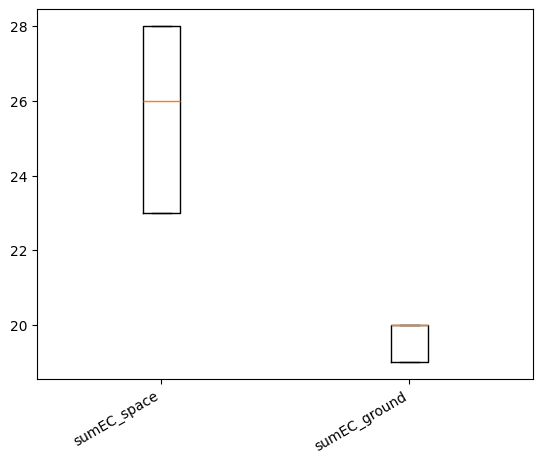

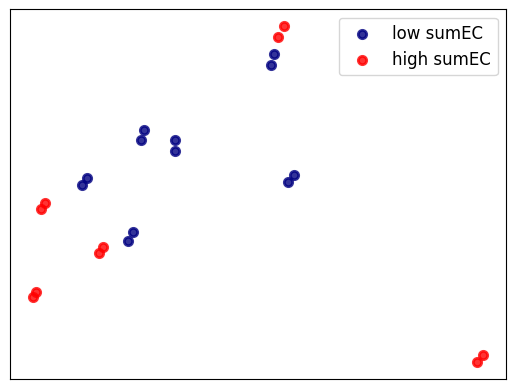

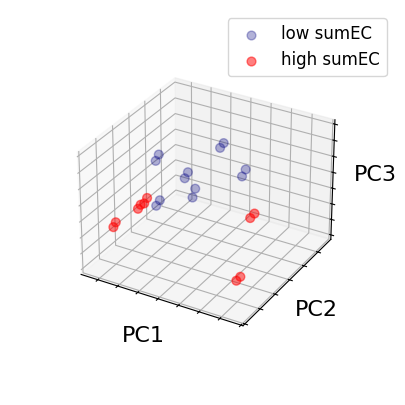

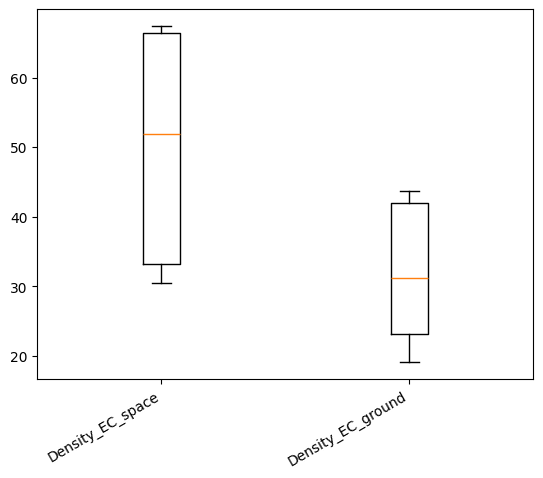

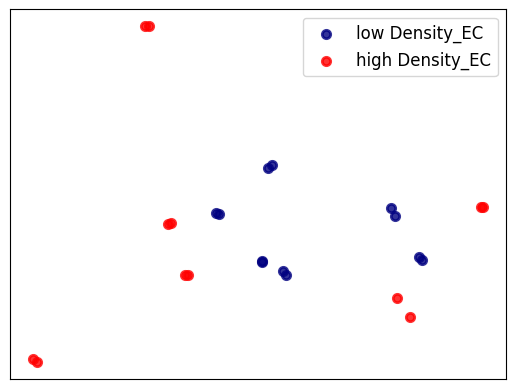

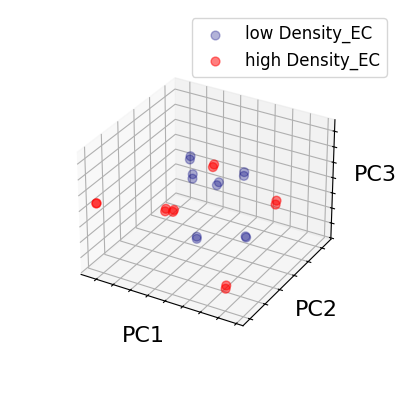

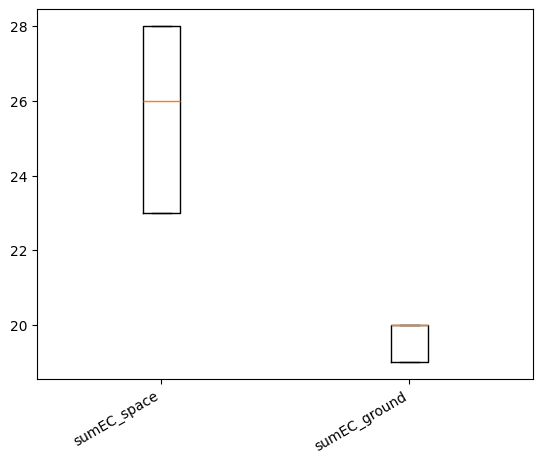

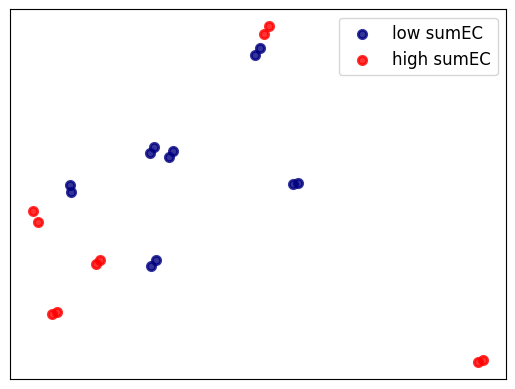

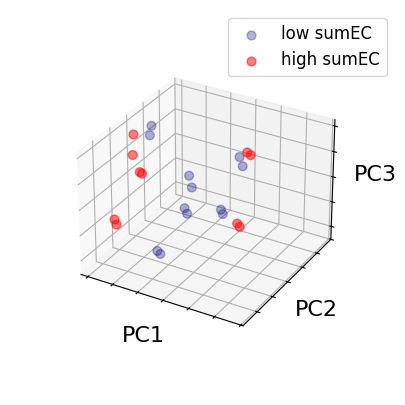

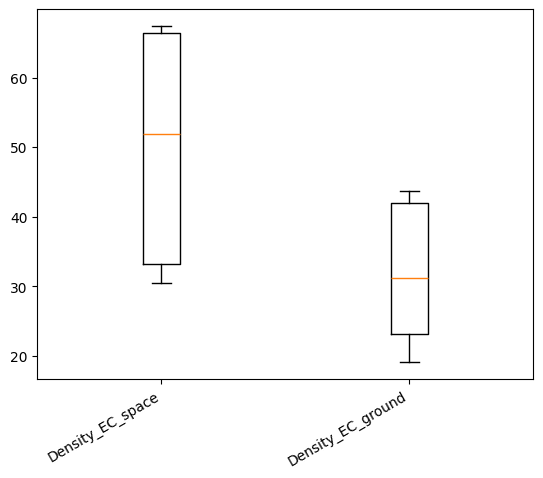

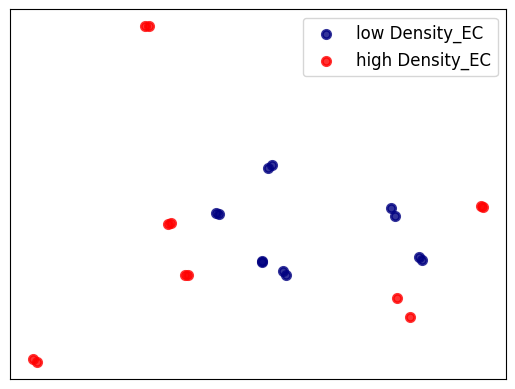

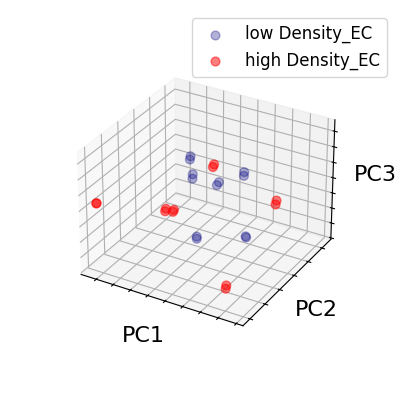

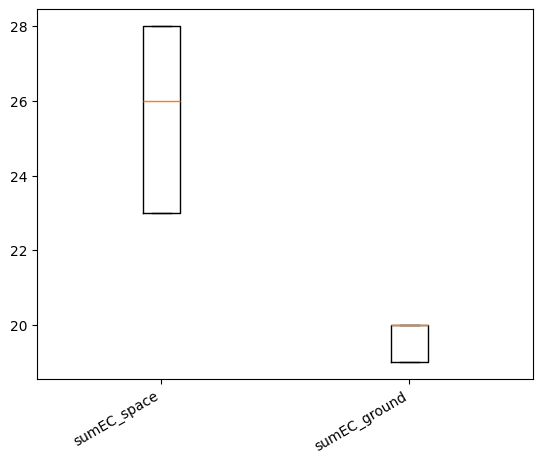

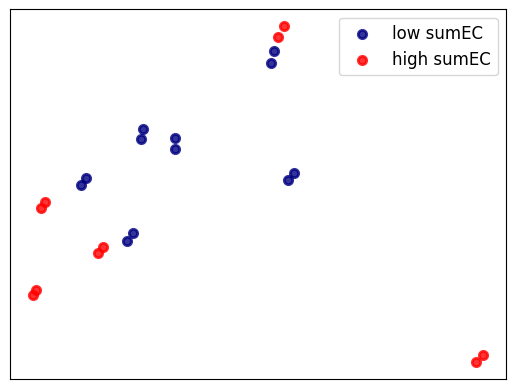

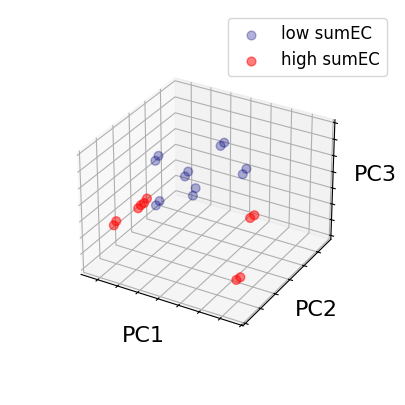

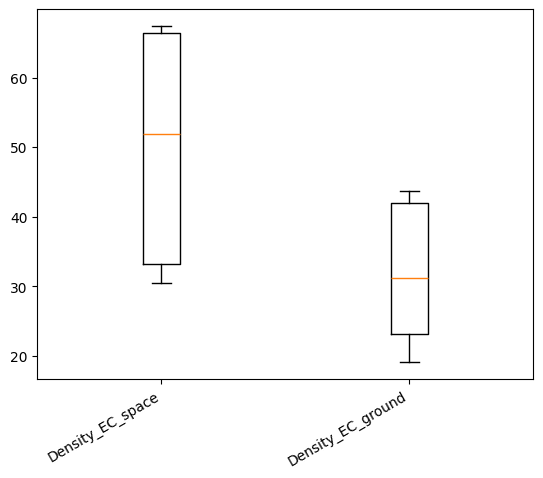

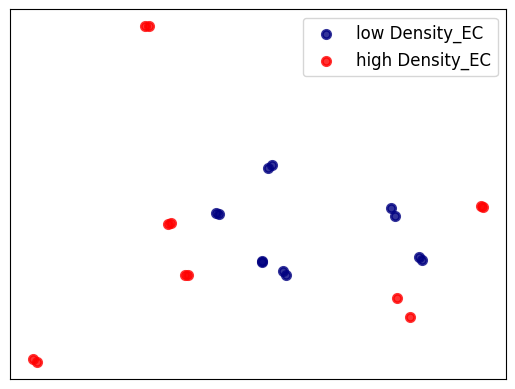

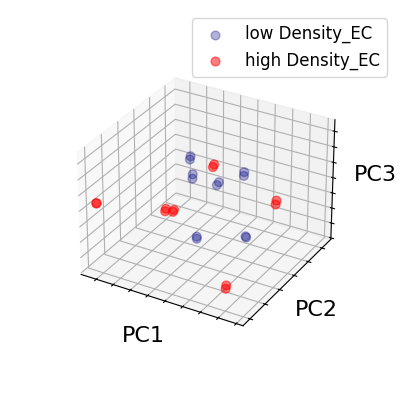

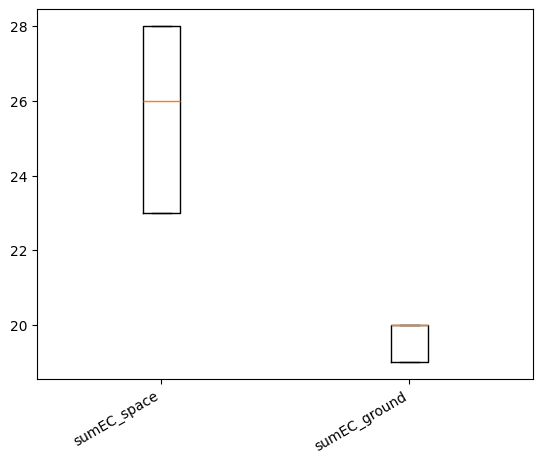

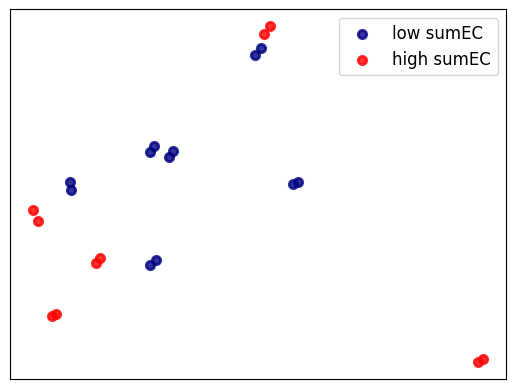

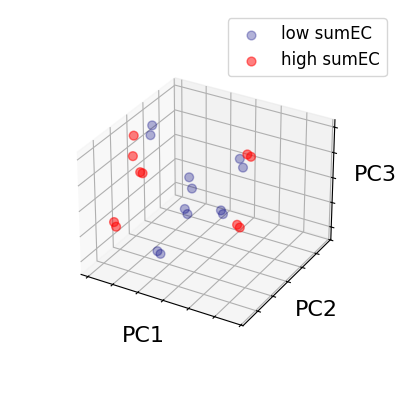

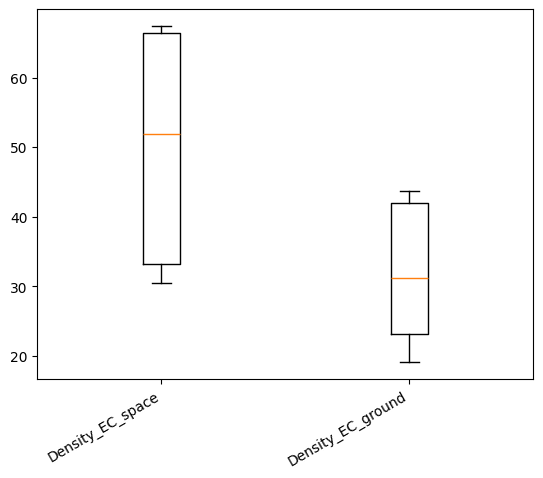

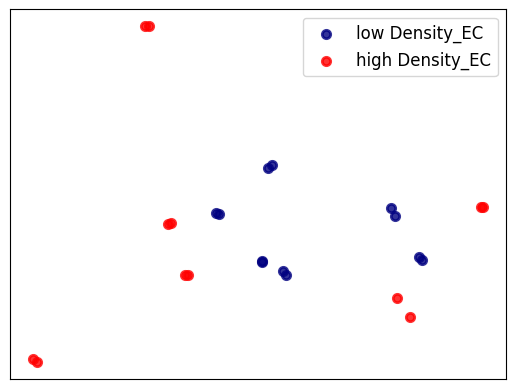

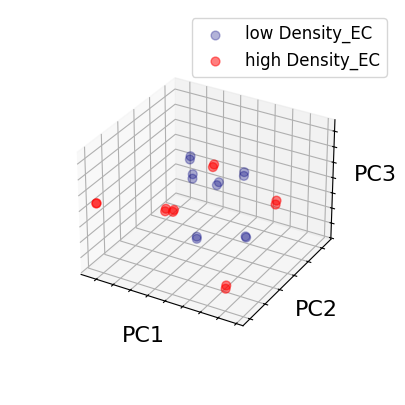

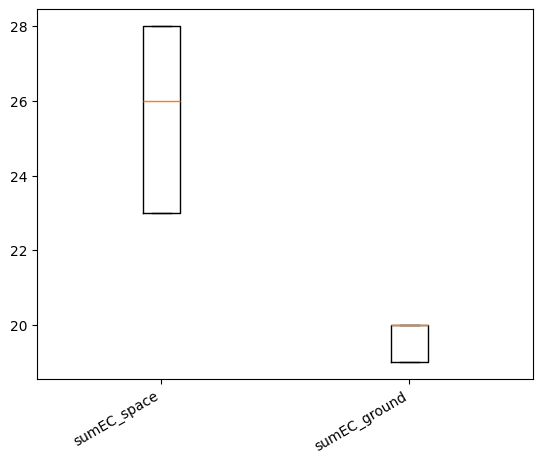

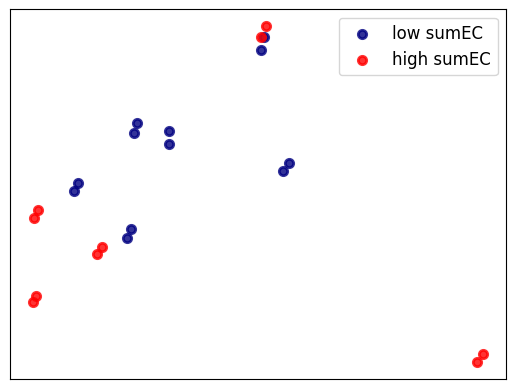

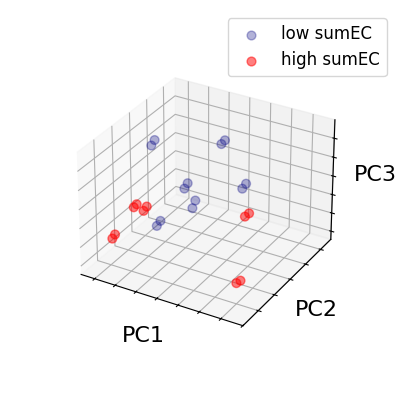

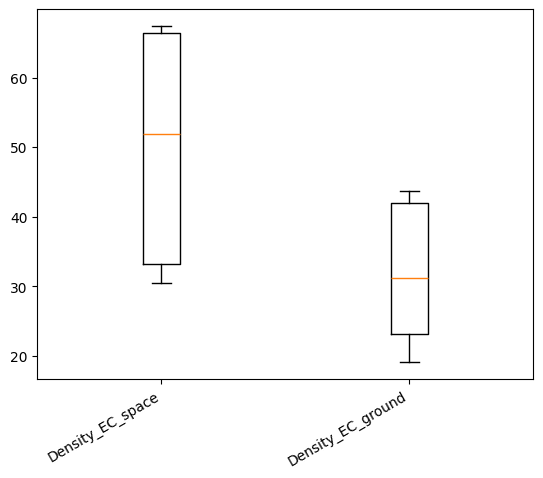

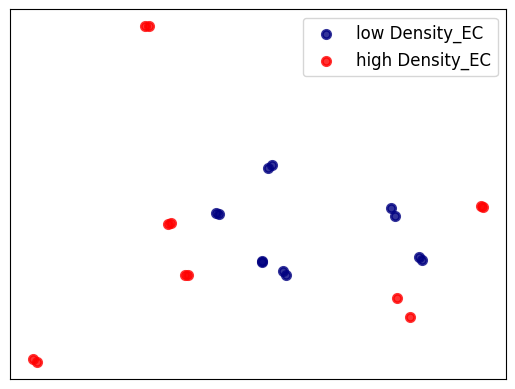

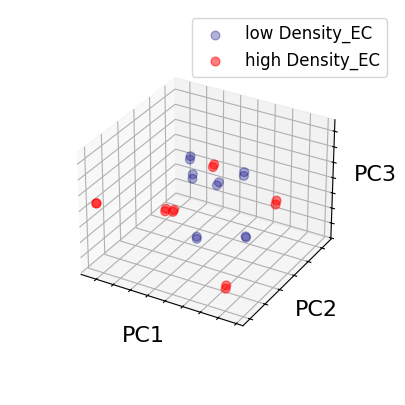

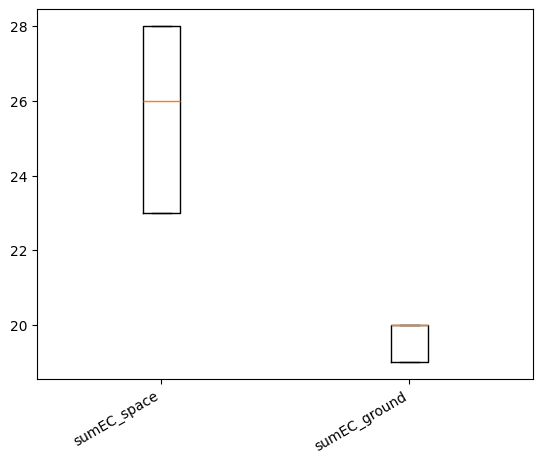

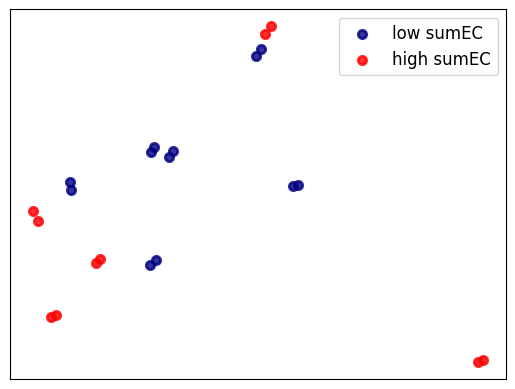

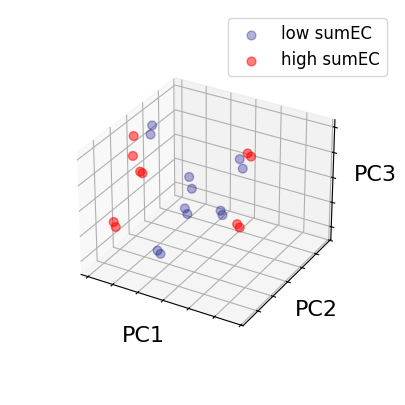

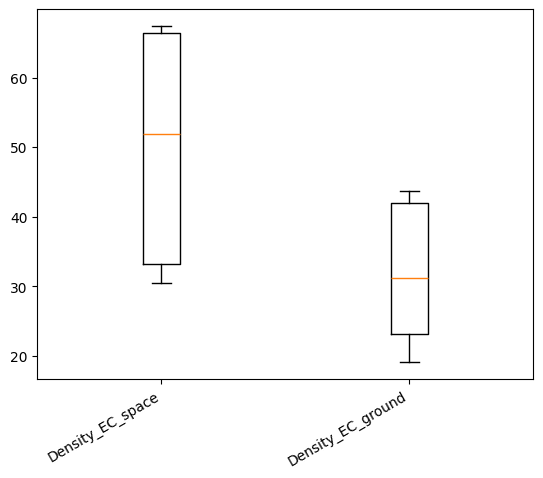

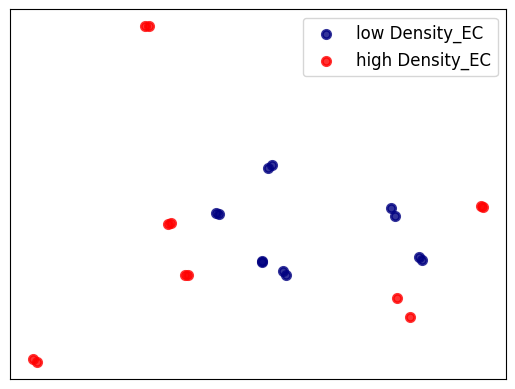

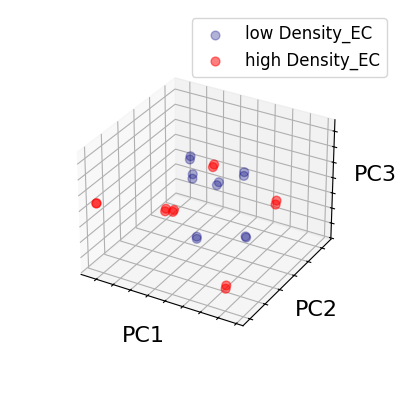

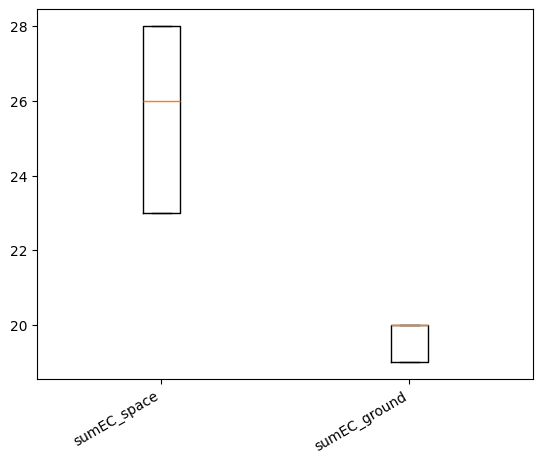

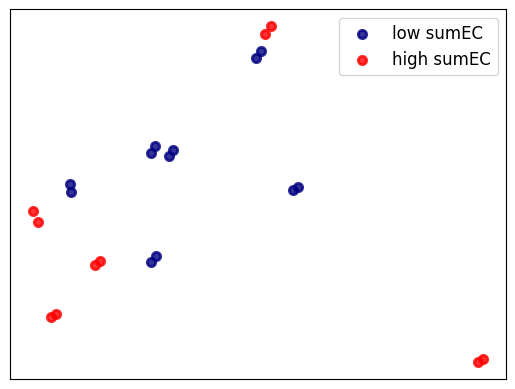

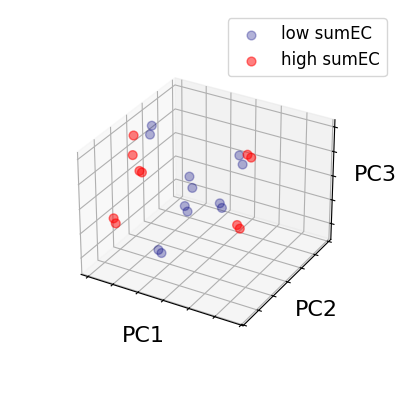

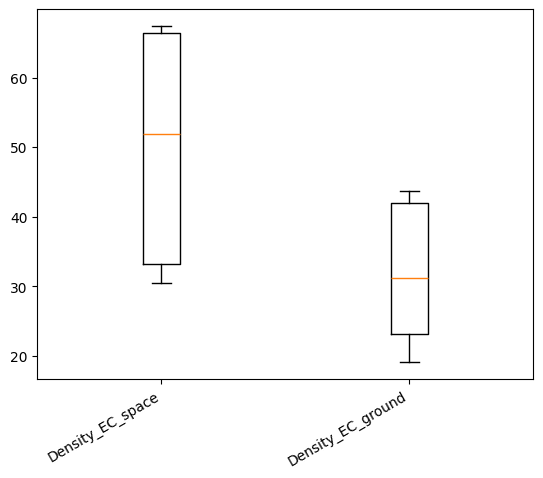

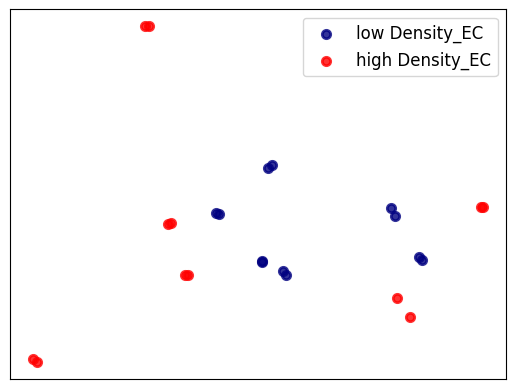

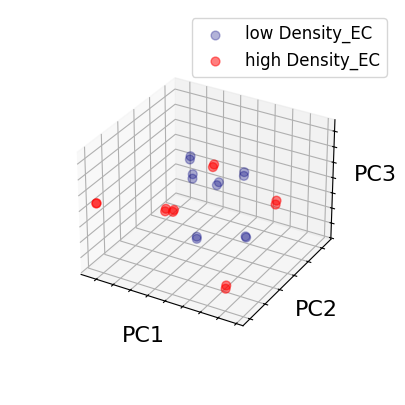

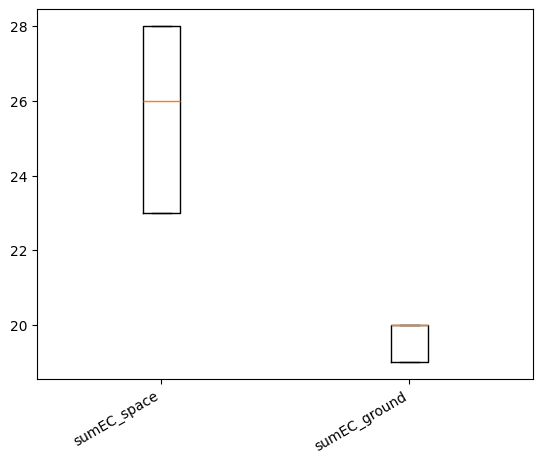

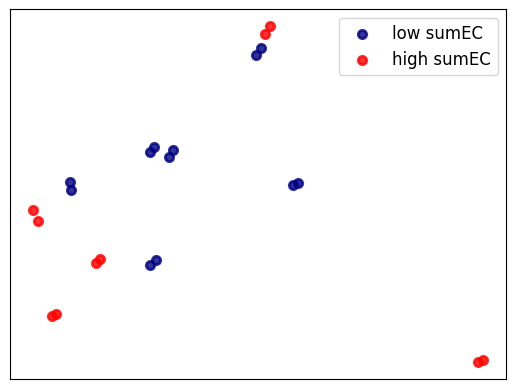

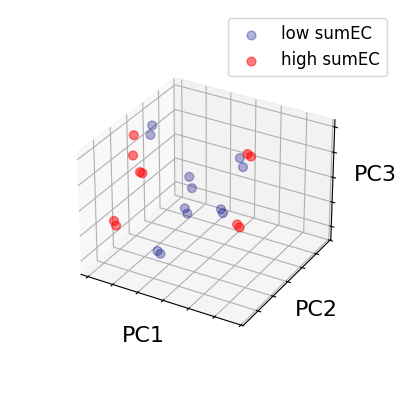

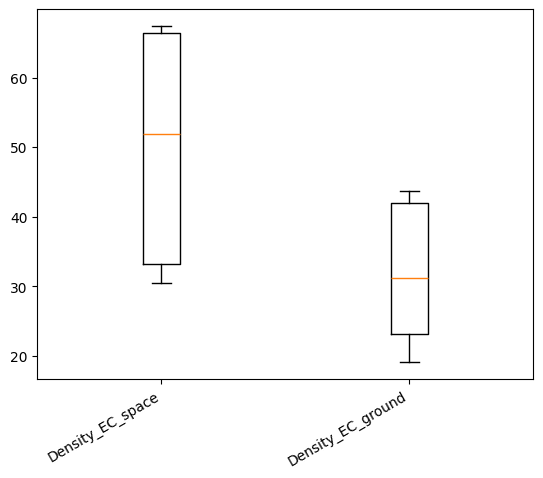

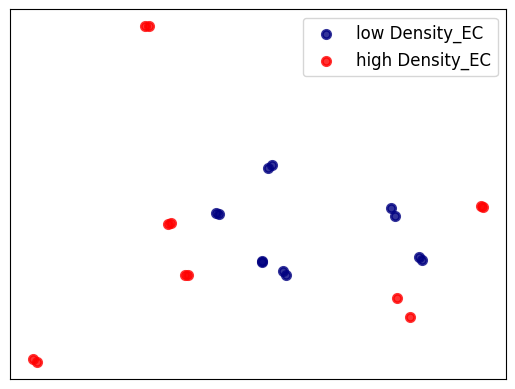

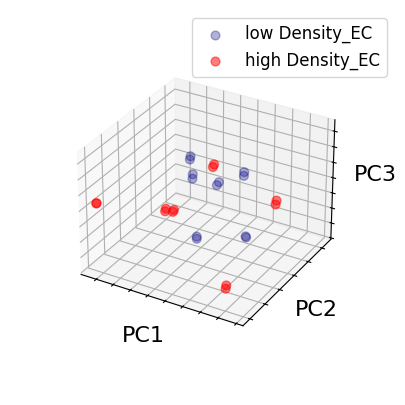

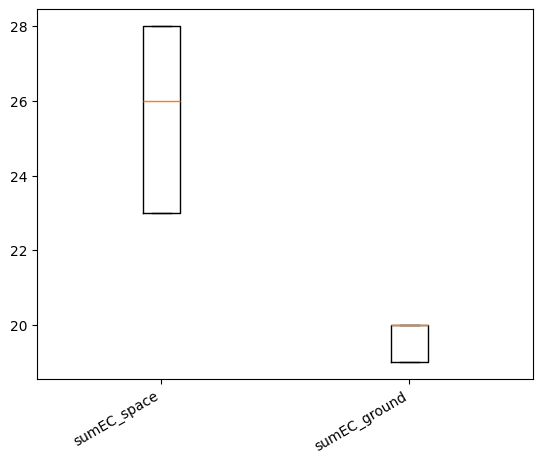

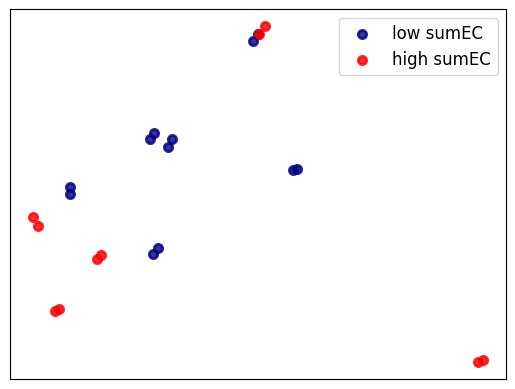

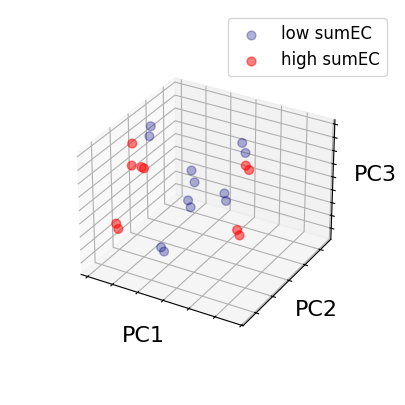

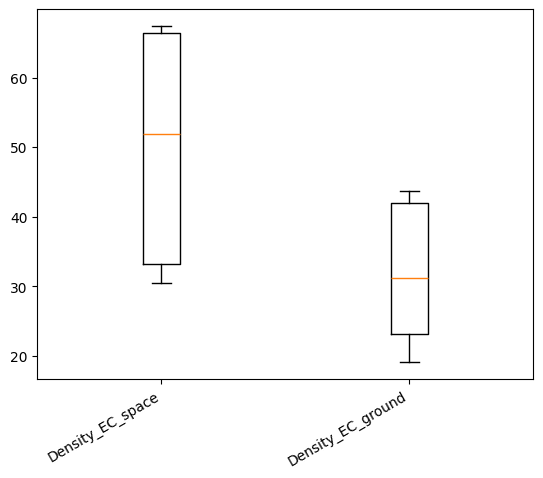

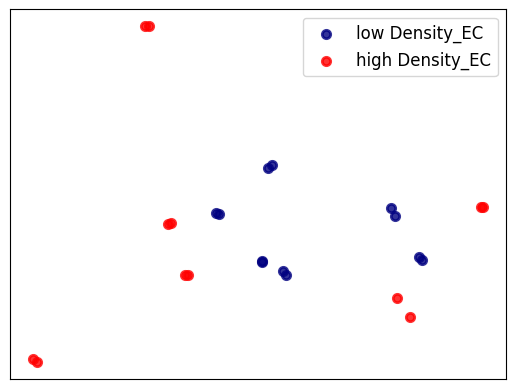

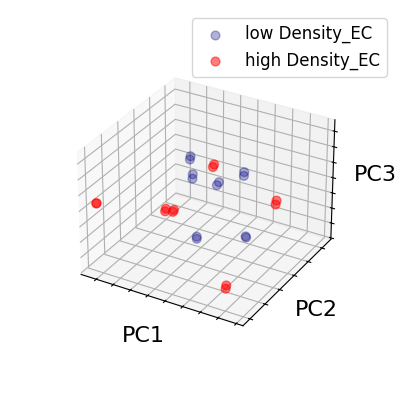

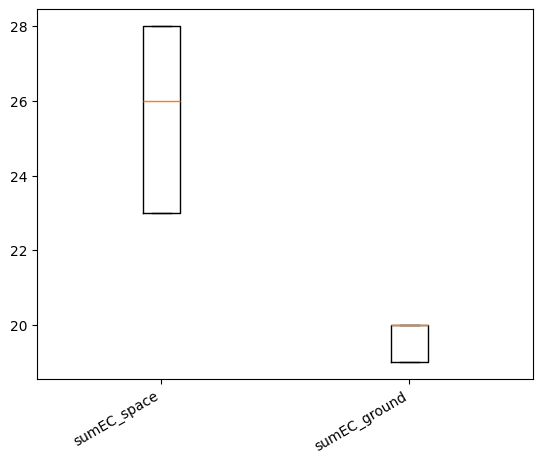

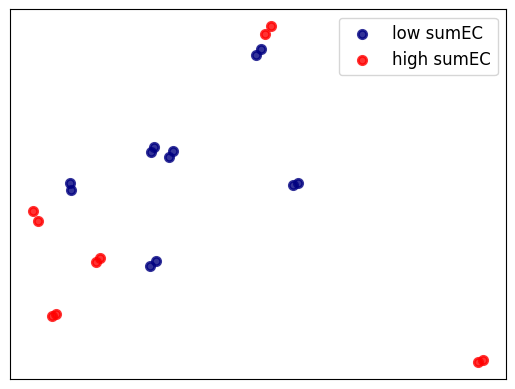

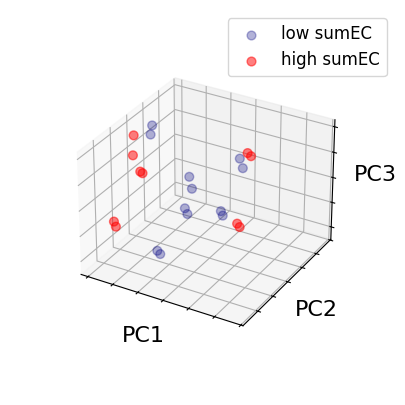

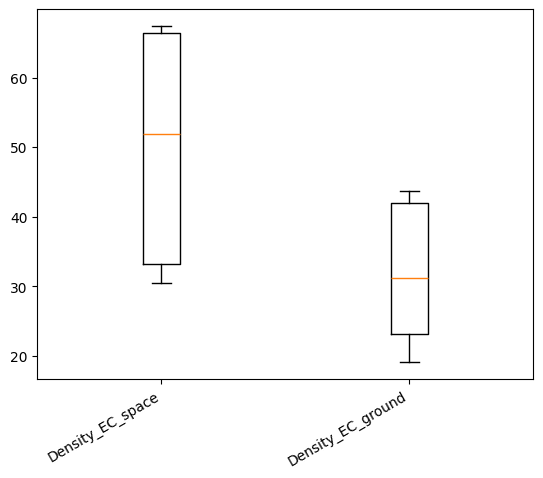

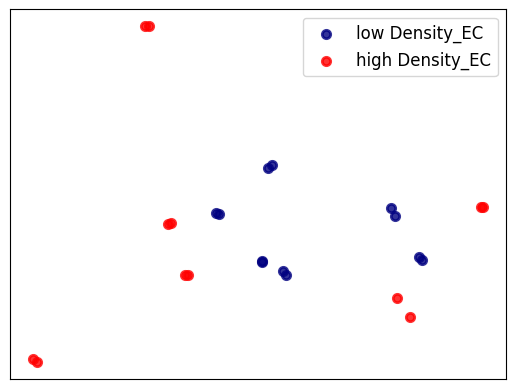

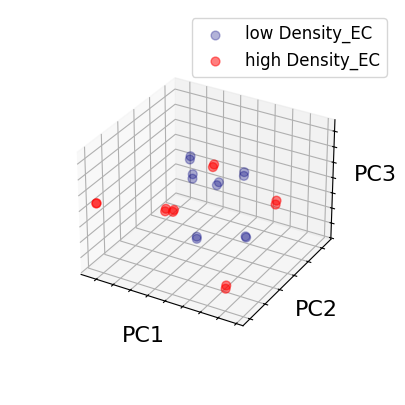

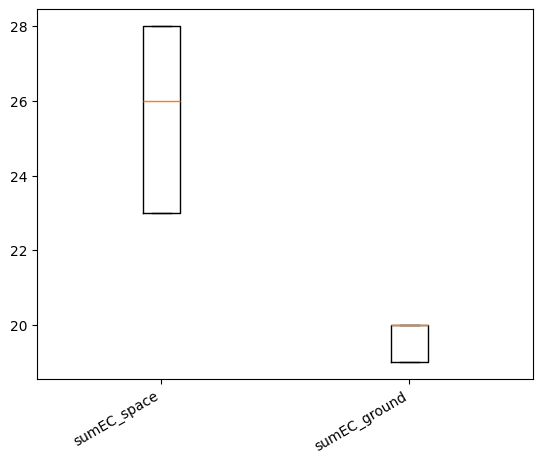

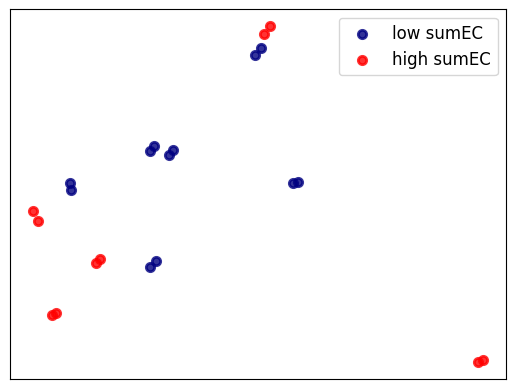

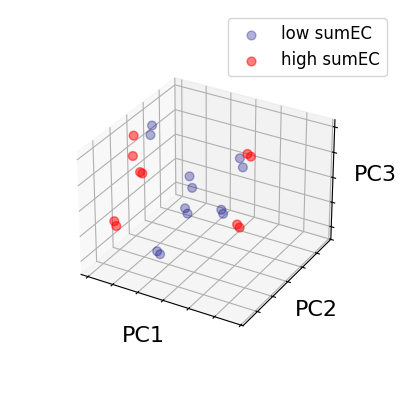

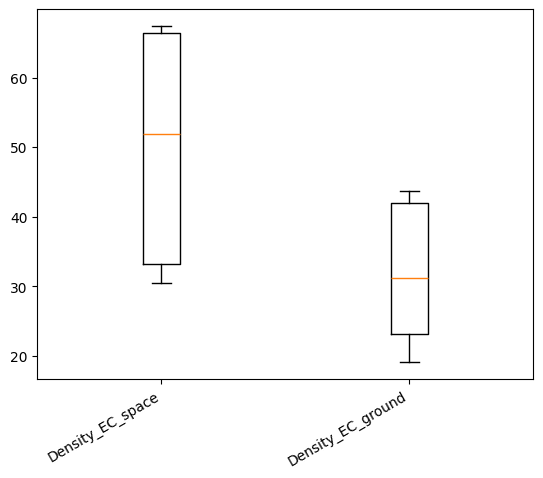

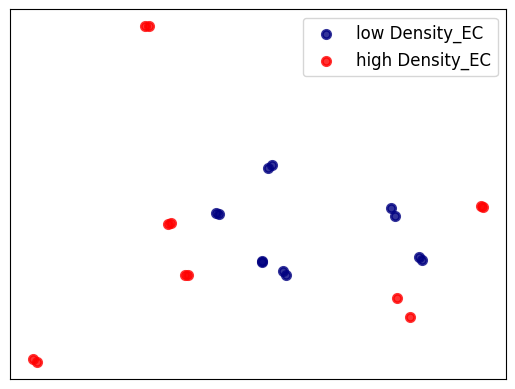

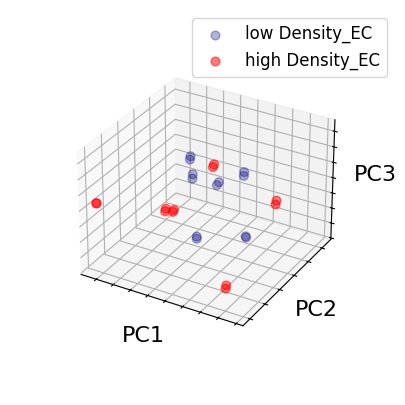

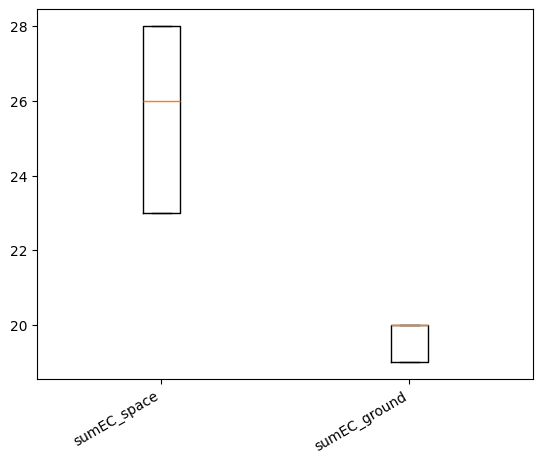

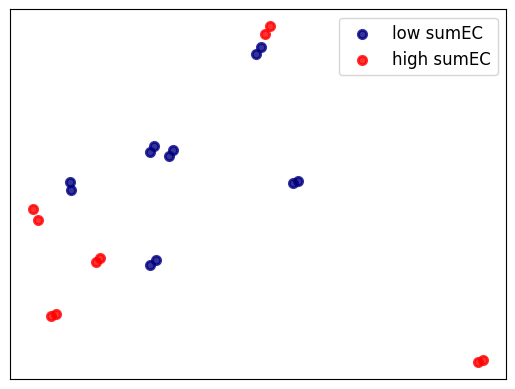

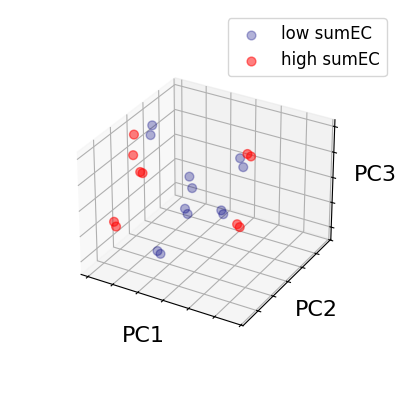

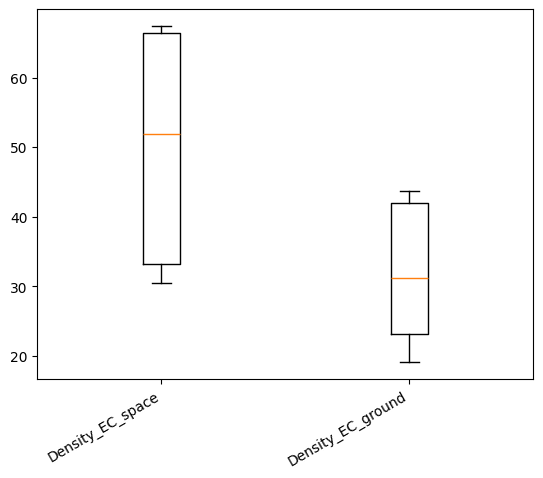

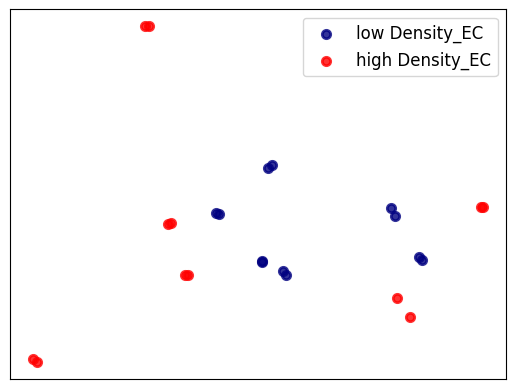

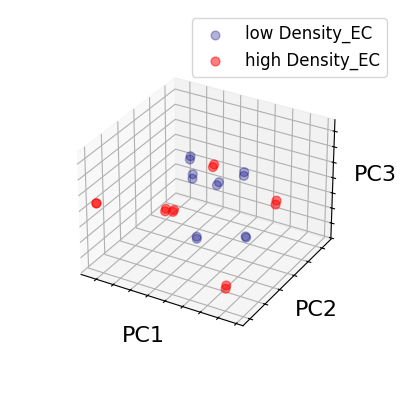

In [ ]:
# set the values below as described

# keep results from models which have r-squared score of 0.9 or higher
r2_perf_thresh = 0.9

# repeat the experiments using each of these as seeds for the RNGs
seeds=[2, 4, 8, 16, 32, 64, 127, 255, 511, 1023, 2047, 4095]

# define name and phenotype variable for experiments
experiment_config_hne = {'name': 'hne', 'pheno_var': 'sumEC'}
experiment_config_tunel = {'name': 'tunel', 'pheno_var': 'Density_EC'}
experiments = [experiment_config_hne, experiment_config_tunel]

# x_list is a list of transformations which can include 'cpm', 'log', 'std', and 'power'
x_list = ['tpm','std']

# cvs is coefficient of variation setting
cvs=0

# top-most correlated genes to target
k_corr = 1000

# n_folds is used in k-fold cross-validation
n_folds=5

# dgea_alpha (significance level for differential gene expr analysis filtering, set ]
alpha = 0

# rna_seq (data to use for rna-seq, set to'511-STAR' or '511-RSEM' for raw data,
# '511-normalized' for normalized data, 'notnorm' for combined RSEM and STAR, or 'all' for all 3)
rna_seq = 'notnorm'

# n_genes (number of genes max per model to find as predictive of the phenotype, set from 10 to 50
n_genes = 40

# test_size (fraction of data set to set aside for testing the model: set between 0.2 to 0.3)
test_size = 0.30

# lowcount is a tuple (count, percentage) -- so (50, 0.8) means remove genes that have 50 or less
# count in 80% of samples
lowcount = (100,0.8)


# reg_perf is name of performance metric to use for regression
reg_perf = 'r2' #'neg_root_mean_squared_error' 'r2'


# main loop
#####################
# DEFINE GLOBAL VARS
#####################
data = dict()
metadata = dict()
metadata_orig = dict()
X_orig = None
X_array = None
y_conditions = None
y_vals = None
y_classes = None
X_space = None
X_ground = None
X_space_array = None
X_ground_array = None

gene_dict = dict()
perfs = dict()
plots = dict()

y = dict()


for seed in seeds:
  for experiment in experiments:
    if experiment['name'] == 'hne':
      X_orig, metadata_orig, pheno_data = read_data_and_metadata_hne(data, metadata, rna_seq)
    elif experiment['name'] == 'tunel':
      X_orig, metadata_orig, pheno_data = read_data_and_metadata_tunel(data, metadata, rna_seq)
    else:
      raise Exception('experiment name not recognized')
    X_all = X_orig
    gene_dict[experiment['name']+ str(seed)] = dict()
    perfs[experiment['name'] + str(seed)] = dict()
    linreg=dict()
    elastic=dict()
    svm=dict()
    lasso=dict()
    ridge=dict()
    pheno_var = experiment['pheno_var']

    print('now running run_create_Y')
    y_conditions, y_classes, y_vals = run_create_Y(metadata_orig, pheno_data, pheno_var)
    y[experiment['name']] = dict()
    y[experiment['name']]['conditions'] = y_conditions
    y[experiment['name']]['classes'] = y_classes
    y[experiment['name']]['vals'] = y_vals

    print('now running run_filter_data')
    X_orig, X_array = run_filter_data(X_orig, y_vals, y_classes, cvs, alpha, lowcount, k_corr, seed)

    if experiment['name'] == 'hne':
      X_hne = X_orig
    elif experiment['name'] == 'tunel':
      X_tunel = X_orig
    else:
      raise Exception('experiment name not recognized')

    # test if size of dataset after the filtering leaves 0 samples
    if X_orig.shape[1] == 0:
      raise Exception('no samples left after filtering')


    key = str(cvs) + '_' + str(alpha) + '_' + str(rna_seq) + '_' + str(n_genes) + '_' + \
          str(test_size) + '_' + str(pheno_var) + '_' + \
          str(reg_perf) + '_' + str(k_corr) + '_' + str(lowcount) + \
          '_' + str(x_list) + '_' + str(experiment['name'] + '_' + str(seed))

    print('running experiment of key: ', key)

    gene_dict[experiment['name'] + str(seed)]['lr'], linreg[experiment['name']], perfs[experiment['name'] + str(seed)]['lr'] = \
      run_linear_regression(y_vals, X_array, X_orig.drop(columns=['sample']),n_genes, reg_perf, x_list, n_folds, seed)

    gene_dict[experiment['name'] + str(seed)]['elastic'], elastic[experiment['name']], perfs[experiment['name'] + str(seed)]['elastic'] = \
      run_elasticnet(y_vals, X_array, X_orig.drop(columns=['sample']), n_genes, reg_perf, x_list, n_folds, seed)

    gene_dict[experiment['name'] + str(seed)]['svm'], svm[experiment['name']], perfs[experiment['name'] + str(seed)]['svm'] = \
      run_svm(y_vals, X_array, X_orig.drop(columns=['sample']), n_genes, reg_perf, x_list, n_folds, seed)

    gene_dict[experiment['name'] + str(seed)]['lasso'], lasso[experiment['name']], perfs[experiment['name'] + str(seed)]['lasso'] = \
      run_lasso_regression(y_vals, X_array, X_orig.drop(columns=['sample']),n_genes, reg_perf, x_list, n_folds, seed)

    gene_dict[experiment['name'] + str(seed)]['ridge'], ridge[experiment['name']], perfs[experiment['name'] + str(seed)]['ridge'] = \
      run_ridge_regression(y_vals, X_array, X_orig.drop(columns=['sample']), n_genes, reg_perf, x_list, n_folds, seed)

    metadata_orig[pheno_var] = y_vals
    box_and_whisker_plot = plotbox_and_stats(data_=metadata_orig, sample_key = 'Source Name',
                                            field=pheno_var, treatment='Factor Value[Spaceflight]',
                                            condition_1_value="Space Flight", condition_1_name = 'space',
                                            condition_2_name='ground', exclude_samples=[])

    import os
    if not os.path.exists('/content/mnt/MyDrive/NASA/RR9/MANUSCRIPT/V1/RESULTS'):
      os.makedirs('/content/mnt/MyDrive/NASA/RR9/MANUSCRIPT/V1/RESULTS')
    pca_2d = plot_2d_pca(X_orig, y_classes, "low " + pheno_var, "high " + pheno_var, "navy", "red")
    pca_2d.savefig('/content/mnt/MyDrive/NASA/RR9/MANUSCRIPT/V1/RESULTS/' + experiment['name'] + '_2dpca.png', dpi=1000)
    pca_3d = plot_3d_pca(X_orig, y_classes, "low " + pheno_var, "high " + pheno_var, "navy", "red")
    pca_3d.savefig('/content/mnt/MyDrive/NASA/RR9/MANUSCRIPT/V1/RESULTS/' + experiment['name'] + '_3dpca.png', dpi=1000)

    plots[key + '-2dpca'] = pca_2d
    plots[key + '-3dpca'] = pca_3d
    plots[key + '-boxplot'] = box_and_whisker_plot




In [ ]:
# do pfi.intersection(rfe).intersection(pos.union(neg))for each model
# {'rf': {'pfi': ['Acbd4','Zfp879','Mcph1','Pld2',
union_genes = dict()
majority_genes = dict()
intersection_genes = dict()


perf_dict=dict()
for seed in seeds:
  for experiment in experiments:
    for model in ['lr', 'svm', 'ridge', 'elastic', 'lasso']:
      if not model + '_' + experiment['name'] + '_' + str(seed) in perf_dict:
        perf_dict[model + '_' + experiment['name'] + '_' + str(seed)] = dict()
      for score in perfs[experiment['name'] + str(seed)][model]:
        if 'r2' in score and perfs[experiment['name'] + str(seed)][model][score] > r2_perf_thresh:
          if not score in perf_dict[model + '_' + experiment['name'] + '_' + str(seed)]:
            perf_dict[model + '_' + experiment['name'] + '_' + str(seed)][score] = \
                                        perfs[experiment['name'] + str(seed)][model][score]
          else:
            raise Exception('should not be seeing the same model/experiment/seed/score twice?')



model_genes = dict()
for seed in seeds:
  for experiment in experiments:
    print('experiment: ', experiment['name'])
    print('seed: ', seed)
    model_genes[experiment['name'] + '_' + str(seed)] = dict()
    for model in ['lr', 'svm', 'ridge', 'elastic', 'lasso']:
      model_genes[experiment['name'] + '_' + str(seed)][model] = set()
      if 'test_r2' in perf_dict[model + '_' + experiment['name'] + '_' + str(seed)]:
        print('model: ', model)
        pfi=set(gene_dict[experiment['name'] + str(seed)][model]['pfi'])
        rfe=set(gene_dict[experiment['name'] + str(seed)][model]['rfe'])
        pos=set(gene_dict[experiment['name'] + str(seed)][model]['pos'])
        neg=set(gene_dict[experiment['name'] + str(seed)][model]['neg'])
        model_genes[experiment['name'] + '_' + str(seed)][model] = pfi.intersection(rfe).\
                                                            intersection(pos.union(neg))

    print('model genes: ', model_genes[experiment['name'] + '_' + str(seed)])
    # then do union
    union_genes[experiment['name'] + str(seed)] = set()
    for model in model_genes[experiment['name'] + '_' + str(seed)]:
      union_genes[experiment['name'] + str(seed)] = union_genes[experiment['name'] + str(seed)].\
                                                    union(model_genes[experiment['name'] + '_' + str(seed)][model])
    print('union genes: ', union_genes[experiment['name'] + str(seed)])

    # then do majority
    from collections import Counter
    all_elements = Counter()
    for model in model_genes[experiment['name'] + '_' + str(seed)]:
      for gene in model_genes[experiment['name'] + '_' + str(seed)][model]:
        all_elements[gene] += 1
    majority_genes[experiment['name'] + '_' + str(seed)] = {gene for gene, count in all_elements.items() if count > 2}
    print('majority genes: ', majority_genes[experiment['name'] + '_' + str(seed)])

    # then do intersection
    intersection_genes[experiment['name'] + str(seed)] = set()
    for model in model_genes[experiment['name'] + '_' + str(seed)]:
      intersection_genes[experiment['name'] + str(seed)] = intersection_genes[experiment['name'] + str(seed)].\
                                                            intersection(model_genes[experiment['name'] + '_' + str(seed)][model])
    print('intersection genes: ', intersection_genes[experiment['name'] + str(seed)])

    # then check in both shinygo and msigdb

experiment:  hne
seed:  2
model:  lr
model:  svm
model:  elastic
model:  lasso
model genes:  {'lr': {'Nr2e3', 'Atf4', 'Pcare', 'Chgb', 'Selenow', 'Car2', 'Stmn3', 'Syn1', 'Cplx1', 'Sncb', 'Rsrp1', 'Ndufc2', 'Ldhb', 'Cox7b', 'Hsp90ab1', 'Mrpl34', 'Prph2', 'Efemp1', 'Uqcr10', 'Dynlrb1', 'Hspb6', 'B2m', 'Pcbp2', 'Rlbp1'}, 'svm': {'Anp32a', 'Nr2e3', 'Atf4', 'Pcare', 'Rgr', 'Chgb', 'Selenow', 'Car2', 'Stmn3', 'Syn1', 'Cplx1', 'Sncb', 'Rsrp1', 'Ndufc2', 'Ldhb', 'Cox7b', 'Hsp90ab1', 'Mrpl34', 'Prph2', 'Efemp1', 'Uqcr10', 'Dynlrb1', 'Hspb6', 'B2m', 'Pcbp2', 'Rlbp1'}, 'ridge': set(), 'elastic': {'Anp32a', 'Cox7b', 'mt-Nd1', 'Prph2', 'Sncb', 'Uqcr10'}, 'lasso': {'Anp32a', 'Cox7b', 'mt-Nd1', 'Prph2', 'Sncb', 'Uqcr10'}}
union genes:  {'Anp32a', 'Nr2e3', 'Ndufc2', 'Cplx1', 'Ldhb', 'Cox7b', 'Hsp90ab1', 'Mrpl34', 'Atf4', 'Pcare', 'Rgr', 'Chgb', 'mt-Nd1', 'Prph2', 'Efemp1', 'Uqcr10', 'Dynlrb1', 'Selenow', 'Hspb6', 'Car2', 'B2m', 'Pcbp2', 'Stmn3', 'Rlbp1', 'Syn1', 'Sncb', 'Rsrp1'}
majority genes:  {'An

In [ ]:
# get genes which the majority of the ensemble found for HNE and TUNEL
majority=dict()
for seed in seeds:
  for experiment in experiments:
    if not experiment['name'] in majority:
      majority[experiment['name']] = set()
    for gene in majority_genes[experiment['name'] + '_' + str(seed)]:
        majority[experiment['name']].add(gene)

print(majority)

{'hne': {'Anp32a', 'Nr2e3', 'Hnrnph1', 'Pcare', 'Atf4', 'Chgb', 'Selenow', 'Snap25', 'Stmn3', 'Syn1', 'Sncb', 'Cplx1', 'Cox7b', 'Ldhb', 'Hsp90ab1', 'Mrpl34', 'mt-Nd1', 'Arl6ip1', 'Hnrnpa2b1', 'Prph2', 'Efemp1', 'Uqcr10', 'Dynlrb1', 'Atp5f1a', 'Hint1', 'Hspb6', 'B2m', 'Vsnl1', 'Cnga1', 'Rlbp1', 'Gpnmb', 'Trf'}, 'tunel': {'Prph2', 'Vtn', 'Atp5f1a', 'Tcf20', 'Ddit4', 'Slc24a1', 'Reep6', 'Rom1', 'Mgarp', 'Stmn3', 'Rlbp1', 'Pdzph1', 'Gabarapl1', 'Nrl', 'Dynlrb1', 'Ip6k2'}}


In [ ]:
# now find union, intersection, and difference between HNE and TUNEL


union_set = set()
only_hne = set()
only_tunel = set()
intersection_set = set()

for g1 in majority['hne']:
  for g2 in majority['tunel']:
    union_set.add(g1)
    union_set.add(g2)
    if g1 == g2:
      intersection_set.add(g1)
    else:
      only_hne.add(g1)
      only_tunel.add(g2)

print('union: ', union_set)
print('intersection: ', intersection_set)
only_hne = majority['hne'].difference(majority['tunel'])
only_tunel = majority['tunel'].difference(majority['hne'])
print('only hne: ', only_hne)
print('only tunel: ', only_tunel)

union:  {'Anp32a', 'Nr2e3', 'Tcf20', 'Slc24a1', 'Hnrnph1', 'Rom1', 'Pcare', 'Atf4', 'Chgb', 'Selenow', 'Reep6', 'Snap25', 'Stmn3', 'Pdzph1', 'Syn1', 'Sncb', 'Cplx1', 'Gpnmb', 'Ddit4', 'Cox7b', 'Ldhb', 'Hsp90ab1', 'Mrpl34', 'Mgarp', 'mt-Nd1', 'Arl6ip1', 'Hnrnpa2b1', 'Prph2', 'Efemp1', 'Uqcr10', 'Dynlrb1', 'Ip6k2', 'Vtn', 'Atp5f1a', 'Hint1', 'Hspb6', 'B2m', 'Vsnl1', 'Cnga1', 'Rlbp1', 'Gabarapl1', 'Nrl', 'Trf'}
intersection:  {'Atp5f1a', 'Stmn3', 'Rlbp1', 'Prph2', 'Dynlrb1'}
only hne:  {'Anp32a', 'Nr2e3', 'Hnrnph1', 'Atf4', 'Pcare', 'Chgb', 'Selenow', 'Snap25', 'Syn1', 'Cplx1', 'Sncb', 'Cox7b', 'Ldhb', 'Hsp90ab1', 'Mrpl34', 'mt-Nd1', 'Arl6ip1', 'Hnrnpa2b1', 'Efemp1', 'Uqcr10', 'Hint1', 'Hspb6', 'B2m', 'Vsnl1', 'Cnga1', 'Trf', 'Gpnmb'}
only tunel:  {'Vtn', 'Tcf20', 'Ddit4', 'Slc24a1', 'Reep6', 'Rom1', 'Mgarp', 'Pdzph1', 'Gabarapl1', 'Nrl', 'Ip6k2'}


In [ ]:
# print avg_train, test_rmse, and test_r2 scores for each experiment/model/seed
print(perf_dict)

{'lr_hne_2': {'test_r2': 0.9269293718268593}, 'svm_hne_2': {'test_r2': 0.9276877864459813}, 'ridge_hne_2': {}, 'elastic_hne_2': {'test_r2': 0.9178999622301108}, 'lasso_hne_2': {'test_r2': 0.9139929734267733}, 'lr_tunel_2': {}, 'svm_tunel_2': {}, 'ridge_tunel_2': {}, 'elastic_tunel_2': {}, 'lasso_tunel_2': {}, 'lr_hne_4': {'test_r2': 0.9853693571109785}, 'svm_hne_4': {'test_r2': 0.9833927686231669}, 'ridge_hne_4': {'test_r2': 0.9158895067571781}, 'elastic_hne_4': {}, 'lasso_hne_4': {}, 'lr_tunel_4': {}, 'svm_tunel_4': {}, 'ridge_tunel_4': {}, 'elastic_tunel_4': {}, 'lasso_tunel_4': {}, 'lr_hne_8': {}, 'svm_hne_8': {}, 'ridge_hne_8': {}, 'elastic_hne_8': {}, 'lasso_hne_8': {}, 'lr_tunel_8': {}, 'svm_tunel_8': {}, 'ridge_tunel_8': {}, 'elastic_tunel_8': {}, 'lasso_tunel_8': {}, 'lr_hne_16': {'test_r2': 0.9510919602451897}, 'svm_hne_16': {'test_r2': 0.9634584527189902}, 'ridge_hne_16': {'test_r2': 0.9510995107710137}, 'elastic_hne_16': {}, 'lasso_hne_16': {}, 'lr_tunel_16': {}, 'svm_tunel_

In [ ]:
# save results
store_results(majority, perfs, X_hne, X_tunel, '/content/mnt/MyDrive/NASA/RR9/MANUSCRIPT/V1/RESULTS')


In [ ]:
# plot gene results against background of all genes
results_dist_plot(X_hne, only_hne, '/content/mnt/MyDrive/NASA/RR9/MANUSCRIPT/V1/RESULTS/only_hne.png', includeText=False)
results_dist_plot(X_tunel, only_tunel, '/content/mnt/MyDrive/NASA/RR9/MANUSCRIPT/V1/RESULTS/only_tunel.png', includeText=False)


INFO:biothings.client:querying 1-999 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-999 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
